# OTMapper test
Improveing OTMapper precision, recall, and scalability by
1. ranking candidates by WD distance between concept with its context
2. applying OT on mutual NN
3. non-uniform distributions
4. applying OT On blocks of ontologies by LSH
5. others

In [4]:
import OTMapOnto as maponto
import OTMapper as otmapper
import OTNeighborhood_TDA as mapneighbor
from rdflib import Graph

import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

import ot

import importlib
import jellyfish

from collections import defaultdict

from tqdm import tqdm

import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
%%time
model_path="../model/crawl-300d-2M-subword.bin"
embs_model = maponto.load_embeddings(model_path, None)

INFO:root:load_embeddings(pretrained_path, model): Load pre-trained embeddings for about 10 mins if the model hasn't been load yet.
INFO:root:load_embeddings(pretrained_path, model): Loading the pre-trained Fasttext model...Please be patient...It may take about 10 mins to load...
INFO:gensim.models._fasttext_bin:loading 2000000 words for fastText model from ../model/crawl-300d-2M-subword.bin


Loading the pre-trained Fasttext model...Please be patient...It may take about 10 mins to load...


ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'DeutschHrvatskiEnglishDanskNederlandssuomiFran\xc3\xa7ais\xce\x95\xce\xbb\xce\xbb\xce'; replacing invalid characters, using 'DeutschHrvatskiEnglishDanskNederlandssuomiFrançaisΕλλ\\xce'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xe3\x81\x99\xe3\x81\xb9\xe3\x81\xa6\xe3\x81\xae\xe5\x9b\x9e\xe7\xad\x94\xe3\x82\x92\xe9\x9d\x9e\xe8\xa1\xa8\xe7\xa4\xba\xe3\x81\xab\xe3\x81\x99\xe3\x82\x8b\xe8\xb3\xaa\xe5\x95\x8f\xe3\x82\x92\xe5\x89\x8a\xe9\x99\xa4\xe3\x81\x97\xe3'; replacing invalid characters, using 'すべての回答を非表示にする質問を削除し\\xe3'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'00Z\xe9\x83\xa8\xe5\xb1\x8b\xe3\x82\xbf\xe3\x82\xa4\xe3\x83\x97\xe3\x81\xbe\xe3\x82\x8b\xe3\x81\xbe\xe3\x82\x8b\xe8\xb2\xb8\xe5\x88\x87\xe5\xbb\xba\xe7\x89\xa9\xe3\x82\xbf\xe3\x82\xa4\xe3\x83\x97\xe4\xb8\x80\xe8\xbb\x92\xe5'; replacing invalid characters, using '00Z部屋タイプまるまる貸切建物タイプ一軒\\xe5'
E

Completed loading the pre-trained Fasttext model.
CPU times: user 3min 30s, sys: 19 s, total: 3min 49s
Wall time: 5min 45s


In [3]:
mapper = otmapper.Mapper(embs_model)

In [211]:
#!pip install pyemd

     |████████████████████████████████| 91 kB 1.3 MB/s eta 0:00:011
  Created wheel for pyemd: filename=pyemd-0.5.1-cp38-cp38-linux_x86_64.whl size=582880 sha256=f6e90285bb56f74fea16e2339adc55fe2bd1628506eb2de4a70e0ecfd2f8941f
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a2/a5/34/f960a47ca5c06b0e91b6f48117a79a66f53a879f8fac9529bf
Successfully built pyemd


In [4]:
s1 = ['septal', 'cortex']
s2 = ['septal', 'nucleus']
s3 = ['would', 'like', 'reset', 'password']
s4 = ['edit', 'password']
s5 = ['cortex']
s6 = ['nucleus']
embs_model.wv.wmdistance(s5, s6)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(2 unique tokens: ['cortex', 'nucleus']) from 2 documents (total 2 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary(2 unique tokens: ['cortex', 'nucleus']) from 2 documents (total 2 corpus positions)", 'datetime': '2022-02-23T09:31:28.586338', 'gensim': '4.0.1', 'python': '3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.0-100-generic-x86_64-with-glibc2.17', 'event': 'created'}


1.0003559589385986

In [5]:
embs_model.wv['cortex'].shape, type(embs_model.wv['cortex'])

((300,), numpy.ndarray)

In [232]:
import scipy as sp
sp.spatial.distance.cdist(embs_model.wv['cortex'].reshape(1,-1), embs_model.wv['nucleus'].reshape(1,-1))

array([[0.59528674]])

In [261]:
costs_raw_test = maponto.costs_embeddings_raw(['cortex'], ['nucleus'], embs_model)
costs_raw_test

INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (1, 1)


array([[0.59528674]])

In [245]:
maponto.ot_couplings(1, 1, costs_raw_test)

INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...


array([[1.]])

In [5]:
maponto.wd_between_labels_raw(['cortex'], ['nucleus'], embs_model)

(array([[0.35436636]], dtype=float32), 0.35436636209487915)

In [7]:
costs_raw_test = maponto.costs_embeddings_raw(['document', 'writer', 'topic'], 
                                               ['paper', 'accepted_paper', 'author', 'subject_area'], embs_model)
costs_raw_test

INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): The shape of the cost matrix is (3, 4)


array([[0.50907428, 0.34986778, 0.48906252, 0.38278514],
       [0.62181392, 0.49941906, 0.37239078, 0.52579895],
       [0.66963402, 0.5958811 , 0.63959697, 0.57885561]])

In [9]:
maponto.ot_couplings(3, 4, costs_raw_test)

INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


array([[0.07363127, 0.1441889 , 0.00920813, 0.10630503],
       [0.03851236, 0.04083364, 0.22041667, 0.03357066],
       [0.13785637, 0.06497747, 0.02037519, 0.1101243 ]])

In [12]:
a = np.ones((3,)) / 3
b = np.ones((4,)) / 4

wd = ot.emd2(a, b, costs_raw_test)
wd

0.47192645259997223

In [11]:
maponto.wd_between_labels_raw(['document', 'writer', 'topic'], 
                                               ['paper', 'accepted_paper', 'author', 'subject_area'], embs_model)

(array([[0.2591566 , 0.12240746, 0.23918214, 0.14652446],
        [0.3866526 , 0.24941942, 0.13867494, 0.27646458],
        [0.4484098 , 0.3550743 , 0.40908432, 0.33507386]], dtype=float32),
 0.24018364772200582)

# Refine All Conference Cases

In [4]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [5]:
%%time

import time
import os

preds_candidates_list = []
refined_aligns_list = []

all_results_list = []
all_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"

criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

subfolders = os.listdir(conf_folder)
thresholds = np.arange(0, 1, 0.01)
matching_pairing = ['one-to-one', 'one-to-many', 'many-to-many']


for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        preds_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        similarities = maponto.compute_candidate_similarities(preds_topn_candidates, sedges, tedges, embs_model)
        
        preds_topn_candidates['string_similarity'] = \
            similarities['string_similarity']
        preds_topn_candidates['context_similarity'] = \
            similarities['context_similarity']
        preds_topn_candidates['label_embeddings_similarity'] = \
            similarities['label_embeddings_similarity']
        preds_topn_candidates['label_embeddings_wd_similarity'] = \
            similarities['label_embeddings_wd_similarity']
        preds_topn_candidates['string_context_similarity'] = \
            similarities['string_context_similarity']
        preds_topn_candidates['label_emb_context_similarity'] = \
            similarities['label_emb_context_similarity']
        preds_topn_candidates['label_emb_wd_context_similarity'] = \
            similarities['label_emb_wd_context_similarity']
        preds_topn_candidates['label_emb_wd_context_all_similarity'] = \
            similarities['label_emb_wd_context_all_similarity']
            
        
        all_evaluations, refined_aligns = maponto.refine_candidate_matchings(preds_topn_candidates, criteria, 
                                            thresholds, matching_pairing, subf, refs_url)
        
        preds_candidates_list.append(preds_topn_candidates)
        all_results_list.append(all_results)
        
        all_evaluations_list.append(all_evaluations)
        refined_aligns_list.append(refined_aligns)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:03, 37.34it/s]
37it [00:00, 2448.86it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


37it [00:00, 2983.38it/s]
128it [00:00, 1395.78it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.74it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.04it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.67it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 71.83it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 68.60it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.28it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 606.33it/s]
45it [00:00, 1347.08it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1534.91it/s]
34it [00:00, 729.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:05, 167.88it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 119.21it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 120.15it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 121.70it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 121.90it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 121.42it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 122.13it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.55it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 24.38it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 1863.02it/s]
61it [00:00, 1731.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1856.45it/s]
91it [00:00, 2125.58it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:26, 69.56it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.46it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.39it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.68it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.86it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.80it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 64.14it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1460.04it/s]
40it [00:00, 1831.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1841.34it/s]
50it [00:00, 1515.08it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:06, 181.44it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.15it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.10it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 82.73it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 83.01it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.54it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.42it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.27it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2408.23it/s]
132it [00:00, 1385.98it/s]

match_label_synonyms: 4



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1349.29it/s]
95it [00:00, 2455.73it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91

string_similarity
one-to-one


100%|██████████| 100/100 [00:02<00:00, 44.50it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.76it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.61it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


one-to-many


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


many-to-many


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.77it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.70it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 475.77it/s]
53it [00:00, 905.29it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 1
match_concepts_labels: 6


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


53it [00:00, 1491.26it/s]
23it [00:00, 1115.24it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:09, 111.62it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 89.58it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.48it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.99it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 86.08it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 90.41it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.91it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1041.74it/s]
135it [00:00, 1175.43it/s]

match_label_synonyms: 0



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1197.21it/s]
24it [00:00, 1056.09it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 90.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.91it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 94.71it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 97.05it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 97.28it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 97.07it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.45it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.46it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 875.33it/s]
33it [00:00, 710.88it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 700.29it/s]
24it [00:00, 948.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:08, 85.95it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 100.31it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 100.62it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 101.05it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.80it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 97.25it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 100.57it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 99.18it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 23.67it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.51it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 29.41it/s]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 675.94it/s]
64it [00:00, 1714.11it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1622.68it/s]
29it [00:00, 679.85it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:12, 106.56it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 58.15it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.27it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 69.06it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.85it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 78.41it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.91it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 974.93it/s]
41it [00:00, 1692.17it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1654.19it/s]
21it [00:00, 658.38it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
839it [00:04, 172.14it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 100.51it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 103.62it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 103.70it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 96.79it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.21it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 96.92it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.74it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.12it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 866.39it/s]
93it [00:00, 2500.00it/s]


match_label_synonyms: 0
match_concepts_labels: 10


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


93it [00:00, 2455.31it/s]
28it [00:00, 877.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:35, 52.31it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.32it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.13it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 56.32it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.87it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1121.61it/s]
68it [00:00, 1828.66it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1792.23it/s]
24it [00:00, 1153.83it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:15, 89.61it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 92.62it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 89.89it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 96.24it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 95.91it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.34it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 98.24it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1720.84it/s]
30it [00:00, 831.80it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 814.14it/s]
51it [00:00, 1705.60it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 96.79it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.47it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.33it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 88.66it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 93.10it/s] 


many-to-many


100%|██████████| 100/100 [00:01<00:00, 90.50it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 681.56it/s]
136it [00:00, 1169.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1154.11it/s]
34it [00:00, 678.22it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport.

match_label_synonyms: 5


2649it [00:20, 126.16it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.64it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 80.07it/s] 


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.76it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.18it/s] 


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.12it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.01it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2698.66it/s]
42it [00:00, 3633.30it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3426.12it/s]
96it [00:00, 2745.06it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1916it [00:17, 109.24it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.82it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.29it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.00it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.66it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.07it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.13it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1536.26it/s]
135it [00:00, 1262.82it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 4
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1223.16it/s]
54it [00:00, 1518.86it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.42it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.94it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.07it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


many-to-many


100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.39it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.74it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.72it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


17. len(source_graph)=557, len(target_graph)=245
17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1887.87it/s]
42it [00:00, 2058.65it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1994.64it/s]
66it [00:00, 1975.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 183.59it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.99it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.86it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 96.89it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 94.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 99.14it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 98.86it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1748.33it/s]
134it [00:00, 1228.07it/s]

match_label_synonyms: 6
match_concepts_labels: 6



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


134it [00:00, 1255.49it/s]
67it [00:00, 1817.31it/s]


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.49it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.07it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.47it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 79.34it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 79.36it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 77.57it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 2085.11it/s]
95it [00:00, 2530.24it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2527.73it/s]
51it [00:00, 2083.06it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:32, 60.49it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 71.09it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.53it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.39it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.30it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.17it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.83it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1245.83it/s]
95it [00:00, 2238.18it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1168.21it/s]
21it [00:00, 741.18it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance 

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 82.62it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 79.20it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 82.47it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 47.68it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.32it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1812.08it/s]
61it [00:00, 2197.48it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2121.34it/s]
47it [00:00, 1851.89it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:09, 128.65it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 68.65it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 52.09it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.73it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.78it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 67.21it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 67.79it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.36it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


CPU times: user 2h 4min 26s, sys: 1min 22s, total: 2h 5min 48s
Wall time: 1h 24min 40s


In [6]:
len(all_evaluations_list)

21

In [7]:
all_evaluations_list[2]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0            23                       12              16   0.750000  0.521739   
1            23                       12              16   0.750000  0.521739   
2            23                       12              17   0.705882  0.521739   
3            23                       12              17   0.705882  0.521739   
4            23                       12              18   0.666667  0.521739   
...         ...                      ...             ...        ...       ...   
2395         23                        0               0   0.000000  0.000000   
2396         23                        0               0   0.000000  0.000000   
2397         23                        0               0   0.000000  0.000000   
2398         23                        0               0   0.000000  0.000000   
2399         23                        0               0   0.000000  0.000000   

            f1  test_case                           similarity  \
0     0.615385  edas-ekaw  label_emb_wd_context_all_similarity   
1     0.615385  edas-ekaw  label_emb_wd_context_all_similarity   
2     0.600000  edas-ekaw  label_emb_wd_context_all_similarity   
3     0.600000  edas-ekaw  label_emb_wd_context_all_similarity   
4     0.585366  edas-ekaw  label_emb_wd_context_all_similarity   
...        ...        ...                                  ...   
2395  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2396  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2397  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2398  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2399  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   

      similarity_threshold  similarity_cutoff matching_pairing  
0                     0.69           0.685181       one-to-one  
1                     0.68           0.677858       one-to-one  
2                     0.68           0.677858      one-to-many  
3                     0.69           0.685181      one-to-many  
4                     0.67           0.669651       one-to-one  
...                    ...                ...              ...  
2395                  0.98           0.940585      one-to-many  
2396                  0.97           0.940585      one-to-many  
2397                  0.96           0.940585      one-to-many  
2398                  0.95           0.940585      one-to-many  
2399                  0.99           0.940585     many-to-many  

[2400 rows x 11 columns]

In [8]:
all_evaluations_all = pd.concat(all_evaluations_list)

In [9]:
all_evaluations_all.shape

(50400, 11)

In [905]:
#all_evaluations_all.to_csv("../data/conference/with_references/all_evaluations_all.csv")

In [10]:
all_evaluations_all.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [11]:
all_evaluations_all_means = all_evaluations_all.groupby(['similarity', 'similarity_threshold', 'matching_pairing']).mean().sort_values('f1', ascending=False)

In [908]:
#all_evaluations_all_means.to_csv("../data/conference/with_references/all_evaluations_all_means.csv")

In [12]:
all_evaluations_all_means

numOfRefs  \
similarity                similarity_threshold matching_pairing              
string_context_similarity 0.25                 many-to-many       14.52381   
                          0.26                 one-to-one         14.52381   
                                               one-to-many        14.52381   
                                               many-to-many       14.52381   
                          0.25                 one-to-one         14.52381   
...                                                                    ...   
context_similarity        0.97                 one-to-one         14.52381   
                          0.98                 one-to-many        14.52381   
                          0.97                 one-to-many        14.52381   
                          0.98                 many-to-many       14.52381   
                          0.97                 many-to-many       14.52381   

                                                                 numOfCorrectlyPredicted  \
similarity                similarity_threshold matching_pairing                            
string_context_similarity 0.25                 many-to-many                     6.857143   
                          0.26                 one-to-one                       6.857143   
                                               one-to-many                      6.857143   
                                               many-to-many                     6.857143   
                          0.25                 one-to-one                       6.857143   
...                                                                                  ...   
context_similarity        0.97                 one-to-one                       0.047619   
                          0.98                 one-to-many                      0.047619   
                          0.97                 one-to-many                      0.047619   
                          0.98                 many-to-many                     0.047619   
                          0.97                 many-to-many                     0.047619   

                                                                 numOfPredicted  \
similarity                similarity_threshold matching_pairing                   
string_context_similarity 0.25                 many-to-many            7.809524   
                          0.26                 one-to-one              7.809524   
                                               one-to-many             7.809524   
                                               many-to-many            7.809524   
                          0.25                 one-to-one              7.809524   
...                                                                         ...   
context_similarity        0.97                 one-to-one              0.142857   
                          0.98                 one-to-many             0.190476   
                          0.97                 one-to-many             0.285714   
                          0.98                 many-to-many            0.333333   
                          0.97                 many-to-many            0.523810   

                                                                 precision  \
similarity                similarity_threshold matching_pairing              
string_context_similarity 0.25                 many-to-many       0.889611   
                          0.26                 one-to-one         0.889611   
                                               one-to-many        0.889611   
                                               many-to-many       0.889611   
                          0.25                 one-to-one         0.889611   
...                                                                    ...   
context_similarity        0.97                 one-to-one         0.015873   
                          0.98                 one-to-many        0.011

In [13]:
all_evaluations_121 = all_evaluations_all[all_evaluations_all.matching_pairing == 'one-to-one']
all_evaluations_all_means_121 = all_evaluations_121.groupby(['similarity', 'similarity_threshold']).mean().sort_values('f1', ascending=False)
all_evaluations_all_means_121[all_evaluations_all_means_121.f1 > 0.63]

numOfRefs  \
similarity                     similarity_threshold              
string_context_similarity      0.24                   14.52381   
                               0.26                   14.52381   
                               0.25                   14.52381   
                               0.21                   14.52381   
                               0.22                   14.52381   
                               0.23                   14.52381   
label_embeddings_wd_similarity 0.97                   14.52381   

                                                     numOfCorrectlyPredicted  \
similarity                     similarity_threshold                            
string_context_similarity      0.24                                 6.857143   
                               0.26                                 6.857143   
                               0.25                                 6.857143   
                               0.21                                 6.857143   
                               0.22                                 6.857143   
                               0.23                                 6.857143   
label_embeddings_wd_similarity 0.97                                 6.857143   

                                                     numOfPredicted  \
similarity                     similarity_threshold                   
string_context_similarity      0.24                        7.809524   
                               0.26                        7.809524   
                               0.25                        7.809524   
                               0.21                        7.857143   
                               0.22                        7.857143   
                               0.23                        7.857143   
label_embeddings_wd_similarity 0.97                        7.809524   

                                                     precision    recall  \
similarity                     similarity_threshold                        
string_context_similarity      0.24                   0.889611  0.505198   
                               0.26                   0.889611  0.505198   
                               0.25                   0.889611  0.505198   
                               0.21                   0.886995  0.505198   
                               0.22                   0.886995  0.505198   
                               0.23                   0.886995  0.505198   
label_embeddings_wd_similarity 0.97                   0.888116  0.504279   

                                                           f1  \
similarity                     similarity_threshold             
string_context_similarity      0.24                  0.631327   
                               0.26                  0.631327   
                               0.25                  0.631327   
                               0.21                  0.630612   
                               0.22                  0.630612   
                               0.23                  0.630612   
label_embeddings_wd_similarity 0.97                  0.630035   

                                                     similarity_cutoff  
similarity                     similarity_threshold                     
string_context_similarity      0.24                           0.083662  
                               0.26                           0.083662  
                               0.25                           0.083662  
                               0.21                           0.076653  
                               0.22                           0.076653  
                               0.23                           0.076653  
label_embeddings_wd_similarity 0.97                           0.939235

In [14]:
preds_candidates_list[20].head()

source          source_label_x  \
0                http://conference#Abstract                Abstract   
1              http://conference#Conference              Conference   
2  http://conference#Conference_participant  Conference_participant   
3  http://conference#Conference_proceedings  Conference_proceedings   
4         http://conference#Invited_speaker         Invited_speaker   

                               target          target_label_x  \
0                http://ekaw#Abstract                Abstract   
1              http://ekaw#Conference              Conference   
2  http://ekaw#Conference_Participant  Conference_Participant   
3  http://ekaw#Conference_Proceedings  Conference_Proceedings   
4         http://ekaw#Invited_Speaker         Invited_Speaker   

           target_label_y          source_label_y  string_similarity  \
0                Abstract                Abstract                1.0   
1              Conference              Conference                1.0   
2  Conference_Participant  Conference_participant                1.0   
3  Conference_Proceedings  Conference_proceedings                1.0   
4         Invited_Speaker         Invited_speaker                1.0   

   context_similarity  label_embeddings_similarity  \
0            0.938063                          1.0   
1            0.795362                          1.0   
2            0.888514                          1.0   
3            0.653297                          1.0   
4            0.967539                          1.0   

   label_embeddings_wd_similarity  string_context_similarity  \
0                             1.0                   0.938063   
1                             1.0                   0.795362   
2                             1.0                   0.888514   
3                             1.0                   0.653297   
4                             1.0                   0.967539   

   label_emb_context_similarity  label_emb_wd_context_similarity  \
0                      0.938063                         0.938063   
1                      0.795362                         0.795362   
2                      0.888514                         0.888514   
3                      0.653297                         0.653297   
4                      0.967539                         0.967539   

   label_emb_wd_context_all_similarity  
0                             0.938063  
1                             0.795362  
2                             0.888514  
3                             0.653297  
4                             0.967539

In [15]:
import pickle
with open("../data/conference/with_references/preds_candidates_list.pk", "wb") as file:
    pickle.dump(preds_candidates_list, file)

In [30]:
refined_aligns_list[3]

Empty DataFrame
Columns: [source, source_label_x, target, target_label_x, target_label_y, source_label_y, string_similarity, context_similarity, label_embeddings_similarity, label_embeddings_wd_similarity, string_context_similarity, label_emb_context_similarity, label_emb_wd_context_similarity, label_emb_wd_context_all_similarity]
Index: []

In [20]:
all_results_list[20][2]

{'numOfRefs': 25,
 'numOfCorrectlyPredicted': 9,
 'numOfPredicted': 15,
 'precision': 0.6,
 'recall': 0.36,
 'f1': 0.44999999999999996,
 'method': 'combined:match_label_features',
 'test_case': 'conference-ekaw'}

In [494]:
all_evaluations.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [ ]:
criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

In [32]:
preds_topn_candidates.columns

Index(['source', 'source_label_x', 'target', 'target_label_x',
       'target_label_y', 'source_label_y', 'string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity'],
      dtype='object')

In [35]:
all_evaluations.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

# Extract Refined Class Matching 

In [38]:
refs_url_list = []
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        refs_url_list.append(refs_url)

In [45]:
raw_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        raw_evaluation = maponto.evaluate_noprint(candidates, refs_url_list[i])
        raw_evaluation_list.append(raw_evaluation)

In [244]:
pd.DataFrame(raw_evaluation_list).mean()

numOfRefs                    14.523810
numOfCorrectlyPredicted      11.238095
numOfPredicted             1731.428571
precision                     0.007512
recall                        0.784449
f1                            0.014840
dtype: float64

In [272]:
refined_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        refined_candidates = candidates[(candidates.string_context_similarity >= 0.25)]
        refined_evaluation = maponto.evaluate_noprint(refined_candidates, refs_url_list[i])
        refined_evaluation['refs_url'] = refs_url_list[i][35:-14]
        refined_evaluation_list.append(refined_evaluation)

In [273]:
pd.set_option('display.max_rows', 25)
pd.DataFrame(refined_evaluation_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       12              13   0.923077  0.800000   
1           7                        4               4   1.000000  0.571429   
2          23                       10              13   0.769231  0.434783   
3          15                        8               9   0.888889  0.533333   
4          19                        8               9   0.888889  0.421053   
5          15                        4               6   0.666667  0.266667   
6           4                        4               5   0.800000  1.000000   
7          16                        4               5   0.800000  0.250000   
8          20                        9              10   0.900000  0.450000   
9          12                        8               8   1.000000  0.666667   
10         19                        9              10   0.900000  0.473684   
11         11                        5               5   1.000000  0.454545   
12         15                        7               8   0.875000  0.466667   
13          9                        4               4   1.000000  0.444444   
14         15                        7               7   1.000000  0.466667   
15         14                        4               5   0.800000  0.285714   
16         11                        7               7   1.000000  0.636364   
17         10                        6               6   1.000000  0.600000   
18         17                        7               9   0.777778  0.411765   
19         13                        8               8   1.000000  0.615385   
20         25                        9              13   0.692308  0.360000   

          f1           refs_url  
0   0.857143      iasted-sigkdd  
1   0.727273      confof-sigkdd  
2   0.555556          edas-ekaw  
3   0.666667  conference-sigkdd  
4   0.571429        edas-iasted  
5   0.380952     cmt-conference  
6   0.888889         cmt-iasted  
7   0.380952         cmt-confof  
8   0.600000        confof-ekaw  
9   0.800000         cmt-sigkdd  
10  0.620690        confof-edas  
11  0.625000           cmt-ekaw  
12  0.608696  conference-confof  
13  0.615385      confof-iasted  
14  0.636364        edas-sigkdd  
15  0.421053  conference-iasted  
16  0.777778        ekaw-sigkdd  
17  0.750000        ekaw-iasted  
18  0.538462    conference-edas  
19  0.761905           cmt-edas  
20  0.473684    conference-ekaw

In [43]:
pd.DataFrame(refined_evaluation_list).mean()

numOfRefs                  14.523810
numOfCorrectlyPredicted     6.857143
numOfPredicted              7.809524
precision                   0.889611
recall                      0.505198
f1                          0.631327
dtype: float64

In [265]:
refined_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        refined_candidates = candidates[(candidates.label_embeddings_similarity >= 0.8)]
        refined_evaluation = maponto.evaluate_noprint(refined_candidates, refs_url_list[i])
        refined_evaluation_list.append(refined_evaluation)

In [266]:
pd.DataFrame(refined_evaluation_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       12              29   0.413793  0.800000   
1           7                        4               6   0.666667  0.571429   
2          23                       14              52   0.269231  0.608696   
3          15                        9              12   0.750000  0.600000   
4          19                        8              17   0.470588  0.421053   
5          15                        5              12   0.416667  0.333333   
6           4                        4              11   0.363636  1.000000   
7          16                        4               5   0.800000  0.250000   
8          20                       14              22   0.636364  0.700000   
9          12                       10              17   0.588235  0.833333   
10         19                       10              19   0.526316  0.526316   
11         11                        6              13   0.461538  0.545455   
12         15                        9              24   0.375000  0.600000   
13          9                        5              17   0.294118  0.555556   
14         15                        8              13   0.615385  0.533333   
15         14                        5              52   0.096154  0.357143   
16         11                        7              14   0.500000  0.636364   
17         10                        6              28   0.214286  0.600000   
18         17                        8              27   0.296296  0.470588   
19         13                        8              10   0.800000  0.615385   
20         25                       11              25   0.440000  0.440000   

          f1  
0   0.545455  
1   0.615385  
2   0.373333  
3   0.666667  
4   0.444444  
5   0.370370  
6   0.533333  
7   0.380952  
8   0.666667  
9   0.689655  
10  0.526316  
11  0.500000  
12  0.461538  
13  0.384615  
14  0.571429  
15  0.151515  
16  0.560000  
17  0.315789  
18  0.363636  
19  0.695652  
20  0.440000

In [267]:
pd.DataFrame(refined_evaluation_list).mean()

numOfRefs                  14.523810
numOfCorrectlyPredicted     7.952381
numOfPredicted             20.238095
precision                   0.475918
recall                      0.571332
f1                          0.488417
dtype: float64

# Testing

In [561]:
mapneighbor.get_syn_phrases("review preference")

['reappraisal preference',
 'reappraisal penchant',
 'reappraisal predilection',
 'reappraisal taste',
 'reappraisal orientation',
 'reappraisal druthers',
 'revaluation preference',
 'revaluation penchant',
 'revaluation predilection',
 'revaluation taste',
 'revaluation orientation',
 'revaluation druthers',
 'review preference',
 'review penchant',
 'review predilection',
 'review taste',
 'review orientation',
 'review druthers',
 'reassessment preference',
 'reassessment penchant',
 'reassessment predilection',
 'reassessment taste',
 'reassessment orientation',
 'reassessment druthers',
 'critique preference',
 'critique penchant',
 'critique predilection',
 'critique taste',
 'critique orientation',
 'critique druthers',
 'critical review preference',
 'critical review penchant',
 'critical review predilection',
 'critical review taste',
 'critical review orientation',
 'critical review druthers',
 'review article preference',
 'review article penchant',
 'review article predile

In [553]:
maponto.normalize_nounsyn_counts("review preference")

defaultdict(int, {'review preference': 1})

# MSE Benchmark

In [288]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [6]:
source_url = "../data/MSE-Benchmark/testCases/firstTestCase/MaterialInformation-Reduced.owl"
target_url = "../data/MSE-Benchmark/testCases/firstTestCase/MatOnto.owl"
output_url = '../data/results/MSE_firstTest_case_alignments.rdf'
refs_url = "../data/MSE-Benchmark/testCases/firstTestCase/RefAlign1.rdf"

In [7]:
mapper.align(source_url, target_url, output_url)

INFO:root:Python ensemble mapper info: map ../data/MSE-Benchmark/testCases/firstTestCase/MaterialInformation-Reduced.owl to ../data/MSE-Benchmark/testCases/firstTestCase/MatOnto.owl


../data/MSE-Benchmark/testCases/firstTestCase/MaterialInformation-Reduced.owl


INFO:root:Read source with 309 triples.


../data/MSE-Benchmark/testCases/firstTestCase/MatOnto.owl


INFO:root:Read target with 11363 triples.
INFO:root:MAP CONCEPTS
INFO:root:The number of level_1 predicted mapping is 2.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:743: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted mapping is 5
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:752: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
25it [00:02,  9.91it/s]
INFO:root:Total number of source concepts computed with relatd words is 25
INFO:root:Compute the related words for each target concept....
820it [00:45, 18.07it/s]
INFO:root

INFO:root:Compute the related words for each source concept....
9it [00:00, 14.77it/s]
INFO:root:Total number of source concepts computed with relatd words is 9
INFO:root:Compute the related words for each target concept....
80it [00:03, 20.60it/s]
INFO:root:Total number of target concepts computed with related words is 80
100%|██████████| 9/9 [00:00<00:00, 2405.45it/s]
INFO:root:The number of level_3 predicted mapping is 2
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:259: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Skip the level_4 mapping.
INFO:root:Skip the level_5 mapping.
INFO:root:Skip the level_6 mappping.
INFO:root:TOTAL NUMBER OF MAPPINGS BETWEEN OBJECT PROPERTIES IS 4
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:127: FutureWarning: In a future version of pandas all arguments of c

In [8]:
preds = maponto.load_alignments(output_url, None)
maponto.evaluate(preds, refs_url)

Total number of None is 39
Total number of references is 23
Total correctly predicted alignments is 9
Total number of predicted is 39
Precision is 0.23076923076923078
Recall is 0.391304347826087
F1-Measure is 0.2903225806451613


In [8]:
source_url = "../data/MSE-Benchmark/testCases/secondTestCase/MaterialInformation.owl"
target_url = "../data/MSE-Benchmark/testCases/secondTestCase/MatOnto.owl"
output_url = '../data/results/MSE_secondTest_case_alignments.rdf'
refs_url = "../data/MSE-Benchmark/testCases/secondTestCase/RefAlign2.rdf"

In [9]:
mapper.align(source_url, target_url, output_url)

INFO:root:Python ensemble mapper info: map ../data/MSE-Benchmark/testCases/secondTestCase/MaterialInformation.owl to ../data/MSE-Benchmark/testCases/secondTestCase/MatOnto.owl


../data/MSE-Benchmark/testCases/secondTestCase/MaterialInformation.owl


INFO:root:Read source with 2350 triples.


../data/MSE-Benchmark/testCases/secondTestCase/MatOnto.owl


INFO:root:Read target with 11362 triples.
INFO:root:MAP CONCEPTS
INFO:root:The number of level_1 predicted mapping is 59.
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted mapping is 209
INFO:root:Compute the related words for each source concept....
362it [00:17, 20.71it/s]
INFO:root:Total number of source concepts computed with relatd words is 362
INFO:root:Compute the related words for each target concept....
643it [00:28, 22.29it/s]
INFO:root:Total number of target concepts computed with related words is 641
100%|██████████| 362/362 [00:01<00:00, 317.44it/s]
INFO:root:The number of level_3 predicted mapping is 67
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 295/295 [03:36<00:00,  1.37it/s]
INFO:root:The number of level_4 predicted mapping is 10
INFO:root:Skip level_5 mapping.
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INF

In [10]:
preds = maponto.load_alignments(output_url, None)
maponto.evaluate(preds, refs_url)

Total number of None is 524
Total number of references is 302
Total correctly predicted alignments is 168
Total number of predicted is 524
Precision is 0.32061068702290074
Recall is 0.5562913907284768
F1-Measure is 0.4067796610169491


In [289]:
source_url = "../data/MSE-Benchmark/testCases/thirdTestCase/MaterialInformation.owl"
target_url = "../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl"
output_url = '../data/results/MSE_thirdTest_case_alignments.rdf'
refs_url = "../data/MSE-Benchmark/testCases/thirdTestCase/RefAlign3.rdf"

In [290]:
mapper.align(source_url, target_url, output_url)

INFO:root:Python ensemble mapper info: map ../data/MSE-Benchmark/testCases/thirdTestCase/MaterialInformation.owl to ../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl


../data/MSE-Benchmark/testCases/thirdTestCase/MaterialInformation.owl


INFO:root:Read source with 2350 triples.


../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl
http://emmo.info/emmo/1.0.0-alpha2/middle/siunits
http://emmo.info/emmo/1.0.0-alpha2/middle/holistic
http://emmo.info/emmo/1.0.0-alpha2/middle/reductionistic
http://emmo.info/emmo/1.0.0-alpha2/top
http://emmo.info/emmo/1.0.0-alpha2/top/physical
http://emmo.info/emmo/1.0.0-alpha2/top/mereotopology
http://emmo.info/emmo/1.0.0-alpha2/top/annotations
http://emmo.info/emmo/1.0.0-alpha2/middle/models
http://emmo.info/emmo/1.0.0-alpha2/middle/metrology
http://emmo.info/emmo/1.0.0-alpha2/middle/math
http://emmo.info/emmo/1.0.0-alpha2/middle/perceptual
http://emmo.info/emmo/1.0.0-alpha2/middle/materials
http://emmo.info/emmo/1.0.0-alpha2/middle/manufacturing
http://emmo.info/emmo/1.0.0-alpha2/middle/properties
http://emmo.info/emmo/1.0.0-alpha2/middle/isq
http://emmo.info/emmo/1.0.0-alpha2/middle/semiotics
http://emmo.info/emmo/1.0.0-alpha2/middle/units-extension
http://emmo.info/emmo/1.0.0-alpha2/middle/physicalistic


INFO:root:Read target with 4644 triples.
INFO:root:MAP CONCEPTS
INFO:root:The number of level_1 predicted mapping is 50.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1114: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  tlabel_clnd_uris_rest = extract_rest_concepts(tlabel_clnd_uris, current_align, 'target')
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...
373it [00:00, 2266.17it/s]
391it [00:00, 1287.64it/s]
INFO:root:The number of level_2 predicted mapping is 21
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1123: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  tlabel_clnd_uris_rest = extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')
INFO:root:Compute the related words for each source concept....


In [291]:
preds = maponto.load_alignments(output_url, None)
maponto.evaluate(preds, refs_url)

Total number of references is 63
Total correctly predicted alignments is 57
Total number of predicted is 166
Precision is 0.3433734939759036
Recall is 0.9047619047619048
F1-Measure is 0.4978165938864628


In [298]:
aligns = maponto.load_alignments(output_url, None)

In [299]:
aligns.head()

source  \
0       http://codata.jp/OML-MaterialInformation#Acceleration   
1  http://codata.jp/OML-MaterialInformation#AmountOfSubstance   
2               http://codata.jp/OML-MaterialInformation#Area   
3               http://codata.jp/OML-MaterialInformation#Atom   
4     http://codata.jp/OML-MaterialInformation#CurrentDensity   

                                                                             target  \
0        http://emmo.info/emmo/middle/isq#EMMO_e37ac288_aa60_415a_8cb7_c375724ac8e1   
1        http://emmo.info/emmo/middle/isq#EMMO_8159c26a_494b_4fa0_9959_10888f152298   
2        http://emmo.info/emmo/middle/isq#EMMO_96f39f77_44dc_491b_8fa7_30d887fe0890   
3  http://emmo.info/emmo/middle/materials#EMMO_eb77076b_a104_42ac_a065_798b2d2809ad   
4        http://emmo.info/emmo/middle/isq#EMMO_7c8007b0_58a7_4486_bf1c_4772852caca0   

  relation confidence  
0        =        1.0  
1        =        1.0  
2        =        1.0  
3        =        1.0  
4        =        1.0

In [300]:
aligns.shape

(166, 4)

In [301]:
refs = maponto.load_alignments(refs_url, None)
refs

source  \
0                  http://codata.jp/OML-MaterialInformation#Energy   
1             http://codata.jp/OML-MaterialInformation#Illuminance   
2                 http://codata.jp/OML-MaterialInformation#Density   
3            http://codata.jp/OML-MaterialInformation#LuminousFlux   
4            http://codata.jp/OML-MaterialInformation#MagneticFlux   
..                                                             ...   
58  http://codata.jp/OML-MaterialInformation#ElectricalResistivity   
59               http://codata.jp/OML-MaterialInformation#SI_units   
60              http://codata.jp/OML-MaterialInformation#CGS_units   
61             http://codata.jp/OML-MaterialInformation#WaveNumber   
62                  http://codata.jp/OML-MaterialInformation#Foams   

                                                                                    target  \
0               http://emmo.info/emmo/middle/isq#EMMO_31ec09ba_1713_42cb_83c7_b38bf6f9ced2   
1               http://emmo.info/emmo/middle/isq#EMMO_b51fbd00_a857_4132_9711_0ef70e7bdd20   
2               http://emmo.info/emmo/middle/isq#EMMO_06448f64_8db6_4304_8b2c_e785dba82044   
3               http://emmo.info/emmo/middle/isq#EMMO_e2ee1c98_497a_4f66_b4ed_5711496a848e   
4               http://emmo.info/emmo/middle/isq#EMMO_3b931698_937e_49be_ab1b_36fa52d91181   
..                                                                                     ...   
58              http://emmo.info/emmo/middle/isq#EMMO_e150fa8d_06dc_4bb8_bf95_04e2aea529c1   
59          http://emmo.info/emmo/middle/siunits#EMMO_feb03a8a_bbb6_4918_a891_46713ef557f4   
60  http://emmo.info/emmo/middle/units-extension#EMMO_52e4cb25_da39_45e2_a6db_063ec5730499   
61              http://emmo.info/emmo/middle/isq#EMMO_d859588d_44dc_4614_bc75_5fcd0058acc8   
62        http://emmo.info/emmo/middle/materials#EMMO_1f5e3e7e_72c9_40d4_91dd_ae432d7b7018   

   relation confidence  
0         =     0.9306  
1         =     0.9306  
2         =     0.9306  
3         =     0.9306  
4         =     0.9306  
..      ...        ...  
58        =        1.0  
59        =        1.0  
60        =        1.0  
61        =        1.0  
62        =        1.0  

[63 rows x 4 columns]

In [250]:
tlabel_clnd_uris.columns

Index(['label', 'uri', 'clndLabel'], dtype='object')

In [302]:
refs_label = refs.merge(tlabel_clnd_uris, left_on='target', right_on='uri', how='left')

In [303]:
aligns_label = aligns.merge(tlabel_clnd_uris, left_on='target', right_on='uri', how='left')

In [304]:
aligns_refs = aligns_label.merge(refs_label, on=['source', 'target'], how='outer')

In [305]:
aligns_refs.to_csv("../data/MSE-Benchmark/testCases/aligns_refs_OT_nn.csv")

In [58]:
target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maptonto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
len(target_graph)

../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl
http://emmo.info/emmo/1.0.0-alpha2/middle/properties
http://emmo.info/emmo/1.0.0-alpha2/middle/reductionistic
http://emmo.info/emmo/1.0.0-alpha2/middle/materials
http://emmo.info/emmo/1.0.0-alpha2/middle/isq
http://emmo.info/emmo/1.0.0-alpha2/middle/metrology
http://emmo.info/emmo/1.0.0-alpha2/middle/math
http://emmo.info/emmo/1.0.0-alpha2/middle/manufacturing
http://emmo.info/emmo/1.0.0-alpha2/top
http://emmo.info/emmo/1.0.0-alpha2/top/physical
http://emmo.info/emmo/1.0.0-alpha2/top/mereotopology
http://emmo.info/emmo/1.0.0-alpha2/top/annotations
http://emmo.info/emmo/1.0.0-alpha2/middle/siunits
http://emmo.info/emmo/1.0.0-alpha2/middle/units-extension
http://emmo.info/emmo/1.0.0-alpha2/middle/semiotics
http://emmo.info/emmo/1.0.0-alpha2/middle/holistic
http://emmo.info/emmo/1.0.0-alpha2/middle/models
http://emmo.info/emmo/1.0.0-alpha2/middle/physicalistic
http://emmo.info/emmo/1.0.0-alpha2/middle/perceptual


4644

# MSE Benchmark - Refinement Study

In [135]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [143]:
source_url = "../data/MSE-Benchmark/testCases/firstTestCase/MaterialInformation-Reduced.owl"
target_url = "../data/MSE-Benchmark/testCases/firstTestCase/MatOnto.owl"
output_url = '../data/results/MSE_firstTest_case_alignments.rdf'
refs_url = "../data/MSE-Benchmark/testCases/firstTestCase/RefAlign1.rdf"

In [144]:
%%time

import time
import os
all_refined_class_aligns_list_1 = []
all_class_evaluations_list_1 = []

all_refined_object_aligns_list_1 = []
all_object_evaluations_list_1 = []

all_refined_datatype_aligns_list_1 = []
all_datatype_evaluations_list_1 = []

all_refined_class_property_aligns_list_1 = []
all_class_property_evaluations_list_1 = []

## for each conference case
case_index = 0
count = 0

criteria_class = ['string_context_similarity']
thresholds_class = [0.25]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

# extract RDF graphs forom rdf files
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
#time.sleep(0.5)
print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
## Find matchings between classes
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
# extract relation edges
sedges = maponto.build_relation_graph_edges_df(source_graph)
tedges = maponto.build_relation_graph_edges_df(target_graph)
print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))       

../data/MSE-Benchmark/testCases/firstTestCase/MaterialInformation-Reduced.owl
../data/MSE-Benchmark/testCases/firstTestCase/MatOnto.owl
0. len(source_graph)=309, len(target_graph)=11363


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


0 #slabel=(32, 3), #tlabel=(827, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(29, 4), #tedges=(2712, 4)
CPU times: user 7.92 s, sys: 28.3 ms, total: 7.95 s
Wall time: 7.93 s


In [81]:
# extract object properties
sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))

# extract datatype properties
sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))

0. #sobject=(0, 2), #tobject=(68, 2)
0. #sdatatype=(0, 2), #tdatatype=(0, 2)


In [151]:
slabel_clnd_uris.head()

label  \
0               Atmosphere   
1  CarburizingAndNitrizing   
2   ConcentrationOfSolvent   
3             Conductivity   
4                 Contents   

                                                                        uri  \
0               http://codata.jp/OML-MaterialInformation-reduced#Atmosphere   
1  http://codata.jp/OML-MaterialInformation-reduced#CarburizingAndNitrizing   
2   http://codata.jp/OML-MaterialInformation-reduced#ConcentrationOfSolvent   
3             http://codata.jp/OML-MaterialInformation-reduced#Conductivity   
4                 http://codata.jp/OML-MaterialInformation-reduced#Contents   

               clndLabel  
0             atmosphere  
1  carburizing nitrizing  
2  concentration solvent  
3           conductivity  
4               contents

In [152]:
tlabel_clnd_uris.head()

label                                                    uri  \
0             Alloy            http://matonto.org/ontologies/matonto#Alloy   
1          band gap          http://matonto.org/ontologies/matonto#BandGap   
2     band gap unit      http://matonto.org/ontologies/matonto#BandGapUnit   
3      bulk modulus      http://matonto.org/ontologies/matonto#BulkModulus   
4  Ceramic Material  http://matonto.org/ontologies/matonto#CeramicMaterial   

          clndLabel  
0             alloy  
1          band gap  
2     band gap unit  
3      bulk modulus  
4  ceramic material

In [153]:
class_topn_candidates_1, all_results_1 = maponto.compute_topn_candidates('firstTestCase', 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)

INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://codata.jp/OML-MaterialInformation-reduced: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://matonto.org/ontologies/matonto: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 2
match_concept_relatedSynonym_labels: 0


30it [00:00, 542.07it/s]
825it [00:00, 2113.25it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://matonto.org/ontologies/matonto: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://codata.jp/OML-MaterialInformation-reduced: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 2
match_concept_relatedSynonym_labels: 0


825it [00:00, 2145.87it/s]
30it [00:00, 915.67it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (25, 820)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_synonyms: 5


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (820, 25)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


In [147]:
class_topn_candidates_1

source  \
0                       http://codata.jp/OML-MaterialInformation-reduced#Solvent   
1                            http://codata.jp/OML-MaterialInformation-reduced#pH   
2                      http://codata.jp/OML-MaterialInformation-reduced#Contents   
3                           http://codata.jp/OML-MaterialInformation-reduced#Gas   
4                  http://codata.jp/OML-MaterialInformation-reduced#Conductivity   
...                                                                          ...   
16402                 http://codata.jp/OML-MaterialInformation-reduced#FlowState   
16403           http://codata.jp/OML-MaterialInformation-reduced#IrradiationTime   
16404            http://codata.jp/OML-MaterialInformation-reduced#CurrentDensity   
16405  http://codata.jp/OML-MaterialInformation-reduced#EnvironmentalTemperature   
16406               http://codata.jp/OML-MaterialInformation-reduced#Environment   

      source_label_x                                             target  \
0            Solvent           http://ontology.dumontierlab.com/Solvent   
1                 pH                http://ontology.dumontierlab.com/pH   
2           Contents       http://ontology.dumontierlab.com/Capacitance   
3                Gas          http://ontology.dumontierlab.com/Catalyst   
4       Conductivity        http://ontology.dumontierlab.com/Conduction   
...              ...                                                ...   
16402            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16403            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16404            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16405            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16406            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   

      target_label_x   target_label_y            source_label_y  
0            solvent          solvent                   Solvent  
1                 pH               pH                        pH  
2        capacitance      capacitance                  Contents  
3           catalyst         catalyst                       Gas  
4         conduction       conduction              Conductivity  
...              ...              ...                       ...  
16402            NaN  temporal_region                 FlowState  
16403            NaN  temporal_region           IrradiationTime  
16404            NaN  temporal_region            CurrentDensity  
16405            NaN  temporal_region  EnvironmentalTemperature  
16406            NaN  temporal_region               Environment  

[16407 rows x 6 columns]

In [154]:
all_results_1

[{'numOfRefs': 23,
  'numOfCorrectlyPredicted': 3,
  'numOfPredicted': 7,
  'precision': 0.42857142857142855,
  'recall': 0.13043478260869565,
  'f1': 0.2,
  'method': 'source2target:match_label_features',
  'test_case': 'firstTestCase'},
 {'numOfRefs': 23,
  'numOfCorrectlyPredicted': 3,
  'numOfPredicted': 7,
  'precision': 0.42857142857142855,
  'recall': 0.13043478260869565,
  'f1': 0.2,
  'method': 'target2source:match_label_features',
  'test_case': 'firstTestCase'},
 {'numOfRefs': 23,
  'numOfCorrectlyPredicted': 3,
  'numOfPredicted': 7,
  'precision': 0.42857142857142855,
  'recall': 0.13043478260869565,
  'f1': 0.2,
  'method': 'combined:match_label_features',
  'test_case': 'firstTestCase'},
 {'numOfRefs': 23,
  'numOfCorrectlyPredicted': 8,
  'numOfPredicted': 500,
  'precision': 0.016,
  'recall': 0.34782608695652173,
  'f1': 0.030592734225621414,
  'method': 'source2target:match_label_embeddings_OT(topn)',
  'test_case': 'firstTestCase'},
 {'numOfRefs': 23,
  'numOfCorrec

In [121]:
# compute various simlarities between candidate source and target pairs
def compute_candidate_similarities(preds_candidates, sedges, tedges, embs_model):
    '''
        input: preds_candidates: a DataFrame with ['source', 'source_label_x', 
               'target', 'target_label_x', 'target_label_y', 'source_label_y']
               sedges: source relation edges Dataframe with columns 
                      ['subject', 'predicate', 'property', 'object']
               tedges: target relation edges DataFramw with columns
                      ['subject', 'predicate', 'property', 'object']
               embs_model: pre-trained embeddings
        output: a dictionary similarities with keys:
                   ['string_similarity', 'context_similarity','label_embeddings_similarity',
                   'label_embeddings_wd_similarity', 'string_context_similarity',
                   'label_emb_context_similarity', 'label_emb_wd_context_similarity',
                   'label_emb_wd_context_all_similarity'] 
        
    '''
    
    similarities = {}
    
    scores_string = [] # string similiary by levenshtein_distance
    scores_context = [] # concept context triple embedding similarity 
    scores_label_embeddings = [] # string label embedding similarity
    scores_label_embeddings_wd = [] # string label embedding WD similarity

    suri2emb_tuples = defaultdict(list)
    turi2emb_tuples = defaultdict(list)

    
    try:
        for i, row in tqdm(preds_candidates.iterrows()):
            #if i > 10:
            #    break
            source_uri = row['source']
            target_uri = row['target']
            suri_embedding_tuples = suri2emb_tuples.get(source_uri)
            # the uri hasn't been associated with triple embeddings yet.
            if suri_embedding_tuples == None:
                suri_triples = maponto.get_context_triples(source_uri, sedges)
                suri_embedding_tuples = maponto.convert_label_embedding_tuples(suri_triples, 
                                                                               embs_model)
                suri2emb_tuples[source_uri] = suri_embedding_tuples

            turi_embedding_tuples = turi2emb_tuples.get(target_uri)
            # the uri hasn't been associated with triple embeddings yet.
            if turi_embedding_tuples == None:
                turi_triples = maponto.get_context_triples(target_uri, tedges)
                turi_embedding_tuples = maponto.convert_label_embedding_tuples(turi_triples, 
                                                                               embs_model)
                turi2emb_tuples[target_uri] = turi_embedding_tuples

            # compute the context similarity
            wd_costs = maponto.compute_wd_matrix_embedding_tuples_raw(suri_embedding_tuples, 
                                                                       turi_embedding_tuples)
            a = np.ones((wd_costs.shape[0],)) / wd_costs.shape[0]
            b = np.ones((wd_costs.shape[1],)) / wd_costs.shape[1]
            wd = ot.emd2(a, b, wd_costs)
            scores_context.append(np.exp(-wd))

            # compute the string similarity
            slabel = maponto.clean_extract_label_from_uri(source_uri).strip()
            tlabel = maponto.clean_extract_label_from_uri(target_uri).strip()
            st_dist = jellyfish.levenshtein_distance(slabel, tlabel)
            scores_string.append(np.exp(-st_dist))

            # compute the string averagey embedding similarity
            slabel_emb = maponto.average_embeddings(slabel, 300, embs_model)
            tlabel_emb = maponto.average_embeddings(tlabel, 300, embs_model)
            st_emb_dist = sp.spatial.distance.euclidean(slabel_emb, tlabel_emb)
            scores_label_embeddings.append(np.exp(-st_emb_dist))

            # compute the WD between two labels in individual word embeddings
            _, st_wd = maponto.wd_between_labels_raw(slabel.split(" "), tlabel.split(" "), 
                                                         embs_model)
            scores_label_embeddings_wd.append(np.exp(-st_wd))
    except:
        print(row)
        print(source_uri)
        print(suri_triples)
        print(target_uri)
        print(turi_triples)
        
    # compute various combined similarities
    string_context_similarity = np.array(scores_string) * np.array(scores_context)
        
    label_emb_context_similarity = np.array(scores_label_embeddings) * \
        np.array(scores_context)
        
    label_emb_wd_context_similarity = np.array(scores_label_embeddings_wd) * \
        np.array(scores_context)
        
    label_emb_wd_context_all_similarity = np.array(scores_label_embeddings) * \
        np.array(scores_label_embeddings_wd) * np.array(scores_context)
        
    similarities['string_similarity'] = scores_string
    similarities['context_similarity'] = scores_context
    similarities['label_embeddings_similarity'] = scores_label_embeddings
    similarities['label_embeddings_wd_similarity'] = scores_label_embeddings_wd
    similarities['string_context_similarity'] = string_context_similarity
    similarities['label_emb_context_similarity'] = label_emb_context_similarity
    similarities['label_emb_wd_context_similarity'] = label_emb_wd_context_similarity
    similarities['label_emb_wd_context_all_similarity'] = label_emb_wd_context_all_similarity
    
    return similarities

In [37]:
sedges

subject  \
0                 http://codata.jp/OML-MaterialInformation-reduced#Atmosphere   
1     http://codata.jp/OML-MaterialInformation-reduced#ConcentrationOfSolvent   
2               http://codata.jp/OML-MaterialInformation-reduced#Conductivity   
3                   http://codata.jp/OML-MaterialInformation-reduced#Contents   
4         http://codata.jp/OML-MaterialInformation-reduced#CorrosionPotential   
5                    http://codata.jp/OML-MaterialInformation-reduced#Current   
6             http://codata.jp/OML-MaterialInformation-reduced#CurrentDensity   
7            http://codata.jp/OML-MaterialInformation-reduced#DissolvedOxygen   
8          http://codata.jp/OML-MaterialInformation-reduced#ElectricPotential   
9                http://codata.jp/OML-MaterialInformation-reduced#Electrolyte   
10     http://codata.jp/OML-MaterialInformation-reduced#EnvironmentalPressure   
11  http://codata.jp/OML-MaterialInformation-reduced#EnvironmentalTemperature   
12                  http://codata.jp/OML-MaterialInformation-reduced#FlowRate   
13                 http://codata.jp/OML-MaterialInformation-reduced#FlowState   
14               http://codata.jp/OML-MaterialInformation-reduced#HoldingTime   
15                  http://codata.jp/OML-MaterialInformation-reduced#Humidity   
16               http://codata.jp/OML-MaterialInformation-reduced#Irradiation   
17         http://codata.jp/OML-MaterialInformation-reduced#IrradiationEnergy   
18           http://codata.jp/OML-MaterialInformation-reduced#IrradiationTime   
19                   http://codata.jp/OML-MaterialInformation-reduced#Loading   
20                   http://codata.jp/OML-MaterialInformation-reduced#Solvent   
21                        http://codata.jp/OML-MaterialInformation-reduced#pH   
22   http://codata.jp/OML-MaterialInformation-reduced#CarburizingAndNitrizing   
23          http://codata.jp/OML-MaterialInformation-reduced#IngotFormProcess   
24                   http://codata.jp/OML-MaterialInformation-reduced#Welding   
25                       http://codata.jp/OML-MaterialInformation-reduced#Gas   
26                    http://codata.jp/OML-MaterialInformation-reduced#Liquid   
27                    http://codata.jp/OML-MaterialInformation-reduced#Vacuum   
28                    http://codata.jp/OML-MaterialInformation-reduced#Symbol   

          predicate property  \
0   rdfs:subClassOf     None   
1   rdfs:subClassOf     None   
2   rdfs:subClassOf     None   
3   rdfs:subClassOf     None   
4   rdfs:subClassOf     None   
5   rdfs:subClassOf     None   
6   rdfs:subClassOf     None   
7   rdfs:subClassOf     None   
8   rdfs:subClassOf     None   
9   rdfs:subClassOf     None   
10  rdfs:subClassOf     None   
11  rdfs:subClassOf     None   
12  rdfs:subClassOf     None   
13  rdfs:subClassOf     None   
14  rdfs:subClassOf     None   
15  rdfs:subClassOf     None   
16  rdfs:subClassOf     None   
17  rdfs:subClassOf     None   
18  rdfs:subClassOf     None   
19  rdfs:subClassOf     None   
20  rdfs:subClassOf     None   
21  rdfs:subClassOf     None   
22  rdfs:subClassOf     None   
23  rdfs:subClassOf     None   
24  rdfs:subClassOf     None   
25  rdfs:subClassOf     None   
26  rdfs:subClassOf     None   
27  rdfs:subClassOf     None   
28  rdfs:subClassOf     None   

                                                                   object  
0            http://codata.jp/OML-MaterialInformation-reduced#Environment  
1            http://codata.jp/OML-MaterialInformation-reduced#Environment  
2            http://codata.jp/OML-MaterialInformation-reduced#Environment  
3            http://codata.jp/OML-MaterialInformation-reduced#Environment  
4            http://codata.jp/OML-MaterialInformation-reduced#Environment  
5            http://codata.jp/OML-MaterialInformation-reduced#Environment  
6            http://codata.jp/OML-MaterialInformation-reduced#Environment  
7            http://codata.jp/OML-MaterialInformation-reduced#Environm

In [38]:
sedges[sedges.subject == "http://codata.jp/OML-MaterialInformation-reduced#FlowRate"]

subject  \
12  http://codata.jp/OML-MaterialInformation-reduced#FlowRate   

          predicate property  \
12  rdfs:subClassOf     None   

                                                          object  
12  http://codata.jp/OML-MaterialInformation-reduced#Environment

In [39]:
maponto.get_context_triples("http://codata.jp/OML-MaterialInformation-reduced#FlowRate", sedges)

[('flow rate', 'child', 'environment')]

In [47]:
maponto.get_context_triples("http://ontology.dumontierlab.com/ImplicitValence", tedges)

[('implicit valence', 'child', 'atom property'),
 ('implicit valence', 'range', 'implicit valence', 'atom')]

In [44]:
tedges[tedges.object == "http://ontology.dumontierlab.com/ImplicitValence"]

subject  \
1635  http://ontology.dumontierlab.com/Atom   

                                                predicate     property  \
1635  http://ontology.dumontierlab.com/hasImplicitValence  rdfs:domain   

                                                object  
1635  http://ontology.dumontierlab.com/ImplicitValence

In [35]:
pd.set_option('display.max_colwidth', None)

In [155]:
class_similarities_1 = compute_candidate_similarities(class_topn_candidates_1, sedges, 
                                                              tedges, embs_model)

16407it [01:16, 213.89it/s]


In [156]:
class_topn_candidates_1['string_similarity'] = \
            class_similarities_1['string_similarity']
class_topn_candidates_1['context_similarity'] = \
            class_similarities_1['context_similarity']
class_topn_candidates_1['label_embeddings_similarity'] = \
            class_similarities_1['label_embeddings_similarity']
class_topn_candidates_1['label_embeddings_wd_similarity'] = \
            class_similarities_1['label_embeddings_wd_similarity']
class_topn_candidates_1['string_context_similarity'] = \
            class_similarities_1['string_context_similarity']
class_topn_candidates_1['label_emb_context_similarity'] = \
            class_similarities_1['label_emb_context_similarity']
class_topn_candidates_1['label_emb_wd_context_similarity'] = \
            class_similarities_1['label_emb_wd_context_similarity']
class_topn_candidates_1['label_emb_wd_context_all_similarity'] = \
            class_similarities_1['label_emb_wd_context_all_similarity']

In [157]:
class_topn_candidates_1

source  \
0                       http://codata.jp/OML-MaterialInformation-reduced#Solvent   
1                            http://codata.jp/OML-MaterialInformation-reduced#pH   
2                      http://codata.jp/OML-MaterialInformation-reduced#Contents   
3                           http://codata.jp/OML-MaterialInformation-reduced#Gas   
4                  http://codata.jp/OML-MaterialInformation-reduced#Conductivity   
...                                                                          ...   
16402                 http://codata.jp/OML-MaterialInformation-reduced#FlowState   
16403           http://codata.jp/OML-MaterialInformation-reduced#IrradiationTime   
16404            http://codata.jp/OML-MaterialInformation-reduced#CurrentDensity   
16405  http://codata.jp/OML-MaterialInformation-reduced#EnvironmentalTemperature   
16406               http://codata.jp/OML-MaterialInformation-reduced#Environment   

      source_label_x                                             target  \
0            Solvent           http://ontology.dumontierlab.com/Solvent   
1                 pH                http://ontology.dumontierlab.com/pH   
2           Contents       http://ontology.dumontierlab.com/Capacitance   
3                Gas          http://ontology.dumontierlab.com/Catalyst   
4       Conductivity        http://ontology.dumontierlab.com/Conduction   
...              ...                                                ...   
16402            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16403            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16404            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16405            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
16406            NaN  http://www.ifomis.org/bfo/1.0/span#TemporalRegion   

      target_label_x   target_label_y            source_label_y  \
0            solvent          solvent                   Solvent   
1                 pH               pH                        pH   
2        capacitance      capacitance                  Contents   
3           catalyst         catalyst                       Gas   
4         conduction       conduction              Conductivity   
...              ...              ...                       ...   
16402            NaN  temporal_region                 FlowState   
16403            NaN  temporal_region           IrradiationTime   
16404            NaN  temporal_region            CurrentDensity   
16405            NaN  temporal_region  EnvironmentalTemperature   
16406            NaN  temporal_region               Environment   

       string_similarity  context_similarity  label_embeddings_similarity  \
0           1.000000e+00            0.888804                     1.000000   
1           1.000000e+00            0.203801                     1.000000   
2           3.354626e-04            0.773784                     0.616386   
3           2.478752e-03            0.608557                     0.329342   
4           1.831564e-02            0.828092                     0.738379   
...                  ...                 ...                          ...   
16402       2.260329e-06            0.796473                     0.629553   
16403       8.315287e-07            0.821211                     0.687015   
16404       2.260329e-06            0.827023                     0.726719   
16405       2.061154e-09            0.829093                     0.727747   
16406       6.144212e-06            0.715257                     0.714339   

       label_embeddings_wd_similarity  string_context_similarity  \
0                            1.000000               8.888042e-01   
1                            1.000000               2.038012e-01   
2                            0.791250               2.595755e-04   
3                            0.291253               1.508462e-03   
4                            0.912115               1.516703e-02   
...                       

In [159]:
criteria_class = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

thresholds_class = np.arange(0, 1, 0.01)
matching_pairing_class = ['one-to-one', 'one-to-many', 'many-to-many']

all_class_evaluations_1, refined_class_aligns_1 = maponto.refine_candidate_matchings(class_topn_candidates_1, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, 'firstTestCase', refs_url)
        
all_refined_class_aligns_list_1.append(refined_class_aligns_1)
all_class_evaluations_list_1.append(all_class_evaluations_1)

string_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 24.29it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


one-to-many


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


many-to-many


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


one-to-many


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


many-to-many


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


one-to-many


100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


many-to-many


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.82it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.95it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


one-to-many


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


many-to-many


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


one-to-many


100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


many-to-many


100%|██████████| 100/100 [01:25<00:00,  1.18it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


one-to-many


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


many-to-many


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [160]:
pd.concat(all_class_evaluations_list_1).sort_values(by='f1', ascending=False)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0            23                        7               9   0.777778  0.304348   
3            23                        7               9   0.777778  0.304348   
1            23                        7               9   0.777778  0.304348   
2            23                        7               9   0.777778  0.304348   
6            23                        7              10   0.700000  0.304348   
...         ...                      ...             ...        ...       ...   
2290         23                        0             701   0.000000  0.000000   
2291         23                        0               0   0.000000  0.000000   
2292         23                        0               0   0.000000  0.000000   
2293         23                        0               0   0.000000  0.000000   
2399         23                        0               0   0.000000  0.000000   

            f1      test_case                           similarity  \
0     0.437500  firstTestCase          label_embeddings_similarity   
3     0.437500  firstTestCase          label_embeddings_similarity   
1     0.437500  firstTestCase          label_embeddings_similarity   
2     0.437500  firstTestCase          label_embeddings_similarity   
6     0.424242  firstTestCase          label_embeddings_similarity   
...        ...            ...                                  ...   
2290  0.000000  firstTestCase                   context_similarity   
2291  0.000000  firstTestCase         label_emb_context_similarity   
2292  0.000000  firstTestCase         label_emb_context_similarity   
2293  0.000000  firstTestCase         label_emb_context_similarity   
2399  0.000000  firstTestCase  label_emb_wd_context_all_similarity   

      similarity_threshold  similarity_cutoff matching_pairing  
0                     0.80           0.795537       one-to-one  
3                     0.81           0.807593       one-to-one  
1                     0.80           0.795537      one-to-many  
2                     0.81           0.807593      one-to-many  
6                     0.79           0.788653      one-to-many  
...                    ...                ...              ...  
2290                  0.89           0.889968     many-to-many  
2291                  0.91           0.888804       one-to-one  
2292                  0.89           0.888804       one-to-one  
2293                  0.93           0.888804     many-to-many  
2399                  0.99           0.888804     many-to-many  

[2400 rows x 11 columns]

In [162]:
source_url = "../data/MSE-Benchmark/testCases/secondTestCase/MaterialInformation.owl"
target_url = "../data/MSE-Benchmark/testCases/secondTestCase/MatOnto.owl"
output_url = '../data/results/MSE_secondTest_case_alignments.rdf'
refs_url = "../data/MSE-Benchmark/testCases/secondTestCase/RefAlign2.rdf"

In [163]:
%%time

import time
import os
all_refined_class_aligns_list_2 = []
all_class_evaluations_list_2 = []

## for each conference case
case_index = 0
count = 0

criteria_class = ['string_context_similarity']
thresholds_class = [0.25]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

# extract RDF graphs forom rdf files
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
#time.sleep(0.5)
print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
## Find matchings between classes
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
# extract relation edges
sedges = maponto.build_relation_graph_edges_df(source_graph)
tedges = maponto.build_relation_graph_edges_df(target_graph)
print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))       

../data/MSE-Benchmark/testCases/secondTestCase/MaterialInformation.owl
../data/MSE-Benchmark/testCases/secondTestCase/MatOnto.owl
0. len(source_graph)=2350, len(target_graph)=11362


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


0 #slabel=(533, 3), #tlabel=(827, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(592, 4), #tedges=(2712, 4)
CPU times: user 9.87 s, sys: 52.1 ms, total: 9.92 s
Wall time: 9.88 s


In [84]:
# extract object properties
sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))

# extract datatype properties
sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))

0. #sobject=(33, 2), #tobject=(68, 2)
0. #sdatatype=(0, 2), #tdatatype=(0, 2)


In [164]:
class_topn_candidates_2, all_results_2 = maponto.compute_topn_candidates('secondTestCase', 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)

INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://codata.jp/OML-MaterialInformation: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://matonto.org/ontologies/matonto: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 59
match_concept_relatedSynonym_labels: 0


475it [00:00, 1168.27it/s]
768it [00:00, 2811.35it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://matonto.org/ontologies/matonto: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://codata.jp/OML-MaterialInformation: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 209
match_concepts_labels: 59
match_concept_relatedSynonym_labels: 0


768it [00:00, 2826.05it/s]
475it [00:00, 1153.71it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 209


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (362, 643)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (643, 362)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein dista

In [165]:
class_topn_candidates_2

source  \
0                                         http://codata.jp/OML-MaterialInformation#AbsorbedDoseRate   
1                                             http://codata.jp/OML-MaterialInformation#Acceleration   
2                                                    http://codata.jp/OML-MaterialInformation#Alloy   
3                                        http://codata.jp/OML-MaterialInformation#AmountOfSubstance   
4                                      http://codata.jp/OML-MaterialInformation#AngularAcceleration   
...                                                                                             ...   
14751  http://codata.jp/OML-MaterialInformation#Temperature-IndependentPartOfMagneticSusceptibility   
14752                                    http://codata.jp/OML-MaterialInformation#InformationSource   
14753                                           http://codata.jp/OML-MaterialInformation#Structural   
14754                             http://codata.jp/OML-MaterialInformation#EnvironmentalTemperature   
14755                                          http://codata.jp/OML-MaterialInformation#Environment   

            source_label_x  \
0         AbsorbedDoseRate   
1             Acceleration   
2                    Alloy   
3        AmountOfSubstance   
4      AngularAcceleration   
...                    ...   
14751                  NaN   
14752                  NaN   
14753                  NaN   
14754                  NaN   
14755                  NaN   

                                                     target  \
0         http://ontology.dumontierlab.com/AbsorbedDoseRate   
1             http://ontology.dumontierlab.com/Acceleration   
2               http://matonto.org/ontologies/matonto#Alloy   
3        http://ontology.dumontierlab.com/AmountOfSubstance   
4      http://ontology.dumontierlab.com/AngularAcceleration   
...                                                     ...   
14751     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14752     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14753     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14754     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14755     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   

             target_label_x        target_label_y  \
0        absorbed dose rate    absorbed dose rate   
1              acceleration          acceleration   
2                     Alloy                 Alloy   
3       amount of substance   amount of substance   
4      angular acceleration  angular acceleration   
...                     ...                   ...   
14751                   NaN       temporal_region   
14752                   NaN       temporal_region   
14753                   NaN       temporal_region   
14754                   NaN       temporal_region   
14755                   NaN       temporal_region   

                                            source_label_y  
0                                         AbsorbedDoseRate  
1                                             Acceleration  
2                                                    Alloy  
3                                        AmountOfSubstance  
4                                      AngularAcceleration  
...                                                    ...  
14751  Temperature-IndependentPartOfMagneticSusceptibility  
14752                                    InformationSource  
14753                                           Structural  
14754                             EnvironmentalTemperature  
14755                                          Environment  

[14756 rows x 6 columns]

In [166]:
all_results_2

[{'numOfRefs': 302,
  'numOfCorrectlyPredicted': 160,
  'numOfPredicted': 268,
  'precision': 0.5970149253731343,
  'recall': 0.5298013245033113,
  'f1': 0.5614035087719298,
  'method': 'source2target:match_label_features',
  'test_case': 'secondTestCase'},
 {'numOfRefs': 302,
  'numOfCorrectlyPredicted': 160,
  'numOfPredicted': 268,
  'precision': 0.5970149253731343,
  'recall': 0.5298013245033113,
  'f1': 0.5614035087719298,
  'method': 'target2source:match_label_features',
  'test_case': 'secondTestCase'},
 {'numOfRefs': 302,
  'numOfCorrectlyPredicted': 160,
  'numOfPredicted': 268,
  'precision': 0.5970149253731343,
  'recall': 0.5298013245033113,
  'f1': 0.5614035087719298,
  'method': 'combined:match_label_features',
  'test_case': 'secondTestCase'},
 {'numOfRefs': 302,
  'numOfCorrectlyPredicted': 10,
  'numOfPredicted': 7240,
  'precision': 0.0013812154696132596,
  'recall': 0.033112582781456956,
  'f1': 0.0026518164942985942,
  'method': 'source2target:match_label_embeddings

In [167]:
class_similarities_2 = compute_candidate_similarities(class_topn_candidates_2, sedges, 
                                                              tedges, embs_model)

14756it [01:15, 194.27it/s]


In [168]:
class_topn_candidates_2['string_similarity'] = \
            class_similarities_2['string_similarity']
class_topn_candidates_2['context_similarity'] = \
            class_similarities_2['context_similarity']
class_topn_candidates_2['label_embeddings_similarity'] = \
            class_similarities_2['label_embeddings_similarity']
class_topn_candidates_2['label_embeddings_wd_similarity'] = \
            class_similarities_2['label_embeddings_wd_similarity']
class_topn_candidates_2['string_context_similarity'] = \
            class_similarities_2['string_context_similarity']
class_topn_candidates_2['label_emb_context_similarity'] = \
            class_similarities_2['label_emb_context_similarity']
class_topn_candidates_2['label_emb_wd_context_similarity'] = \
            class_similarities_2['label_emb_wd_context_similarity']
class_topn_candidates_2['label_emb_wd_context_all_similarity'] = \
            class_similarities_2['label_emb_wd_context_all_similarity']

In [169]:
class_topn_candidates_2

source  \
0                                         http://codata.jp/OML-MaterialInformation#AbsorbedDoseRate   
1                                             http://codata.jp/OML-MaterialInformation#Acceleration   
2                                                    http://codata.jp/OML-MaterialInformation#Alloy   
3                                        http://codata.jp/OML-MaterialInformation#AmountOfSubstance   
4                                      http://codata.jp/OML-MaterialInformation#AngularAcceleration   
...                                                                                             ...   
14751  http://codata.jp/OML-MaterialInformation#Temperature-IndependentPartOfMagneticSusceptibility   
14752                                    http://codata.jp/OML-MaterialInformation#InformationSource   
14753                                           http://codata.jp/OML-MaterialInformation#Structural   
14754                             http://codata.jp/OML-MaterialInformation#EnvironmentalTemperature   
14755                                          http://codata.jp/OML-MaterialInformation#Environment   

            source_label_x  \
0         AbsorbedDoseRate   
1             Acceleration   
2                    Alloy   
3        AmountOfSubstance   
4      AngularAcceleration   
...                    ...   
14751                  NaN   
14752                  NaN   
14753                  NaN   
14754                  NaN   
14755                  NaN   

                                                     target  \
0         http://ontology.dumontierlab.com/AbsorbedDoseRate   
1             http://ontology.dumontierlab.com/Acceleration   
2               http://matonto.org/ontologies/matonto#Alloy   
3        http://ontology.dumontierlab.com/AmountOfSubstance   
4      http://ontology.dumontierlab.com/AngularAcceleration   
...                                                     ...   
14751     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14752     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14753     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14754     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   
14755     http://www.ifomis.org/bfo/1.0/span#TemporalRegion   

             target_label_x        target_label_y  \
0        absorbed dose rate    absorbed dose rate   
1              acceleration          acceleration   
2                     Alloy                 Alloy   
3       amount of substance   amount of substance   
4      angular acceleration  angular acceleration   
...                     ...                   ...   
14751                   NaN       temporal_region   
14752                   NaN       temporal_region   
14753                   NaN       temporal_region   
14754                   NaN       temporal_region   
14755                   NaN       temporal_region   

                                            source_label_y  string_similarity  \
0                                         AbsorbedDoseRate       1.000000e+00   
1                                             Acceleration       1.000000e+00   
2                                                    Alloy       1.000000e+00   
3                                        AmountOfSubstance       1.000000e+00   
4                                      AngularAcceleration       1.000000e+00   
...                                                    ...                ...   
14751  Temperature-IndependentPartOfMagneticSusceptibility       5.749522e-19   
14752                                    InformationSource       3.059023e-07   
14753                                           Structural       2.260329e-06   
14754                             EnvironmentalTemperature       2.061154e-09   
14755                                          Environment       6.144212e-06   

       context_similarity  label_embeddings_similarity  \
0                0.805274                     1.000000   
1           

In [170]:
criteria_class = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

thresholds_class = np.arange(0, 1, 0.01)
matching_pairing_class = ['one-to-one', 'one-to-many', 'many-to-many']

all_class_evaluations_2, refined_class_aligns_2 = maponto.refine_candidate_matchings(class_topn_candidates_2, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, 'secondTestCase', refs_url)
        
all_refined_class_aligns_list_2.append(refined_class_aligns_2)
all_class_evaluations_list_2.append(all_class_evaluations_2)

string_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


one-to-many


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


many-to-many


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


one-to-many


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


many-to-many


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


one-to-many


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


many-to-many


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


one-to-many


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


many-to-many


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


one-to-many


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


many-to-many


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


one-to-many


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


many-to-many


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [171]:
pd.concat(all_class_evaluations_list_2).sort_values(by='f1', ascending=False)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0           302                      162             531   0.305085  0.536424   
2           302                      162             531   0.305085  0.536424   
1           302                      162             531   0.305085  0.536424   
3           302                      160             531   0.301318  0.529801   
4           302                      160             531   0.301318  0.529801   
...         ...                      ...             ...        ...       ...   
2302        302                        0               0   0.000000  0.000000   
2301        302                        0               0   0.000000  0.000000   
2300        302                        0               1   0.000000  0.000000   
2299        302                        0               1   0.000000  0.000000   
2399        302                        0               0   0.000000  0.000000   

            f1       test_case                           similarity  \
0     0.388956  secondTestCase                    string_similarity   
2     0.388956  secondTestCase            string_context_similarity   
1     0.388956  secondTestCase         label_emb_context_similarity   
3     0.384154  secondTestCase      label_emb_wd_context_similarity   
4     0.384154  secondTestCase  label_emb_wd_context_all_similarity   
...        ...             ...                                  ...   
2302  0.000000  secondTestCase            string_context_similarity   
2301  0.000000  secondTestCase            string_context_similarity   
2300  0.000000  secondTestCase            string_context_similarity   
2299  0.000000  secondTestCase  label_emb_wd_context_all_similarity   
2399  0.000000  secondTestCase  label_emb_wd_context_all_similarity   

      similarity_threshold  similarity_cutoff matching_pairing  
0                     0.00       3.873998e-21       one-to-one  
2                     0.00       2.928054e-21       one-to-one  
1                     0.00       1.831497e-04       one-to-one  
3                     0.00       8.690164e-09       one-to-one  
4                     0.00       2.160013e-10       one-to-one  
...                    ...                ...              ...  
2302                  0.98       9.236265e-01       one-to-one  
2301                  0.99       9.236265e-01       one-to-one  
2300                  0.92       9.008601e-01     many-to-many  
2299                  0.91       9.008601e-01     many-to-many  
2399                  0.99       9.236265e-01     many-to-many  

[2400 rows x 11 columns]

In [136]:
source_url = "../data/MSE-Benchmark/testCases/thirdTestCase/MaterialInformation.owl"
target_url = "../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl"
output_url = '../data/results/MSE_thirdTest_case_alignments.rdf'
refs_url = "../data/MSE-Benchmark/testCases/thirdTestCase/RefAlign3.rdf"

In [103]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [137]:
# Recursively parse all imported OWL files
def parse_owl_withImports(graph, stack_urls, visited_urls):
    """
        input: graph: an RDF graph to be generated by parsing imported urls
                      stack_urls: a stack of imported urls for parsing
                      visited_urls: urls have beedn parsed
        output: the input graph that have been generated with all imported owls
    """
    # no more owl files to parse
    if len(stack_urls) == 0:
        return
    
    url = stack_urls.pop()
    print(url)
    visited_urls.append(url)
    
    try:
        graph.parse(url, format='xml')
    except Exception as e:
        logging.info("parse_owl_withImports: graph.prase(): an exception occured.")
        print(e)
        
        slash_idx = url.rindex('/')
        url_local = "../data/MSE-Benchmark/testCases/thirdTestCase/" + url[slash_idx+1:] + ".owl"
        logging.info("graph.parse(ur_loca) uses a locally stored file: {}".format(url_local))
        graph.parse(url_local)
        
    q = """
    SELECT ?o ?s
    WHERE {
        ?o owl:imports  ?s.
    }
    """

    # Apply the query to get all owl:imports sources
    for r in graph.query(q):
        imported_url = r[1].toPython()
        if (imported_url not in stack_urls) and (imported_url not in visited_urls):
            stack_urls.append(imported_url)

    
    parse_owl_withImports(graph, stack_urls, visited_urls)

In [138]:
%%time

import time
import os
all_refined_class_aligns_list_3 = []
all_class_evaluations_list_3 = []

## for each conference case
case_index = 0
count = 0

criteria_class = ['string_context_similarity']
thresholds_class = [0.25]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

# extract RDF graphs forom rdf files
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
#time.sleep(0.5)
print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
## Find matchings between classes
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
# extract relation edges
sedges = maponto.build_relation_graph_edges_df(source_graph)
tedges = maponto.build_relation_graph_edges_df(target_graph)
print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))       

../data/MSE-Benchmark/testCases/thirdTestCase/MaterialInformation.owl
../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl
http://emmo.info/emmo/1.0.0-alpha2/middle/siunits
http://emmo.info/emmo/1.0.0-alpha2/middle/holistic
http://emmo.info/emmo/1.0.0-alpha2/middle/reductionistic
http://emmo.info/emmo/1.0.0-alpha2/top
http://emmo.info/emmo/1.0.0-alpha2/top/physical
http://emmo.info/emmo/1.0.0-alpha2/top/mereotopology
http://emmo.info/emmo/1.0.0-alpha2/top/annotations
http://emmo.info/emmo/1.0.0-alpha2/middle/models
http://emmo.info/emmo/1.0.0-alpha2/middle/metrology
http://emmo.info/emmo/1.0.0-alpha2/middle/math
http://emmo.info/emmo/1.0.0-alpha2/middle/perceptual
http://emmo.info/emmo/1.0.0-alpha2/middle/materials
http://emmo.info/emmo/1.0.0-alpha2/middle/manufacturing
http://emmo.info/emmo/1.0.0-alpha2/middle/properties
http://emmo.info/emmo/1.0.0-alpha2/middle/isq
http://emmo.info/emmo/1.0.0-alpha2/middle/semiotics
http://emmo.info/emmo/1.0.0-alpha2/middle/units-extension
http://e

INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


0 #slabel=(533, 3), #tlabel=(450, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(592, 4), #tedges=(881, 4)
CPU times: user 6.8 s, sys: 67.3 ms, total: 6.87 s
Wall time: 16.6 s


In [108]:
slabel_clnd_uris

label  \
0       AISI1000SeriesSteel   
1       AISI4000SeriesSteel   
2       AISI5000SeriesSteel   
3       AISI6000SeriesSteel   
4       AISI8000SeriesSteel   
..                      ...   
540                      Zn   
541                      Zr   
542  other_wrought_Al_alloy   
543                      pH   
544              prismatoid   

                                                   uri               clndLabel  
0    http://codata.jp/OML-MaterialInformation#AISI1...  aisi 1000 series steel  
1    http://codata.jp/OML-MaterialInformation#AISI4...  aisi 4000 series steel  
2    http://codata.jp/OML-MaterialInformation#AISI5...  aisi 5000 series steel  
3    http://codata.jp/OML-MaterialInformation#AISI6...  aisi 6000 series steel  
4    http://codata.jp/OML-MaterialInformation#AISI8...  aisi 8000 series steel  
..                                                 ...                     ...  
540        http://codata.jp/OML-MaterialInformation#Zn                      zn  
541        http://codata.jp/OML-MaterialInformation#Zr                      zr  
542  http://codata.jp/OML-MaterialInformation#other...        wrought al alloy  
543        http://codata.jp/OML-MaterialInformation#pH                     p h  
544  http://codata.jp/OML-MaterialInformation#prism...              prismatoid  

[533 rows x 3 columns]

In [109]:
tlabel_clnd_uris

label                                                uri  \
0         Holistic  http://emmo.info/emmo/middle/holistic#EMMO_027...   
1          Process  http://emmo.info/emmo/middle/holistic#EMMO_43e...   
2      Participant  http://emmo.info/emmo/middle/holistic#EMMO_498...   
3    TimeDimension  http://emmo.info/emmo/middle/isq#EMMO_02e894c3...   
4         Velocity  http://emmo.info/emmo/middle/isq#EMMO_0329f1f5...   
..             ...                                                ...   
445           EMMO  http://emmo.info/emmo/top/mereotopology#EMMO_8...   
446           Item  http://emmo.info/emmo/top/mereotopology#EMMO_e...   
447     Elementary  http://emmo.info/emmo/top/physical#EMMO_0f795e...   
448           Void  http://emmo.info/emmo/top/physical#EMMO_29072e...   
449       Physical  http://emmo.info/emmo/top/physical#EMMO_c5ddfd...   

          clndLabel  
0          holistic  
1           process  
2       participant  
3    time dimension  
4          velocity  
..              ...  
445            emmo  
446            item  
447      elementary  
448            void  
449        physical  

[450 rows x 3 columns]

## Load Case 3 References in Labels

In [110]:
refs_df = maponto.load_alignments(refs_url, 'refs')
refs_df.head()

source  \
0    http://codata.jp/OML-MaterialInformation#Energy   
1  http://codata.jp/OML-MaterialInformation#Illum...   
2   http://codata.jp/OML-MaterialInformation#Density   
3  http://codata.jp/OML-MaterialInformation#Lumin...   
4  http://codata.jp/OML-MaterialInformation#Magne...   

                                              target relation confidence  
0  http://emmo.info/emmo/middle/isq#EMMO_31ec09ba...        =     0.9306  
1  http://emmo.info/emmo/middle/isq#EMMO_b51fbd00...        =     0.9306  
2  http://emmo.info/emmo/middle/isq#EMMO_06448f64...        =     0.9306  
3  http://emmo.info/emmo/middle/isq#EMMO_e2ee1c98...        =     0.9306  
4  http://emmo.info/emmo/middle/isq#EMMO_3b931698...        =     0.9306

In [114]:
refs_df.merge(slabel_clnd_uris, left_on='source', right_on='uri')[['source', 'target', 'label']].\
merge(tlabel_clnd_uris, left_on='target', right_on='uri')

source  \
0     http://codata.jp/OML-MaterialInformation#Energy   
1   http://codata.jp/OML-MaterialInformation#Illum...   
2    http://codata.jp/OML-MaterialInformation#Density   
3   http://codata.jp/OML-MaterialInformation#Lumin...   
4   http://codata.jp/OML-MaterialInformation#Magne...   
..                                                ...   
58  http://codata.jp/OML-MaterialInformation#Elect...   
59  http://codata.jp/OML-MaterialInformation#SI_units   
60  http://codata.jp/OML-MaterialInformation#CGS_u...   
61  http://codata.jp/OML-MaterialInformation#WaveN...   
62     http://codata.jp/OML-MaterialInformation#Foams   

                                               target                label_x  \
0   http://emmo.info/emmo/middle/isq#EMMO_31ec09ba...                 Energy   
1   http://emmo.info/emmo/middle/isq#EMMO_b51fbd00...            Illuminance   
2   http://emmo.info/emmo/middle/isq#EMMO_06448f64...                Density   
3   http://emmo.info/emmo/middle/isq#EMMO_e2ee1c98...           LuminousFlux   
4   http://emmo.info/emmo/middle/isq#EMMO_3b931698...           MagneticFlux   
..                                                ...                    ...   
58  http://emmo.info/emmo/middle/isq#EMMO_e150fa8d...  ElectricalResistivity   
59  http://emmo.info/emmo/middle/siunits#EMMO_feb0...               SI_units   
60  http://emmo.info/emmo/middle/units-extension#E...              CGS_units   
61  http://emmo.info/emmo/middle/isq#EMMO_d859588d...             WaveNumber   
62  http://emmo.info/emmo/middle/materials#EMMO_1f...                  Foams   

                label_y                                                uri  \
0                Energy  http://emmo.info/emmo/middle/isq#EMMO_31ec09ba...   
1           Illuminance  http://emmo.info/emmo/middle/isq#EMMO_b51fbd00...   
2               Density  http://emmo.info/emmo/middle/isq#EMMO_06448f64...   
3          LuminousFlux  http://emmo.info/emmo/middle/isq#EMMO_e2ee1c98...   
4          MagneticFlux  http://emmo.info/emmo/middle/isq#EMMO_3b931698...   
..                  ...                                                ...   
58  ElectricResistivity  http://emmo.info/emmo/middle/isq#EMMO_e150fa8d...   
59               SIUnit  http://emmo.info/emmo/middle/siunits#EMMO_feb0...   
60              CGSUnit  http://emmo.info/emmo/middle/units-extension#E...   
61           Wavenumber  http://emmo.info/emmo/middle/isq#EMMO_d859588d...   
62                 Foam  http://emmo.info/emmo/middle/materials#EMMO_1f...   

               clndLabel  
0                 energy  
1            illuminance  
2                density  
3          luminous flux  
4          magnetic flux  
..                   ...  
58  electric resistivity  
59               si unit  
60              cgs unit  
61            wavenumber  
62                  foam  

[63 rows x 6 columns]

## Continue the Matching Process

In [106]:
slabel_clnd_uris[slabel_clnd_uris.clndLabel=='concentration']

label                                                uri  \
90  Concentration  http://codata.jp/OML-MaterialInformation#Conce...   

        clndLabel  
90  concentration

In [107]:
tlabel_clnd_uris[tlabel_clnd_uris.clndLabel.str.contains('concentra')]

label                                                uri  \
17     MassConcentration  http://emmo.info/emmo/middle/isq#EMMO_16f2fe60...   
109  AmountConcentration  http://emmo.info/emmo/middle/isq#EMMO_d5be1faf...   

                clndLabel  
17     mass concentration  
109  amount concentration

In [115]:
# extract object properties
sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))

# extract datatype properties
sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))

0. #sobject=(33, 2), #tobject=(12, 2)
0. #sdatatype=(0, 2), #tdatatype=(1, 2)


In [276]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [115]:
slabel_clnd_uris[slabel_clnd_uris.clndLabel.str.len()<4]

label                                          uri clndLabel
8      Ac  http://codata.jp/OML-MaterialInformation#Ac        ac
14     Ag  http://codata.jp/OML-MaterialInformation#Ag        ag
16     Al  http://codata.jp/OML-MaterialInformation#Al        al
37     Ar  http://codata.jp/OML-MaterialInformation#Ar        ar
44     Au  http://codata.jp/OML-MaterialInformation#Au        au
..    ...                                          ...       ...
534    Xe  http://codata.jp/OML-MaterialInformation#Xe        xe
536    Yb  http://codata.jp/OML-MaterialInformation#Yb        yb
540    Zn  http://codata.jp/OML-MaterialInformation#Zn        zn
541    Zr  http://codata.jp/OML-MaterialInformation#Zr        zr
543    pH  http://codata.jp/OML-MaterialInformation#pH       p h

[110 rows x 3 columns]

In [116]:
tlabel_clnd_uris[tlabel_clnd_uris.clndLabel.str.len()<4]

label                                                uri clndLabel
143   Gas  http://emmo.info/emmo/middle/materials#EMMO_04...       gas
153   Sol  http://emmo.info/emmo/middle/materials#EMMO_31...       sol
156   Gel  http://emmo.info/emmo/middle/materials#EMMO_39...       gel
300   C++  http://emmo.info/emmo/middle/perceptual#EMMO_6...         c
370   Ohm  http://emmo.info/emmo/middle/siunits#EMMO_59c1...       ohm
371   Exa  http://emmo.info/emmo/middle/siunits#EMMO_5cf9...       exa
397   Lux  http://emmo.info/emmo/middle/siunits#EMMO_da1d...       lux
418   Day  http://emmo.info/emmo/middle/units-extension#E...       day
423   Bel  http://emmo.info/emmo/middle/units-extension#E...       bel

In [161]:
# extract the concepts that are not matched so far
def extract_rest_concepts_case3(label_clnd_uris, current_align, where):
    """
        input: label_clnd_uris: DataFrame with the concepts for mapping, {'label', 'uri', 'clndLabel'}
               current_align: DataFrame with the current mapping created by previous step
               where: a string indicating whether this is for source or target concept
        output: a DataFrame with rest of the concepts for mapping, {'label', 'uri', 'clndLabel'}
    """
    if where == 'source':
        return label_clnd_uris[~label_clnd_uris.uri.isin(current_align.source)].reset_index(drop=True)
    elif where == 'target':
        return label_clnd_uris[~label_clnd_uris.uri.isin(current_align.target)].reset_index(drop=True)
    else:
        return None


In [162]:
# compute mapping candidates by different criteria
# the candidates for refinement are lab_features+embeddings_OT_topn
# stored in the DataFrame: preds_topn_align_all_combined

def compute_topn_candidates_case3(subf, slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model):
    '''
        input: subf: string representing a matching case
               slabel_clnd_uris: souce label uri dataframe ['label', 'uri', 'clndLabel']
               tlabel_clnd_uris: target label uri dataframe ['label', 'uri', 'clndLabel']
               source_graph: souce RDF graph
               target_graph: target RDF graph
               refs_url: url to references rdf file
               embs_model: pre-trained embeddings
        output: preds_topn_align_all_combined: a dataframe of topn candidates
                 ['source', 'source_label_x', 'target', 'target_label_x',
                  'target_label_y', 'source_label_y']
                all_results: a list of dictionary with keys: ['numOfRefs', 
                'numOfCorrectlyPredicted', 'numOfPredicted', 'precision', 'recall', 
                'f1', 'method', 'test_case']
               
    '''
    all_results = []
    
    # Hacking: remove the labels that are too short?
    slabel_clnd_uris = slabel_clnd_uris[slabel_clnd_uris.clndLabel.str.len()>3]
    tlabel_clnd_uris = tlabel_clnd_uris[tlabel_clnd_uris.clndLabel.str.len()>3]

    lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)
    # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
    eval_results = maponto.evaluate_noprint(lab_align, refs_url)
    eval_results['method'] = 'source2target:match_label_features'
    eval_results['test_case'] = subf
    all_results.append(eval_results)
    print("The slabel size: {}, tlabel size: {}".format(len(slabel_clnd_uris), len(tlabel_clnd_uris)))
        
    # extract the concepts that are not matched so far
    slabel_clnd_uris_rest = extract_rest_concepts_case3(slabel_clnd_uris, lab_align, 'source')
    tlabel_clnd_uris_rest = extract_rest_concepts_case3(tlabel_clnd_uris, lab_align, 'target')
    print("The slabel rest size: {}, tlabel rest size: {}".format(len(slabel_clnd_uris_rest), len(tlabel_clnd_uris_rest)))

    # matching based on top-n over OT couplings between embeddings of 
    # the sets of words from source and target concepts
    embeddings_OT_topn_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, 
                                                                 tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
    #print("match_label_embeddings_OT(topn): {}".format(embeddings_OT_topn_align.shape[0]))
    eval_results = maponto.evaluate_noprint(embeddings_OT_topn_align, refs_url)
    eval_results['method'] = 'source2target:match_label_embeddings_OT(topn)'
    eval_results['test_case'] = subf
    all_results.append(eval_results)
        
        
    preds_topn_align_all = pd.concat([lab_align, embeddings_OT_topn_align]).reset_index(drop=True)
    eval_results = maponto.evaluate_noprint(preds_topn_align_all, refs_url)
    eval_results['method'] = 'source2target:label_features+embeddings_OT(topn)'
    eval_results['test_case'] = subf
    all_results.append(eval_results)
    
    return preds_topn_align_all, all_results


In [163]:
class_topn_candidates_3, all_results_3 = compute_topn_candidates_case3('thirdTestCase', 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)

INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://codata.jp/OML-MaterialInformation: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://emmo.info/emmo#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 50
match_concept_relatedSynonym_labels: 0


373it [00:00, 2015.82it/s]
391it [00:00, 1291.95it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (423, 441)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 21
The slabel size: 423, tlabel size: 441
The slabel rest size: 423, tlabel rest size: 441


In [164]:
class_topn_candidates_3

source       source_label  \
0     http://codata.jp/oml-materialinformation#accel...       Acceleration   
1     http://codata.jp/oml-materialinformation#amoun...  AmountOfSubstance   
2         http://codata.jp/oml-materialinformation#area               Area   
3         http://codata.jp/oml-materialinformation#atom               Atom   
4     http://codata.jp/oml-materialinformation#curre...     CurrentDensity   
...                                                 ...                ...   
8526  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8527  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8528  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8529  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8530  http://codata.jp/oml-materialinformation#prism...         prismatoid   

                                                 target       target_label  
0     http://emmo.info/emmo/middle/isq#emmo_e37ac288...       Acceleration  
1     http://emmo.info/emmo/middle/isq#emmo_8159c26a...  AmountOfSubstance  
2     http://emmo.info/emmo/middle/isq#emmo_96f39f77...               Area  
3     http://emmo.info/emmo/middle/materials#emmo_eb...               Atom  
4     http://emmo.info/emmo/middle/isq#emmo_7c8007b0...     CurrentDensity  
...                                                 ...                ...  
8526  http://emmo.info/emmo/middle/units-extension#e...              Neper  
8527  http://emmo.info/emmo/middle/units-extension#e...           Ångström  
8528  http://emmo.info/emmo/middle/materials#emmo_5c...   AcqueousSolution  
8529  http://emmo.info/emmo/middle/siunits#emmo_33b6...              Katal  
8530  http://emmo.info/emmo/middle/physicalistic#emm...      Physicalistic  

[8531 rows x 4 columns]

In [165]:
all_results_3

[{'numOfRefs': 63,
  'numOfCorrectlyPredicted': 51,
  'numOfPredicted': 71,
  'precision': 0.7183098591549296,
  'recall': 0.8095238095238095,
  'f1': 0.7611940298507462,
  'method': 'source2target:match_label_features',
  'test_case': 'thirdTestCase'},
 {'numOfRefs': 63,
  'numOfCorrectlyPredicted': 61,
  'numOfPredicted': 8460,
  'precision': 0.007210401891252955,
  'recall': 0.9682539682539683,
  'f1': 0.014314208611991083,
  'method': 'source2target:match_label_embeddings_OT(topn)',
  'test_case': 'thirdTestCase'},
 {'numOfRefs': 63,
  'numOfCorrectlyPredicted': 61,
  'numOfPredicted': 8472,
  'precision': 0.007200188857412654,
  'recall': 0.9682539682539683,
  'f1': 0.014294083186877563,
  'method': 'source2target:label_features+embeddings_OT(topn)',
  'test_case': 'thirdTestCase'}]

In [147]:
class_topn_candidates_3

source       source_label  \
0     http://codata.jp/oml-materialinformation#accel...       Acceleration   
1     http://codata.jp/oml-materialinformation#amoun...  AmountOfSubstance   
2         http://codata.jp/oml-materialinformation#area               Area   
3         http://codata.jp/oml-materialinformation#atom               Atom   
4     http://codata.jp/oml-materialinformation#curre...     CurrentDensity   
...                                                 ...                ...   
8526  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8527  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8528  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8529  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8530  http://codata.jp/oml-materialinformation#prism...         prismatoid   

                                                 target       target_label  
0     http://emmo.info/emmo/middle/isq#emmo_e37ac288...       Acceleration  
1     http://emmo.info/emmo/middle/isq#emmo_8159c26a...  AmountOfSubstance  
2     http://emmo.info/emmo/middle/isq#emmo_96f39f77...               Area  
3     http://emmo.info/emmo/middle/materials#emmo_eb...               Atom  
4     http://emmo.info/emmo/middle/isq#emmo_7c8007b0...     CurrentDensity  
...                                                 ...                ...  
8526  http://emmo.info/emmo/middle/units-extension#e...              Neper  
8527  http://emmo.info/emmo/middle/units-extension#e...           Ångström  
8528  http://emmo.info/emmo/middle/materials#emmo_5c...   AcqueousSolution  
8529  http://emmo.info/emmo/middle/siunits#emmo_33b6...              Katal  
8530  http://emmo.info/emmo/middle/physicalistic#emm...      Physicalistic  

[8531 rows x 4 columns]

In [148]:
class_topn_candidates_3.columns

Index(['source', 'source_label', 'target', 'target_label'], dtype='object')

In [171]:
# compute various simlarities between candidate source and target pairs
def compute_candidate_similarities_case3(preds_candidates, sedges, tedges, embs_model):
    '''
        input: preds_candidates: a DataFrame with ['source', 'source_label_x', 
               'target', 'target_label_x', 'target_label_y', 'source_label_y']
               sedges: source relation edges Dataframe with columns 
                      ['subject', 'predicate', 'property', 'object']
               tedges: target relation edges DataFramw with columns
                      ['subject', 'predicate', 'property', 'object']
               embs_model: pre-trained embeddings
        output: a dictionary similarities with keys:
                   ['string_similarity', 'context_similarity','label_embeddings_similarity',
                   'label_embeddings_wd_similarity', 'string_context_similarity',
                   'label_emb_context_similarity', 'label_emb_wd_context_similarity',
                   'label_emb_wd_context_all_similarity'] 
        
    '''
    
    similarities = {}
    
    scores_string = [] # string similiary by levenshtein_distance
    scores_context = [] # concept context triple embedding similarity 
    scores_label_embeddings = [] # string label embedding similarity
    scores_label_embeddings_wd = [] # string label embedding WD similarity

    suri2emb_tuples = defaultdict(list)
    turi2emb_tuples = defaultdict(list)

    
    try:
        for i, row in tqdm(preds_candidates.iterrows()):
            #if i > 10:
            #    break
            source_uri = row['source']
            target_uri = row['target']
            suri_embedding_tuples = suri2emb_tuples.get(source_uri)
            # the uri hasn't been associated with triple embeddings yet.
            if suri_embedding_tuples == None:
                suri_triples = maponto.get_context_triples(source_uri, sedges)
                suri_embedding_tuples = maponto.convert_label_embedding_tuples(suri_triples, 
                                                                               embs_model)
                suri2emb_tuples[source_uri] = suri_embedding_tuples

            turi_embedding_tuples = turi2emb_tuples.get(target_uri)
            # the uri hasn't been associated with triple embeddings yet.
            if turi_embedding_tuples == None:
                turi_triples = maponto.get_context_triples(target_uri, tedges)
                turi_embedding_tuples = maponto.convert_label_embedding_tuples(turi_triples, 
                                                                               embs_model)
                turi2emb_tuples[target_uri] = turi_embedding_tuples

            # compute the context similarity
            wd_costs = maponto.compute_wd_matrix_embedding_tuples_raw(suri_embedding_tuples, 
                                                                       turi_embedding_tuples)
            a = np.ones((wd_costs.shape[0],)) / wd_costs.shape[0]
            b = np.ones((wd_costs.shape[1],)) / wd_costs.shape[1]
            wd = ot.emd2(a, b, wd_costs)
            scores_context.append(np.exp(-wd))

            # compute the string similarity
            slabel_raw = row['source_label']
            tlabel_raw = row['target_label']
            slabel = " ".join(maponto.clean_document_norm(slabel_raw))
            tlabel = " ".join(maponto.clean_document_norm(tlabel_raw))
            st_dist = jellyfish.levenshtein_distance(slabel, tlabel)
            scores_string.append(np.exp(-st_dist))

            # compute the string averagey embedding similarity
            slabel_emb = maponto.average_embeddings(slabel, 300, embs_model)
            tlabel_emb = maponto.average_embeddings(tlabel, 300, embs_model)
            st_emb_dist = sp.spatial.distance.euclidean(slabel_emb, tlabel_emb)
            scores_label_embeddings.append(np.exp(-st_emb_dist))

            # compute the WD between two labels in individual word embeddings
            _, st_wd = maponto.wd_between_labels_raw(slabel.split(" "), tlabel.split(" "), 
                                                         embs_model)
            scores_label_embeddings_wd.append(np.exp(-st_wd))
    except:
        print(row)
        print(source_uri)
        print(suri_triples)
        print(target_uri)
        print(turi_triples)
        
    # compute various combined similarities
    string_context_similarity = np.array(scores_string) * np.array(scores_context)
        
    label_emb_context_similarity = np.array(scores_label_embeddings) * \
        np.array(scores_context)
        
    label_emb_wd_context_similarity = np.array(scores_label_embeddings_wd) * \
        np.array(scores_context)
        
    label_emb_wd_context_all_similarity = np.array(scores_label_embeddings) * \
        np.array(scores_label_embeddings_wd) * np.array(scores_context)
        
    similarities['string_similarity'] = scores_string
    similarities['context_similarity'] = scores_context
    similarities['label_embeddings_similarity'] = scores_label_embeddings
    similarities['label_embeddings_wd_similarity'] = scores_label_embeddings_wd
    similarities['string_context_similarity'] = string_context_similarity
    similarities['label_emb_context_similarity'] = label_emb_context_similarity
    similarities['label_emb_wd_context_similarity'] = label_emb_wd_context_similarity
    similarities['label_emb_wd_context_all_similarity'] = label_emb_wd_context_all_similarity
    
    return similarities

In [172]:
class_topn_candidates_3 = class_topn_candidates_3.drop_duplicates()
class_topn_candidates_3.shape

(8472, 4)

In [173]:
class_similarities_3 = compute_candidate_similarities_case3(class_topn_candidates_3, sedges, 
                                                              tedges, embs_model)

8472it [00:15, 551.52it/s]


In [174]:
class_topn_candidates_3['string_similarity'] = \
            class_similarities_3['string_similarity']
class_topn_candidates_3['context_similarity'] = \
            class_similarities_3['context_similarity']
class_topn_candidates_3['label_embeddings_similarity'] = \
            class_similarities_3['label_embeddings_similarity']
class_topn_candidates_3['label_embeddings_wd_similarity'] = \
            class_similarities_3['label_embeddings_wd_similarity']
class_topn_candidates_3['string_context_similarity'] = \
            class_similarities_3['string_context_similarity']
class_topn_candidates_3['label_emb_context_similarity'] = \
            class_similarities_3['label_emb_context_similarity']
class_topn_candidates_3['label_emb_wd_context_similarity'] = \
            class_similarities_3['label_emb_wd_context_similarity']
class_topn_candidates_3['label_emb_wd_context_all_similarity'] = \
            class_similarities_3['label_emb_wd_context_all_similarity']

/tmp/ipykernel_1994/3511010841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_topn_candidates_3['string_similarity'] = \
/tmp/ipykernel_1994/3511010841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_topn_candidates_3['context_similarity'] = \
/tmp/ipykernel_1994/3511010841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [175]:
class_topn_candidates_3

source       source_label  \
0     http://codata.jp/oml-materialinformation#accel...       Acceleration   
1     http://codata.jp/oml-materialinformation#amoun...  AmountOfSubstance   
2         http://codata.jp/oml-materialinformation#area               Area   
3         http://codata.jp/oml-materialinformation#atom               Atom   
4     http://codata.jp/oml-materialinformation#curre...     CurrentDensity   
...                                                 ...                ...   
8526  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8527  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8528  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8529  http://codata.jp/oml-materialinformation#prism...         prismatoid   
8530  http://codata.jp/oml-materialinformation#prism...         prismatoid   

                                                 target       target_label  \
0     http://emmo.info/emmo/middle/isq#emmo_e37ac288...       Acceleration   
1     http://emmo.info/emmo/middle/isq#emmo_8159c26a...  AmountOfSubstance   
2     http://emmo.info/emmo/middle/isq#emmo_96f39f77...               Area   
3     http://emmo.info/emmo/middle/materials#emmo_eb...               Atom   
4     http://emmo.info/emmo/middle/isq#emmo_7c8007b0...     CurrentDensity   
...                                                 ...                ...   
8526  http://emmo.info/emmo/middle/units-extension#e...              Neper   
8527  http://emmo.info/emmo/middle/units-extension#e...           Ångström   
8528  http://emmo.info/emmo/middle/materials#emmo_5c...   AcqueousSolution   
8529  http://emmo.info/emmo/middle/siunits#emmo_33b6...              Katal   
8530  http://emmo.info/emmo/middle/physicalistic#emm...      Physicalistic   

      string_similarity  context_similarity  label_embeddings_similarity  \
0          1.000000e+00            0.861654                     1.000000   
1          1.000000e+00            0.802746                     1.000000   
2          1.000000e+00            0.621093                     1.000000   
3          1.000000e+00            0.418399                     1.000000   
4          1.000000e+00            0.862047                     1.000000   
...                 ...                 ...                          ...   
8526       4.539993e-05            0.898204                     0.589727   
8527       3.354626e-04            0.891340                     0.569528   
8528       3.059023e-07            0.921532                     0.759002   
8529       3.354626e-04            0.870048                     0.656233   
8530       1.234098e-04            0.908002                     0.799299   

      label_embeddings_wd_similarity  string_context_similarity  \
0                           1.000000               8.616536e-01   
1                           1.000000               8.027464e-01   
2                           1.000000               6.210927e-01   
3                           1.000000               4.183990e-01   
4                           1.000000               8.620469e-01   
...                              ...                        ...   
8526                        0.756627               4.077841e-05   
8527                        0.728397               2.990111e-04   
8528                        0.879949               2.818986e-07   
8529                        0.837409               2.918686e-04   
8530                        0.951054               1.120563e-04   

      label_emb_context_similarity  label_emb_wd_context_similarity  \
0                         0.861654                         0.861654   
1                         0.802746                         0.802746   
2                         0.621093                         0.621093   
3                         0.418399                         0.418399   
4                         0.862047                         0.862047   
...                            

In [176]:
criteria_class = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

thresholds_class = np.arange(0, 1, 0.01)
#matching_pairing_class = ['one-to-one', 'one-to-many', 'many-to-many']
matching_pairing_class = ['one-to-one']

all_class_evaluations_3, refined_class_aligns_3 = maponto.refine_candidate_matchings(class_topn_candidates_3, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, 'thirdTestCase', refs_url)
        
all_refined_class_aligns_list_3.append(refined_class_aligns_3)
all_class_evaluations_list_3.append(all_class_evaluations_3)

string_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 20.42it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


In [177]:
refined_class_aligns_3

Empty DataFrame
Columns: [source, source_label, target, target_label, string_similarity, context_similarity, label_embeddings_similarity, label_embeddings_wd_similarity, string_context_similarity, label_emb_context_similarity, label_emb_wd_context_similarity, label_emb_wd_context_all_similarity]
Index: []

In [178]:
all_class_evaluations_3

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0           63                       55              56   0.982143  0.873016   
1           63                       55              56   0.982143  0.873016   
2           63                       54              55   0.981818  0.857143   
3           63                       55              58   0.948276  0.873016   
4           63                       53              54   0.981481  0.841270   
..         ...                      ...             ...        ...       ...   
795         63                        0               0   0.000000  0.000000   
796         63                        0               0   0.000000  0.000000   
797         63                        0               0   0.000000  0.000000   
798         63                        0               0   0.000000  0.000000   
799         63                        0               0   0.000000  0.000000   

           f1      test_case                           similarity  \
0    0.924370  thirdTestCase            string_context_similarity   
1    0.924370  thirdTestCase            string_context_similarity   
2    0.915254  thirdTestCase            string_context_similarity   
3    0.909091  thirdTestCase            string_context_similarity   
4    0.905983  thirdTestCase                    string_similarity   
..        ...            ...                                  ...   
795  0.000000  thirdTestCase            string_context_similarity   
796  0.000000  thirdTestCase            string_context_similarity   
797  0.000000  thirdTestCase            string_context_similarity   
798  0.000000  thirdTestCase            string_context_similarity   
799  0.000000  thirdTestCase  label_emb_wd_context_all_similarity   

     similarity_threshold  similarity_cutoff matching_pairing  
0                    0.10           0.098939       one-to-one  
1                    0.11           0.098939       one-to-one  
2                    0.12           0.118556       one-to-one  
3                    0.09           0.083412       one-to-one  
4                    0.33           0.135335       one-to-one  
..                    ...                ...              ...  
795                  0.99           0.957825       one-to-one  
796                  0.98           0.957825       one-to-one  
797                  0.97           0.957825       one-to-one  
798                  0.96           0.957825       one-to-one  
799                  0.99           0.957825       one-to-one  

[800 rows x 11 columns]

In [179]:
pd.concat(all_class_evaluations_list_3).sort_values(by='f1', ascending=False)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0           63                       55              56   0.982143  0.873016   
1           63                       55              56   0.982143  0.873016   
2           63                       54              55   0.981818  0.857143   
3           63                       55              58   0.948276  0.873016   
26          63                       53              54   0.981481  0.841270   
..         ...                      ...             ...        ...       ...   
778         63                        0               0   0.000000  0.000000   
777         63                        0               0   0.000000  0.000000   
776         63                        0               0   0.000000  0.000000   
775         63                        0               0   0.000000  0.000000   
799         63                        0               0   0.000000  0.000000   

           f1      test_case                           similarity  \
0    0.924370  thirdTestCase            string_context_similarity   
1    0.924370  thirdTestCase            string_context_similarity   
2    0.915254  thirdTestCase            string_context_similarity   
3    0.909091  thirdTestCase            string_context_similarity   
26   0.905983  thirdTestCase            string_context_similarity   
..        ...            ...                                  ...   
778  0.000000  thirdTestCase                   context_similarity   
777  0.000000  thirdTestCase                   context_similarity   
776  0.000000  thirdTestCase  label_emb_wd_context_all_similarity   
775  0.000000  thirdTestCase                   context_similarity   
799  0.000000  thirdTestCase  label_emb_wd_context_all_similarity   

     similarity_threshold  similarity_cutoff matching_pairing  
0                    0.10           0.098939       one-to-one  
1                    0.11           0.098939       one-to-one  
2                    0.12           0.118556       one-to-one  
3                    0.09           0.083412       one-to-one  
26                   0.18           0.128286       one-to-one  
..                    ...                ...              ...  
778                  0.97           0.964448       one-to-one  
777                  0.98           0.964448       one-to-one  
776                  0.97           0.957825       one-to-one  
775                  0.99           0.964448       one-to-one  
799                  0.99           0.957825       one-to-one  

[800 rows x 11 columns]

In [180]:
2 / ((1/0.98) + (1/0.87))

0.9217297297297299

In [182]:
2 / ((1/0.96) + (1/0.87))

0.9127868852459016

In [183]:
2 / ((1/0.93) + (1/0.84))

0.8827118644067796

# AML MSE Test Cases

In [213]:
aml_preds = "../data/MSE-Benchmark/testCases/aml_test1.rdf"
refs = "../data/MSE-Benchmark/testCases/RefAlign1.rdf"

In [214]:
preds_df = maponto.load_alignments(aml_preds, 'preds')
preds_df

source  \
0                 http://codata.jp/OML-MaterialInformation-reduced#Solvent   
1                      http://codata.jp/OML-MaterialInformation-reduced#pH   
2             http://codata.jp/OML-MaterialInformation-reduced#Irradiation   
3          http://codata.jp/OML-MaterialInformation-reduced#CurrentDensity   
4  http://codata.jp/OML-MaterialInformation-reduced#ConcentrationOfSolvent   

                                                    target relation confidence  
0                 http://ontology.dumontierlab.com/Solvent        =     0.9896  
1                      http://ontology.dumontierlab.com/pH        =     0.9801  
2               http://ontology.dumontierlab.com/Radiation        =     0.7057  
3  http://ontology.dumontierlab.com/ElectricCurrentDensity        =      0.697  
4           http://ontology.dumontierlab.com/Concentration        =     0.6442

In [215]:
refs_df = maponto.load_alignments(refs, 'references')
refs_df

source  \
0                    http://codata.jp/OML-MaterialInformation-reduced#Solvent   
1                         http://codata.jp/OML-MaterialInformation-reduced#pH   
2             http://codata.jp/OML-MaterialInformation-reduced#CurrentDensity   
3                   http://codata.jp/OML-MaterialInformation-reduced#Contents   
4            http://codata.jp/OML-MaterialInformation-reduced#IrradiationTime   
5                    http://codata.jp/OML-MaterialInformation-reduced#Current   
6   http://codata.jp/OML-MaterialInformation-reduced#EnvironmentalTemperature   
7      http://codata.jp/OML-MaterialInformation-reduced#EnvironmentalPressure   
8     http://codata.jp/OML-MaterialInformation-reduced#ConcentrationOfSolvent   
9            http://codata.jp/OML-MaterialInformation-reduced#DissolvedOxygen   
10               http://codata.jp/OML-MaterialInformation-reduced#Electrolyte   
11               http://codata.jp/OML-MaterialInformation-reduced#HoldingTime   
12         http://codata.jp/OML-MaterialInformation-reduced#IrradiationEnergy   
13                http://codata.jp/OML-MaterialInformation-reduced#Atmosphere   
14               http://codata.jp/OML-MaterialInformation-reduced#Environment   
15      http://codata.jp/OML-MaterialInformation-reduced#ManufacturingProcess   
16        http://codata.jp/OML-MaterialInformation-reduced#CorrosionPotential   
17              http://codata.jp/OML-MaterialInformation-reduced#Conductivity   
18         http://codata.jp/OML-MaterialInformation-reduced#ElectricPotential   
19                 http://codata.jp/OML-MaterialInformation-reduced#FlowState   
20                  http://codata.jp/OML-MaterialInformation-reduced#FlowRate   
21               http://codata.jp/OML-MaterialInformation-reduced#Irradiation   
22                  http://codata.jp/OML-MaterialInformation-reduced#Humidity   

                                                     target relation  \
0                  http://ontology.dumontierlab.com/Solvent        =   
1                       http://ontology.dumontierlab.com/pH        =   
2   http://ontology.dumontierlab.com/ElectricCurrentDensity        =   
3                 http://www.ifomis.org/bfo/1.0/snap#Object        <   
4                     http://ontology.dumontierlab.com/Time        <   
5          http://ontology.dumontierlab.com/ElectricCurrent        >   
6              http://ontology.dumontierlab.com/Temperature        <   
7                 http://ontology.dumontierlab.com/Pressure        <   
8            http://ontology.dumontierlab.com/Concentration        <   
9                   http://ontology.dumontierlab.com/Solute        <   
10                http://ontology.dumontierlab.com/Compound        <   
11                    http://ontology.dumontierlab.com/Time        <   
12                  http://ontology.dumontierlab.com/Energy        <   
13       http://www.ifomis.org/bfo/1.0/snap#ObjectAggregate        <   
14  http://www.ifomis.org/bfo/1.0/span#SpatiotemporalRegion        <   
15               http://www.ifomis.org/bfo/1.0/span#Process        <   
16        http://ontology.dumontierlab.com/MeasuredProperty        <   
17        http://ontology.dumontierlab.com/MeasuredProperty        <   
18        http://ontology.dumontierlab.com/MeasuredProperty        <   
19        http://ontology.dumontierlab.com/MeasuredProperty        <   
20        http://ontology.dumontierlab.com/MeasuredProperty        <   
21        http://ontology.dumontierlab.com/MeasuredProperty        <   
22        http://ontology.dumontierlab.com/MeasuredProperty        <   

   confidence  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
5         1.0  
6         1.0  
7         1.0  
8         1.0  
9         1.0  
10        1.0  
11        1.0  
12        1.0  
13        1.0  
14        1.0  
15        1.0  
16        1.0  
17        1.0  
18        1.0  
19        1.0  
20        1.0  
21        1.0  
22        1.0

In [216]:
maponto.evaluate(preds_df, refs)

Total number of references is 23
Total correctly predicted alignments is 4
Total number of predicted is 5
Precision is 0.8
Recall is 0.17391304347826086
F1-Measure is 0.2857142857142857


In [217]:
aml_preds = "../data/MSE-Benchmark/testCases/aml_test2.rdf"
refs = "../data/MSE-Benchmark/testCases/RefAlign2.rdf"

In [218]:
preds_df = maponto.load_alignments(aml_preds, 'preds')
maponto.evaluate(preds_df, refs)

Total number of references is 302
Total correctly predicted alignments is 64
Total number of predicted is 78
Precision is 0.8205128205128205
Recall is 0.2119205298013245
F1-Measure is 0.3368421052631579


In [219]:
aml_preds = "../data/MSE-Benchmark/testCases/aml_test3.rdf"
refs = "../data/MSE-Benchmark/testCases/RefAlign3.rdf"

In [220]:
preds_df = maponto.load_alignments(aml_preds, 'preds')
maponto.evaluate(preds_df, refs)

Total number of references is 63
Total correctly predicted alignments is 55
Total number of predicted is 57
Precision is 0.9649122807017544
Recall is 0.873015873015873
F1-Measure is 0.9166666666666667


# Logmap Test Cases

In [221]:
aml_preds = "../data/MSE-Benchmark/testCases/logmap_test1.rdf"
refs = "../data/MSE-Benchmark/testCases/RefAlign1.rdf"

In [224]:
preds_df = maponto.load_alignments(aml_preds, 'preds')
preds_df.columns = ['target', 'source', 'relation', 'confidence']
preds_df

target  \
0  http://ontology.dumontierlab.com/Solvent   

                                                     source relation  \
0  http://codata.jp/OML-MaterialInformation-reduced#Solvent        =   

  confidence  
0        0.5

In [225]:
maponto.evaluate(preds_df, refs)

Total number of references is 23
Total correctly predicted alignments is 1
Total number of predicted is 1
Precision is 1.0
Recall is 0.043478260869565216
F1-Measure is 0.08333333333333333


In [226]:
aml_preds = "../data/MSE-Benchmark/testCases/logmap_test2.rdf"
refs = "../data/MSE-Benchmark/testCases/RefAlign2.rdf"

In [227]:
preds_df = maponto.load_alignments(aml_preds, 'preds')
preds_df.columns = ['target', 'source', 'relation', 'confidence']
maponto.evaluate(preds_df, refs)

Total number of references is 302
Total correctly predicted alignments is 59
Total number of predicted is 68
Precision is 0.8676470588235294
Recall is 0.19536423841059603
F1-Measure is 0.31891891891891894


In [231]:
aml_preds = "../data/MSE-Benchmark/testCases/logmap_test3.rdf"
refs = "../data/MSE-Benchmark/testCases/RefAlign3.rdf"

In [233]:
preds_df = maponto.load_alignments(aml_preds, 'preds')
#preds_df.columns = ['target', 'source', 'relation', 'confidence']
maponto.evaluate(preds_df, refs)

Total number of references is 63
Total correctly predicted alignments is 53
Total number of predicted is 57
Precision is 0.9298245614035088
Recall is 0.8412698412698413
F1-Measure is 0.8833333333333333


# Retrieve skos:prefLabel

In [59]:
maponto.extract_label_uris(target_graph)

label                                                uri
0         Holistic  http://emmo.info/emmo/middle/holistic#EMMO_027...
1          Process  http://emmo.info/emmo/middle/holistic#EMMO_43e...
2      Participant  http://emmo.info/emmo/middle/holistic#EMMO_498...
3    TimeDimension  http://emmo.info/emmo/middle/isq#EMMO_02e894c3...
4         Velocity  http://emmo.info/emmo/middle/isq#EMMO_0329f1f5...
..             ...                                                ...
445           EMMO  http://emmo.info/emmo/top/mereotopology#EMMO_8...
446           Item  http://emmo.info/emmo/top/mereotopology#EMMO_e...
447     Elementary  http://emmo.info/emmo/top/physical#EMMO_0f795e...
448           Void  http://emmo.info/emmo/top/physical#EMMO_29072e...
449       Physical  http://emmo.info/emmo/top/physical#EMMO_c5ddfd...

[450 rows x 2 columns]

In [45]:
#target_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf"
target_url = "../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl"

In [46]:
target_graph = Graph()
stack_urls = []
stack_urls.append(target_url)
visited_urls = []
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)

../data/MSE-Benchmark/testCases/thirdTestCase/EMMO.owl
http://emmo.info/emmo/1.0.0-alpha2/middle/semiotics
http://emmo.info/emmo/1.0.0-alpha2/middle/manufacturing
http://emmo.info/emmo/1.0.0-alpha2/top
http://emmo.info/emmo/1.0.0-alpha2/top/physical
http://emmo.info/emmo/1.0.0-alpha2/top/mereotopology
http://emmo.info/emmo/1.0.0-alpha2/top/annotations
http://emmo.info/emmo/1.0.0-alpha2/middle/properties
http://emmo.info/emmo/1.0.0-alpha2/middle/isq
http://emmo.info/emmo/1.0.0-alpha2/middle/metrology
http://emmo.info/emmo/1.0.0-alpha2/middle/math
http://emmo.info/emmo/1.0.0-alpha2/middle/models
http://emmo.info/emmo/1.0.0-alpha2/middle/reductionistic
http://emmo.info/emmo/1.0.0-alpha2/middle/materials
http://emmo.info/emmo/1.0.0-alpha2/middle/physicalistic
http://emmo.info/emmo/1.0.0-alpha2/middle/holistic
http://emmo.info/emmo/1.0.0-alpha2/middle/perceptual
http://emmo.info/emmo/1.0.0-alpha2/middle/siunits
http://emmo.info/emmo/1.0.0-alpha2/middle/units-extension


In [47]:
len(target_graph)

4644

In [48]:
from rdflib.namespace import Namespace, NamespaceManager
SKOS_NS = Namespace("http://www.w3.org/2004/02/skos/core#")
target_graph.namespace_manager.bind("skos", SKOS_NS)
    
def_query = '''SELECT DISTINCT ?a ?b
                   WHERE {
                   {?a a owl:Class .
                   ?a rdfs:label ?b .
                   }
                   UNION
                   {?a a owl:Class .
                   ?a skos:prefLabel ?b .
                   }
                   
                   FILTER(!isBlank(?a))}
                   
                   ORDER BY ?a
            '''
    
q_res = target_graph.query(def_query)

labels = []
uris = []
for res in q_res:
    if len(str(res[1])) > 0:
        labels.append(str(res[1]))
        uris.append(str(res[0]))

In [52]:
labels[:5]

['Holistic', 'Process', 'Participant', 'TimeDimension', 'Velocity']

# Anatomy

In [5]:
source_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/source.rdf"
target_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf"
output_url = '../data/results/mouse_human_alignments.rdf'
refs_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/reference.rdf"

In [5]:
mapper.align(source_url, target_url, output_url)

INFO:root:Python ensemble mapper info: map ../data/anatomy_track/anatomy_track-default/mouse-human-suite/source.rdf to ../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf


../data/anatomy_track/anatomy_track-default/mouse-human-suite/source.rdf


INFO:root:Read source with 15958 triples.


../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf


INFO:root:Read target with 35354 triples.
INFO:root:MAP CONCEPTS
INFO:root:The number of level_1 predicted mapping is 951.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1292: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...
1788it [00:04, 415.10it/s]
2347it [00:00, 12669.92it/s]
INFO:root:The number of level_2 predicted mapping is 32
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1301: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Skip the level_3 mapping.
INFO:root:Skip the level_4 mapping.
INFO:root:Skip the level_5 mapping.
INFO:root

In [6]:
preds = maponto.load_alignments(output_url, "Predicted")
maponto.evaluate(preds, refs_url)

Total number of Predicted is 1140
Total number of references is 1516
Total correctly predicted alignments is 1057
Total number of predicted is 1140
Precision is 0.9271929824561403
Recall is 0.6972295514511874
F1-Measure is 0.7959337349397592


# Anatomy: Mutual NN and OT

In [6]:
source_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/source.rdf"
target_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf"
output_url = '../data/results/mouse_human_alignments.rdf'
refs_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/reference.rdf"

In [7]:
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
len(source_graph), len(target_graph)

../data/anatomy_track/anatomy_track-default/mouse-human-suite/source.rdf
../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf


(15958, 35354)

In [8]:
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
slabel_clnd_uris.shape, tlabel_clnd_uris.shape

((2737, 3), (3298, 3))

## Compute Costs between Source and Target Labels

In [16]:
costs = maponto.costs_embeddings_raw(slabel_clnd_uris.clndLabel.tolist(), tlabel_clnd_uris.clndLabel.tolist(), embs_model)

INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (2737, 3298)


In [17]:
costs

array([[0.40853826, 1.07447421, 0.56727578, ..., 0.52252185, 0.48187905,
        0.41072816],
       [0.40269633, 1.0527542 , 0.53258905, ..., 0.50654208, 0.46791887,
        0.45913042],
       [0.33512242, 1.10269266, 0.56502314, ..., 0.5138259 , 0.49263781,
        0.43735516],
       ...,
       [0.31466781, 1.05748448, 0.49105777, ..., 0.42118053, 0.46961574,
        0.39773793],
       [0.30694885, 1.09640189, 0.52719065, ..., 0.40409065, 0.47437021,
        0.35363711],
       [0.50497038, 1.10213048, 0.61130453, ..., 0.5398084 , 0.58500372,
        0.55522082]])

## Mappings Based Mutual NN over Costs

In [21]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [28]:
mutual_nn_costs_mappings = maponto.make_mappings_nn_costs(slabel_clnd_uris, tlabel_clnd_uris, costs)
mutual_nn_costs_mappings.shape

INFO:root:Making Mappings from a Pairwise Costs by Mutual NN...


(1304, 4)

In [29]:
maponto.evaluate(mutual_nn_costs_mappings, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1132
Total number of predicted is 1304
Precision is 0.8680981595092024
Recall is 0.7467018469656992
F1-Measure is 0.8028368794326242


## Mappings Based on Label String Matching followed by Mutual NN on Costs

In [118]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

# matching based on label strings
current_align = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None )
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_concepts_labels: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, current_align, 'target')

# matching based on label synonyms
current_align = maponto.match_label_synonyms(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_label_synonyms: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
#slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
#tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# matching based on jaccard similarity between sets of words in source and target concepts
#current_align = maponto.match_concept_labels_jac(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
#preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)

# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# Compute the costs between the source and target rests
costs_rest = maponto.costs_embeddings_raw(slabel_clnd_uris_rest.clndLabel.tolist(), \
                    tlabel_clnd_uris_rest.clndLabel.tolist(), embs_model)

# matching based on mutual NN on the costs between the embeddings of 
# the source and target rest
current_align = maponto.make_mappings_nn_costs(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, costs_rest)

preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_label_embeddings_OT: {}".format(current_align.shape[0]))

INFO:root:Retrieving Synsets by WordNet...


match_concepts_labels: 951


INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 32


INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Making Mappings from a Pairwise Costs by Mutual NN...


match_label_embeddings_OT: 444


In [119]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1175
Total number of predicted is 1427
Precision is 0.8234057463209531
Recall is 0.775065963060686
F1-Measure is 0.798504926945294


## Mappings Based Label String Matching followed by OT Mutual NN on Label Embeddings

In [400]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

# matching based on label strings
current_align = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None )
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_concepts_labels: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, current_align, 'target')

# matching based on label synonyms
current_align = maponto.match_label_synonyms(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_label_synonyms: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
#slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
#tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# matching based on jaccard similarity between sets of words in source and target concepts
#current_align = maponto.match_concept_labels_jac(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
#preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
#print("match_concept_labels_jac: {}".format(current_align.shape[0]))

for i in np.arange(1):
    # extract the concepts that are not matched so far
    slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
    tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

    # matching based on mutual NN over OT couplings between embeddings of the 
    # sets of words in source and target concepts
    current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                      embs_model, maponto.make_mappings_nn, None, None)
    preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
    print("{}. match_label_embeddings_OT: {}".format(i+1, current_align.shape[0]))

INFO:root:Retrieving Synsets by WordNet...


match_concepts_labels: 951


INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 32


INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


1. match_label_embeddings_OT: 155


In [401]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1057
Total number of predicted is 1138
Precision is 0.9288224956063269
Recall is 0.6972295514511874
F1-Measure is 0.7965335342878674


In [124]:
preds_align.source.nunique()

1135

## Mappings Based on Labels, Synonyms/Synonym Phrases, RelatedSynonyms followed by OT Mutual NN on Label Embeddings -- Highest F1 Score Here

In [52]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [60]:
lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)

match_concepts_labels: 951


1788it [00:01, 1619.37it/s]
2347it [00:04, 533.40it/s]
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 43


1745it [00:00, 16186.09it/s]
2304it [00:00, 13999.65it/s]

match_label_synonyms: 27


In [61]:
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

# matching based on mutual NN over OT couplings between embeddings of the 
# sets of words in source and target concepts
current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                      embs_model, maponto.make_mappings_nn, None, None)
preds_align = pd.concat([lab_align, current_align]).reset_index(drop=True)
print("match_label_embeddings_OT: {}".format(current_align.shape[0]))

INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (1719, 2277)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_embeddings_OT: 158


In [62]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1094
Total number of predicted is 1179
Precision is 0.9279050042408821
Recall is 0.7216358839050132
F1-Measure is 0.811873840445269


In [63]:
lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model, labSyn=1)

match_concepts_labels: 951


1788it [00:01, 1509.34it/s]
2347it [00:04, 553.78it/s]
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 43


1745it [00:00, 10861.17it/s]
2304it [00:00, 14105.66it/s]
INFO:root:match_labelSyn_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                                  embs_model, make_mappings_func, top_n, method, input_alignment): Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:match_labelSyn_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                                  embs_model, make_mappings_func, top_n, method, input_alignment): Retrieving the synonyms of the words in the cleaned labels... 


match_label_synonyms: 27


100%|██████████| 2277/2277 [00:03<00:00, 602.68it/s]
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): The shape of the cost matrix is (1719, 2277)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_labelSyn_embeddings_OT: 131


In [64]:
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

# matching based on mutual NN over OT couplings between embeddings of the 
# sets of words in source and target concepts
current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                      embs_model, maponto.make_mappings_nn, None, None)
preds_align = pd.concat([lab_align, current_align]).reset_index(drop=True)
print("match_label_embeddings_OT: {}".format(current_align.shape[0]))

INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (1588, 2146)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_embeddings_OT: 131


In [65]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1129
Total number of predicted is 1283
Precision is 0.8799688230709275
Recall is 0.7447229551451188
F1-Measure is 0.8067166845301894


## Mappings Based on Wasserstein Similarity between Sets of Synonyms 

In [70]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [71]:
lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model, labSyn_ws=1)

match_concepts_labels: 951


1788it [00:01, 1379.02it/s]
2347it [00:04, 517.85it/s]
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 43


1745it [00:00, 19730.74it/s]
2304it [00:00, 16399.88it/s]
INFO:root:match_labelSyn_wassertein_similarity(): Matching Label                  and Synonym Embeddings by Wassertein Similarity...
INFO:root:match_labelSyn_wasserstein_similarity(): Retrieving the synonyms of the words in the cleaned labels... 


match_label_synonyms: 27


100%|██████████| 2277/2277 [00:03<00:00, 584.41it/s]
INFO:root:ws_synCount_embeddings(): Computing pairwise Wasserstein     Similarities between Synonym Sets of Source and Target Labels...
100%|██████████| 1719/1719 [16:33<00:00,  1.73it/s]
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_labelSyn_wassertein_similarity: 332


In [72]:
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

# matching based on mutual NN over OT couplings between embeddings of the 
# sets of words in source and target concepts
current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                      embs_model, maponto.make_mappings_nn, None, None)
preds_align = pd.concat([lab_align, current_align]).reset_index(drop=True)
print("match_label_embeddings_OT: {}".format(current_align.shape[0]))

INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (1387, 1945)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_embeddings_OT: 94


In [73]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1157
Total number of predicted is 1447
Precision is 0.7995853489979268
Recall is 0.7631926121372031
F1-Measure is 0.7809652379345257


## Mappings Based on Label String Matching followed by Top-N on Costs

In [504]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [377]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

# matching based on label strings
current_align = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None )
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_concepts_labels: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, current_align, 'target')

# matching based on label synonyms
current_align = maponto.match_label_synonyms(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_label_synonyms: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
#slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
#tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# matching based on jaccard similarity between sets of words in source and target concepts
#current_align = maponto.match_concept_labels_jac(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
#preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)

INFO:root:Retrieving Synsets by WordNet...


match_concepts_labels: 951
match_label_synonyms: 32


In [378]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 974
Total number of predicted is 983
Precision is 0.9908443540183113
Recall is 0.6424802110817942
F1-Measure is 0.7795118047218887


In [164]:
preds_align.source.nunique()

980

In [165]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align_rest = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# Compute the costs between the source and target rests
costs_rest = maponto.costs_embeddings_raw(slabel_clnd_uris_rest.clndLabel.tolist(), \
                    tlabel_clnd_uris_rest.clndLabel.tolist(), embs_model)

# matching based on top-n over costs between the embeddings of 
# the sets of words in source and target concepts
current_align = maponto.make_mappings_topn_costs(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, \
                                                 costs_rest, 20)

preds_align_rest = pd.concat([preds_align_rest, current_align]).reset_index(drop=True)
print("match_label_embeddings_OT: {}".format(current_align.shape[0]))

INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Making Top_n Mappings from the Pairwise Costs...


match_label_embeddings_OT: 35140


In [166]:
maponto.evaluate(preds_align_rest, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 406
Total number of predicted is 35140
Precision is 0.011553784860557768
Recall is 0.2678100263852243
F1-Measure is 0.02215189873417722


In [167]:
preds_align_rest.source.nunique()

1757

In [168]:
preds_align_all = pd.concat([preds_align, preds_align_rest]).reset_index(drop=True)

In [169]:
maponto.evaluate(preds_align_all, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1380
Total number of predicted is 36123
Precision is 0.03820280707582427
Recall is 0.9102902374670184
F1-Measure is 0.07332819681713117


## Mappings Based on Label String Matching followed by OT Top-N on Label Embeddings

In [616]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

# matching based on label strings
current_align = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None )
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_concepts_labels: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, current_align, 'target')

# matching based on label synonyms
current_align = maponto.match_label_synonyms(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)
print("match_label_synonyms: {}".format(current_align.shape[0]))
      
# extract the concepts that are not matched so far
#slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
#tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# matching based on jaccard similarity between sets of words in source and target concepts
#current_align = maponto.match_concept_labels_jac(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
#preds_align = pd.concat([preds_align, current_align]).reset_index(drop=True)

INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 951


1788it [00:00, 12950.64it/s]
2347it [00:00, 8850.03it/s]

match_label_synonyms: 32


In [617]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 974
Total number of predicted is 983
Precision is 0.9908443540183113
Recall is 0.6424802110817942
F1-Measure is 0.7795118047218887


In [618]:
preds_align.source.nunique()

980

In [619]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align_rest = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

# matching based on top-n over OT couplings between embeddings of 
# the sets of words in source and target concepts
current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
preds_align_rest = pd.concat([preds_align_rest, current_align]).reset_index(drop=True)
print("match_label_embeddings_OT: {}".format(current_align.shape[0]))

INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (1757, 2315)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings, top_n): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT: 35140


In [620]:
maponto.evaluate(preds_align_rest, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 428
Total number of predicted is 35140
Precision is 0.012179852020489471
Recall is 0.28232189973614774
F1-Measure is 0.023352247926669577


In [621]:
preds_align_rest.source.nunique()

1757

In [622]:
preds_align_all = pd.concat([preds_align, preds_align_rest]).reset_index(drop=True)

In [623]:
maponto.evaluate(preds_align_all, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1402
Total number of predicted is 36123
Precision is 0.0388118373335548
Recall is 0.924802110817942
F1-Measure is 0.07449719705624486


## Mappings Based on Label String Matching, RelatedSynonyms, Synonyms, followed by OT Top-N on Label Embeddings and Refining on Wasserstein Similarity

In [9]:
lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model, labSyn=1, labNeighbor=1,
                                         labNeighborSyn=1, labSyn_ws=1)

match_concepts_labels: 951


1788it [00:01, 1582.30it/s]
2347it [00:04, 575.05it/s]
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 43


1745it [00:05, 336.11it/s] 
2304it [00:01, 1705.68it/s]
INFO:root:match_labelSyn_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                                  embs_model, make_mappings_func, top_n, method, input_alignment): Matching Label and Synonym Word Embeddings by Optimal Transport...
INFO:root:match_labelSyn_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                                  embs_model, make_mappings_func, top_n, method, input_alignment): Retrieving the synonyms of the words in the cleaned labels... 


match_label_synonyms: 27


100%|██████████| 2277/2277 [00:05<00:00, 404.43it/s]
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): The shape of the cost matrix is (1719, 2277)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_labelNeighbor_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                 source_graph, target_graph, embs_model, make_mappings_func, top_n, method, input_alignment): Matching Label and Neighboring Word Embeddings by Optimal Transport...
INFO:root:build_relation_graph(rdfGraph):

match_labelSyn_embeddings_OT: 131


INFO:root:build_relation_graph(rdfGraph): Building a relation graph from the given RDF triple graph...
INFO:root:match_labelNeighbor_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                 source_graph, target_graph, embs_model, make_mappings_func, top_n, method, input_alignment): Retrieving the words in the cleaned labels of the 1-hop neighbors...  
100%|██████████| 2146/2146 [00:15<00:00, 139.79it/s]
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): The shape of the cost matrix is (1588, 2146)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): M

match_labelNeighbor_embeddings_OT: 102


INFO:root:build_relation_graph(rdfGraph): Building a relation graph from the given RDF triple graph...
INFO:root:match_labelNeighborSyn_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub,                 source_graph, target_graph, embs_model, make_mappings_func, top_n, method, input_alignment): Retrieving the words in the cleaned labels of the 1-hop neighbors and synonyms...  
100%|██████████| 2044/2044 [00:16<00:00, 127.67it/s]
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): Computing the Ground Embedding Costs between the Lists of Source and Target Words and Counts... 
INFO:root:costs_wordCount_embeddings(sword_counts, tword_counts, embs_model, method): The shape of the cost matrix is (1486, 2044)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_su

match_labelNeighborSyn_embeddings_OT: 105


100%|██████████| 1939/1939 [00:03<00:00, 541.00it/s]
INFO:root:ws_synCount_embeddings(): Computing pairwise Wasserstein     Similarities between Synonym Sets of Source and Target Labels...
100%|██████████| 1381/1381 [12:09<00:00,  1.89it/s]
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_labelSyn_wassertein_similarity: 189


In [10]:
maponto.evaluate(lab_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1170
Total number of predicted is 1548
Precision is 0.7558139534883721
Recall is 0.7717678100263852
F1-Measure is 0.7637075718015666


In [11]:
lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)

match_concepts_labels: 951


1788it [00:01, 1431.76it/s]
2347it [00:04, 576.74it/s]
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 43


1745it [00:00, 15343.30it/s]
2304it [00:00, 15636.79it/s]

match_label_synonyms: 27


In [12]:
maponto.evaluate(lab_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1008
Total number of predicted is 1021
Precision is 0.9872673849167483
Recall is 0.6649076517150396
F1-Measure is 0.794639337800552


In [108]:
lab_align.source.nunique()

1018

In [117]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [13]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align_rest = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

for i in np.arange(1):
    # extract the concepts that are not matched so far
    slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
    tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

    # matching based on top-n over OT couplings between embeddings of 
    # the sets of words in source and target concepts
    current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
    preds_align_rest = pd.concat([preds_align_rest, current_align]).reset_index(drop=True)
    print("{}. match_label_embeddings_OT: {}".format(i, current_align.shape[0]))

INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (1719, 2277)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


0. match_label_embeddings_OT: 34380


In [14]:
maponto.evaluate(preds_align_rest, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 402
Total number of predicted is 34380
Precision is 0.011692844677137871
Recall is 0.26517150395778366
F1-Measure is 0.022398038778694004


In [111]:
preds_align_rest.source.nunique(), preds_align_rest.target.nunique()

(1719, 2141)

In [15]:
preds_align_all = pd.concat([lab_align, preds_align_rest]).reset_index(drop=True)

In [16]:
maponto.evaluate(preds_align_all, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1410
Total number of predicted is 35401
Precision is 0.039829383350752805
Recall is 0.9300791556728232
F1-Measure is 0.07638757212124497


In [17]:
preds_align_rest.shape, slabel_clnd_uris.shape

((34380, 4), (2737, 3))

In [18]:
# # extract the concepts in the candidate mappings
scandidate_clnd_uris = slabel_clnd_uris.loc[slabel_clnd_uris.uri.isin(preds_align_rest.source.unique())]
tcandidate_clnd_uris = tlabel_clnd_uris.loc[tlabel_clnd_uris.uri.isin(preds_align_rest.target.unique())]
scandidate_clnd_uris.shape, tcandidate_clnd_uris.shape

((1719, 3), (2141, 3))

In [20]:
scandidate_clnd_uris.clndLabel = scandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()

In [21]:
tcandidate_clnd_uris.clndLabel = tcandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()

In [22]:
# Given candidate df, get the maps from a uri to its idx and dictionary of syn to counts
def get_uri_syn_counts(candidate_clnd_uris):
    '''
        input: candidate_clnd_uris: candidate DataFrame 'label', 'uri', 'clndLabel'
        output: a dictionary from uris to (idx, {syn1:count1, syn2:count2,...})
    '''
    # store a map from uri to a tuple (idx, dictionary of synonyms to counts)
    uri_syn_counts = defaultdict()
    for i, uri in tqdm(enumerate(candidate_clnd_uris.uri.tolist())):
        synw_count = maponto.get_synw_counts(candidate_clnd_uris, uri)
        labw_count = maponto.get_clndLabel_word_count(candidate_clnd_uris, uri)
        labw_synw_count = maponto.merge_dicts(labw_count, synw_count)
        # append a dictionary {synonym:count, ....} to the list of all sources
        uri_syn_counts[uri] = (i, labw_synw_count)
        
    return uri_syn_counts

In [23]:
suri_syn_counts = get_uri_syn_counts(scandidate_clnd_uris)

1719it [00:02, 620.42it/s]


In [123]:
count = 0
for uri in suri_syn_counts:
    if len(suri_syn_counts[uri][1]) == 0:
        count = count + 1
print("{} have 0 phrases".format(count))

0 have 0 phrases


In [24]:
# Given candidate df, get the maps from a uri to its idx and dictionary of 
# syn phrases to counts
def get_uri_synPhrase_counts(candidate_clnd_uris):
    '''
        input: candidate_clnd_uris: candidate DataFrame 'label', 'uri', 'clndLabel'
        output: a dictionary from uris to (idx, {synPhras1:count1, synPhras2:count2,...})
    '''
    # store a map from uri to a tuple (idx, dictionary of synonym phrases to counts)
    uri_synPhrase_counts = defaultdict()
    for i, row in tqdm(enumerate(candidate_clnd_uris.values)):
        uri = row[1]
        clndLab = row[2]
        # retrieve all synonym phrases
        syn_phrases = mapneighbor.get_syn_phrases(clndLab, 5)
        # too many synonym phrases (>5000) may be ineffective
        if len(syn_phrases) < 5000:
            synPhrase_counts = defaultdict(int)
            for syn_phrase in syn_phrases:
                synPhrase_counts[syn_phrase] = synPhrase_counts[syn_phrase] + 1
        
            # append a dictionary {synPhrase:count, ....} to the list of all sources
            uri_synPhrase_counts[uri] = (i, synPhrase_counts)
        else:
            synw_count = maponto.get_synw_counts(candidate_clnd_uris, uri)
            labw_count = maponto.get_clndLabel_word_count(candidate_clnd_uris, uri)
            labw_synw_count = maponto.merge_dicts(labw_count, synw_count)
            # append a dictionary {synonym:count, ....} to the list of all sources
            uri_synPhrase_counts[uri] = (i, labw_synw_count)
        
    return uri_synPhrase_counts

In [23]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [25]:
suri_synPhrase_counts = get_uri_synPhrase_counts(scandidate_clnd_uris)

1719it [00:07, 216.32it/s]


In [126]:
count = 0
lens = []
for uri in suri_synPhrase_counts:
    l = len(suri_synPhrase_counts[uri][1])
    lens.append(l)
    if l == 5000:
        print(suri_synPhrase_counts[uri][1])
min(lens), max(lens)

(1, 3125)

In [26]:
turi_synPhrase_counts = get_uri_synPhrase_counts(tcandidate_clnd_uris)

2141it [00:08, 253.02it/s]


In [128]:
for uri in turi_synPhrase_counts:
    print(uri, len(turi_synPhrase_counts[uri][1]))
    break

http://human.owl#NCI_C12219 126


In [129]:
count = 0
for uri in turi_synPhrase_counts:
    if len(turi_synPhrase_counts[uri][1]) == 0:
        count = count + 1
print("{} have 0 phrases".format(count))

0 have 0 phrases


In [130]:
count = 0
lens = []
for uri in turi_synPhrase_counts:
    l = len(turi_synPhrase_counts[uri][1])
    lens.append(l)
    if l == 5000:
        print(turi_synPhrase_counts[uri][1])
min(lens), max(lens)

(1, 1875)

In [27]:
# convet synonym words to embeddings and distribution
def get_uri_embs_distrs(uri_syn_counts, embs_model):
    '''
        input: a dictionary from uris to (idx, {syn1:count1, syn2:count2,...})
        output: a dictionay from uris to (idx, [syn_emb1, syn_emb2, ...], distr)
    '''
    # store a map from uri to a tuple (idx, list of syn embeddings, distribution)
    uri_sembs_distrs = defaultdict()
    for uri in tqdm(uri_syn_counts):
        syn_counts_dict = uri_syn_counts[uri][1]
        idx = uri_syn_counts[uri][0]
        syn_embs = []
        counts = []
        for sw in syn_counts_dict:
            syn_embs.append(maponto.average_embeddings(sw, 300, embs_model))
            counts.append(syn_counts_dict[sw])
        distr = np.array(counts) / np.array(counts).sum()
        uri_sembs_distrs[uri] = (idx, syn_embs, distr)
        
    return uri_sembs_distrs

In [28]:
suri_sembs_distrs = get_uri_embs_distrs(suri_synPhrase_counts, embs_model)
len(suri_sembs_distrs)

100%|██████████| 1719/1719 [00:03<00:00, 496.20it/s]


1719

In [133]:
for uri in suri_sembs_distrs:
    print(uri, len(suri_sembs_distrs[uri][1]))
    break

http://mouse.owl#MA_0000001 20


In [29]:
turi_sembs_distrs = get_uri_embs_distrs(turi_synPhrase_counts, embs_model)
len(turi_sembs_distrs)

100%|██████████| 2141/2141 [00:02<00:00, 845.18it/s] 


2141

In [136]:
for uri in turi_sembs_distrs:
    print(uri, len(turi_sembs_distrs[uri][1]))
    break

http://human.owl#NCI_C12219 126


In [30]:
%%time

scandidate_clnd_uris = slabel_clnd_uris.loc[slabel_clnd_uris.uri.isin(preds_align_rest.source.unique())]
tcandidate_clnd_uris = tlabel_clnd_uris.loc[tlabel_clnd_uris.uri.isin(preds_align_rest.target.unique())]

scandidate_clnd_uris.clndLabel = scandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()
tcandidate_clnd_uris.clndLabel = tcandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()

suri_syn_counts = get_uri_syn_counts(scandidate_clnd_uris)
suri_sembs_distrs = get_uri_embs_distrs(suri_syn_counts, embs_model)
turi_syn_counts = get_uri_syn_counts(tcandidate_clnd_uris)
turi_sembs_distrs = get_uri_embs_distrs(turi_syn_counts, embs_model)

map_tups_list = []
sim_thres = [0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
for _, _ in enumerate(sim_thres):
    map_tups_list.append([])
    
for suri in tqdm(preds_align_rest.source.unique()):
    slab = slabel_clnd_uris[slabel_clnd_uris.uri==suri].label.iloc[0]
    # retrieve embs and distribution from a dictionary from uris to 
    # (idx, [syn_emb1, syn_emb2, ...], distr)
    sembs = suri_sembs_distrs[suri][1]
    sdistr = suri_sembs_distrs[suri][2]
    
    candidates = preds_align_rest[preds_align_rest.source == suri].target
    
    curr_map = ()
    
    for curi in candidates:
        clab = tlabel_clnd_uris[tlabel_clnd_uris.uri==curi].label.iloc[0]
        # retrieve embs and distribution from a dictionary from uris to 
        # (idx, [syn_emb1, syn_emb2, ...], distr)
        tembs = turi_sembs_distrs[curi][1]
        tdistr = turi_sembs_distrs[curi][2]

        costs = sp.spatial.distance.cdist(sembs, tembs)
        wd = ot.emd2(sdistr, tdistr, costs)
        ws = math.exp(-wd)

        for i, thre in enumerate(sim_thres):
            if ws > thre:
                map_tups_list[i].append((suri, slab, curi, clab))

                preds_align_rest_refined_list = []                
for i, map_tups in enumerate(map_tups_list):
    preds_align_rest_refined_list.append(pd.DataFrame(map_tups, columns=['source', 'source_label', 'target', 'target_label']))

1719it [00:02, 576.50it/s]
100%|██████████| 1719/1719 [00:00<00:00, 2555.17it/s]
2141it [00:03, 537.23it/s]
100%|██████████| 1719/1719 [00:52<00:00, 32.80it/s]

CPU times: user 1min 2s, sys: 962 ms, total: 1min 3s
Wall time: 1min 2s


In [32]:
for i, thre in enumerate(sim_thres):
    print("=================={}============".format(thre))
    preds_align_all = pd.concat([lab_align, preds_align_rest_refined_list[i]]).reset_index(drop=True)
    maponto.evaluate(preds_align_all, refs_url)

==================0.94============
Total number of references is 1516
Total correctly predicted alignments is 1080
Total number of predicted is 1943
Precision is 0.5558414822439527
Recall is 0.712401055408971
F1-Measure is 0.6244579358196011
==================0.95============
Total number of references is 1516
Total correctly predicted alignments is 1075
Total number of predicted is 1716
Precision is 0.6264568764568764
Recall is 0.7091029023746702
F1-Measure is 0.6652227722772277
==================0.96============
Total number of references is 1516
Total correctly predicted alignments is 1067
Total number of predicted is 1500
Precision is 0.7113333333333334
Recall is 0.7038258575197889
F1-Measure is 0.7075596816976127
==================0.97============
Total number of references is 1516
Total correctly predicted alignments is 1061
Total number of predicted is 1266
Precision is 0.8380726698262243
Recall is 0.6998680738786279
F1-Measure is 0.7627606038820992
==================0.98=======

In [33]:
i = len(sim_thres) - 1
print("=================={}============".format(sim_thres[i]))
preds_align_rest_refined = preds_align_rest_refined_list[i]
maponto.evaluate(preds_align_rest_refined, refs_url)

==================0.99============
Total number of references is 1516
Total correctly predicted alignments is 40
Total number of predicted is 41
Precision is 0.975609756097561
Recall is 0.026385224274406333
F1-Measure is 0.05138086062941555


In [34]:
%%time

scandidate_clnd_uris = slabel_clnd_uris.loc[slabel_clnd_uris.uri.isin(preds_align_rest.source.unique())]
tcandidate_clnd_uris = tlabel_clnd_uris.loc[tlabel_clnd_uris.uri.isin(preds_align_rest.target.unique())]

scandidate_clnd_uris.clndLabel = scandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()
tcandidate_clnd_uris.clndLabel = tcandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()

suri_syn_counts = get_uri_synPhrase_counts(scandidate_clnd_uris)
suri_sembs_distrs = get_uri_embs_distrs(suri_syn_counts, embs_model)
turi_syn_counts = get_uri_synPhrase_counts(tcandidate_clnd_uris)
turi_sembs_distrs = get_uri_embs_distrs(turi_syn_counts, embs_model)

map_tups_list = []
sim_thres = [0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
for _, _ in enumerate(sim_thres):
    map_tups_list.append([])
    
for suri in tqdm(preds_align_rest.source.unique()):
    slab = slabel_clnd_uris[slabel_clnd_uris.uri==suri].label.iloc[0]
    # retrieve embs and distribution from a dictionary from uris to 
    # (idx, [syn_emb1, syn_emb2, ...], distr)
    sembs = suri_sembs_distrs[suri][1]
    sdistr = suri_sembs_distrs[suri][2]
    
    candidates = preds_align_rest[preds_align_rest.source == suri].target
    
    curr_map = ()
    
    for curi in candidates:
        clab = tlabel_clnd_uris[tlabel_clnd_uris.uri==curi].label.iloc[0]
        # retrieve embs and distribution from a dictionary from uris to 
        # (idx, [syn_emb1, syn_emb2, ...], distr)
        tembs = turi_sembs_distrs[curi][1]
        tdistr = turi_sembs_distrs[curi][2]

        costs = sp.spatial.distance.cdist(sembs, tembs)
        wd = ot.emd2(sdistr, tdistr, costs)
        ws = math.exp(-wd)

        for i, thre in enumerate(sim_thres):
            if ws > thre:
                map_tups_list[i].append((suri, slab, curi, clab))

                preds_align_rest_refined_list = []                
for i, map_tups in enumerate(map_tups_list):
    preds_align_rest_refined_list.append(pd.DataFrame(map_tups, columns=['source', 'source_label', 'target', 'target_label']))

1719it [00:07, 216.95it/s]
100%|██████████| 1719/1719 [00:03<00:00, 539.84it/s]
2141it [00:08, 257.81it/s]
100%|██████████| 1719/1719 [01:19<00:00, 21.59it/s]

CPU times: user 1min 41s, sys: 1.38 s, total: 1min 42s
Wall time: 1min 42s


In [35]:
for i, thre in enumerate(sim_thres):
    print("=================={}============".format(thre))
    preds_align_all = pd.concat([lab_align, preds_align_rest_refined_list[i]]).reset_index(drop=True)
    maponto.evaluate(preds_align_all, refs_url)

==================0.94============
Total number of references is 1516
Total correctly predicted alignments is 1092
Total number of predicted is 3872
Precision is 0.28202479338842973
Recall is 0.7203166226912929
F1-Measure is 0.4053452115812917
==================0.95============
Total number of references is 1516
Total correctly predicted alignments is 1086
Total number of predicted is 3064
Precision is 0.35443864229765015
Recall is 0.716358839050132
F1-Measure is 0.474235807860262
==================0.96============
Total number of references is 1516
Total correctly predicted alignments is 1072
Total number of predicted is 1940
Precision is 0.5525773195876289
Recall is 0.7071240105540897
F1-Measure is 0.6203703703703703
==================0.97============
Total number of references is 1516
Total correctly predicted alignments is 1056
Total number of predicted is 1235
Precision is 0.8550607287449393
Recall is 0.6965699208443272
F1-Measure is 0.7677208287895311
==================0.98======

In [36]:
i = len(sim_thres) - 1
print("=================={}============".format(sim_thres[i]))
preds_align_rest_refined = preds_align_rest_refined_list[i]
maponto.evaluate(preds_align_rest_refined, refs_url)

==================0.99============
Total number of references is 1516
Total correctly predicted alignments is 37
Total number of predicted is 45
Precision is 0.8222222222222222
Recall is 0.024406332453825858
F1-Measure is 0.04740550928891737


In [37]:
preds_align_all = pd.concat([lab_align, preds_align_rest_refined]).reset_index(drop=True)

In [38]:
maponto.evaluate(preds_align_all, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1045
Total number of predicted is 1066
Precision is 0.9803001876172608
Recall is 0.6893139841688655
F1-Measure is 0.8094500387296669


## Mappings Based on Label String Matching, RelatedSynonyms, Synonyms, followed by OT Top-N on Label Embeddings and Refining on Wasserstein Similarity - Concept Semantics Defined in Its Ontology Context

In [39]:
lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)

match_concepts_labels: 951


1788it [00:01, 1686.58it/s]
2347it [00:03, 615.23it/s]
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 43


1745it [00:00, 19143.56it/s]
2304it [00:00, 15937.53it/s]

match_label_synonyms: 27


In [41]:
maponto.evaluate(lab_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1008
Total number of predicted is 1021
Precision is 0.9872673849167483
Recall is 0.6649076517150396
F1-Measure is 0.794639337800552


In [149]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [42]:
# prepare an empty DataFrame for holding the predicted matchings
preds_align_rest = pd.DataFrame({'source':[], 'source_label':[], \
                            'target':[], 'target_label':[]})

for i in np.arange(1):
    # extract the concepts that are not matched so far
    slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
    tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

    # matching based on top-n over OT couplings between embeddings of 
    # the sets of words in source and target concepts
    current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
    preds_align_rest = pd.concat([preds_align_rest, current_align]).reset_index(drop=True)
    print("{}. match_label_embeddings_OT: {}".format(i, current_align.shape[0]))

INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (1719, 2277)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


0. match_label_embeddings_OT: 34380


In [43]:
maponto.evaluate(preds_align_rest, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 402
Total number of predicted is 34380
Precision is 0.011692844677137871
Recall is 0.26517150395778366
F1-Measure is 0.022398038778694004


In [44]:
preds_align_rest.source.nunique(), preds_align_rest.target.nunique()

(1719, 2141)

In [46]:
preds_align_all = pd.concat([lab_align, preds_align_rest]).reset_index(drop=True)

In [47]:
maponto.evaluate(preds_align_all, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1410
Total number of predicted is 35401
Precision is 0.039829383350752805
Recall is 0.9300791556728232
F1-Measure is 0.07638757212124497


In [48]:
preds_align_rest.shape, slabel_clnd_uris.shape

((34380, 4), (2737, 3))

In [50]:
# # extract the concepts in the candidate mappings
scandidate_clnd_uris = slabel_clnd_uris.loc[slabel_clnd_uris.uri.isin(preds_align_rest.source.unique())]
tcandidate_clnd_uris = tlabel_clnd_uris.loc[tlabel_clnd_uris.uri.isin(preds_align_rest.target.unique())]

scandidate_clnd_uris.clndLabel = scandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()
tcandidate_clnd_uris.clndLabel = tcandidate_clnd_uris.label.apply(lambda x: " ".join(maponto.clean_document_norm(x))).tolist()

scandidate_clnd_uris.shape, tcandidate_clnd_uris.shape

((1719, 3), (2141, 3))

### Mappings in reference and preds_align_rest but not in preds_align_rest_refined

In [165]:
refs_df = maponto.load_alignments(refs_url, "refs")

Total number of refs is 1516


In [166]:
align_refs_preds_rest = refs_df.merge(preds_align_rest, left_on=['source', 'target'], 
                                      right_on=['source', 'target'])
align_refs_preds_rest.shape, align_refs_preds_rest.source.nunique()

((402, 6), 400)

In [167]:
align_refs_preds_rest[~align_refs_preds_rest.source.isin(preds_align_rest_refined.source)].reset_index(drop=True)

source                       target relation  \
0    http://mouse.owl#MA_0000270  http://human.owl#NCI_C33736        =   
1    http://mouse.owl#MA_0002303  http://human.owl#NCI_C52701        =   
2    http://mouse.owl#MA_0000763  http://human.owl#NCI_C33596        =   
3    http://mouse.owl#MA_0000951  http://human.owl#NCI_C32247        =   
4    http://mouse.owl#MA_0001114  http://human.owl#NCI_C32136        =   
..                           ...                          ...      ...   
359  http://mouse.owl#MA_0001422  http://human.owl#NCI_C32240        =   
360  http://mouse.owl#MA_0001966  http://human.owl#NCI_C52743        =   
361  http://mouse.owl#MA_0001900  http://human.owl#NCI_C33103        =   
362  http://mouse.owl#MA_0002556  http://human.owl#NCI_C12786        =   
363  http://mouse.owl#MA_0001430  http://human.owl#NCI_C32901        =   

    confidence                       source_label  \
0          1.0                      eyelid tarsus   
1          1.0     dorsal foot interosseus muscle   
2          1.0           spleen central arteriole   
3          1.0                    hippocampus CA2   
4          1.0                    arachnoid mater   
..         ...                                ...   
359        1.0                cervical vertebra 2   
360        1.0    common plantar digital arteries   
361        1.0  gastrointestinal system mesentery   
362        1.0                             lunate   
363        1.0                  lumbar vertebra 3   

                        target_label  
0                       Tarsal_Plate  
1    Dorsal_Foot_Interosseous_Muscle  
2                  Splenic_Arteriole  
3     CA2_Field_of_the_Cornu_Ammonis  
4                 Arachnoid_Membrane  
..                               ...  
359                      C2_Vertebra  
360        Plantar_Metatarsal_Artery  
361                        Mesentery  
362                      Lunate_Bone  
363                      L3_Vertebra  

[364 rows x 6 columns]

In [168]:
preds_align_rest[preds_align_rest.source == 'http://mouse.owl#MA_0001430']

source       source_label  \
18460  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18461  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18462  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18463  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18464  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18465  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18466  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18467  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18468  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18469  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18470  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18471  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18472  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18473  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18474  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18475  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18476  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18477  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18478  http://mouse.owl#MA_0001430  lumbar vertebra 3   
18479  http://mouse.owl#MA_0001430  lumbar vertebra 3   

                            target           target_label  
18460  http://human.owl#NCI_C32994    Liver_Acinus_Zone_2  
18461  http://human.owl#NCI_C32240            C2_Vertebra  
18462  http://human.owl#NCI_C32242            C4_Vertebra  
18463  http://human.owl#NCI_C32901            L3_Vertebra  
18464  http://human.owl#NCI_C33730            T8_Vertebra  
18465  http://human.owl#NCI_C32241            C3_Vertebra  
18466  http://human.owl#NCI_C32995    Liver_Acinus_Zone_3  
18467  http://human.owl#NCI_C33498            S1_Vertebra  
18468  http://human.owl#NCI_C33720            T1_Vertebra  
18469  http://human.owl#NCI_C12542  CD8_Plus_T-Lymphocyte  
18470  http://human.owl#NCI_C33728            T6_Vertebra  
18471  http://human.owl#NCI_C12537  CD4_Plus_T-Lymphocyte  
18472  http://human.owl#NCI_C33502            S5_Vertebra  
18473  http://human.owl#NCI_C33727            T5_Vertebra  
18474  http://human.owl#NCI_C33501            S4_Vertebra  
18475  http://human.owl#NCI_C33726            T4_Vertebra  
18476  http://human.owl#NCI_C33724            T2_Vertebra  
18477  http://human.owl#NCI_C33499            S2_Vertebra  
18478  http://human.owl#NCI_C33725            T3_Vertebra  
18479  http://human.owl#NCI_C33500            S3_Vertebra

In [169]:
scandidate_clnd_uris[scandidate_clnd_uris.uri == 'http://mouse.owl#MA_0001430']

label                          uri          clndLabel
1425  lumbar vertebra 3  http://mouse.owl#MA_0001430  lumbar vertebra 3

In [170]:
tcandidate_clnd_uris[tcandidate_clnd_uris.uri == 'http://human.owl#NCI_C32901']

label                          uri    clndLabel
1699  L3_Vertebra  http://human.owl#NCI_C32901  l3 vertebra

In [159]:
maponto.clean_document_norm('T3_Vertebra')

['t3', 'vertebra']

### Build Relation Graph and Collect the Context of a Concept in an Ontology (tested on the Conference ontologies)

In [51]:
maponto.build_relation_graph_edges_df(target_graph)

INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


subject         predicate property  \
0     http://human.owl#NCI_C12508  owl:disjointWith     None   
1     http://human.owl#NCI_C12508  owl:disjointWith     None   
2     http://human.owl#NCI_C12680  owl:disjointWith     None   
3     http://human.owl#NCI_C12919  owl:disjointWith     None   
4     http://human.owl#NCI_C12680  owl:disjointWith     None   
...                           ...               ...      ...   
5435  http://human.owl#NCI_C53138   rdfs:subClassOf     None   
5436  http://human.owl#NCI_C53147   rdfs:subClassOf     None   
5437  http://human.owl#NCI_C53181   rdfs:subClassOf     None   
5438  http://human.owl#NCI_C53183   rdfs:subClassOf     None   
5439  http://human.owl#NCI_C53184   rdfs:subClassOf     None   

                           object  
0     http://human.owl#NCI_C12801  
1     http://human.owl#NCI_C13018  
2     http://human.owl#NCI_C13018  
3     http://human.owl#NCI_C13018  
4     http://human.owl#NCI_C12919  
...                           ...  
5435  http://human.owl#NCI_C53129  
5436  http://human.owl#NCI_C32200  
5437  http://human.owl#NCI_C33812  
5438  http://human.owl#NCI_C53182  
5439  http://human.owl#NCI_C53182  

[5440 rows x 4 columns]

In [451]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [52]:
source_url_conf = "../data/conference/conference-v1/cmt-conference/source.rdf"
target_url_conf = "../data/conference/conference-v1/cmt-conference/target.rdf"

In [53]:
source_graph_conf = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url_conf)
maponto.parse_owl_withImports(source_graph_conf, stack_urls, visited_urls)
#len(source_graph)

target_graph_conf = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url_conf)
maponto.parse_owl_withImports(target_graph_conf, stack_urls, visited_urls)
len(source_graph_conf), len(target_graph_conf)

../data/conference/conference-v1/cmt-conference/source.rdf
../data/conference/conference-v1/cmt-conference/target.rdf


(412, 639)

In [54]:
maponto.build_comments_edges(source_graph_conf)

INFO:root:build_comments_edges()....


subject     predicate property  \
0           http://cmt#Meta-Reviewer  rdfs:comment     None   
1  http://cmt#ProgramCommitteeMember  rdfs:comment     None   
2        http://cmt#ExternalReviewer  rdfs:comment     None   
3  http://cmt#markConflictOfInterest  rdfs:comment     None   

                                              object  
0  A special type of Reviewer.  There can be any ...  
1  The Program Committee consists of all members ...  
2  An External Reviewer is a person that has been...  
3  In CMT terms, a ‘Conflict of Interest’ is an a...

In [55]:
maponto.build_datatype_property_edges(target_graph_conf)

INFO:root:build_datatype_property_edges()....


subject  \
0        http://conference#Conference_volume   
1                   http://conference#Person   
2                   http://conference#Person   
3        http://conference#Review_preference   
4          http://conference#Important_dates   
5          http://conference#Important_dates   
6   http://conference#Conference_proceedings   
7      http://conference#Conference_document   
8           http://conference#Conference_www   
9                   http://conference#Person   
10         http://conference#Important_dates   
11  http://conference#Conference_proceedings   
12         http://conference#Important_dates   
13         http://conference#Important_dates   
14         http://conference#Important_dates   
15  http://conference#Conference_proceedings   
16               http://conference#Publisher   
17              http://conference#Conference   
18                   http://conference#Topic   
19         http://conference#Conference_part   

                                            predicate              property  \
0                    http://conference#has_a_location  owl:DataTypeProperty   
1                      http://conference#has_an_email  owl:DataTypeProperty   
2                http://conference#has_the_first_name  owl:DataTypeProperty   
3                      http://conference#has_a_degree  owl:DataTypeProperty   
4    http://conference#is_an_abstract_submission_date  owl:DataTypeProperty   
5   http://conference#is_a_full_paper_submission_date  owl:DataTypeProperty   
6                       http://conference#has_an_ISBN  owl:DataTypeProperty   
7               http://conference#has_a_date_of_issue  owl:DataTypeProperty   
8                         http://conference#has_a_URL  owl:DataTypeProperty   
9                 http://conference#has_the_last_name  owl:DataTypeProperty   
10                http://conference#is_an_ending_date  owl:DataTypeProperty   
11                     http://conference#has_a_volume  owl:DataTypeProperty   
12  http://conference#is_a_date_of_acceptance_anno...  owl:DataTypeProperty   
13  http://conference#is_a_date_of_camera_ready_pa...  owl:DataTypeProperty   
14               http://conference#is_a_starting_date  owl:DataTypeProperty   
15                       http://conference#has_a_name  owl:DataTypeProperty   
16                       http://conference#has_a_name  owl:DataTypeProperty   
17                       http://conference#has_a_name  owl:DataTypeProperty   
18                       http://conference#has_a_name  owl:DataTypeProperty   
19                       http://conference#has_a_name  owl:DataTypeProperty   

                                     object  
0   http://www.w3.org/2001/XMLSchema#string  
1   http://www.w3.org/2001/XMLSchema#string  
2   http://www.w3.org/2001/XMLSchema#string  
3      http://www.w3.org/2001/XMLSchema#int  
4     http://www.w3.org/2001/XMLSchema#date  
5     http://www.w3.org/2001/XMLSchema#date  
6   http://www.w3.org/2001/XMLSchema#string  
7     http://www.w3.org/2001/XMLSchema#date  
8   http://www.w3.org/2001/XMLSchema#string  
9   http://www.w3.org/2001/XMLSchema#string  
10    http://www.w3.org/2001/XMLSchema#date  
11     http://www.w3.org/2001/XMLSchema#int  
12    http://www.w3.org/2001/XMLSchema#date  
13    http://www.w3.org/2001/XMLSchema#date  
14    http://www.w3.org/2001/XMLSchema#date  
15  http://www.w3.org/2001/XMLSchema#string  
16  http://www.w3.org/2001/XMLSchema#string  
17  http://www.w3.org/2001/XMLSchema#string  
18  http://www.w3.org/2001/XMLSchema#string  
19  http://www.w3.org/2001/XMLSchema#string

In [455]:
maponto.build_disjoint_edges(source_graph_conf)

INFO:root:build_disjoint_edges()....


subject         predicate property  \
0                 http://cmt#Decision  owl:disjointWith     None   
1         http://cmt#ProgramCommittee  owl:disjointWith     None   
2               http://cmt#Preference  owl:disjointWith     None   
3                      http://cmt#Bid  owl:disjointWith     None   
4                 http://cmt#Document  owl:disjointWith     None   
5               http://cmt#Conference  owl:disjointWith     None   
6                 http://cmt#Decision  owl:disjointWith     None   
7         http://cmt#ProgramCommittee  owl:disjointWith     None   
8               http://cmt#Preference  owl:disjointWith     None   
9                      http://cmt#Bid  owl:disjointWith     None   
10                  http://cmt#Person  owl:disjointWith     None   
11              http://cmt#Conference  owl:disjointWith     None   
12                http://cmt#Decision  owl:disjointWith     None   
13        http://cmt#ProgramCommittee  owl:disjointWith     None   
14                     http://cmt#Bid  owl:disjointWith     None   
15                  http://cmt#Person  owl:disjointWith     None   
16                http://cmt#Document  owl:disjointWith     None   
17              http://cmt#Conference  owl:disjointWith     None   
18                http://cmt#Decision  owl:disjointWith     None   
19              http://cmt#Preference  owl:disjointWith     None   
20                     http://cmt#Bid  owl:disjointWith     None   
21                  http://cmt#Person  owl:disjointWith     None   
22                http://cmt#Document  owl:disjointWith     None   
23              http://cmt#Conference  owl:disjointWith     None   
24                http://cmt#Decision  owl:disjointWith     None   
25        http://cmt#ProgramCommittee  owl:disjointWith     None   
26              http://cmt#Preference  owl:disjointWith     None   
27                  http://cmt#Person  owl:disjointWith     None   
28                http://cmt#Document  owl:disjointWith     None   
29              http://cmt#Conference  owl:disjointWith     None   
30                http://cmt#Decision  owl:disjointWith     None   
31        http://cmt#ProgramCommittee  owl:disjointWith     None   
32              http://cmt#Preference  owl:disjointWith     None   
33                     http://cmt#Bid  owl:disjointWith     None   
34                  http://cmt#Person  owl:disjointWith     None   
35                http://cmt#Document  owl:disjointWith     None   
36         http://cmt#ConferenceChair  owl:disjointWith     None   
37  http://cmt#ProgramCommitteeMember  owl:disjointWith     None   
38                http://cmt#Reviewer  owl:disjointWith     None   
39        http://cmt#ExternalReviewer  owl:disjointWith     None   
40       http://cmt#AuthorNotReviewer  owl:disjointWith     None   
41        http://cmt#ProgramCommittee  owl:disjointWith     None   
42              http://cmt#Preference  owl:disjointWith     None   
43                     http://cmt#Bid  owl:disjointWith     None   
44                  http://cmt#Person  owl:disjointWith     None   
45                http://cmt#Document  owl:disjointWith     None   
46              http://cmt#Conference  owl:disjointWith     None   
47              http://cmt#Acceptance  owl:disjointWith     None   
48                  http://cmt#Review  owl:disjointWith     None   
49                http://cmt#Reviewer  owl:disjointWith     None   
50                   http://cmt#Paper  owl:disjointWith     None   
51         http://cmt#AssociatedChair  owl:disjointWith     None   
52       http://cmt#AuthorNotReviewer  owl:disjointWith     None   
53               http://cmt#Rejection  owl:disjointWith     None   

                               object  
0                   http://cmt#Person  
1                   http://cmt#Person  
2                   http://cmt#Person  
3                   http://cmt#Person  
4                   http://cmt#Person  
5                   http://cmt#Person  
6        

In [457]:
maponto.build_equivalentClass_edges(target_graph_conf)

INFO:root:build_equivalentClass_edges()....


subject            predicate property  \
0    http://conference#Conference_participant  owl:equivalentClass     None   
1    http://conference#Conference_participant  owl:equivalentClass     None   
2                 http://conference#Committee  owl:equivalentClass     None   
3                 http://conference#Committee  owl:equivalentClass     None   
4                 http://conference#Committee  owl:equivalentClass     None   
5      http://conference#Regular_contribution  owl:equivalentClass     None   
6      http://conference#Regular_contribution  owl:equivalentClass     None   
7   http://conference#Conference_contribution  owl:equivalentClass     None   
8   http://conference#Conference_contribution  owl:equivalentClass     None   
9   http://conference#Conference_contribution  owl:equivalentClass     None   
10  http://conference#Conference_contribution  owl:equivalentClass     None   
11  http://conference#Conference_contribution  owl:equivalentClass     None   
12           http://conference#Paid_applicant  owl:equivalentClass     None   
13           http://conference#Paid_applicant  owl:equivalentClass     None   
14    http://conference#Reviewed_contribution  owl:equivalentClass     None   
15    http://conference#Reviewed_contribution  owl:equivalentClass     None   

                                              object  
0    http://conference#Active_conference_participant  
1   http://conference#Passive_conference_participant  
2             http://conference#Organizing_committee  
3                http://conference#Program_committee  
4               http://conference#Steering_committee  
5                http://conference#Extended_abstract  
6                            http://conference#Paper  
7             http://conference#Written_contribution  
8                     http://conference#Presentation  
9             http://conference#Regular_contribution  
10                          http://conference#Poster  
11                    http://conference#Invited_talk  
12            http://conference#Early_paid_applicant  
13             http://conference#Late_paid_applicant  
14           http://conference#Accepted_contribution  
15           http://conference#Rejected_contribution

In [458]:
maponto.build_relations_allValuesFrom_edges(source_graph_conf)

INFO:root:build_relations_allValuesFrom_edges()....


Empty DataFrame
Columns: [subject, predicate, property, object]
Index: []

In [459]:
maponto.build_relations_asDomains_edges(target_graph_conf)

INFO:root:build_relations_asDomains_edges()....


subject  \
0                http://conference#Review_expertise   
1                http://conference#Review_expertise   
2                          http://conference#Review   
3               http://conference#Review_preference   
4                http://conference#Review_expertise   
5                          http://conference#Person   
6                        http://conference#Co-chair   
7                http://conference#Committee_member   
8             http://conference#Conference_document   
9            http://conference#Track-workshop_chair   
10           http://conference#Organizing_committee   
11              http://conference#Conference_volume   
12                      http://conference#Committee   
13              http://conference#Program_committee   
14              http://conference#Conference_volume   
15                http://conference#Conference_part   
16                       http://conference#Reviewer   
17                       http://conference#Reviewer   
18              http://conference#Conference_volume   
19                      http://conference#Committee   
20        http://conference#Conference_contribution   
21              http://conference#Conference_volume   
22                          http://conference#Topic   
23              http://conference#Conference_volume   
24  http://conference#Active_conference_participant   
25                   http://conference#Presentation   
26          http://conference#Reviewed_contribution   
27              http://conference#Conference_volume   
28              http://conference#Conference_volume   
29              http://conference#Conference_volume   
30             http://conference#Steering_committee   
31                http://conference#Conference_part   
32                          http://conference#Topic   
33              http://conference#Conference_volume   
34                      http://conference#Committee   
35                      http://conference#Committee   
36                         http://conference#Review   
37         http://conference#Conference_proceedings   
38              http://conference#Conference_volume   
39                http://conference#Conference_part   
40                http://conference#Important_dates   
41                      http://conference#Publisher   
42                          http://conference#Chair   
43         http://conference#Submitted_contribution   

                                            predicate     property  \
0      http://conference#has_a_submitted_contribution  rdfs:domain   
1              http://conference#belongs_to_reviewers  rdfs:domain   
2                       http://conference#has_authors  rdfs:domain   
3              http://conference#belongs_to_reviewers  rdfs:domain   
4      http://conference#has_a_submitted_contribution  rdfs:domain   
5                       http://conference#contributes  rdfs:domain   
6        http://conference#was_a_committe_co-chair_of  rdfs:domain   
7                   http://conference#was_a_member_of  rdfs:domain   
8                       http://conference#has_authors  rdfs:domain   
9     http://conference#was_a_track-workshop_chair_of  rdfs:domain   
10   http://conference#was_an_organizing_committee_of  rdfs:domain   
11      http://conference#has_an_organizing_committee  rdfs:domain   
12               http://conference#was_a_committee_of  rdfs:domain   
13       http://conference#was_a_program_committee_of  rdfs:domain   
14                        http://conference#has_parts  rdfs:domain   
15    http://conference#is_part_of_conference_volumes  rdfs:domain   
16             http://conference#invites_co-reviewers  rdfs:domain   
17                       http://conference#invited_by  rdfs:domain   
18                    http://conference#has_workshops  rdfs:domain   
19                      http://conference#has_members  rdfs:domain   
20                  http://conference#is_submitted_at  rdfs:domain   
21                http://con

In [460]:
maponto.build_relations_maxCardinality_edges(source_graph_conf)

INFO:root:build_relations_maxCardinality_edges()....


subject                       predicate            property  \
0  http://cmt#Paper          http://cmt#hasDecision  owl:maxCardinality   
1  http://cmt#Paper  http://cmt#readByMeta-Reviewer  owl:maxCardinality   

   object  
0       1  
1       1

In [461]:
maponto.build_relations_minCardinality_edges(source_graph_conf)

INFO:root:build_relations_minCardinality_edges()....


subject                  predicate            property  \
0       http://cmt#Paper     http://cmt#hasDecision  owl:minCardinality   
1       http://cmt#Paper  http://cmt#readByReviewer  owl:minCardinality   
2  http://cmt#Conference            http://cmt#date  owl:minCardinality   

   object  
0       0  
1       1  
2       1

In [462]:
maponto.build_relations_someValuesFrom_edges(target_graph_conf)

INFO:root:build_relations_someValuesFrom_edges()....


subject  \
0   http://conference#Review_expertise   
1   http://conference#Review_expertise   
2  http://conference#Review_preference   

                                        predicate            property  \
0  http://conference#has_a_submitted_contribution  owl:someValuesFrom   
1          http://conference#belongs_to_reviewers  owl:someValuesFrom   
2          http://conference#belongs_to_reviewers  owl:someValuesFrom   

                                     object  
0  http://conference#Submitted_contribution  
1                http://conference#Reviewer  
2                http://conference#Reviewer

In [59]:
sedges_df = maponto.build_subClassOf_edges(source_graph)

INFO:root:build_subClassOf_edges()....


In [64]:
# retrieve the subClassOf path from given uri to the root
def get_subClassOf_path(uri, edges, label_clnd_uris, root_uri, level=None):
    '''
        input: uri: a starting uri/concept for tracing up following the subClassOf relations
               edges: a DataFrame containing edges informaiton 'subject', 'predicate', 
                      'property', 'object'
               label_clnd_uris: a DataFrame containing the label information of a RDF graph
                                'label', 'uri', 'clndLabel'
               root_uri: the uri of the root of the RDF graph; typically, it is 
                         http://www.w3.org/2002/07/owl#Thing
               level: how many depth going up the subClassOf hierarchy; if None, go all the way
                      to room except for owl:Thing
        output: a list of paths from the given uri to the ancester at the specified level
                [[(child1, 'subclass of', parent1),..],...[(child1, 'subclass of', parent1), ...
                (childn, 'subclass of', parentn)..., ],...]
    '''
    
    # prepare an empty DataFrame for holding the graph edges
    ans = pd.DataFrame({'subject':[], 'predicate':[], \
                        'property':[], 'object':[]})
    
    # the stack keeps a list of paths for processing; each path is a list of uris
    # Let's start from the given uri and going up...
    stack = [[uri]]
    # store a list of final paths
    uri_list = []
    
    while len(stack) > 0:
        curr_path = stack.pop() # python list.pop() removes and returns the last element
        # if the length of the curent path hasn't reached the given number of levels
        if level == None or len(curr_path) < level + 1:
            # get the end node in the current path
            curr_path_end_uri = curr_path[-1]
            # retrieve subClassOf edges from the end of the current path
            curr_edges = edges[(edges.subject == curr_path_end_uri) & (edges.predicate == 'rdfs:subClassOf')]
            # if there are no more subClassOf edges up, add the current path to the answer set
            if len(curr_edges) == 0:
                uri_list.append(curr_path)
            else:
                # iterate through each subClassOf edge up
                for upper_uri in curr_edges.object.tolist():
                    # make a copy of the current path for each of next parents
                    curr_path_sofar = curr_path.copy()
                    # if the next parent is root, stop
                    if upper_uri == root_uri:
                        uri_list.append(curr_path_sofar)
                    else:
                        curr_path_sofar.append(upper_uri)
                        stack.append(curr_path_sofar)
        elif len(curr_path) == level + 1:
            uri_list.append(curr_path)
        
    
    # turn the list of uris in a path to a list of triple tuples
    path_tuple_list = []
    for path in uri_list:
        if len(path) >= 1:
            suri = path[0]
            slab = "Thing"
            slab_list = label_clnd_uris[label_clnd_uris.uri == suri].label.tolist()
            if len(slab_list) > 0:
                slab = " ".join(maponto.clean_document_norm(slab_list[0]))
            if len(path) == 1: # a single node path
                path_tuple_list.append([(slab, 'subclass of', slab)])
            else: # the path has more then two nodes
                path_tuples = []
                for i in range(1, len(path)):
                    turi = path[i]
                    tlab = "Thing"
                    tlab_list = label_clnd_uris[label_clnd_uris.uri == turi].label.tolist()
                    if len(tlab_list) > 0:
                        tlab = " ".join(maponto.clean_document_norm(tlab_list[0]))
                    path_tuples.append((slab, 'subclass of', tlab))
                    slab = tlab
                path_tuple_list.append(path_tuples)
    
    return uri_list, path_tuple_list

In [65]:
get_subClassOf_path('http://mouse.owl#MA_0001430', sedges_df, slabel_clnd_uris, 'http://www.w3.org/2002/07/owl#Thing', None)

([['http://mouse.owl#MA_0001430',
   'http://mouse.owl#MA_0000312',
   'http://mouse.owl#MA_0000500',
   'http://mouse.owl#MA_0000525',
   'http://mouse.owl#MA_0000512',
   'http://mouse.owl#MA_0001459'],
  ['http://mouse.owl#MA_0001430',
   'http://mouse.owl#MA_0000312',
   'http://mouse.owl#MA_0000500',
   'http://mouse.owl#MA_0000494',
   'http://mouse.owl#MA_0000512',
   'http://mouse.owl#MA_0001459'],
  ['http://mouse.owl#MA_0001430',
   'http://mouse.owl#MA_0000312',
   'http://mouse.owl#MA_0000309']],
 [[('lumbar vertebra 3', 'subclass of', 'lumbar vertebra'),
   ('lumbar vertebra', 'subclass of', 'lower back bone'),
   ('lower back bone', 'subclass of', 'abdomen pelvis perineum bone'),
   ('abdomen pelvis perineum bone', 'subclass of', 'trunk bone'),
   ('trunk bone', 'subclass of', 'bone')],
  [('lumbar vertebra 3', 'subclass of', 'lumbar vertebra'),
   ('lumbar vertebra', 'subclass of', 'lower back bone'),
   ('lower back bone', 'subclass of', 'back bone'),
   ('back bone', '

In [66]:
get_subClassOf_path('http://www.w3.org/2002/07/owl#Thing', sedges_df, slabel_clnd_uris, 'http://www.w3.org/2002/07/owl#Thing')

([['http://www.w3.org/2002/07/owl#Thing']],
 [[('Thing', 'subclass of', 'Thing')]])

In [68]:
tedges_df = maponto.build_subClassOf_edges(target_graph)

INFO:root:build_subClassOf_edges()....


In [69]:
get_subClassOf_path('http://human.owl#NCI_C33725', tedges_df,tlabel_clnd_uris, 'http://www.w3.org/2002/07/owl#Thing', 4)

([['http://human.owl#NCI_C33725',
   'http://human.owl#NCI_C12798',
   'http://human.owl#NCI_C12933',
   'http://human.owl#NCI_C12366',
   'http://human.owl#NCI_C34076'],
  ['http://human.owl#NCI_C33725',
   'http://human.owl#NCI_C12798',
   'http://human.owl#NCI_C12933',
   'http://human.owl#NCI_C12366',
   'http://human.owl#NCI_C25769']],
 [[('t3 vertebra', 'subclass of', 'thoracic vertebra'),
   ('thoracic vertebra', 'subclass of', 'vertebra'),
   ('vertebra', 'subclass of', 'bone'),
   ('bone', 'subclass of', 'skeletal system part')],
  [('t3 vertebra', 'subclass of', 'thoracic vertebra'),
   ('thoracic vertebra', 'subclass of', 'vertebra'),
   ('vertebra', 'subclass of', 'bone'),
   ('bone', 'subclass of', 'musculoskeletal system part')]])

In [70]:
_, tlinks = get_subClassOf_path('http://human.owl#NCI_C33725', tedges_df,tlabel_clnd_uris, 'http://www.w3.org/2002/07/owl#Thing', None)

In [71]:
# conver the links in set of triple tuples to etp (entity_triple_path) and count
def get_etp_counts(links, entity=True, triple=True, path=True):
    '''
        input: links: a list of lists each of which contains triple tuples specifiying the links from 
                      a given concept to its related concepts such as parents, children, 
                      siblings, and associations
               entity: only counts entities default true
               triple: counts triples default true
               path: counts paths default true
        output: a dictionary {etp1:count1, etp2:count2...} each etp is a tuple of labels
    '''
    etp_counts = defaultdict(int)
    # iterate each link which is a list of triples
    for link in links:
        # iterate each triple in a link
        if path:
            labels_in_path = []
        for atriple in link:
            etp_counts[(atriple[0],)] = etp_counts[(atriple[0],)] + 1
            etp_counts[(atriple[1],)] = etp_counts[(atriple[1],)] + 1
            etp_counts[(atriple[2],)] = etp_counts[(atriple[2],)] + 1
            if triple:
                etp_counts[atriple] = etp_counts[atriple] + 3
            if path:
                labels_in_path.extend(atriple)
        if path and len(link) > 1:
            etp_counts[tuple(labels_in_path)] = etp_counts[tuple(labels_in_path)] + len(labels_in_path)
            
    return etp_counts

In [72]:
tlinks

[[('t3 vertebra', 'subclass of', 'thoracic vertebra'),
  ('thoracic vertebra', 'subclass of', 'vertebra'),
  ('vertebra', 'subclass of', 'bone'),
  ('bone', 'subclass of', 'skeletal system part'),
  ('skeletal system part', 'subclass of', 'musculoskeletal system part'),
  ('musculoskeletal system part', 'subclass of', 'body part'),
  ('body part', 'subclass of', 'anatomic structure system substance')],
 [('t3 vertebra', 'subclass of', 'thoracic vertebra'),
  ('thoracic vertebra', 'subclass of', 'vertebra'),
  ('vertebra', 'subclass of', 'bone'),
  ('bone', 'subclass of', 'skeletal system part'),
  ('skeletal system part', 'subclass of', 'anatomic concept'),
  ('anatomic concept', 'subclass of', 'anatomic structure system substance')],
 [('t3 vertebra', 'subclass of', 'thoracic vertebra'),
  ('thoracic vertebra', 'subclass of', 'vertebra'),
  ('vertebra', 'subclass of', 'bone'),
  ('bone', 'subclass of', 'musculoskeletal system part'),
  ('musculoskeletal system part', 'subclass of', 'b

In [73]:
tetp_counts = get_etp_counts(tlinks)
tetp_counts, len(tetp_counts)

(defaultdict(int,
             {('t3 vertebra',): 3,
              ('subclass of',): 19,
              ('thoracic vertebra',): 6,
              ('t3 vertebra', 'subclass of', 'thoracic vertebra'): 9,
              ('vertebra',): 6,
              ('thoracic vertebra', 'subclass of', 'vertebra'): 9,
              ('bone',): 6,
              ('vertebra', 'subclass of', 'bone'): 9,
              ('skeletal system part',): 4,
              ('bone', 'subclass of', 'skeletal system part'): 6,
              ('musculoskeletal system part',): 4,
              ('skeletal system part',
               'subclass of',
               'musculoskeletal system part'): 3,
              ('body part',): 4,
              ('musculoskeletal system part', 'subclass of', 'body part'): 6,
              ('anatomic structure system substance',): 3,
              ('body part',
               'subclass of',
               'anatomic structure system substance'): 6,
              ('t3 vertebra',
               'subclas

In [75]:
# conver the tuple of labels, etp, as an aggregated embedding
def get_etp_emb(etp, embs_model):
    '''
        input: etp: a tuple of concept labels
               embs_model: embedding model
        output: an aggregated embedding corresponding to the labels in the tuple etp
    '''
    # get the embedding of the first label in the tuple
    embs = []
    for label in etp:
        emb = maponto.average_embeddings(label, 300, embs_model)
        embs.append(emb)
        
    return np.array(embs).mean(0)

In [74]:
# convert ths etp_counts to etp embeddings and distributions
def get_etp_embs_distr(etp_counts, embs_model):
    '''
        input: etp_counts: a dictionary {etp1:count1, etp2:count2...} each etp is a tuple of labels
               embs_model: a pre-trained word embedding model
        output: a two tuple ([etp1_emb1, etp2_emb2, ...], distr) based on their counts
    '''
    
    embs_list = []
    counts = []
    
    for etp in etp_counts:
        # an etp is a tuple of labels ->get the aggregated embs of the tuple
        emb = get_etp_emb(etp, embs_model)
        count = etp_counts[etp]
        embs_list.append(emb)
        counts.append(count)
     
    total_counts = sum(counts)
    distr = np.array(counts) / np.array(counts).sum()
    
    return (embs_list, distr)

In [76]:
tembs_distr = get_etp_embs_distr(tetp_counts, embs_model)
len(tembs_distr[0]), len(tembs_distr[1])

(23, 23)

### Refine Candidate Mappings on SubClassOf Links

In [78]:
%%time
# retrieve the uris and labels for those in the candidates for refining
scandidate_clnd_uris = slabel_clnd_uris.loc[slabel_clnd_uris.uri.isin(preds_align_rest.source.unique())]
tcandidate_clnd_uris = tlabel_clnd_uris.loc[tlabel_clnd_uris.uri.isin(preds_align_rest.target.unique())]

# build the DataFrames containing all relational edges in the source and target RDF graphs 
sedges_df = maponto.build_subClassOf_edges(source_graph)
tedges_df = maponto.build_subClassOf_edges(target_graph)

# for each source candidate, build a dictionary from uri to etp embeddings and distribution
suri_etp_embs_distrs = defaultdict(tuple)
for i, row in tqdm(enumerate(scandidate_clnd_uris.values)):
    suri = row[1]
    _, slinks = get_subClassOf_path(suri, sedges_df, slabel_clnd_uris, \
                                'http://www.w3.org/2002/07/owl#Thing', 2)

    setp_counts = get_etp_counts(slinks)
    sembs_distr = get_etp_embs_distr(setp_counts, embs_model)
    
    suri_etp_embs_distrs[suri] = sembs_distr

INFO:root:build_subClassOf_edges()....
INFO:root:build_subClassOf_edges()....
1719it [00:11, 152.49it/s]

CPU times: user 15 s, sys: 225 ms, total: 15.2 s
Wall time: 15.1 s


In [79]:
suri_etp_embs_distrs['http://mouse.owl#MA_0001430'][1]

array([0.05555556, 0.11111111, 0.11111111, 0.16666667, 0.02777778,
       0.08333333, 0.16666667, 0.02777778, 0.08333333, 0.16666667])

In [80]:
# for each target candidate, build a dictionary from uri to etp embeddings and distribution
turi_etp_embs_distrs = defaultdict(tuple)
for i, row in tqdm(enumerate(tcandidate_clnd_uris.values)):
    turi = row[1]
    
    _, tlinks = get_subClassOf_path(turi, tedges_df, tlabel_clnd_uris, \
                                'http://www.w3.org/2002/07/owl#Thing', 2)
    tetp_counts = get_etp_counts(tlinks)
    tembs_distr = get_etp_embs_distr(tetp_counts, embs_model)
    turi_etp_embs_distrs[turi] = tembs_distr

2141it [00:24, 86.67it/s] 


In [81]:
turi_etp_embs_distrs['http://human.owl#NCI_C33725'][1]

array([0.05555556, 0.11111111, 0.11111111, 0.16666667, 0.05555556,
       0.16666667, 0.33333333])

In [82]:
map_tups_list = []
sim_thres = [0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
for _, _ in enumerate(sim_thres):
    map_tups_list.append([])
    
for suri in tqdm(preds_align_rest.source.unique()):
    slab = slabel_clnd_uris[slabel_clnd_uris.uri==suri].label.iloc[0]
    # retrieve embs and distribution from a dictionary from uris to 
    # (idx, [syn_emb1, syn_emb2, ...], distr)
    sembs = suri_etp_embs_distrs[suri][0]
    sdistr = suri_etp_embs_distrs[suri][1]
    
    candidates = preds_align_rest[preds_align_rest.source == suri].target
    
    curr_map = ()
    
    for curi in candidates:
        clab = tlabel_clnd_uris[tlabel_clnd_uris.uri==curi].label.iloc[0]
        # retrieve embs and distribution from a dictionary from uris to 
        # (idx, [syn_emb1, syn_emb2, ...], distr)
        tembs = turi_etp_embs_distrs[curi][0]
        tdistr = turi_etp_embs_distrs[curi][1]

        costs = sp.spatial.distance.cdist(sembs, tembs)
        wd = ot.emd2(sdistr, tdistr, costs)
        ws = math.exp(-wd)

        for i, thre in enumerate(sim_thres):
            if ws > thre:
                map_tups_list[i].append((suri, slab, curi, clab))

preds_align_rest_refined_list = []                
for i, map_tups in enumerate(map_tups_list):
    preds_align_rest_refined_list.append(pd.DataFrame(map_tups, columns=['source', 'source_label', 'target', 'target_label']))

100%|██████████| 1719/1719 [00:50<00:00, 33.99it/s]


In [84]:
for i, thre in enumerate(sim_thres):
    print("=================={}============".format(thre))
    preds_align_all = pd.concat([lab_align, preds_align_rest_refined_list[i]]).reset_index(drop=True)
    print(maponto.evaluate(preds_align_all, refs_url))

==================0.94============
Total number of references is 1516
Total correctly predicted alignments is 1018
Total number of predicted is 1160
Precision is 0.8775862068965518
Recall is 0.6715039577836411
F1-Measure is 0.7608370702541106
None
==================0.95============
Total number of references is 1516
Total correctly predicted alignments is 1014
Total number of predicted is 1051
Precision is 0.9647954329210275
Recall is 0.6688654353562006
F1-Measure is 0.79002726918582
None
==================0.96============
Total number of references is 1516
Total correctly predicted alignments is 1013
Total number of predicted is 1033
Precision is 0.9806389157792836
Recall is 0.6682058047493403
F1-Measure is 0.7948214986269124
None
==================0.97============
Total number of references is 1516
Total correctly predicted alignments is 1010
Total number of predicted is 1024
Precision is 0.986328125
Recall is 0.6662269129287599
F1-Measure is 0.7952755905511811
None
=================

In [364]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [387]:
preds_align_rest.shape

(34380, 4)

In [383]:
%%time
# retrieve the uris and labels for those in the candidates for refining
scandidate_clnd_uris = slabel_clnd_uris.loc[slabel_clnd_uris.uri.isin(preds_align_rest.source.unique())]
tcandidate_clnd_uris = tlabel_clnd_uris.loc[tlabel_clnd_uris.uri.isin(preds_align_rest.target.unique())]

# build the DataFrames containing all relational edges in the source and target RDF graphs 
sedges_df = maponto.build_subClassOf_edges(source_graph)
tedges_df = maponto.build_subClassOf_edges(target_graph)

# Grid search for the best combination of parameters
length_subClassOf = [1, 2, 3, 4, 5, None]
types_of_embs = [['entity'], ['triple'], ['path'], ['entity', 'triple'], \
                ['entity', 'path'], ['triple', 'path'], ['entity', 'triple', 'path']]

all_results = []

for level in length_subClassOf:
    for type_emb in types_of_embs:
        entity = False
        triple = False
        path = False
        for item in type_emb:
            if item == 'entity':
                entity = True   
            elif item == 'triple':
                triple = True
            elif item == 'path':
                path = True

        # for each source candidate, build a dictionary from uri to etp embeddings and distribution
        suri_etp_embs_distrs = defaultdict(tuple)
        for i, row in tqdm(enumerate(scandidate_clnd_uris.values)):
            suri = row[1]
            _, slinks = get_subClassOf_path(suri, sedges_df, slabel_clnd_uris, \
                                        'http://www.w3.org/2002/07/owl#Thing', level)


            setp_counts = get_etp_counts(slinks, entity=entity, triple=triple, path=path)

            sembs_distr = get_etp_embs_distr(setp_counts, embs_model)

            suri_etp_embs_distrs[suri] = sembs_distr

        # for each target candidate, build a dictionary from uri to etp embeddings and distribution
        turi_etp_embs_distrs = defaultdict(tuple)
        for i, row in tqdm(enumerate(tcandidate_clnd_uris.values)):
            turi = row[1]

            _, tlinks = get_subClassOf_path(turi, tedges_df, tlabel_clnd_uris, \
                                    'http://www.w3.org/2002/07/owl#Thing', level)
            tetp_counts = get_etp_counts(tlinks, entity=entity, triple=triple, path=path)
            tembs_distr = get_etp_embs_distr(tetp_counts, embs_model)
            turi_etp_embs_distrs[turi] = tembs_distr
            
        
        # make matchings
        map_tups_list = []
        sim_thres = [0.7, 0.75, 0.8, 0.85, 0.9, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
        for _, _ in enumerate(sim_thres):
            map_tups_list.append([])

        for suri in tqdm(preds_align_rest.source.unique()):
            slab = slabel_clnd_uris[slabel_clnd_uris.uri==suri].label.iloc[0]
            # retrieve embs and distribution from a dictionary from uris to 
            # (idx, [syn_emb1, syn_emb2, ...], distr)
            sembs = suri_etp_embs_distrs[suri][0]
            sdistr = suri_etp_embs_distrs[suri][1]

            candidates = preds_align_rest[preds_align_rest.source == suri].target

            curr_map = ()

            for curi in candidates:
                clab = tlabel_clnd_uris[tlabel_clnd_uris.uri==curi].label.iloc[0]
                # retrieve embs and distribution from a dictionary from uris to 
                # (idx, [syn_emb1, syn_emb2, ...], distr)
                tembs = turi_etp_embs_distrs[curi][0]
                tdistr = turi_etp_embs_distrs[curi][1]

                costs = sp.spatial.distance.cdist(sembs, tembs)
                wd = ot.emd2(sdistr, tdistr, costs)
                ws = math.exp(-wd)

                for i, thre in enumerate(sim_thres):
                    if ws > thre:
                        map_tups_list[i].append((suri, slab, curi, clab))

        preds_align_rest_refined_list = []                
        for i, map_tups in enumerate(map_tups_list):
            preds_align_rest_refined_list.append(pd.DataFrame(map_tups, columns=['source', 'source_label', 'target', 'target_label']))
            
        for i, thre in enumerate(sim_thres):
            #print("=================={}============".format(thre))
            preds_align_all = pd.concat([preds_align, preds_align_rest_refined_list[i]]).reset_index(drop=True)
            #maponto.evaluate(preds_align_all, refs_url)
            eval_results = defaultdict()
            eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
            eval_results['threshold'] = thre
            eval_results['lenOfSubclassOf'] = level
            eval_results['typesOfEmbeddings'] = type_emb
            all_results.append(eval_results)

INFO:root:build_subClassOf_edges()....
INFO:root:build_subClassOf_edges()....
1719it [00:06, 247.40it/s]
2141it [00:11, 189.00it/s]
100%|██████████| 1719/1719 [00:50<00:00, 34.14it/s]
1719it [00:07, 222.33it/s]
2141it [00:12, 177.32it/s]
100%|██████████| 1719/1719 [00:49<00:00, 34.58it/s]
1719it [00:07, 234.78it/s]
2141it [00:12, 175.32it/s]
100%|██████████| 1719/1719 [00:49<00:00, 34.60it/s]
1719it [00:07, 231.66it/s]
2141it [00:11, 180.03it/s]
100%|██████████| 1719/1719 [00:48<00:00, 35.10it/s]
1719it [00:07, 217.29it/s]
2141it [00:11, 187.11it/s]
100%|██████████| 1719/1719 [00:49<00:00, 34.97it/s]
1719it [00:08, 209.38it/s]
2141it [00:13, 163.76it/s]
100%|██████████| 1719/1719 [00:48<00:00, 35.61it/s]
1719it [00:07, 229.86it/s]
2141it [00:13, 153.05it/s]
100%|██████████| 1719/1719 [00:49<00:00, 34.51it/s]
1719it [00:10, 167.86it/s]
2141it [00:22, 94.59it/s] 
100%|██████████| 1719/1719 [00:50<00:00, 34.18it/s]
1719it [00:10, 168.69it/s]
2141it [00:22, 97.24it/s] 
100%|██████████| 171

CPU times: user 1h 13min 32s, sys: 57.7 s, total: 1h 14min 30s
Wall time: 1h 13min 51s


In [384]:
pd.DataFrame(all_results)

numOfCorrectlyPredicted  numOfPredicted  precision    recall        f1  \
0                       1384           30130   0.045934  0.912929  0.087468   
1                       1361           24484   0.055587  0.897757  0.104692   
2                       1280           13078   0.097874  0.844327  0.175415   
3                       1154            3541   0.325897  0.761214  0.456397   
4                       1069            1643   0.650639  0.705145  0.676796   
..                       ...             ...        ...       ...       ...   
457                     1008            1021   0.987267  0.664908  0.794639   
458                     1008            1021   0.987267  0.664908  0.794639   
459                     1008            1021   0.987267  0.664908  0.794639   
460                     1008            1021   0.987267  0.664908  0.794639   
461                     1008            1021   0.987267  0.664908  0.794639   

     threshold  lenOfSubclassOf       typesOfEmbeddings  
0         0.70              1.0                [entity]  
1         0.75              1.0                [entity]  
2         0.80              1.0                [entity]  
3         0.85              1.0                [entity]  
4         0.90              1.0                [entity]  
..         ...              ...                     ...  
457       0.95              NaN  [entity, triple, path]  
458       0.96              NaN  [entity, triple, path]  
459       0.97              NaN  [entity, triple, path]  
460       0.98              NaN  [entity, triple, path]  
461       0.99              NaN  [entity, triple, path]  

[462 rows x 8 columns]

In [386]:
#pd.DataFrame(all_results).to_csv("all_results_subClassOf_links.csv", index=None)

## Convert WD to Wassertein Similarity by Taking exp(-wd)

In [ ]:
maponto.wd_between_labels_raw(['inner', 'ear'], ['labyrinth'], embs_model)

(array([[0.39415744],
        [1.1730508 ]], dtype=float32),
 0.7836041003465652)

In [ ]:
maponto.wd_between_labels_raw(['inner ear'], ['labyrinth'], embs_model)

(array([[0.49005777]], dtype=float32), 0.4900577664375305)

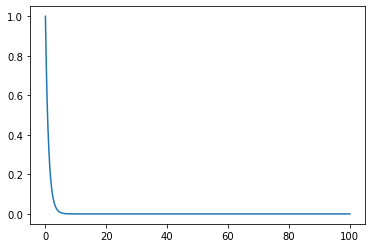

In [141]:
import math
xs = np.arange(0, 100, 0.01)
plt.plot(xs, np.exp(-xs))

## Compute ordered Wassertein Similarities between Labels from a Source uri to a Set of Target Candidates Stored in preds_align_rest

In [281]:
slabel_clnd_uris.columns

Index(['label', 'uri', 'clndLabel'], dtype='object')

In [303]:
preds_align_rest.columns

Index(['source', 'source_label', 'target', 'target_label'], dtype='object')

In [301]:
import math
# compute the Wasserstein similarity between two labels
def compute_wasserstein_similarity(slab, sclnd, clab, cclnd, embs_model):
    '''
        input: slab: source label string
               sclnd: cleaned source label string
               clab: candidate target label string
               cclnd: cleaned candidate target label string
               embs_model: pre-trained model
        output: Wasserstein similrity between the source and target labels
    '''
    wd = -1
    
    if slab in embs_model.wv.key_to_index and clab in embs_model.wv.key_to_index:
        _, wd = maponto.wd_between_labels_raw([slab], [clab], embs_model)
    elif slab in embs_model.wv.key_to_index:
        _, wd = maponto.wd_between_labels_raw([slab], [cclnd], embs_model)
    elif clab in embs_model.wv.key_to_index:
        _, wd = maponto.wd_between_labels_raw([sclnd], [clab], embs_model)
    else:
        # split the cleaned labels into lists of words and the WMD between
        # the two lists of words of the two cleaned labels
        _, wd = maponto.wd_between_labels_raw(sclnd.split(), cclnd.split(), embs_model)
        
    return math.exp(-wd)

In [364]:
%%time
map_tups = []
for suri in preds_align_rest.source.unique():
    slab = slabel_clnd_uris[slabel_clnd_uris.uri==suri].label.iloc[0]
    sclnd = slabel_clnd_uris[slabel_clnd_uris.uri==suri].clndLabel.iloc[0]
    candidates = preds_align_rest[preds_align_rest.source == suri].target
    high_sim = 0.85
    curr_map = ()
    for curi in candidates:
        clab = tlabel_clnd_uris[tlabel_clnd_uris.uri==curi].label.iloc[0]
        cclnd = tlabel_clnd_uris[tlabel_clnd_uris.uri==curi].clndLabel.iloc[0]
        ws = compute_wasserstein_similarity(slab, sclnd, clab, cclnd, embs_model)
        if high_sim < ws:
            high_sim = ws
            curr_map = (suri, slab, curi, clab)
    if len(curr_map) > 0:
        map_tups.append(curr_map)
preds_align_rest_top = pd.DataFrame(map_tups, columns=['source', 'source_label', 'target', 'target_label'])
#preds_align_rest_top

CPU times: user 2min 23s, sys: 2.78 s, total: 2min 26s
Wall time: 18.4 s


In [367]:
preds_align_all = pd.concat([preds_align, preds_align_rest]).reset_index(drop=True)

In [368]:
maponto.evaluate(preds_align_all, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1293
Total number of predicted is 6254
Precision is 0.20674768148385034
Recall is 0.8529023746701847
F1-Measure is 0.3328185328185328


# Conference 2021 Results and WD Distances

In [401]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [15]:
result_folder = "../data/conference/conference2021results/"

In [17]:
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_file_list = {}
case_refs = {}
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        file_list = []
        for file in result_files:
            if file.find(subf) > 0:
                file_list.append(file)
        case_file_list[subf] = file_list
        case_refs[subf] = refs_url

In [18]:
len(case_file_list), len(case_refs)

(21, 21)

In [19]:
case_file_list.keys() == case_refs.keys()

True

In [20]:
eval_lists = []
for case in case_file_list:
    files = case_file_list[case]
    refs_url = case_refs[case]
    for file in files:
        preds = maponto.load_alignments(result_folder + file, file)
        eval = maponto.evaluate_noprint(preds, refs_url)
        eval['case'] = case
        eval['file'] = file
        eval_lists.append(eval)

In [21]:
all_evaluations_df = pd.DataFrame(eval_lists)

In [350]:
all_evaluations_df.to_csv(result_folder + "conference2021results_all_evaluations.csv")

In [22]:
all_evaluations_means = all_evaluations_df.groupby('case').mean()
all_evaluations_means

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  \
case                                                                    
cmt-conference          15.0                 6.357143       12.000000   
cmt-confof              16.0                 6.000000       10.142857   
cmt-edas                13.0                 8.142857       11.500000   
cmt-ekaw                11.0                 5.500000        9.000000   
cmt-iasted               4.0                 4.000000        6.692308   
cmt-sigkdd              12.0                 8.357143       10.357143   
conference-confof       15.0                 9.214286       14.000000   
conference-edas         17.0                 9.384615       18.076923   
conference-ekaw         25.0                11.153846       21.076923   
conference-iasted       14.0                 4.846154        9.153846   
conference-sigkdd       15.0                 9.000000       13.923077   
confof-edas             19.0                10.357143       15.714286   
confof-ekaw             20.0                12.142857       14.785714   
confof-iasted            9.0                 4.714286        7.714286   
confof-sigkdd            7.0                 4.214286        6.857143   
edas-ekaw               23.0                10.214286       20.571429   
edas-iasted             19.0                 7.615385       15.692308   
edas-sigkdd             15.0                 7.428571       11.714286   
ekaw-iasted             10.0                 6.500000       14.357143   
ekaw-sigkdd             11.0                 7.142857       11.714286   
iasted-sigkdd           15.0                11.714286       18.357143   

                   precision    recall        f1  
case                                              
cmt-conference      0.584099  0.423810  0.465064  
cmt-confof          0.694392  0.375000  0.460183  
cmt-edas            0.768623  0.626374  0.677619  
cmt-ekaw            0.676984  0.500000  0.557983  
cmt-iasted          0.667550  1.000000  0.787346  
cmt-sigkdd          0.842984  0.696429  0.743058  
conference-confof   0.762758  0.614286  0.656164  
conference-edas     0.667126  0.552036  0.568496  
conference-ekaw     0.607192  0.446154  0.486938  
conference-iasted   0.641533  0.346154  0.429116  
conference-sigkdd   0.752973  0.600000  0.641236  
confof-edas         0.711593  0.545113  0.596957  
confof-ekaw         0.842366  0.607143  0.689754  
confof-iasted       0.752538  0.523810  0.580385  
confof-sigkdd       0.855159  0.602041  0.679698  
edas-ekaw           0.607413  0.444099  0.483656  
edas-iasted         0.745145  0.400810  0.487972  
edas-sigkdd         0.835815  0.495238  0.592675  
ekaw-iasted         0.682878  0.650000  0.627084  
ekaw-sigkdd         0.769748  0.649351  0.681831  
iasted-sigkdd       0.725873  0.780952  0.735906

In [24]:
# WD between conference ontologies in terms of individual concepts
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_wd = {}
case_index = 0
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        _, wd = maponto.wd_between_labels_raw(slabel_clnd_uris.clndLabel, tlabel_clnd_uris.clndLabel, embs_model)
        case_wd[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245
1 #slabel=(140, 3), #tlabel=(49, 3)
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173
5 #slabel=(103, 3)

In [25]:
case_wd

{'iasted-sigkdd': 0.8294314625830919,
 'confof-sigkdd': 0.8061155506338488,
 'edas-ekaw': 0.8493233494230967,
 'conference-sigkdd': 0.8502134186404776,
 'edas-iasted': 0.8120696701589806,
 'cmt-conference': 0.8463083994959165,
 'cmt-iasted': 0.7694589919862418,
 'cmt-confof': 0.8017811583223582,
 'confof-ekaw': 0.8629764837953465,
 'cmt-sigkdd': 0.8204965585191571,
 'confof-edas': 0.8349821985457984,
 'cmt-ekaw': 0.8173799755124097,
 'conference-confof': 0.8447121756880865,
 'confof-iasted': 0.799177913967028,
 'edas-sigkdd': 0.8276571877595281,
 'conference-iasted': 0.8081492880069728,
 'ekaw-sigkdd': 0.8210149231697171,
 'ekaw-iasted': 0.7956962583192466,
 'conference-edas': 0.857277653555584,
 'cmt-edas': 0.8171228558655874,
 'conference-ekaw': 0.8741720996453702}

## Check the correlationship between WDs and the mean f1-scores of all 2021 mapping tools on conferences

In [385]:
all_evaluations_wd = pd.DataFrame({'case':case_wd.keys(), 'wd':case_wd.values()}).set_index('case').merge(all_evaluations_means, 
                                                                                    left_index=True, right_index=True)

In [363]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='wd', ylabel='f1'>

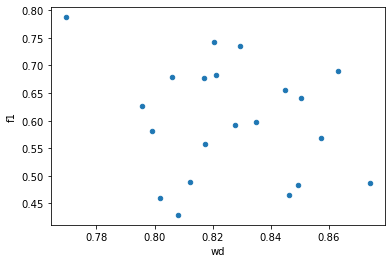

In [386]:
all_evaluations_wd.plot.scatter('wd', 'f1')

<AxesSubplot:xlabel='wd', ylabel='f1'>

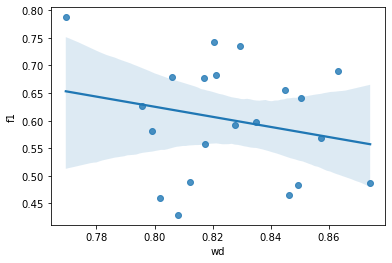

In [387]:
import seaborn as sns
sns.regplot(data=all_evaluations_wd, x='wd', y='f1')

In [388]:
all_evaluations_wd.wd.corr(all_evaluations_wd.f1)

-0.2265669567177459

# Jaccard Similarity between Ontologies

In [26]:
import os
# Jaccard Similarity between conference ontologies
# including concepts and properties
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_jac = {}
case_index = 0
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, 
                                    len(source_graph), len(target_graph)))
        
        refs_df = maponto.load_alignments(refs_url, "refs")
        
        intersection_size = len(refs_df)
        
        union_size = 0
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, 
                                                 tlabel_clnd_uris.shape))
        
        union_size = union_size + len(slabel_clnd_uris) + len(tlabel_clnd_uris)
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        union_size = union_size + len(sobject_domain_range_uris) + len(tobject_domain_range_uris)
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        union_size = union_size + len(sdatatype_domain_uris) + len(tdatatype_domain_uris)
        
        print("intersection_size: {}".format(intersection_size))
        print("union_size: {}".format(union_size))
        
        jacSim = intersection_size / (union_size - intersection_size)

        case_jac[subf]=jacSim
        #case_wd[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
22. len(source_graph)=1173, len(target_graph)=245
22 #slabel=(140, 3), #tlabel=(49, 3)
22. #sobject=(70, 2), #tobject=(15, 2)
22. #sdatatype=(3, 2), #tdatatype=(11, 2)
intersection_size: 15
union_size: 288
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
23. len(source_graph)=539, len(target_graph)=245
23 #slabel=(38, 3), #tlabel=(49, 3)
23. #sobject=(15, 2), #tobject=(15, 2)
23. #sdatatype=(32, 2), #tdatatype=(11, 2)
intersection_size: 7
union_size: 160
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
24. len(source_graph)=1720, len(target_graph)=557
24 #slabel=(103, 3), #tlabel=(73, 3)
24. #sobject=(48, 2), #tobject=(33, 2)
24. #sdatatype=(21, 2), #tdatatype=(0, 2)
intersection_size: 23
union_size: 278
../data/conference/with_referenc

In [27]:
case_jac

{'iasted-sigkdd': 0.054945054945054944,
 'confof-sigkdd': 0.0457516339869281,
 'edas-ekaw': 0.09019607843137255,
 'conference-sigkdd': 0.07772020725388601,
 'edas-iasted': 0.05191256830601093,
 'cmt-conference': 0.07177033492822966,
 'cmt-iasted': 0.013333333333333334,
 'cmt-confof': 0.1,
 'confof-ekaw': 0.11695906432748537,
 'cmt-sigkdd': 0.07792207792207792,
 'confof-edas': 0.07983193277310924,
 'cmt-ekaw': 0.05913978494623656,
 'conference-confof': 0.07389162561576355,
 'confof-iasted': 0.031141868512110725,
 'edas-sigkdd': 0.06465517241379311,
 'conference-iasted': 0.04216867469879518,
 'ekaw-sigkdd': 0.06470588235294118,
 'ekaw-iasted': 0.032362459546925564,
 'conference-edas': 0.059027777777777776,
 'cmt-edas': 0.052,
 'conference-ekaw': 0.11682242990654206}

In [35]:
all_jac = pd.DataFrame({'case':case_jac.keys(), 'jac':case_jac.values()})
all_jac

case       jac
0       iasted-sigkdd  0.054945
1       confof-sigkdd  0.045752
2           edas-ekaw  0.090196
3   conference-sigkdd  0.077720
4         edas-iasted  0.051913
5      cmt-conference  0.071770
6          cmt-iasted  0.013333
7          cmt-confof  0.100000
8         confof-ekaw  0.116959
9          cmt-sigkdd  0.077922
10        confof-edas  0.079832
11           cmt-ekaw  0.059140
12  conference-confof  0.073892
13      confof-iasted  0.031142
14        edas-sigkdd  0.064655
15  conference-iasted  0.042169
16        ekaw-sigkdd  0.064706
17        ekaw-iasted  0.032362
18    conference-edas  0.059028
19           cmt-edas  0.052000
20    conference-ekaw  0.116822

In [28]:
import os
# Jaccard Similarity between conference ontologies
# including only concepts
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_class_jac = {}
case_index = 0
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference_class.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, 
                                    len(source_graph), len(target_graph)))
        
        refs_df = maponto.load_alignments(refs_url, "refs")
        
        intersection_size = len(refs_df)
        
        union_size = 0
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, 
                                                 tlabel_clnd_uris.shape))
        
        union_size = union_size + len(slabel_clnd_uris) + len(tlabel_clnd_uris)
        
        print("intersection_size: {}".format(intersection_size))
        print("union_size: {}".format(union_size))
        
        jacSim = intersection_size / (union_size - intersection_size)

        case_class_jac[subf]=jacSim
        #case_wd[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245
1 #slabel=(140, 3), #tlabel=(49, 3)
intersection_size: 15
union_size: 189
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)
intersection_size: 6
union_size: 87
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)
intersection_size: 19
union_size: 176
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)
intersection_size: 12
union_size: 108
../data/conference/with_references

In [29]:
case_class_jac

{'iasted-sigkdd': 0.08620689655172414,
 'confof-sigkdd': 0.07407407407407407,
 'edas-ekaw': 0.12101910828025478,
 'conference-sigkdd': 0.125,
 'edas-iasted': 0.08482142857142858,
 'cmt-conference': 0.15789473684210525,
 'cmt-iasted': 0.024242424242424242,
 'cmt-confof': 0.17543859649122806,
 'confof-ekaw': 0.21978021978021978,
 'cmt-sigkdd': 0.14705882352941177,
 'confof-edas': 0.11023622047244094,
 'cmt-ekaw': 0.0851063829787234,
 'conference-confof': 0.12790697674418605,
 'confof-iasted': 0.05325443786982249,
 'edas-sigkdd': 0.07801418439716312,
 'conference-iasted': 0.06989247311827956,
 'ekaw-sigkdd': 0.0990990990990991,
 'ekaw-iasted': 0.04926108374384237,
 'conference-edas': 0.0945945945945946,
 'cmt-edas': 0.06451612903225806,
 'conference-ekaw': 0.21100917431192662}

In [36]:
all_class_jac = pd.DataFrame({'case':case_class_jac.keys(), 'jac':case_class_jac.values()})
all_class_jac

case       jac
0       iasted-sigkdd  0.086207
1       confof-sigkdd  0.074074
2           edas-ekaw  0.121019
3   conference-sigkdd  0.125000
4         edas-iasted  0.084821
5      cmt-conference  0.157895
6          cmt-iasted  0.024242
7          cmt-confof  0.175439
8         confof-ekaw  0.219780
9          cmt-sigkdd  0.147059
10        confof-edas  0.110236
11           cmt-ekaw  0.085106
12  conference-confof  0.127907
13      confof-iasted  0.053254
14        edas-sigkdd  0.078014
15  conference-iasted  0.069892
16        ekaw-sigkdd  0.099099
17        ekaw-iasted  0.049261
18    conference-edas  0.094595
19           cmt-edas  0.064516
20    conference-ekaw  0.211009

# WD between Two Ontologies in Individual Concepts

In [30]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [31]:
# WD between conference ontologies in terms of individual concepts
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_ws_concepts = {}
case_index = 0
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference_class.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        case_index = case_index + 1
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        _, wd = maponto.wd_between_labels_raw(slabel_clnd_uris.clndLabel, tlabel_clnd_uris.clndLabel, embs_model)
        case_ws_concepts[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
21. len(source_graph)=1173, len(target_graph)=245
21 #slabel=(140, 3), #tlabel=(49, 3)
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
21. len(source_graph)=539, len(target_graph)=245
21 #slabel=(38, 3), #tlabel=(49, 3)
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
21. len(source_graph)=1720, len(target_graph)=557
21 #slabel=(103, 3), #tlabel=(73, 3)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
21. len(source_graph)=639, len(target_graph)=245
21 #slabel=(59, 3), #tlabel=(49, 3)
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
21. len(source_graph)=1720, len(target_graph)=1173
21 #slabe

In [33]:
case_ws_concepts

{'iasted-sigkdd': 0.8294314625830919,
 'confof-sigkdd': 0.8061155506338488,
 'edas-ekaw': 0.8493233494230967,
 'conference-sigkdd': 0.8502134186404776,
 'edas-iasted': 0.8120696701589806,
 'cmt-conference': 0.8463083994959165,
 'cmt-iasted': 0.7694589919862418,
 'cmt-confof': 0.8017811583223582,
 'confof-ekaw': 0.8629764837953465,
 'cmt-sigkdd': 0.8204965585191571,
 'confof-edas': 0.8349821985457984,
 'cmt-ekaw': 0.8173799755124097,
 'conference-confof': 0.8447121756880865,
 'confof-iasted': 0.799177913967028,
 'edas-sigkdd': 0.8276571877595281,
 'conference-iasted': 0.8081492880069728,
 'ekaw-sigkdd': 0.8210149231697171,
 'ekaw-iasted': 0.7956962583192466,
 'conference-edas': 0.857277653555584,
 'cmt-edas': 0.8171228558655874,
 'conference-ekaw': 0.8741720996453702}

In [34]:
all_ws_concepts = pd.DataFrame({'case':case_ws_concepts.keys(), 'ws':case_ws_concepts.values()})
all_ws_concepts

case        ws
0       iasted-sigkdd  0.829431
1       confof-sigkdd  0.806116
2           edas-ekaw  0.849323
3   conference-sigkdd  0.850213
4         edas-iasted  0.812070
5      cmt-conference  0.846308
6          cmt-iasted  0.769459
7          cmt-confof  0.801781
8         confof-ekaw  0.862976
9          cmt-sigkdd  0.820497
10        confof-edas  0.834982
11           cmt-ekaw  0.817380
12  conference-confof  0.844712
13      confof-iasted  0.799178
14        edas-sigkdd  0.827657
15  conference-iasted  0.808149
16        ekaw-sigkdd  0.821015
17        ekaw-iasted  0.795696
18    conference-edas  0.857278
19           cmt-edas  0.817123
20    conference-ekaw  0.874172

In [39]:
all_ws_concepts_jac = all_ws_concepts.merge(all_jac)
all_ws_concepts_jac

case        ws       jac
0       iasted-sigkdd  0.829431  0.054945
1       confof-sigkdd  0.806116  0.045752
2           edas-ekaw  0.849323  0.090196
3   conference-sigkdd  0.850213  0.077720
4         edas-iasted  0.812070  0.051913
5      cmt-conference  0.846308  0.071770
6          cmt-iasted  0.769459  0.013333
7          cmt-confof  0.801781  0.100000
8         confof-ekaw  0.862976  0.116959
9          cmt-sigkdd  0.820497  0.077922
10        confof-edas  0.834982  0.079832
11           cmt-ekaw  0.817380  0.059140
12  conference-confof  0.844712  0.073892
13      confof-iasted  0.799178  0.031142
14        edas-sigkdd  0.827657  0.064655
15  conference-iasted  0.808149  0.042169
16        ekaw-sigkdd  0.821015  0.064706
17        ekaw-iasted  0.795696  0.032362
18    conference-edas  0.857278  0.059028
19           cmt-edas  0.817123  0.052000
20    conference-ekaw  0.874172  0.116822

In [40]:
all_ws_concepts_jac.ws.corr(all_ws_concepts_jac.jac)

0.7722578833565305

<AxesSubplot:xlabel='jac', ylabel='ws'>

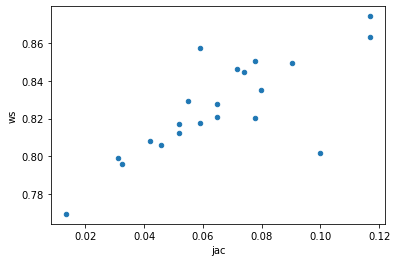

In [49]:
all_ws_concepts_jac.plot.scatter('jac', 'ws')

In [97]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

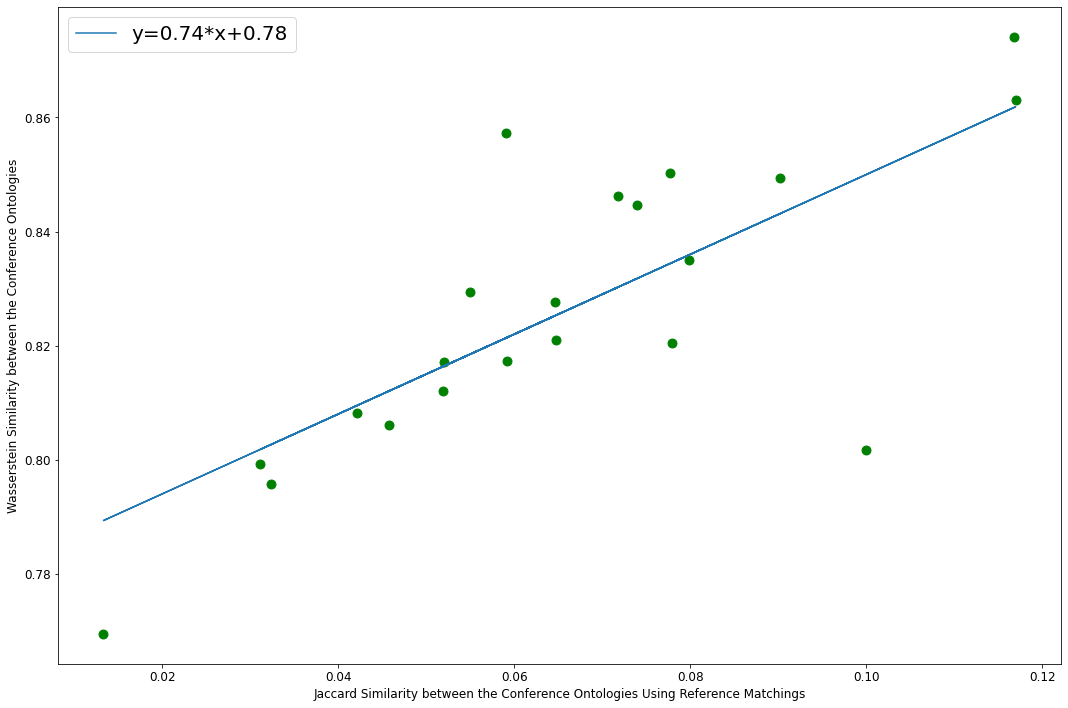

In [83]:
plt.figure(figsize=(15, 10))
plt.scatter(all_ws_concepts_jac.jac, all_ws_concepts_jac.ws, 
            marker='o', c='g', s=80)
x = all_ws_concepts_jac.jac
plt.plot(x, 0.7*x + 0.78, label="y={}*x+{}".format(0.74, 0.78)) 
plt.xlabel("Jaccard Similarity between the Conference Ontologies Using Reference Matchings")
plt.ylabel("Wasserstein Similarity between the Conference Ontologies")
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()

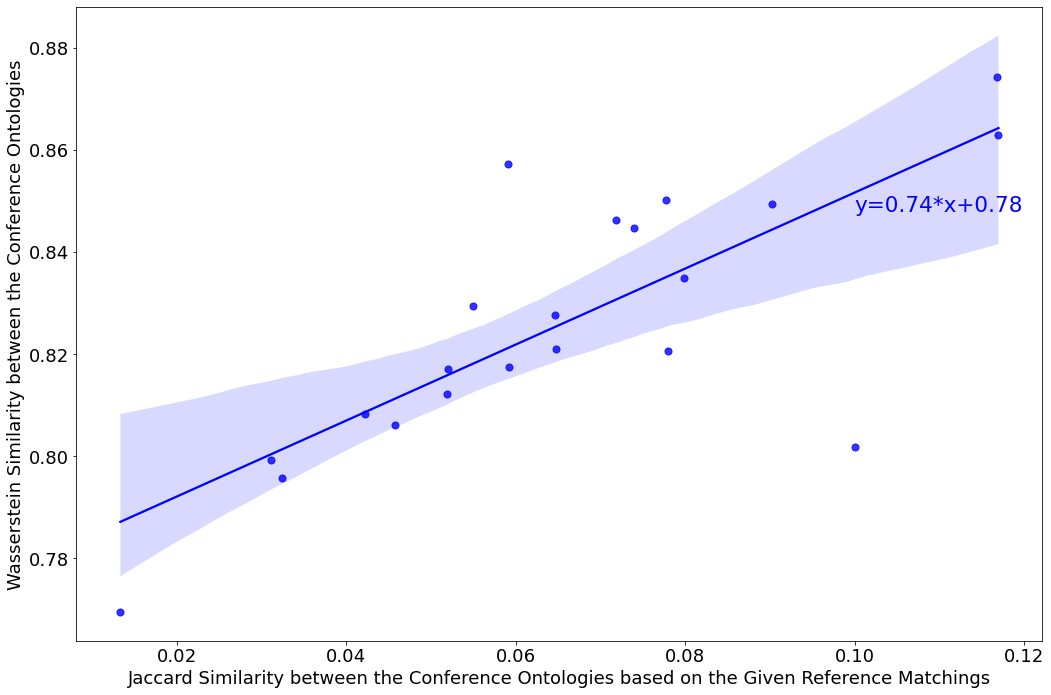

In [101]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.regplot(data=all_ws_concepts_jac, x='jac', y='ws', 
           marker='o', color='blue', scatter_kws={'s':50},
           label="y={}*x+{}".format(0.74, 0.78))
plt.xlabel("Jaccard Similarity between the Conference Ontologies based on the Given Reference Matchings")
plt.ylabel("Wasserstein Similarity between the Conference Ontologies")
#plt.legend(loc='upper left', fontsize=20)
plt.text(0.1, 0.848, "y={}*x+{}".format(0.74, 0.78), size='large', color='blue', weight='normal')
plt.tight_layout()
plt.savefig("../data/conference/with_references/wd_jac_regplot.pdf")

In [44]:
np.polyfit(all_ws_concepts_jac.jac, all_ws_concepts_jac.ws, 1)

array([0.744408  , 0.77719144])

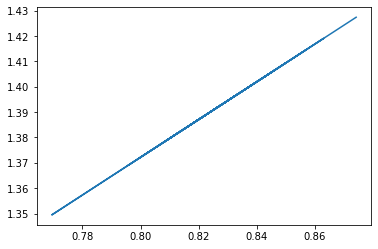

In [45]:
x = all_ws_concepts_jac.ws
plt.plot(x, 0.744*x + 0.777) 

# WD between Two Ontologies in Individual Concepts and Properties

In [403]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [525]:
# WD between conference ontologies in terms of individual concepts
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_ws_concepts_properties = {}
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        union_size = union_size + len(sobject_domain_range_uris) + len(tobject_domain_range_uris)
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        slabels = slabel_clnd_uris.clndLabel.tolist()
        sobject_labels = sobject_domain_range_uris.label.map(maponto.clean_document_lower).map(lambda x: " ".join(x))
        sdatatype_labels = sdatatype_domain_uris.label.map(maponto.clean_document_lower).map(lambda x: " ".join(x))
        slabels.extend(sobject_labels.tolist())
        slabels.extend(sdatatype_labels.tolist())
        
        tlabels = tlabel_clnd_uris.clndLabel.tolist()
        tobject_labels = tobject_domain_range_uris.label.map(maponto.clean_document_lower).map(lambda x: " ".join(x))
        tdatatype_labels = tdatatype_domain_uris.label.map(maponto.clean_document_lower).map(lambda x: " ".join(x))
        tlabels.extend(tobject_labels.tolist())
        tlabels.extend(tdatatype_labels.tolist())
        
        _, wd = maponto.wd_between_labels_raw(slabels, tlabels, embs_model)
        case_ws_concepts_properties[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
0. len(source_graph)=1173, len(target_graph)=245
0 #slabel=(140, 3), #tlabel=(49, 3)
0. #sobject=(70, 2), #tobject=(15, 2)
0. #sdatatype=(3, 2), #tdatatype=(11, 2)
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
0. len(source_graph)=539, len(target_graph)=245
0 #slabel=(38, 3), #tlabel=(49, 3)
0. #sobject=(15, 2), #tobject=(15, 2)
0. #sdatatype=(32, 2), #tdatatype=(11, 2)
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
0. len(source_graph)=1720, len(target_graph)=557
0 #slabel=(103, 3), #tlabel=(73, 3)
0. #sobject=(48, 2), #tobject=(33, 2)
0. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
0. len(source_graph)=639, len

In [526]:
case_ws_concepts_properties

{'iasted-sigkdd': 0.8376155810714833,
 'confof-sigkdd': 0.8270420081967154,
 'edas-ekaw': 0.8825460657045485,
 'conference-sigkdd': 0.8583647053939681,
 'edas-iasted': 0.842496401483187,
 'cmt-conference': 0.8899344029759699,
 'cmt-iasted': 0.8205007543757347,
 'cmt-confof': 0.848207530097479,
 'confof-ekaw': 0.881071048140771,
 'cmt-sigkdd': 0.848994132071413,
 'confof-edas': 0.8742407533938271,
 'cmt-ekaw': 0.8689966734237764,
 'conference-confof': 0.8642595677730341,
 'confof-iasted': 0.8400707204738967,
 'edas-sigkdd': 0.8458657902137382,
 'conference-iasted': 0.8308984092248264,
 'ekaw-sigkdd': 0.8310133224810109,
 'ekaw-iasted': 0.8235917272052105,
 'conference-edas': 0.8807375312913032,
 'cmt-edas': 0.871057038663656,
 'conference-ekaw': 0.8848039123216301}

In [527]:
all_ws_concepts_properties = pd.DataFrame({'case':case_ws_concepts_properties.keys(), 'ws':case_ws_concepts_properties.values()})
all_ws_concepts_properties

case        ws
0       iasted-sigkdd  0.837616
1       confof-sigkdd  0.827042
2           edas-ekaw  0.882546
3   conference-sigkdd  0.858365
4         edas-iasted  0.842496
5      cmt-conference  0.889934
6          cmt-iasted  0.820501
7          cmt-confof  0.848208
8         confof-ekaw  0.881071
9          cmt-sigkdd  0.848994
10        confof-edas  0.874241
11           cmt-ekaw  0.868997
12  conference-confof  0.864260
13      confof-iasted  0.840071
14        edas-sigkdd  0.845866
15  conference-iasted  0.830898
16        ekaw-sigkdd  0.831013
17        ekaw-iasted  0.823592
18    conference-edas  0.880738
19           cmt-edas  0.871057
20    conference-ekaw  0.884804

In [528]:
all_ws_concepts_properties_jac = all_ws_concepts_properties.merge(all_jac)
all_ws_concepts_properties_jac

case        ws       jac
0       iasted-sigkdd  0.837616  0.054945
1       confof-sigkdd  0.827042  0.045752
2           edas-ekaw  0.882546  0.090196
3   conference-sigkdd  0.858365  0.077720
4         edas-iasted  0.842496  0.051913
5      cmt-conference  0.889934  0.071770
6          cmt-iasted  0.820501  0.013333
7          cmt-confof  0.848208  0.100000
8         confof-ekaw  0.881071  0.116959
9          cmt-sigkdd  0.848994  0.077922
10        confof-edas  0.874241  0.079832
11           cmt-ekaw  0.868997  0.059140
12  conference-confof  0.864260  0.073892
13      confof-iasted  0.840071  0.031142
14        edas-sigkdd  0.845866  0.064655
15  conference-iasted  0.830898  0.042169
16        ekaw-sigkdd  0.831013  0.064706
17        ekaw-iasted  0.823592  0.032362
18    conference-edas  0.880738  0.059028
19           cmt-edas  0.871057  0.052000
20    conference-ekaw  0.884804  0.116822

In [529]:
all_ws_concepts_properties_jac.ws.corr(all_ws_concepts_properties_jac.jac)

0.6877238033788203

<AxesSubplot:xlabel='jac', ylabel='ws'>

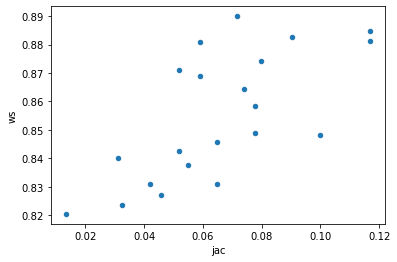

In [530]:
all_ws_concepts_properties_jac.plot.scatter('jac', 'ws')

<AxesSubplot:xlabel='jac', ylabel='ws'>

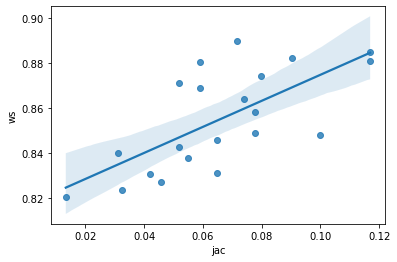

In [562]:
sns.regplot(data=all_ws_concepts_properties_jac, x='jac', y='ws')

In [563]:
np.polyfit(all_ws_concepts_properties_jac.jac, all_ws_concepts_properties_jac.ws, 1)

array([0.57982864, 0.81687211])

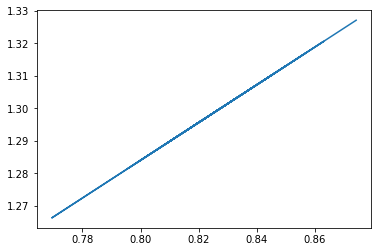

In [564]:
x = all_ws_concepts_jac.ws
plt.plot(x, 0.58*x + 0.82) 

# WD between Two Ontologies in Triples of Individual SPO

In [393]:
source_url = conf_folder + "/conference-iasted/source.rdf"
target_url = conf_folder + '/conference-iasted/target.rdf'
refs_url = conf_folder + '/conference-iasted/reference.rdf'

In [396]:
# extract RDF graphs forom rdf files
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
#time.sleep(0.5)
print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
## Find matchings between classes
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
# extract relation edges
sedges = maponto.build_relation_graph_edges_nocomments_df(source_graph)
tedges = maponto.build_relation_graph_edges_nocomments_df(target_graph)
print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))

../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
0. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(315, 4)


In [397]:
sedges

subject  \
0        http://conference#Conference_volume   
1                   http://conference#Person   
2                   http://conference#Person   
3        http://conference#Review_preference   
4          http://conference#Important_dates   
..                                       ...   
111           http://conference#Invited_talk   
112      http://conference#Extended_abstract   
113                  http://conference#Paper   
114  http://conference#Registeered_applicant   
115  http://conference#Reviewed_contribution   

                                            predicate              property  \
0                    http://conference#has_a_location  owl:DataTypeProperty   
1                      http://conference#has_an_email  owl:DataTypeProperty   
2                http://conference#has_the_first_name  owl:DataTypeProperty   
3                      http://conference#has_a_degree  owl:DataTypeProperty   
4    http://conference#is_an_abstract_submission_date  owl:DataTypeProperty   
..                                                ...                   ...   
111                                   rdfs:subClassOf                  None   
112                                   rdfs:subClassOf                  None   
113                                   rdfs:subClassOf                  None   
114                                   rdfs:subClassOf                  None   
115                                   rdfs:subClassOf                  None   

                                       object  
0     http://www.w3.org/2001/XMLSchema#string  
1     http://www.w3.org/2001/XMLSchema#string  
2     http://www.w3.org/2001/XMLSchema#string  
3        http://www.w3.org/2001/XMLSchema#int  
4       http://www.w3.org/2001/XMLSchema#date  
..                                        ...  
111            http://conference#Presentation  
112    http://conference#Regular_contribution  
113    http://conference#Regular_contribution  
114    http://conference#Conference_applicant  
115  http://conference#Submitted_contribution  

[116 rows x 4 columns]

In [399]:
sedges_2steps = sedges.merge(sedges, left_on='object', right_on='subject')
sedges_2steps

subject_x  \
0         http://conference#Review_expertise   
1         http://conference#Review_expertise   
2         http://conference#Review_expertise   
3         http://conference#Review_expertise   
4         http://conference#Review_expertise   
..                                       ...   
294   http://conference#Early_paid_applicant   
295         http://conference#Paid_applicant   
296      http://conference#Extended_abstract   
297                  http://conference#Paper   
298  http://conference#Registeered_applicant   

                                        predicate_x          property_x  \
0    http://conference#has_a_submitted_contribution         rdfs:domain   
1    http://conference#has_a_submitted_contribution         rdfs:domain   
2    http://conference#has_a_submitted_contribution         rdfs:domain   
3    http://conference#has_a_submitted_contribution         rdfs:domain   
4    http://conference#has_a_submitted_contribution  owl:someValuesFrom   
..                                              ...                 ...   
294                                 rdfs:subClassOf                None   
295                                 rdfs:subClassOf                None   
296                                 rdfs:subClassOf                None   
297                                 rdfs:subClassOf                None   
298                                 rdfs:subClassOf                None   

                                     object_x  \
0    http://conference#Submitted_contribution   
1    http://conference#Submitted_contribution   
2    http://conference#Submitted_contribution   
3    http://conference#Submitted_contribution   
4    http://conference#Submitted_contribution   
..                                        ...   
294          http://conference#Paid_applicant   
295   http://conference#Registeered_applicant   
296    http://conference#Regular_contribution   
297    http://conference#Regular_contribution   
298    http://conference#Conference_applicant   

                                    subject_y  \
0    http://conference#Submitted_contribution   
1    http://conference#Submitted_contribution   
2    http://conference#Submitted_contribution   
3    http://conference#Submitted_contribution   
4    http://conference#Submitted_contribution   
..                                        ...   
294          http://conference#Paid_applicant   
295   http://conference#Registeered_applicant   
296    http://conference#Regular_contribution   
297    http://conference#Regular_contribution   
298    http://conference#Conference_applicant   

                                  predicate_y   property_y  \
0    http://conference#has_a_review_expertise  rdfs:domain   
1                             rdfs:subClassOf         None   
2    http://conference#has_a_review_expertise  rdfs:domain   
3                             rdfs:subClassOf         None   
4    http://conference#has_a_review_expertise  rdfs:domain   
..                                        ...          ...   
294                           rdfs:subClassOf         None   
295                           rdfs:subClassOf         None   
296                           rdfs:subClassOf         None   
297                           rdfs:subClassOf         None   
298                           rdfs:subClassOf         None   

                                    object_y  
0         http://conference#Review_expertise  
1     http://conference#Written_contribution  
2         http://conference#Review_expertise  
3     http://conference#Written_contribution  
4         http://conference#Review_expertise  
..                                       ...  
294  http://conference#Registeered_applicant  
295   http://conference#Conference_applicant  
296   http://conference#Written_contribution  
297   http://conference#Written_contribution  
298                 http://conference#Person  

[299 rows x 8 columns]

In [400]:
sedges_3steps = sedges_2steps.merge(sedges, left_on='object_y', right_on='subject')
sedges_3steps

subject_x  \
0        http://conference#Review_expertise   
1        http://conference#Review_expertise   
2        http://conference#Review_expertise   
3        http://conference#Review_expertise   
4        http://conference#Review_expertise   
..                                      ...   
827             http://conference#Publisher   
828              http://conference#Abstract   
829   http://conference#Late_paid_applicant   
830  http://conference#Early_paid_applicant   
831        http://conference#Paid_applicant   

                                        predicate_x   property_x  \
0    http://conference#has_a_submitted_contribution  rdfs:domain   
1    http://conference#has_a_submitted_contribution  rdfs:domain   
2    http://conference#has_a_submitted_contribution  rdfs:domain   
3    http://conference#has_a_submitted_contribution  rdfs:domain   
4    http://conference#has_a_submitted_contribution  rdfs:domain   
..                                              ...          ...   
827                        http://conference#issues  rdfs:domain   
828                                 rdfs:subClassOf         None   
829                                 rdfs:subClassOf         None   
830                                 rdfs:subClassOf         None   
831                                 rdfs:subClassOf         None   

                                     object_x  \
0    http://conference#Submitted_contribution   
1    http://conference#Submitted_contribution   
2    http://conference#Submitted_contribution   
3    http://conference#Submitted_contribution   
4    http://conference#Submitted_contribution   
..                                        ...   
827  http://conference#Conference_proceedings   
828       http://conference#Extended_abstract   
829          http://conference#Paid_applicant   
830          http://conference#Paid_applicant   
831   http://conference#Registeered_applicant   

                                    subject_y  \
0    http://conference#Submitted_contribution   
1    http://conference#Submitted_contribution   
2    http://conference#Submitted_contribution   
3    http://conference#Submitted_contribution   
4    http://conference#Submitted_contribution   
..                                        ...   
827  http://conference#Conference_proceedings   
828       http://conference#Extended_abstract   
829          http://conference#Paid_applicant   
830          http://conference#Paid_applicant   
831   http://conference#Registeered_applicant   

                                  predicate_y   property_y  \
0    http://conference#has_a_review_expertise  rdfs:domain   
1    http://conference#has_a_review_expertise  rdfs:domain   
2    http://conference#has_a_review_expertise  rdfs:domain   
3    http://conference#has_a_review_expertise  rdfs:domain   
4    http://conference#has_a_review_expertise  rdfs:domain   
..                                        ...          ...   
827         http://conference#has_a_publisher  rdfs:domain   
828                           rdfs:subClassOf         None   
829                           rdfs:subClassOf         None   
830                           rdfs:subClassOf         None   
831                           rdfs:subClassOf         None   

                                    object_y  \
0         http://conference#Review_expertise   
1         http://conference#Review_expertise   
2         http://conference#Review_expertise   
3         http://conference#Review_expertise   
4         http://conference#Review_expertise   
..                                       ...   
827              http://conference#Publisher   
828   http://conference#Regular_contribution   
829  http://conference#Registeered_applicant   
830  http://conference#Registeered_applicant   
831   http://conference#Conference_applicant   

                                     subject  \
0         http://conference#Review_expertise   
1         http://conference#Review_expertise   
2       

In [403]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [407]:
striples = maponto.get_all_triples(sedges)
ttriples = maponto.get_all_triples(tedges)

In [411]:
len(striples), len(ttriples)

(115, 309)

In [493]:
striples[:5]

[('conference volume', 'location', 'string'),
 ('person', 'email', 'string'),
 ('person', 'first name', 'string'),
 ('review preference', 'degree', 'int'),
 ('important dates', 'abstract submission date', 'date')]

In [544]:
" ".join(striples[0])

'conference volume location string'

In [408]:
sembedding_tuples = maponto.convert_label_embedding_tuples(striples, embs_model)
tembedding_tuples = maponto.convert_label_embedding_tuples(ttriples, embs_model)

In [410]:
wd_costs_arr = maponto.compute_wd_matrix_embedding_tuples_raw(sembedding_tuples, tembedding_tuples)

In [412]:
wd_costs_arr.shape

(115, 309)

In [415]:
wd_costs_arr.min(), wd_costs_arr.max()

(0.010317474603652954, 1.4433589180310566)

In [413]:
wd_costs_arr_norm = wd_costs_arr/wd_costs_arr.max()

In [414]:
wd_costs_arr_norm.min(), wd_costs_arr_norm.max()

(0.007148239065670119, 1.0)

In [418]:
a = np.ones((wd_costs_arr.shape[0],)) / wd_costs_arr.shape[0]
b = np.ones((wd_costs_arr.shape[1],)) / wd_costs_arr.shape[1]

wd = ot.emd2(a, b, wd_costs_arr)
wd

0.22641429013642214

In [419]:
a = np.ones((wd_costs_arr_norm.shape[0],)) / wd_costs_arr_norm.shape[0]
b = np.ones((wd_costs_arr_norm.shape[1],)) / wd_costs_arr_norm.shape[1]

wd = ot.emd2(a, b, wd_costs_arr_norm)
wd

0.15686624255960052

In [249]:
np.exp(-wd)

0.6589175735139909

In [565]:
# WD between conference ontologies in terms of triples
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_wd = {}
case_ws = {}
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_nocomments_df(source_graph)
        tedges = maponto.build_relation_graph_edges_nocomments_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        striples = maponto.get_all_triples(sedges)
        ttriples = maponto.get_all_triples(tedges)
        
        sembedding_tuples = maponto.convert_label_embedding_tuples(striples, embs_model)
        tembedding_tuples = maponto.convert_label_embedding_tuples(ttriples, embs_model)
        
        wd_costs_arr = maponto.compute_wd_matrix_embedding_tuples_raw(sembedding_tuples, tembedding_tuples)
        
        a = np.ones((wd_costs_arr.shape[0],)) / wd_costs_arr.shape[0]
        b = np.ones((wd_costs_arr.shape[1],)) / wd_costs_arr.shape[1]

        wd = ot.emd2(a, b, wd_costs_arr)

        case_wd[subf]=wd
        case_ws[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
0. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(315, 4), #tedges=(83, 4)
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....


0. len(source_graph)=539, len(target_graph)=245
0 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(83, 4)
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
0. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(134, 4), #tedges=(102, 4)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
0. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(83, 4)
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
0. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(134, 4), #tedges=(315, 4)
../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....


0. len(source_graph)=412, len(target_graph)=639
0 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(116, 4)
../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
0. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(315, 4)
../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf
0. len(source_graph)=412, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(106, 4)
../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
0. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(102, 4)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
0. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(83, 4)
../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
0. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(134, 4)
../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....


0. len(source_graph)=412, len(target_graph)=557
0 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(102, 4)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
0. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(106, 4)
../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
0. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(315, 4)
../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
0. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(134, 4), #tedges=(83, 4)
../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
0. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(315, 4)
../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
0. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(102, 4), #tedges=(83, 4)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
0. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(102, 4), #tedges=(315, 4)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
0. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(134, 4)
../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
0. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(134, 4)
../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
0. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(102, 4)


In [566]:
case_ws

{'iasted-sigkdd': 0.7962227799300041,
 'confof-sigkdd': 0.7071302610024872,
 'edas-ekaw': 0.8414803744381233,
 'conference-sigkdd': 0.8225006595216539,
 'edas-iasted': 0.7299809489828986,
 'cmt-conference': 0.7464421587214551,
 'cmt-iasted': 0.6697508052368732,
 'cmt-confof': 0.7782934182204883,
 'confof-ekaw': 0.7783980632506947,
 'cmt-sigkdd': 0.7034079885590612,
 'confof-edas': 0.7977739117057132,
 'cmt-ekaw': 0.7600921035164854,
 'conference-confof': 0.735054066893359,
 'confof-iasted': 0.6892279705574393,
 'edas-sigkdd': 0.7664606898758595,
 'conference-iasted': 0.7973876833737544,
 'ekaw-sigkdd': 0.7640170360522375,
 'ekaw-iasted': 0.7406928103076477,
 'conference-edas': 0.7825040703722324,
 'cmt-edas': 0.7704635838129799,
 'conference-ekaw': 0.7889385036026338}

In [567]:
all_ws = pd.DataFrame({'case':case_ws.keys(), 'ws':case_ws.values()})
all_ws

case        ws
0       iasted-sigkdd  0.796223
1       confof-sigkdd  0.707130
2           edas-ekaw  0.841480
3   conference-sigkdd  0.822501
4         edas-iasted  0.729981
5      cmt-conference  0.746442
6          cmt-iasted  0.669751
7          cmt-confof  0.778293
8         confof-ekaw  0.778398
9          cmt-sigkdd  0.703408
10        confof-edas  0.797774
11           cmt-ekaw  0.760092
12  conference-confof  0.735054
13      confof-iasted  0.689228
14        edas-sigkdd  0.766461
15  conference-iasted  0.797388
16        ekaw-sigkdd  0.764017
17        ekaw-iasted  0.740693
18    conference-edas  0.782504
19           cmt-edas  0.770464
20    conference-ekaw  0.788939

In [568]:
all_ws_jac = all_ws.merge(all_jac)
all_ws_jac

case        ws       jac
0       iasted-sigkdd  0.796223  0.054945
1       confof-sigkdd  0.707130  0.045752
2           edas-ekaw  0.841480  0.090196
3   conference-sigkdd  0.822501  0.077720
4         edas-iasted  0.729981  0.051913
5      cmt-conference  0.746442  0.071770
6          cmt-iasted  0.669751  0.013333
7          cmt-confof  0.778293  0.100000
8         confof-ekaw  0.778398  0.116959
9          cmt-sigkdd  0.703408  0.077922
10        confof-edas  0.797774  0.079832
11           cmt-ekaw  0.760092  0.059140
12  conference-confof  0.735054  0.073892
13      confof-iasted  0.689228  0.031142
14        edas-sigkdd  0.766461  0.064655
15  conference-iasted  0.797388  0.042169
16        ekaw-sigkdd  0.764017  0.064706
17        ekaw-iasted  0.740693  0.032362
18    conference-edas  0.782504  0.059028
19           cmt-edas  0.770464  0.052000
20    conference-ekaw  0.788939  0.116822

In [569]:
all_ws_jac.ws.corr(all_ws_jac.jac)

0.5617159710524288

<AxesSubplot:xlabel='jac', ylabel='ws'>

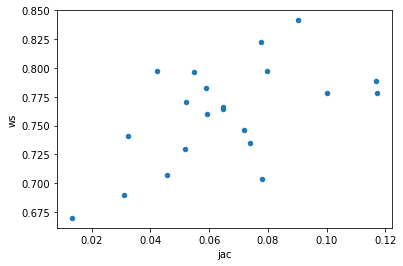

In [570]:
all_ws_jac.plot.scatter('jac', 'ws')

<AxesSubplot:xlabel='jac', ylabel='ws'>

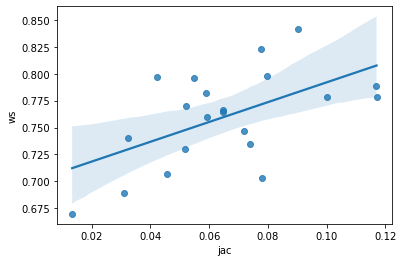

In [571]:
sns.regplot(data=all_ws_jac, x='jac', y='ws')

In [572]:
np.polyfit(all_ws_jac.jac, all_ws_jac.ws, 1)

array([0.92014577, 0.69999343])

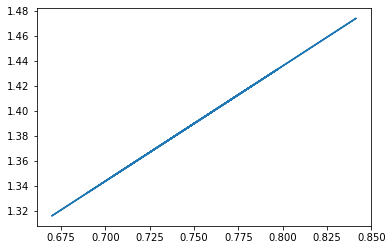

In [573]:
x = all_ws_jac.ws
plt.plot(x, 0.92*x + 0.70) 

# WD between Two Ontologies in Triples of Averaged SPO

In [403]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [546]:
# WD between conference ontologies in terms of triples of averaged SPO embeddings
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
result_files = os.listdir(result_folder)
case_refs = {}
case_ws_averaged = {}
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_refs[subf] = refs_url
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_nocomments_df(source_graph)
        tedges = maponto.build_relation_graph_edges_nocomments_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        striples = maponto.get_all_triples(sedges)
        ttriples = maponto.get_all_triples(tedges)
        
        striples_labels = [" ".join(t) for t in striples]
        ttriples_labels = [" ".join(t) for t in ttriples]
        
        _, wd = maponto.wd_between_labels_raw(striples_labels, ttriples_labels, embs_model)

        case_ws_averaged[subf] = np.exp(-wd)
        

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
0. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(315, 4), #tedges=(83, 4)
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....


0. len(source_graph)=539, len(target_graph)=245
0 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(83, 4)
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
0. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(134, 4), #tedges=(102, 4)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
0. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(83, 4)
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
0. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(134, 4), #tedges=(315, 4)
../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....


0. len(source_graph)=412, len(target_graph)=639
0 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(116, 4)
../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
0. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(315, 4)
../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....


0. len(source_graph)=412, len(target_graph)=539
0 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(106, 4)
../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
0. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(102, 4)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
0. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(83, 4)
../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
0. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(134, 4)
../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
0. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(102, 4)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
0. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(106, 4)
../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
0. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(106, 4), #tedges=(315, 4)
../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
0. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(134, 4), #tedges=(83, 4)
../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
0. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....


0 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(315, 4)
../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
0. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(102, 4), #tedges=(83, 4)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
0. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(102, 4), #tedges=(315, 4)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
0. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(134, 4)
../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
0. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(94, 4), #tedges=(134, 4)
../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
0. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(102, 4)


In [547]:
case_ws_averaged

{'iasted-sigkdd': 0.9178876618624674,
 'confof-sigkdd': 0.8905462938001802,
 'edas-ekaw': 0.9257726225834981,
 'conference-sigkdd': 0.920510502192145,
 'edas-iasted': 0.9037708087580771,
 'cmt-conference': 0.9185968751672584,
 'cmt-iasted': 0.8830428952972451,
 'cmt-confof': 0.9108792954390168,
 'confof-ekaw': 0.9228583332888772,
 'cmt-sigkdd': 0.894768897138326,
 'confof-edas': 0.9238853714324687,
 'cmt-ekaw': 0.9123417433257867,
 'conference-confof': 0.9058603427686467,
 'confof-iasted': 0.8908115791780399,
 'edas-sigkdd': 0.9049696801599093,
 'conference-iasted': 0.9192505766334464,
 'ekaw-sigkdd': 0.9001005314704982,
 'ekaw-iasted': 0.9020628015231623,
 'conference-edas': 0.9223881801355298,
 'cmt-edas': 0.9108658442332743,
 'conference-ekaw': 0.9237397686159304}

In [548]:
all_ws_averaged = pd.DataFrame({'case':case_ws_averaged.keys(), 'ws':case_ws_averaged.values()})
all_ws_averaged

case        ws
0       iasted-sigkdd  0.917888
1       confof-sigkdd  0.890546
2           edas-ekaw  0.925773
3   conference-sigkdd  0.920511
4         edas-iasted  0.903771
5      cmt-conference  0.918597
6          cmt-iasted  0.883043
7          cmt-confof  0.910879
8         confof-ekaw  0.922858
9          cmt-sigkdd  0.894769
10        confof-edas  0.923885
11           cmt-ekaw  0.912342
12  conference-confof  0.905860
13      confof-iasted  0.890812
14        edas-sigkdd  0.904970
15  conference-iasted  0.919251
16        ekaw-sigkdd  0.900101
17        ekaw-iasted  0.902063
18    conference-edas  0.922388
19           cmt-edas  0.910866
20    conference-ekaw  0.923740

In [549]:
all_ws_averaged_jac = all_ws_averaged.merge(all_jac)
all_ws_averaged_jac

case        ws       jac
0       iasted-sigkdd  0.917888  0.054945
1       confof-sigkdd  0.890546  0.045752
2           edas-ekaw  0.925773  0.090196
3   conference-sigkdd  0.920511  0.077720
4         edas-iasted  0.903771  0.051913
5      cmt-conference  0.918597  0.071770
6          cmt-iasted  0.883043  0.013333
7          cmt-confof  0.910879  0.100000
8         confof-ekaw  0.922858  0.116959
9          cmt-sigkdd  0.894769  0.077922
10        confof-edas  0.923885  0.079832
11           cmt-ekaw  0.912342  0.059140
12  conference-confof  0.905860  0.073892
13      confof-iasted  0.890812  0.031142
14        edas-sigkdd  0.904970  0.064655
15  conference-iasted  0.919251  0.042169
16        ekaw-sigkdd  0.900101  0.064706
17        ekaw-iasted  0.902063  0.032362
18    conference-edas  0.922388  0.059028
19           cmt-edas  0.910866  0.052000
20    conference-ekaw  0.923740  0.116822

In [550]:
all_ws_averaged_jac.ws.corr(all_ws_averaged_jac.jac)

0.6416045536896209

<AxesSubplot:xlabel='jac', ylabel='ws'>

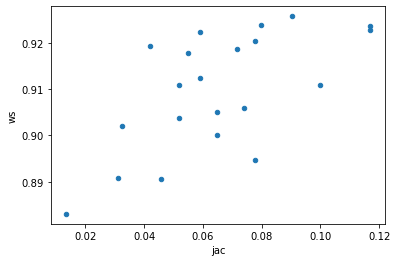

In [551]:
all_ws_averaged_jac.plot.scatter('jac', 'ws')

<AxesSubplot:xlabel='jac', ylabel='ws'>

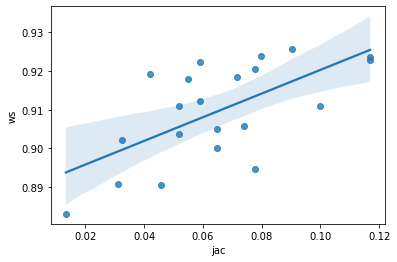

In [555]:
sns.regplot(data=all_ws_averaged_jac, x='jac', y='ws')

In [557]:
np.polyfit(all_ws_averaged_jac.jac, all_ws_averaged_jac.ws, 1)

array([0.30625324, 0.88968701])

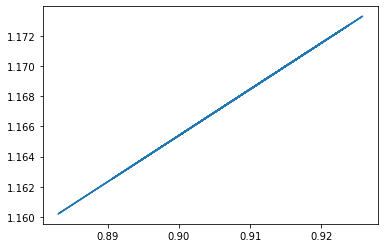

In [558]:
x = all_ws_averaged_jac.ws
plt.plot(x, 0.306*x + 0.89) 

# Ontology Graph Edit Distances

In [450]:
import networkx as nx

In [447]:
source_url = conf_folder + "/conference-iasted/source.rdf"
target_url = conf_folder + '/conference-iasted/target.rdf'
refs_url = conf_folder + '/conference-iasted/reference.rdf'

In [472]:
# extract RDF graphs forom rdf files
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
#time.sleep(0.5)
print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
## Find matchings between classes
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
# extract relation edges
sedges = maponto.build_relation_graph_edges_nocomments_df(source_graph)
tedges = maponto.build_relation_graph_edges_nocomments_df(target_graph)
print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))

../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
0. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....


0 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_datatype_property_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


0. #sedges=(116, 4), #tedges=(315, 4)


In [473]:
sedges

subject  \
0        http://conference#Conference_volume   
1                   http://conference#Person   
2                   http://conference#Person   
3        http://conference#Review_preference   
4          http://conference#Important_dates   
..                                       ...   
111           http://conference#Invited_talk   
112      http://conference#Extended_abstract   
113                  http://conference#Paper   
114  http://conference#Registeered_applicant   
115  http://conference#Reviewed_contribution   

                                            predicate              property  \
0                    http://conference#has_a_location  owl:DataTypeProperty   
1                      http://conference#has_an_email  owl:DataTypeProperty   
2                http://conference#has_the_first_name  owl:DataTypeProperty   
3                      http://conference#has_a_degree  owl:DataTypeProperty   
4    http://conference#is_an_abstract_submission_date  owl:DataTypeProperty   
..                                                ...                   ...   
111                                   rdfs:subClassOf                  None   
112                                   rdfs:subClassOf                  None   
113                                   rdfs:subClassOf                  None   
114                                   rdfs:subClassOf                  None   
115                                   rdfs:subClassOf                  None   

                                       object  
0     http://www.w3.org/2001/XMLSchema#string  
1     http://www.w3.org/2001/XMLSchema#string  
2     http://www.w3.org/2001/XMLSchema#string  
3        http://www.w3.org/2001/XMLSchema#int  
4       http://www.w3.org/2001/XMLSchema#date  
..                                        ...  
111            http://conference#Presentation  
112    http://conference#Regular_contribution  
113    http://conference#Regular_contribution  
114    http://conference#Conference_applicant  
115  http://conference#Submitted_contribution  

[116 rows x 4 columns]

In [474]:
sedges['sub_label'] = sedges.subject.map(mapneighbor.extract_label_from_uri).map(maponto.clean_document_norm).map(lambda x: " ".join(x))

In [475]:
sedges['pred_label'] = sedges.predicate.map(mapneighbor.extract_label_from_uri).map(maponto.clean_document_norm).map(lambda x: " ".join(x))

In [476]:
sedges['obj_label'] = sedges.object.map(mapneighbor.extract_label_from_uri).map(maponto.clean_document_norm).map(lambda x: " ".join(x))

In [477]:
sedges

subject  \
0        http://conference#Conference_volume   
1                   http://conference#Person   
2                   http://conference#Person   
3        http://conference#Review_preference   
4          http://conference#Important_dates   
..                                       ...   
111           http://conference#Invited_talk   
112      http://conference#Extended_abstract   
113                  http://conference#Paper   
114  http://conference#Registeered_applicant   
115  http://conference#Reviewed_contribution   

                                            predicate              property  \
0                    http://conference#has_a_location  owl:DataTypeProperty   
1                      http://conference#has_an_email  owl:DataTypeProperty   
2                http://conference#has_the_first_name  owl:DataTypeProperty   
3                      http://conference#has_a_degree  owl:DataTypeProperty   
4    http://conference#is_an_abstract_submission_date  owl:DataTypeProperty   
..                                                ...                   ...   
111                                   rdfs:subClassOf                  None   
112                                   rdfs:subClassOf                  None   
113                                   rdfs:subClassOf                  None   
114                                   rdfs:subClassOf                  None   
115                                   rdfs:subClassOf                  None   

                                       object              sub_label  \
0     http://www.w3.org/2001/XMLSchema#string      conference volume   
1     http://www.w3.org/2001/XMLSchema#string                 person   
2     http://www.w3.org/2001/XMLSchema#string                 person   
3        http://www.w3.org/2001/XMLSchema#int      review preference   
4       http://www.w3.org/2001/XMLSchema#date        important dates   
..                                        ...                    ...   
111            http://conference#Presentation           invited talk   
112    http://conference#Regular_contribution      extended abstract   
113    http://conference#Regular_contribution                  paper   
114    http://conference#Conference_applicant  registeered applicant   
115  http://conference#Submitted_contribution  reviewed contribution   

                   pred_label               obj_label  
0                    location                  string  
1                       email                  string  
2                  first name                  string  
3                      degree                     int  
4    abstract submission date                    date  
..                        ...                     ...  
111            rdfs sub class            presentation  
112            rdfs sub class    regular contribution  
113            rdfs sub class    regular contribution  
114            rdfs sub class    conference applicant  
115            rdfs sub class  submitted contribution  

[116 rows x 7 columns]

In [480]:
uri_idx = {}
for i, uri in enumerate(list(set(sedges['subject'].unique()).union(set(sedges['object'].unique())))):
    uri_idx[uri] = i

In [483]:
sedges['sub_idx'] = sedges['subject'].map(uri_idx)

In [484]:
sedges['obj_idx']= sedges['object'].map(uri_idx)

In [485]:
sedges

subject  \
0        http://conference#Conference_volume   
1                   http://conference#Person   
2                   http://conference#Person   
3        http://conference#Review_preference   
4          http://conference#Important_dates   
..                                       ...   
111           http://conference#Invited_talk   
112      http://conference#Extended_abstract   
113                  http://conference#Paper   
114  http://conference#Registeered_applicant   
115  http://conference#Reviewed_contribution   

                                            predicate              property  \
0                    http://conference#has_a_location  owl:DataTypeProperty   
1                      http://conference#has_an_email  owl:DataTypeProperty   
2                http://conference#has_the_first_name  owl:DataTypeProperty   
3                      http://conference#has_a_degree  owl:DataTypeProperty   
4    http://conference#is_an_abstract_submission_date  owl:DataTypeProperty   
..                                                ...                   ...   
111                                   rdfs:subClassOf                  None   
112                                   rdfs:subClassOf                  None   
113                                   rdfs:subClassOf                  None   
114                                   rdfs:subClassOf                  None   
115                                   rdfs:subClassOf                  None   

                                       object              sub_label  \
0     http://www.w3.org/2001/XMLSchema#string      conference volume   
1     http://www.w3.org/2001/XMLSchema#string                 person   
2     http://www.w3.org/2001/XMLSchema#string                 person   
3        http://www.w3.org/2001/XMLSchema#int      review preference   
4       http://www.w3.org/2001/XMLSchema#date        important dates   
..                                        ...                    ...   
111            http://conference#Presentation           invited talk   
112    http://conference#Regular_contribution      extended abstract   
113    http://conference#Regular_contribution                  paper   
114    http://conference#Conference_applicant  registeered applicant   
115  http://conference#Submitted_contribution  reviewed contribution   

                   pred_label               obj_label  sub_idx  obj_idx  
0                    location                  string       21       27  
1                       email                  string       11       27  
2                  first name                  string       11       27  
3                      degree                     int        1       47  
4    abstract submission date                    date        2       48  
..                        ...                     ...      ...      ...  
111            rdfs sub class            presentation       41        8  
112            rdfs sub class    regular contribution       40       37  
113            rdfs sub class    regular contribution       43       37  
114            rdfs sub class    conference applicant       33       53  
115            rdfs sub class  submitted contribution       12       13  

[116 rows x 9 columns]

In [451]:
g = nx.MultiGraph()

In [488]:
for i, row in sedges.iterrows():
    print(row['sub_idx'], row['sub_label'], row['obj_idx'], row['obj_label'], 'label:', row['pred_label'])

21 conference volume 27 string label: location
11 person 27 string label: email
11 person 27 string label: first name
1 review preference 47 int label: degree
2 important dates 48 date label: abstract submission date
2 important dates 48 date label: full paper submission date
57 conference proceedings 27 string label: isbn
22 conference document 48 date label: date issue
10 conference www 27 string label: url
11 person 27 string label: last name
2 important dates 48 date label: ending date
57 conference proceedings 47 int label: volume
2 important dates 48 date label: date acceptance announcement
2 important dates 48 date label: date camera ready paper submission
2 important dates 48 date label: starting date
57 conference proceedings 27 string label: name
29 publisher 27 string label: name
56 conference 27 string label: name
31 topic 27 string label: name
44 conference part 27 string label: name
16 review expertise 13 submitted contribution label: submitted contribution
16 review expe

# Conference All

In [4]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [4]:
import os
import os.path
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
subfolders[0]

'iasted-sigkdd'

## Mapping Label_Features_Embeddings(NN or Topn)

In [6]:
# how to generate mappings
make_mapping = 'nn'

all_results = []

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)
        
        #store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(lab_align, refs_url)
        eval_results['method'] = 'match_label_features'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

        # matching based on nn over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
        
        print("match_label_embeddings_OT(nn): {}".format(current_align.shape[0]))
        
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(current_align, refs_url)
        eval_results['method'] = 'match_label_embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        # combine the mappings of lab_features and OT(nn) on embeddings
        preds_align_all = pd.concat([lab_align, current_align]).reset_index(drop=True)
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'label_features+embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

        # matching based on top-n over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
        print("match_label_embeddings_OT(topn): {}".format(current_align.shape[0]))
        
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(current_align, refs_url)
        eval_results['method'] = 'match_label_embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        # combine the mappings of lab_features and OT(topn) on embeddings
        preds_align_all = pd.concat([lab_align, current_align]).reset_index(drop=True)
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'label_features+embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
len(source_graph)=1173, len(target_graph)=245
#slabel=(140, 3), #tlabel=(49, 3)
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


128it [00:06, 18.84it/s]
37it [00:00, 421.36it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 0
match_label_embeddings_OT(nn): 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 2560
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
len(source_graph)=539, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(49, 3)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 76.44it/s]
45it [00:00, 174.64it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignm

match_label_synonyms: 0
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(topn): 680
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
len(source_graph)=1720, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 615.47it/s]
61it [00:00, 581.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_align

match_label_synonyms: 3
match_label_embeddings_OT(nn): 16
match_label_embeddings_OT(topn): 1760
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
len(source_graph)=639, len(target_graph)=245
#slabel=(59, 3), #tlabel=(49, 3)
match_concepts_labels: 9


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


50it [00:00, 769.97it/s]
40it [00:00, 1899.40it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 0
match_label_embeddings_OT(nn): 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1000
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
len(source_graph)=1720, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(140, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2073.78it/s]
132it [00:00, 1391.25it/s]

match_label_synonyms: 4



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Tran

match_label_embeddings_OT(nn): 14
match_label_embeddings_OT(topn): 1820
../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
len(source_graph)=412, len(target_graph)=639
#slabel=(29, 3), #tlabel=(59, 3)
match_concepts_labels: 6


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


23it [00:00, 107.08it/s]
53it [00:00, 948.51it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_align

match_label_synonyms: 1
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(topn): 440
../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
len(source_graph)=412, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1123.01it/s]
135it [00:00, 1275.94it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_

match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(topn): 480
../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf
len(source_graph)=412, len(target_graph)=539


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl


#slabel=(29, 3), #tlabel=(38, 3)
match_concepts_labels: 5


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


24it [00:00, 974.42it/s]
33it [00:00, 742.02it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_align

match_label_synonyms: 0
match_label_embeddings_OT(nn): 5
match_label_embeddings_OT(topn): 480
../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
len(source_graph)=539, len(target_graph)=557
#slabel=(38, 3), #tlabel=(73, 3)


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 706.03it/s]
64it [00:00, 1762.37it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 2
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(topn): 540
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


len(source_graph)=412, len(target_graph)=245
#slabel=(29, 3), #tlabel=(49, 3)
match_concepts_labels: 8


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


21it [00:00, 1160.30it/s]
41it [00:00, 1940.67it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(topn): 420
../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(103, 3)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 853.29it/s]
93it [00:00, 2392.64it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 6


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 560
../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
len(source_graph)=412, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl


#slabel=(29, 3), #tlabel=(73, 3)
match_concepts_labels: 5


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


24it [00:00, 1207.27it/s]
68it [00:00, 1970.82it/s]


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transp

match_label_embeddings_OT(nn): 8


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 480
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
len(source_graph)=639, len(target_graph)=539
#slabel=(59, 3), #tlabel=(38, 3)


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1761.51it/s]
30it [00:00, 827.63it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(topn): 1020
../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
len(source_graph)=539, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(140, 3)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 664.20it/s]
136it [00:00, 1145.17it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_al

match_label_synonyms: 5
match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(topn): 580
../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
len(source_graph)=1720, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2553.74it/s]
42it [00:00, 3472.31it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(topn): 1900
../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
len(source_graph)=639, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1389.82it/s]
135it [00:00, 1173.12it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_a

match_label_synonyms: 4
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(topn): 1020
../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
len(source_graph)=557, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1896.43it/s]
42it [00:00, 1978.16it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 10


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1300
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
len(source_graph)=557, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(140, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1733.47it/s]
134it [00:00, 1210.57it/s]

match_label_synonyms: 6



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Tran

match_label_embeddings_OT(nn): 12
match_label_embeddings_OT(topn): 1240
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
len(source_graph)=639, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1949.43it/s]
95it [00:00, 1264.89it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_co

match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(topn): 1020
../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
len(source_graph)=412, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1171.42it/s]
95it [00:00, 2112.25it/s]

match_label_synonyms: 0



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Trans

match_label_embeddings_OT(nn): 5
match_label_embeddings_OT(topn): 420
../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
len(source_graph)=639, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1859.55it/s]
61it [00:00, 1131.63it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 3
match_label_embeddings_OT(nn): 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 880


In [8]:
all_results_df = pd.DataFrame(all_results)[['test_case','method','numOfRefs','numOfCorrectlyPredicted','numOfPredicted','precision','recall','f1']]
all_results_df

test_case                              method  numOfRefs  \
0      iasted-sigkdd                match_label_features         15   
1      iasted-sigkdd       match_label_embeddings_OT(nn)         15   
2      iasted-sigkdd    label_features+embeddings_OT(nn)         15   
3      iasted-sigkdd     match_label_embeddings_OT(topn)         15   
4      iasted-sigkdd  label_features+embeddings_OT(topn)         15   
..               ...                                 ...        ...   
100  conference-ekaw                match_label_features         25   
101  conference-ekaw       match_label_embeddings_OT(nn)         25   
102  conference-ekaw    label_features+embeddings_OT(nn)         25   
103  conference-ekaw     match_label_embeddings_OT(topn)         25   
104  conference-ekaw  label_features+embeddings_OT(topn)         25   

     numOfCorrectlyPredicted  numOfPredicted  precision    recall        f1  
0                         11              12   0.916667  0.733333  0.814815  
1                          1              11   0.090909  0.066667  0.076923  
2                         12              23   0.521739  0.800000  0.631579  
3                          4            2560   0.001563  0.266667  0.003107  
4                         15            2572   0.005832  1.000000  0.011596  
..                       ...             ...        ...       ...       ...  
100                        9              15   0.600000  0.360000  0.450000  
101                        3              11   0.272727  0.120000  0.166667  
102                       12              26   0.461538  0.480000  0.470588  
103                       11             880   0.012500  0.440000  0.024309  
104                       20             895   0.022346  0.800000  0.043478  

[105 rows x 8 columns]

In [9]:
all_results_df[all_results_df.method == 'match_label_features'].mean()

/tmp/ipykernel_8143/1657637063.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'match_label_features'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.095238
numOfPredicted              8.952381
precision                   0.817684
recall                      0.524825
f1                          0.624412
dtype: float64

In [10]:
all_results_df[all_results_df.method == 'label_features+embeddings_OT(nn)'].mean()

/tmp/ipykernel_8143/3022012122.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'label_features+embeddings_OT(nn)'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     9.000000
numOfPredicted             17.809524
precision                   0.509717
recall                      0.643409
f1                          0.553803
dtype: float64

In [11]:
all_results_df[all_results_df.method == 'label_features+embeddings_OT(topn)'].mean()

/tmp/ipykernel_8143/3834596585.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'label_features+embeddings_OT(topn)'].mean()


numOfRefs                   14.523810
numOfCorrectlyPredicted     10.952381
numOfPredicted             989.904762
precision                    0.013699
recall                       0.765786
f1                           0.026770
dtype: float64

## Mapping Target-Source Label_Features_Embeddings (NN or Topn)

In [12]:
# how to generate mappings
make_mapping = 'nn'


all_results = []

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        lab_align_inv = maponto.match_label_features(tlabel_clnd_uris, slabel_clnd_uris, target_graph, 
                                         source_graph, embs_model)
        
        
        lab_align_inv.columns = ['target','target_label','source','source_label']
        
        # Store the evaluation results in a dictionary: precision:xx, recall:xx, f1:xx
        eval_results = maponto.evaluate_noprint(lab_align_inv, refs_url)
        eval_results['method'] = 'match_label_features'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

        # matching based on nn over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        current_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
        
        
        current_align_inv.columns = ['target','target_label','source','source_label']
        
        #preds_align_rest = pd.concat([preds_align_rest, current_align]).reset_index(drop=True)
        print("match_label_embeddings_OT(nn): {}".format(current_align_inv.shape[0]))
        
        eval_results = maponto.evaluate_noprint(current_align_inv, refs_url)
        eval_results['method'] = 'match_label_embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all = pd.concat([lab_align_inv, current_align_inv]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'label_features+embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

        # matching based on topn over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        current_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
        print("match_label_embeddings_OT(topn): {}".format(current_align_inv.shape[0]))
        
        current_align_inv.columns = ['target','target_label','source','source_label']
        
        eval_results = maponto.evaluate_noprint(current_align_inv, refs_url)
        eval_results['method'] = 'match_label_embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all = pd.concat([lab_align_inv, current_align_inv]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'label_features+embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
len(source_graph)=1173, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(140, 3), #tlabel=(49, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


37it [00:00, 3322.11it/s]
128it [00:00, 1385.13it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(topn): 740
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
len(source_graph)=539, len(target_graph)=245
#slabel=(38, 3), #tlabel=(49, 3)
match_concepts_labels: 4


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


45it [00:00, 1417.04it/s]
34it [00:00, 671.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(topn): 900
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
len(source_graph)=1720, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1900.03it/s]
91it [00:00, 2157.72it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 3
match_label_embeddings_OT(nn): 13


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1160
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
len(source_graph)=639, len(target_graph)=245
#slabel=(59, 3), #tlabel=(49, 3)
match_concepts_labels: 9


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


40it [00:00, 1808.55it/s]
50it [00:00, 769.65it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 6


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 800
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
len(source_graph)=1720, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(140, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1287.18it/s]
95it [00:00, 2380.00it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_l

match_label_embeddings_OT(nn): 12
match_label_embeddings_OT(topn): 2560
../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
len(source_graph)=412, len(target_graph)=639


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(59, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1178.14it/s]
23it [00:00, 1172.70it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 10


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1040
../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
len(source_graph)=412, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1217.63it/s]
24it [00:00, 1075.52it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_

match_label_embeddings_OT(nn): 12
match_label_embeddings_OT(topn): 2700
../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl


len(source_graph)=412, len(target_graph)=539
#slabel=(29, 3), #tlabel=(38, 3)
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


33it [00:00, 689.48it/s]
24it [00:00, 972.97it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_align

match_label_synonyms: 0
match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(topn): 660
../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
len(source_graph)=539, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(73, 3)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1649.18it/s]
29it [00:00, 674.84it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 2
match_label_embeddings_OT(nn): 12


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1240
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


len(source_graph)=412, len(target_graph)=245
#slabel=(29, 3), #tlabel=(49, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1830.40it/s]
21it [00:00, 1135.06it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(topn): 820
../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(103, 3)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2378.54it/s]
28it [00:00, 845.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 0
match_label_embeddings_OT(nn): 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1860
../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
len(source_graph)=412, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(73, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1652.06it/s]
24it [00:00, 1084.91it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 8


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1360
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
len(source_graph)=639, len(target_graph)=539
#slabel=(59, 3), #tlabel=(38, 3)
match_concepts_labels: 8


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


30it [00:00, 792.45it/s]
51it [00:00, 1754.02it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(topn): 600
../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
len(source_graph)=539, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(140, 3)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1141.25it/s]
34it [00:00, 677.30it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_al

match_label_synonyms: 5
match_label_embeddings_OT(nn): 16
match_label_embeddings_OT(topn): 2640
../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
len(source_graph)=1720, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3280.58it/s]
96it [00:00, 2701.86it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(topn): 820
../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
len(source_graph)=639, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1219.27it/s]
54it [00:00, 1524.34it/s]

match_label_synonyms: 4



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Tran

match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(topn): 2620
../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
len(source_graph)=557, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1963.49it/s]
66it [00:00, 1913.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(topn): 820
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
len(source_graph)=557, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(140, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1187.39it/s]
67it [00:00, 1733.18it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_a

match_label_synonyms: 6
match_label_embeddings_OT(nn): 18
match_label_embeddings_OT(topn): 2560
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
len(source_graph)=639, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2505.86it/s]
51it [00:00, 2088.45it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(topn): 1900
../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
len(source_graph)=412, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2271.56it/s]
21it [00:00, 1267.91it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 10
match_label_embeddings_OT(topn): 1900
../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
len(source_graph)=639, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2151.20it/s]
47it [00:00, 1905.71it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 3
match_label_embeddings_OT(nn): 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1160


In [13]:
all_results_df = pd.DataFrame(all_results)[['test_case','method','numOfRefs','numOfCorrectlyPredicted','numOfPredicted','precision','recall','f1']]
all_results_df

test_case                              method  numOfRefs  \
0      iasted-sigkdd                match_label_features         15   
1      iasted-sigkdd       match_label_embeddings_OT(nn)         15   
2      iasted-sigkdd    label_features+embeddings_OT(nn)         15   
3      iasted-sigkdd     match_label_embeddings_OT(topn)         15   
4      iasted-sigkdd  label_features+embeddings_OT(topn)         15   
..               ...                                 ...        ...   
100  conference-ekaw                match_label_features         25   
101  conference-ekaw       match_label_embeddings_OT(nn)         25   
102  conference-ekaw    label_features+embeddings_OT(nn)         25   
103  conference-ekaw     match_label_embeddings_OT(topn)         25   
104  conference-ekaw  label_features+embeddings_OT(topn)         25   

     numOfCorrectlyPredicted  numOfPredicted  precision    recall        f1  
0                         11              12   0.916667  0.733333  0.814815  
1                          0               8   0.000000  0.000000  0.000000  
2                         11              20   0.550000  0.733333  0.628571  
3                          3             740   0.004054  0.200000  0.007947  
4                         14             752   0.018617  0.933333  0.036506  
..                       ...             ...        ...       ...       ...  
100                        9              15   0.600000  0.360000  0.450000  
101                        3              11   0.272727  0.120000  0.166667  
102                       12              26   0.461538  0.480000  0.470588  
103                       11            1160   0.009483  0.440000  0.018565  
104                       20            1175   0.017021  0.800000  0.033333  

[105 rows x 8 columns]

In [14]:
all_results_df[all_results_df.method == 'match_label_features'].mean()

/tmp/ipykernel_8143/1657637063.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'match_label_features'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.095238
numOfPredicted              8.952381
precision                   0.817684
recall                      0.524825
f1                          0.624412
dtype: float64

In [15]:
all_results_df[all_results_df.method == 'label_features+embeddings_OT(nn)'].mean()

/tmp/ipykernel_8143/3022012122.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'label_features+embeddings_OT(nn)'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     9.095238
numOfPredicted             19.000000
precision                   0.486132
recall                      0.650413
f1                          0.537412
dtype: float64

In [16]:
all_results_df[all_results_df.method == 'label_features+embeddings_OT(topn)'].mean()

/tmp/ipykernel_8143/3834596585.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'label_features+embeddings_OT(topn)'].mean()


numOfRefs                    14.523810
numOfCorrectlyPredicted      11.190476
numOfPredicted             1478.476190
precision                     0.009619
recall                        0.781274
f1                            0.018934
dtype: float64

## Mapping inner-joined Source-Target and Target-Source Label_Features_Embeddings (NN or Topn)

In [27]:
df1 = pd.DataFrame({'source':[1, 2, 3], 'target':[4, 5, 6], 'val':[1, 2, 3]})
df2 = pd.DataFrame({'source':[1, 20, 3], 'target':[4, 50, 6], 'val':[4, 5, 6]})
df1.merge(df2, how='outer', on=['source', 'target'])

source  target  val_x  val_y
0       1       4    1.0    4.0
1       2       5    2.0    NaN
2       3       6    3.0    6.0
3      20      50    NaN    5.0

In [167]:
# how to generate mappings
make_mapping = 'nn'


all_results = []

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)
        
        lab_align_inv = maponto.match_label_features(tlabel_clnd_uris, slabel_clnd_uris, target_graph, 
                                         source_graph, embs_model)
        
    
        lab_align_inv.columns = ['target','target_label','source','source_label']
        
        # get joined label-based alignments
        lab_align_merged = lab_align.merge(lab_align_inv, how='inner', 
                                           left_on=['source', 'target'], \
                                           right_on=['source', 'target'])
        
        # store the evaluation results in a dictionary: precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(lab_align_merged, refs_url)
        eval_results['method'] = 'match_label_features'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

        # matching based on nn over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
        print("match_label_embeddings_OT(nn): {}".format(current_align.shape[0]))
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

        # matching based on top-n over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        #if make_mapping == 'nn':  
        current_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
        
        current_align_inv.columns = ['target','target_label','source','source_label']
        
        print("match_label_embeddings_OT(nn) inv: {}".format(current_align_inv.shape[0]))
        
        
        current_align_merged = current_align.merge(current_align_inv, how='inner', 
                                                  on=['source', 'target'])
        eval_results = maponto.evaluate_noprint(current_align_merged, refs_url)
        eval_results['method'] = 'match_label_embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all = pd.concat([lab_align_merged, current_align_merged]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'label_features+embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

        # matching based on top-n over OT couplings between embeddings of 
        # the sets of words in source and target concepts
        current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
        print("match_label_embeddings_OT(topn): {}".format(current_align.shape[0]))
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

        #if make_mapping == 'topn':
        current_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
        print("match_label_embeddings_OT(topn) inv: {}".format(current_align_inv.shape[0]))
        
        
        current_align_inv.columns = ['target','target_label','source','source_label']
        
        current_align_merged = current_align.merge(current_align_inv, how='inner', 
                                                  on=['source', 'target'])
        eval_results = maponto.evaluate_noprint(current_align_merged, refs_url)
        eval_results['method'] = 'match_label_embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all = pd.concat([lab_align_merged, current_align_merged]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'label_features+embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
len(source_graph)=1173, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(140, 3), #tlabel=(49, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1233.53it/s]
37it [00:00, 2972.06it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2850.49it/s]
128it [00:00, 1294.29it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_

match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 2560
match_label_embeddings_OT(topn) inv: 740
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


len(source_graph)=539, len(target_graph)=245
#slabel=(38, 3), #tlabel=(49, 3)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 721.57it/s]
45it [00:00, 1563.47it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1546.23it/s]
34it [00:00, 716.71it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(nn) inv: 7


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 680
match_label_embeddings_OT(topn) inv: 900
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
len(source_graph)=1720, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2119.10it/s]
61it [00:00, 1890.90it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1847.15it/s]
91it [00:00, 2101.49it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 3
match_label_embeddings_OT(nn): 16


INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(nn) inv: 13


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1760
match_label_embeddings_OT(topn) inv: 1160
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
len(source_graph)=639, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(49, 3)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1476.26it/s]
40it [00:00, 1789.44it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1728.38it/s]
50it [00:00, 1521.28it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(nn) inv: 6


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1000
match_label_embeddings_OT(topn) inv: 800
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
len(source_graph)=1720, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl


#slabel=(103, 3), #tlabel=(140, 3)
match_concepts_labels: 8


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


95it [00:00, 2106.69it/s]
132it [00:00, 1150.70it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 4
match_concepts_labels: 8


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


132it [00:00, 1132.59it/s]
95it [00:00, 2085.90it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_

match_label_embeddings_OT(nn): 14
match_label_embeddings_OT(nn) inv: 12


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1820
match_label_embeddings_OT(topn) inv: 2560
../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
len(source_graph)=412, len(target_graph)=639


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(59, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 684.42it/s]
53it [00:00, 1242.12it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1357.71it/s]
23it [00:00, 1000.64it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(nn) inv: 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 440
match_label_embeddings_OT(topn) inv: 1040
../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
len(source_graph)=412, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 985.33it/s]
135it [00:00, 1100.23it/s]

match_label_synonyms: 0



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1110.46it/s]
24it [00:00, 981.76it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_l

match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(nn) inv: 12


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 480
match_label_embeddings_OT(topn) inv: 2700
../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf
len(source_graph)=412, len(target_graph)=539


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(38, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 937.24it/s]
33it [00:00, 719.14it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 692.43it/s]
24it [00:00, 919.22it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_align

match_label_synonyms: 0
match_label_embeddings_OT(nn): 5
match_label_embeddings_OT(nn) inv: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 480
match_label_embeddings_OT(topn) inv: 660
../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
len(source_graph)=539, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(73, 3)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 679.33it/s]
64it [00:00, 1688.56it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1696.44it/s]
29it [00:00, 690.31it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 2
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(nn) inv: 12


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 540
match_label_embeddings_OT(topn) inv: 1240
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


len(source_graph)=412, len(target_graph)=245
#slabel=(29, 3), #tlabel=(49, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1152.58it/s]
41it [00:00, 1939.68it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1912.42it/s]
21it [00:00, 1151.95it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_co

match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_embeddings_OT(topn): 420


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn) inv: 820
../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(103, 3)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 863.54it/s]
93it [00:00, 2394.04it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2440.09it/s]
28it [00:00, 856.21it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(nn) inv: 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 560
match_label_embeddings_OT(topn) inv: 1860
../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
len(source_graph)=412, len(target_graph)=557
#slabel=(29, 3), #tlabel=(73, 3)
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


24it [00:00, 1225.97it/s]
68it [00:00, 1926.03it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1867.53it/s]
24it [00:00, 1201.73it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_co

match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_embeddings_OT(topn): 480


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn) inv: 1360
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
len(source_graph)=639, len(target_graph)=539


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(38, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1539.16it/s]
30it [00:00, 733.92it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 738.01it/s]
51it [00:00, 1545.13it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 1020
match_label_embeddings_OT(topn) inv: 600
../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
len(source_graph)=539, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(140, 3)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 688.15it/s]
136it [00:00, 1193.80it/s]

match_label_synonyms: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1160.89it/s]
34it [00:00, 645.35it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_al

match_label_synonyms: 5
match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(nn) inv: 16


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 580
match_label_embeddings_OT(topn) inv: 2640
../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
len(source_graph)=1720, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2650.53it/s]
42it [00:00, 3468.62it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3348.62it/s]
96it [00:00, 2627.68it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(nn) inv: 7


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 1900
match_label_embeddings_OT(topn) inv: 820
../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
len(source_graph)=639, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1475.11it/s]
135it [00:00, 1009.45it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 885.68it/s]
54it [00:00, 1497.10it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_al

match_label_synonyms: 4
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(nn) inv: 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1020
match_label_embeddings_OT(topn) inv: 2620
../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
len(source_graph)=557, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1847.69it/s]
42it [00:00, 1808.32it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1721.09it/s]
66it [00:00, 1743.62it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 10
match_label_embeddings_OT(nn) inv: 9


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1300
match_label_embeddings_OT(topn) inv: 820
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
len(source_graph)=557, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(140, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1633.99it/s]
134it [00:00, 1169.61it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1169.02it/s]
67it [00:00, 1743.26it/s]


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Trans

match_label_embeddings_OT(nn): 12
match_label_embeddings_OT(nn) inv: 18


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1240
match_label_embeddings_OT(topn) inv: 2560
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
len(source_graph)=639, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1836.21it/s]
95it [00:00, 2436.40it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2291.23it/s]
51it [00:00, 1962.44it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 9


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(nn) inv: 9


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1020
match_label_embeddings_OT(topn) inv: 1900
../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
len(source_graph)=412, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1191.24it/s]
95it [00:00, 2113.62it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1912.73it/s]
21it [00:00, 1058.39it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(nn) inv: 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 420
match_label_embeddings_OT(topn) inv: 1900
../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
len(source_graph)=639, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1068.35it/s]
61it [00:00, 1442.63it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1944.79it/s]
47it [00:00, 1668.92it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 3
match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(nn) inv: 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 880
match_label_embeddings_OT(topn) inv: 1160


In [168]:
all_results_df = pd.DataFrame(all_results)[['test_case','method','numOfRefs','numOfCorrectlyPredicted','numOfPredicted','precision','recall','f1']]
all_results_df

test_case                              method  numOfRefs  \
0      iasted-sigkdd                match_label_features         15   
1      iasted-sigkdd       match_label_embeddings_OT(nn)         15   
2      iasted-sigkdd    label_features+embeddings_OT(nn)         15   
3      iasted-sigkdd     match_label_embeddings_OT(topn)         15   
4      iasted-sigkdd  label_features+embeddings_OT(topn)         15   
..               ...                                 ...        ...   
100  conference-ekaw                match_label_features         25   
101  conference-ekaw       match_label_embeddings_OT(nn)         25   
102  conference-ekaw    label_features+embeddings_OT(nn)         25   
103  conference-ekaw     match_label_embeddings_OT(topn)         25   
104  conference-ekaw  label_features+embeddings_OT(topn)         25   

     numOfCorrectlyPredicted  numOfPredicted  precision    recall        f1  
0                         11              12   0.916667  0.733333  0.814815  
1                          0               8   0.000000  0.000000  0.000000  
2                         11              20   0.550000  0.733333  0.628571  
3                          3             733   0.004093  0.200000  0.008021  
4                         14             745   0.018792  0.933333  0.036842  
..                       ...             ...        ...       ...       ...  
100                        9              15   0.600000  0.360000  0.450000  
101                        3              11   0.272727  0.120000  0.166667  
102                       12              26   0.461538  0.480000  0.470588  
103                       11             781   0.014085  0.440000  0.027295  
104                       20             796   0.025126  0.800000  0.048721  

[105 rows x 8 columns]

In [169]:
all_results_df[all_results_df.method == 'match_label_features'].mean()

/tmp/ipykernel_1729/1657637063.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'match_label_features'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.095238
numOfPredicted              8.952381
precision                   0.817684
recall                      0.524825
f1                          0.624412
dtype: float64

In [170]:
all_results_df[all_results_df.method == 'label_features+embeddings_OT(nn)'].mean()

/tmp/ipykernel_1729/3022012122.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'label_features+embeddings_OT(nn)'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     8.904762
numOfPredicted             17.047619
precision                   0.524662
recall                      0.637060
f1                          0.560297
dtype: float64

In [171]:
all_results_df[all_results_df.method == 'label_features+embeddings_OT(topn)'].mean()

/tmp/ipykernel_1729/3834596585.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'label_features+embeddings_OT(topn)'].mean()


numOfRefs                   14.523810
numOfCorrectlyPredicted     10.904762
numOfPredicted             736.952381
precision                    0.016237
recall                       0.762611
f1                           0.031674
dtype: float64

## Mapping combined Source-Target and Target-Source Label_Features_Embeddings (NN or Topn)

In [38]:
# how to generate mappings
make_mapping = 'nn'


all_results = []

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(lab_align, refs_url)
        eval_results['method'] = 'source2target:match_label_features'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        lab_align_inv = maponto.match_label_features(tlabel_clnd_uris, slabel_clnd_uris, target_graph, 
                                         source_graph, embs_model)
        lab_align_inv.columns = ['target','target_label','source','source_label']
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(lab_align_inv, refs_url)
        eval_results['method'] = 'target2source:match_label_features'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # get combined label-based alignments
        lab_align_merged = lab_align.merge(lab_align_inv, how='outer', on=['source', 'target'])
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(lab_align_merged, refs_url)
        eval_results['method'] = 'combined:match_label_features'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

        # matching based on nn over OT couplings between embeddings of 
        # the sets of words from source and target concepts
        current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
        print("match_label_embeddings_OT(nn): {}".format(current_align.shape[0]))
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(current_align, refs_url)
        eval_results['method'] = 'source2target:match_label_embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

        # matching based on nn over OT couplings between embeddings of 
        # the sets of words from target and source concepts 
        current_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
        current_align_inv.columns = ['target','target_label','source','source_label']
        print("match_label_embeddings_OT(nn) inv: {}".format(current_align_inv.shape[0]))
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(current_align_inv, refs_url)
        eval_results['method'] = 'target2source:match_label_embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        current_align_merged = current_align.merge(current_align_inv, how='outer', 
                                                  on=['source', 'target'])
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(current_align_merged, refs_url)
        eval_results['method'] = 'combined:match_label_embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all = pd.concat([lab_align, current_align]).reset_index(drop=True)
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'source2target:label_features+embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all_inv = pd.concat([lab_align_inv, current_align_inv]).reset_index(drop=True)
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(preds_align_all_inv, refs_url)
        eval_results['method'] = 'target2source:label_features+embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all_combined = pd.concat([lab_align_merged, current_align_merged]).reset_index(drop=True)
        # store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
        eval_results = maponto.evaluate_noprint(preds_align_all_combined, refs_url)
        eval_results['method'] = 'combined:label_features+embeddings_OT(nn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

        # matching based on top-n over OT couplings between embeddings of 
        # the sets of words from source and target concepts
        current_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
        print("match_label_embeddings_OT(topn): {}".format(current_align.shape[0]))
        eval_results = maponto.evaluate_noprint(current_align, refs_url)
        eval_results['method'] = 'source2target:match_label_embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        # extract the concepts that are not matched so far
        slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
        tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

        # matching based on topn over OT couplings between embeddings of 
        # the sets of words from target and source concepts
        current_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
        print("match_label_embeddings_OT(topn) inv: {}".format(current_align_inv.shape[0]))
        current_align_inv.columns = ['target','target_label','source','source_label']
        eval_results = maponto.evaluate_noprint(current_align_inv, refs_url)
        eval_results['method'] = 'target2source:match_label_embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        current_align_merged = current_align.merge(current_align_inv, how='outer', 
                                                  on=['source', 'target'])
        eval_results = maponto.evaluate_noprint(current_align_merged, refs_url)
        eval_results['method'] = 'combined:match_label_embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all = pd.concat([lab_align, current_align]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all, refs_url)
        eval_results['method'] = 'source2target:label_features+embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        preds_align_all_inv = pd.concat([lab_align_inv, current_align_inv]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all_inv, refs_url)
        eval_results['method'] = 'target2source:label_features+embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)
        
        
        preds_align_all_combined = pd.concat([lab_align_merged, current_align_merged]).reset_index(drop=True)
        eval_results = maponto.evaluate_noprint(preds_align_all_combined, refs_url)
        eval_results['method'] = 'combined:label_features+embeddings_OT(topn)'
        eval_results['test_case'] = subf
        all_results.append(eval_results)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
len(source_graph)=1173, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(140, 3), #tlabel=(49, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1305.66it/s]
37it [00:00, 3045.91it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2738.38it/s]
128it [00:00, 1180.44it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_embeddings_OT(nn): 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Trans

match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 2560
match_label_embeddings_OT(topn) inv: 740
../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
len(source_graph)=539, len(target_graph)=245
#slabel=(38, 3), #tlabel=(49, 3)
match_concepts_labels: 4


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


34it [00:00, 593.03it/s]
45it [00:00, 1490.40it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1500.72it/s]
34it [00:00, 701.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 7
match_label_embeddings_OT(nn) inv: 7


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 680
match_label_embeddings_OT(topn) inv: 900
../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
len(source_graph)=1720, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2047.88it/s]
61it [00:00, 1857.42it/s]

match_label_synonyms: 3
match_concepts_labels: 12



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


61it [00:00, 1059.82it/s]
91it [00:00, 1471.08it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transp

match_label_embeddings_OT(nn): 16
match_label_embeddings_OT(nn) inv: 13


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1760
match_label_embeddings_OT(topn) inv: 1160
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
len(source_graph)=639, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(49, 3)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1520.47it/s]
40it [00:00, 1831.35it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1766.06it/s]
50it [00:00, 1500.74it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(nn) inv: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 1000
match_label_embeddings_OT(topn) inv: 800
../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
len(source_graph)=1720, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(140, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2148.48it/s]
132it [00:00, 1321.94it/s]

match_label_synonyms: 4



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1173.41it/s]
95it [00:00, 1460.36it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_a

match_label_synonyms: 4
match_label_embeddings_OT(nn): 14
match_label_embeddings_OT(nn) inv: 12


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

match_label_embeddings_OT(topn): 1820
match_label_embeddings_OT(topn) inv: 2560
../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
len(source_graph)=412, len(target_graph)=639


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(59, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 525.46it/s]
53it [00:00, 763.07it/s]

match_label_synonyms: 1
match_concepts_labels: 6



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


53it [00:00, 1200.74it/s]
23it [00:00, 1083.92it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 1
match_label_embeddings_OT(nn): 7


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_embeddings_OT(nn) inv: 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 440


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn) inv: 1040
../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
len(source_graph)=412, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1057.81it/s]
135it [00:00, 1216.21it/s]

match_label_synonyms: 0
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1199.59it/s]
24it [00:00, 1065.03it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_embeddings_OT(nn): 7


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_l

match_label_embeddings_OT(nn) inv: 12


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 480
match_label_embeddings_OT(topn) inv: 2700
../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl


len(source_graph)=412, len(target_graph)=539
#slabel=(29, 3), #tlabel=(38, 3)
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


24it [00:00, 915.15it/s]
33it [00:00, 706.01it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 698.35it/s]
24it [00:00, 932.51it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_align

match_label_synonyms: 0
match_label_embeddings_OT(nn): 5
match_label_embeddings_OT(nn) inv: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 480
match_label_embeddings_OT(topn) inv: 660
../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
len(source_graph)=539, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(73, 3)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 682.52it/s]
64it [00:00, 1704.61it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1693.67it/s]
29it [00:00, 678.86it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 2
match_label_embeddings_OT(nn): 9


INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(nn) inv: 12


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 540
match_label_embeddings_OT(topn) inv: 1240
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
len(source_graph)=412, len(target_graph)=245
#slabel=(29, 3), #tlabel=(49, 3)
match_concepts_labels: 8


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


21it [00:00, 1080.22it/s]
41it [00:00, 1827.89it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1836.27it/s]
21it [00:00, 1113.11it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 0
match_label_embeddings_OT(nn): 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transp

match_label_embeddings_OT(nn) inv: 8


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance 

match_label_embeddings_OT(topn): 420
match_label_embeddings_OT(topn) inv: 820
../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(103, 3)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 758.78it/s]
93it [00:00, 2164.80it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2349.00it/s]
28it [00:00, 832.69it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 6


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_co

match_label_embeddings_OT(nn) inv: 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_embeddings_OT(topn): 560


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn) inv: 1860
../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
len(source_graph)=412, len(target_graph)=557
#slabel=(29, 3), #tlabel=(73, 3)


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1162.02it/s]
68it [00:00, 1838.66it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1842.64it/s]
24it [00:00, 1195.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 8
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 480
match_label_embeddings_OT(topn) inv: 1360
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
len(source_graph)=639, len(target_graph)=539


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(38, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1672.30it/s]
30it [00:00, 800.64it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 799.75it/s]
51it [00:00, 1637.13it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alig

match_label_synonyms: 0
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 1020
match_label_embeddings_OT(topn) inv: 600
../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
len(source_graph)=539, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(140, 3)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 658.05it/s]
136it [00:00, 1097.25it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1109.99it/s]
34it [00:00, 656.35it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_al

match_label_synonyms: 5
match_label_embeddings_OT(nn): 6
match_label_embeddings_OT(nn) inv: 16


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 580
match_label_embeddings_OT(topn) inv: 2640
../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
len(source_graph)=1720, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2632.99it/s]
42it [00:00, 1723.08it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 2104.37it/s]
96it [00:00, 2035.91it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transp

match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(nn) inv: 7


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1900
match_label_embeddings_OT(topn) inv: 820
../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
len(source_graph)=639, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(140, 3)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1325.83it/s]
135it [00:00, 773.19it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1107.84it/s]
54it [00:00, 1432.35it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_a

match_label_synonyms: 4
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(nn) inv: 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1020
match_label_embeddings_OT(topn) inv: 2620
../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
len(source_graph)=557, len(target_graph)=245


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(49, 3)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1877.28it/s]
42it [00:00, 1971.43it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1902.59it/s]
66it [00:00, 1832.94it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 1
match_label_embeddings_OT(nn): 10
match_label_embeddings_OT(nn) inv: 9


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 1300
match_label_embeddings_OT(topn) inv: 820
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
len(source_graph)=557, len(target_graph)=1173


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(140, 3)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1712.19it/s]
134it [00:00, 1212.71it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1140.75it/s]
67it [00:00, 1696.63it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 6


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_l

match_label_embeddings_OT(nn): 12
match_label_embeddings_OT(nn) inv: 18


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 1240
match_label_embeddings_OT(topn) inv: 2560
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
len(source_graph)=639, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 957.64it/s]
95it [00:00, 1433.99it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 8


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


95it [00:00, 2442.54it/s]
51it [00:00, 2010.20it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 9
match_label_embeddings_OT(nn) inv: 9


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 1020
match_label_embeddings_OT(topn) inv: 1900
../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
len(source_graph)=412, len(target_graph)=1720


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(103, 3)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1136.55it/s]
95it [00:00, 2115.16it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2064.55it/s]
21it [00:00, 1163.44it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 0
match_label_embeddings_OT(nn): 5
match_label_embeddings_OT(nn) inv: 10


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

match_label_embeddings_OT(topn): 420
match_label_embeddings_OT(topn) inv: 1900
../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
len(source_graph)=639, len(target_graph)=557


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(73, 3)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1727.19it/s]
61it [00:00, 2088.51it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2056.69it/s]
47it [00:00, 1743.30it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_ali

match_label_synonyms: 3
match_label_embeddings_OT(nn): 11


INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_to

match_label_embeddings_OT(nn) inv: 11


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 880
match_label_embeddings_OT(topn) inv: 1160


In [39]:
all_results_df = pd.DataFrame(all_results)[['test_case','method','numOfRefs','numOfCorrectlyPredicted','numOfPredicted','precision','recall','f1']]
all_results_df

test_case                                            method  \
0      iasted-sigkdd                source2target:match_label_features   
1      iasted-sigkdd                target2source:match_label_features   
2      iasted-sigkdd                     combined:match_label_features   
3      iasted-sigkdd       source2target:match_label_embeddings_OT(nn)   
4      iasted-sigkdd       target2source:match_label_embeddings_OT(nn)   
..               ...                                               ...   
310  conference-ekaw     target2source:match_label_embeddings_OT(topn)   
311  conference-ekaw          combined:match_label_embeddings_OT(topn)   
312  conference-ekaw  source2target:label_features+embeddings_OT(topn)   
313  conference-ekaw  target2source:label_features+embeddings_OT(topn)   
314  conference-ekaw       combined:label_features+embeddings_OT(topn)   

     numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0           15                       11              12   0.916667  0.733333   
1           15                       11              12   0.916667  0.733333   
2           15                       11              12   0.916667  0.733333   
3           15                        1              11   0.090909  0.066667   
4           15                        0               8   0.000000  0.000000   
..         ...                      ...             ...        ...       ...   
310         25                       11            1160   0.009483  0.440000   
311         25                       11            1259   0.008737  0.440000   
312         25                       20             895   0.022346  0.800000   
313         25                       20            1175   0.017021  0.800000   
314         25                       20            1274   0.015699  0.800000   

           f1  
0    0.814815  
1    0.814815  
2    0.814815  
3    0.076923  
4    0.000000  
..        ...  
310  0.018565  
311  0.017134  
312  0.043478  
313  0.033333  
314  0.030793  

[315 rows x 8 columns]

In [45]:
all_results_df.to_csv("../data/conference/with_references/all_results.csv")

In [41]:
all_results_df[all_results_df.method == 'combined:match_label_features'].mean()

/tmp/ipykernel_8143/1104081780.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'combined:match_label_features'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.095238
numOfPredicted              8.952381
precision                   0.817684
recall                      0.524825
f1                          0.624412
dtype: float64

In [43]:
all_results_df[all_results_df.method == 'combined:label_features+embeddings_OT(nn)'].mean()

/tmp/ipykernel_8143/3732067130.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'combined:label_features+embeddings_OT(nn)'].mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     9.190476
numOfPredicted             19.761905
precision                   0.471187
recall                      0.656762
f1                          0.530917
dtype: float64

In [44]:
all_results_df[all_results_df.method == 'combined:label_features+embeddings_OT(topn)'].mean()

/tmp/ipykernel_8143/3861516336.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_df[all_results_df.method == 'combined:label_features+embeddings_OT(topn)'].mean()


numOfRefs                    14.523810
numOfCorrectlyPredicted      11.238095
numOfPredicted             1731.428571
precision                     0.007512
recall                        0.784449
f1                            0.014840
dtype: float64

## Mapping Label_Syn_Was_Rest

In [134]:
all_results = []

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        concept_align = otmapper.mapping_label_syn_jac_was_rest(slabel_clnd_uris, tlabel_clnd_uris, source_graph, target_graph, embs_model)
        logging.info("TOTAL NUMBER OF MAPPINGS BETWEEN CONCPETS IS {}".format(len(concept_align)))
    
        #print the evaluation result
        eval_results = maponto.evaluate_noprint(concept_align, refs_url)
        eval_results['method'] = 'mapping_label_syn_jac_was_rest'
        eval_results['test_case'] = subf
        all_results.append(eval_results)


../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
len(source_graph)=1173, len(target_graph)=245


INFO:root:The number of level_1 predicted mapping is 12.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(140, 3), #tlabel=(49, 3)


128it [00:00, 1232.58it/s]
37it [00:00, 2960.27it/s]
INFO:root:Compute the related words for each source concept....
128it [00:12, 10.56it/s]
INFO:root:Total number of source concepts computed with relatd words is 128
INFO:root:Compute the related words for each target concept....
37it [00:02, 16.21it/s]
INFO:root:Total number of target concepts computed with related words is 37
100%|██████████| 128/128 [00:00<00:00, 5754.86it/s]
INFO:root:The number of level_3 predicted mapping is 12
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 116/116 [00:04<00:00, 24.90it/s]
INFO:root:The number of level_4 predicted mapping is 6
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In

../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:The number of level_1 predicted mapping is 4.


len(source_graph)=539, len(target_graph)=245
#slabel=(38, 3), #tlabel=(49, 3)


/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...
34it [00:00, 735.16it/s]
45it [00:00, 1536.85it/s]
INFO:root:Compute the related words for each source concept....
34it [00:01, 17.63it/s]
INFO:root:Total number of source concepts computed with relatd words is 34
INFO:root:Compute the related words for each target concept....
45it [00:02, 17.61it/s]
INFO:root:Total number of target concepts computed with related words is 45
100%|██████████| 34/34 [00:00<00:00, 4470.98it/s]
INFO:root:The number of level_3 predicted mapping is 8
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all argume

../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
len(source_graph)=1720, len(target_graph)=557


INFO:root:The number of level_1 predicted mapping is 12.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(73, 3)


91it [00:00, 2173.51it/s]
61it [00:00, 1883.22it/s]
INFO:root:The number of level_2 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
88it [00:06, 14.06it/s]
INFO:root:Total number of source concepts computed with relatd words is 88
INFO:root:Compute the related words for each target concept....
58it [00:02, 22.39it/s]
INFO:root:Total number of target concepts computed with related words is 58
100%|██████████| 88/88 [00:00<00:00, 3285.67it/s]
INFO:root:The number of level_3 predicted mapping is 11
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  e

../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
len(source_graph)=639, len(target_graph)=245


INFO:root:The number of level_1 predicted mapping is 9.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(49, 3)


50it [00:00, 1526.39it/s]
40it [00:00, 1815.64it/s]
INFO:root:Compute the related words for each source concept....
50it [00:03, 16.34it/s]
INFO:root:Total number of source concepts computed with relatd words is 50
INFO:root:Compute the related words for each target concept....
40it [00:01, 25.07it/s]
INFO:root:Total number of target concepts computed with related words is 40
100%|██████████| 50/50 [00:00<00:00, 5076.99it/s]
INFO:root:The number of level_3 predicted mapping is 8
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 42/42 [00:02<00:00, 20.38it/s]
INFO:root:The number of level_4 predicted mapping is 2
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a futur

../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
len(source_graph)=1720, len(target_graph)=1173


INFO:root:The number of level_1 predicted mapping is 8.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(140, 3)


95it [00:00, 2305.03it/s]
132it [00:00, 1280.96it/s]
INFO:root:The number of level_2 predicted mapping is 4
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
91it [00:04, 20.54it/s]
INFO:root:Total number of source concepts computed with relatd words is 91
INFO:root:Compute the related words for each target concept....
128it [00:05, 23.43it/s]
INFO:root:Total number of target concepts computed with related words is 128
100%|██████████| 91/91 [00:00<00:00, 1390.55it/s]
INFO:root:The number of level_3 predicted mapping is 14
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
len(source_graph)=412, len(target_graph)=639


INFO:root:The number of level_1 predicted mapping is 6.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(59, 3)


23it [00:00, 1164.90it/s]
53it [00:00, 1616.80it/s]
INFO:root:The number of level_2 predicted mapping is 1
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
22it [00:00, 25.80it/s]
INFO:root:Total number of source concepts computed with relatd words is 22
INFO:root:Compute the related words for each target concept....
52it [00:01, 27.13it/s]
INFO:root:Total number of target concepts computed with related words is 52
100%|██████████| 22/22 [00:00<00:00, 4020.33it/s]
INFO:root:The number of level_3 predicted mapping is 7
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  en

../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
len(source_graph)=412, len(target_graph)=1173


INFO:root:The number of level_1 predicted mapping is 5.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(140, 3)


24it [00:00, 1061.36it/s]
135it [00:00, 1213.28it/s]
INFO:root:Compute the related words for each source concept....
24it [00:00, 27.13it/s]
INFO:root:Total number of source concepts computed with relatd words is 24
INFO:root:Compute the related words for each target concept....
135it [00:05, 22.70it/s]
INFO:root:Total number of target concepts computed with related words is 135
100%|██████████| 24/24 [00:00<00:00, 1732.38it/s]
INFO:root:The number of level_3 predicted mapping is 6
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 18/18 [00:03<00:00,  5.30it/s]
INFO:root:The number of level_4 predicted mapping is 4
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a fu

../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:The number of level_1 predicted mapping is 5.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


len(source_graph)=412, len(target_graph)=539
#slabel=(29, 3), #tlabel=(38, 3)


24it [00:00, 779.16it/s]
33it [00:00, 700.37it/s]
INFO:root:Compute the related words for each source concept....
24it [00:00, 27.28it/s]
INFO:root:Total number of source concepts computed with relatd words is 24
INFO:root:Compute the related words for each target concept....
33it [00:01, 16.65it/s]
INFO:root:Total number of target concepts computed with related words is 33
100%|██████████| 24/24 [00:00<00:00, 6197.33it/s]
INFO:root:The number of level_3 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 21/21 [00:00<00:00, 35.10it/s]
INFO:root:The number of level_4 predicted mapping is 5
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a future 

../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
len(source_graph)=539, len(target_graph)=557


INFO:root:The number of level_1 predicted mapping is 9.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(73, 3)


29it [00:00, 680.58it/s]
64it [00:00, 1676.19it/s]
INFO:root:The number of level_2 predicted mapping is 2
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
27it [00:01, 25.17it/s]
INFO:root:Total number of source concepts computed with relatd words is 27
INFO:root:Compute the related words for each target concept....
62it [00:02, 25.52it/s]
INFO:root:Total number of target concepts computed with related words is 62
100%|██████████| 27/27 [00:00<00:00, 3725.45it/s]
INFO:root:The number of level_3 predicted mapping is 11
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  en

../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
len(source_graph)=412, len(target_graph)=245


INFO:root:The number of level_1 predicted mapping is 8.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(49, 3)


21it [00:00, 1035.14it/s]
41it [00:00, 1754.06it/s]
INFO:root:Compute the related words for each source concept....
21it [00:00, 24.67it/s]
INFO:root:Total number of source concepts computed with relatd words is 21
INFO:root:Compute the related words for each target concept....
41it [00:02, 17.67it/s]
INFO:root:Total number of target concepts computed with related words is 41
100%|██████████| 21/21 [00:00<00:00, 5462.01it/s]
INFO:root:The number of level_3 predicted mapping is 5
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 16/16 [00:00<00:00, 24.88it/s]
INFO:root:The number of level_4 predicted mapping is 2
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a futur

../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720


INFO:root:The number of level_1 predicted mapping is 10.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(103, 3)


28it [00:00, 834.30it/s]
93it [00:00, 2396.29it/s]
INFO:root:Compute the related words for each source concept....
28it [00:01, 25.25it/s]
INFO:root:Total number of source concepts computed with relatd words is 28
INFO:root:Compute the related words for each target concept....
93it [00:04, 21.90it/s]
INFO:root:Total number of target concepts computed with related words is 93
100%|██████████| 28/28 [00:00<00:00, 2160.86it/s]
INFO:root:The number of level_3 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 25/25 [00:03<00:00,  6.59it/s]
INFO:root:The number of level_4 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a future

../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
len(source_graph)=412, len(target_graph)=557


INFO:root:The number of level_1 predicted mapping is 5.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(73, 3)


24it [00:00, 1086.06it/s]
68it [00:00, 1710.63it/s]
INFO:root:Compute the related words for each source concept....
24it [00:01, 22.36it/s]
INFO:root:Total number of source concepts computed with relatd words is 24
INFO:root:Compute the related words for each target concept....
68it [00:02, 25.33it/s]
INFO:root:Total number of target concepts computed with related words is 68
100%|██████████| 24/24 [00:00<00:00, 3221.23it/s]
INFO:root:The number of level_3 predicted mapping is 7
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 17/17 [00:01<00:00, 13.80it/s]
INFO:root:The number of level_4 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a futur

../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf


INFO:root:The number of level_1 predicted mapping is 8.


len(source_graph)=639, len(target_graph)=539
#slabel=(59, 3), #tlabel=(38, 3)


/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...
51it [00:00, 1766.17it/s]
30it [00:00, 827.80it/s]
INFO:root:Compute the related words for each source concept....
51it [00:02, 18.71it/s]
INFO:root:Total number of source concepts computed with relatd words is 51
INFO:root:Compute the related words for each target concept....
30it [00:01, 25.49it/s]
INFO:root:Total number of target concepts computed with related words is 30
100%|██████████| 51/51 [00:00<00:00, 7257.81it/s]
INFO:root:The number of level_3 predicted mapping is 7
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all argume

../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
len(source_graph)=539, len(target_graph)=1173


INFO:root:The number of level_1 predicted mapping is 4.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(38, 3), #tlabel=(140, 3)


34it [00:00, 668.45it/s]
136it [00:00, 1152.77it/s]
INFO:root:The number of level_2 predicted mapping is 5
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
29it [00:01, 26.24it/s]
INFO:root:Total number of source concepts computed with relatd words is 29
INFO:root:Compute the related words for each target concept....
132it [00:05, 22.29it/s]
INFO:root:Total number of target concepts computed with related words is 132
100%|██████████| 29/29 [00:00<00:00, 1616.97it/s]
INFO:root:The number of level_3 predicted mapping is 12
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
 

../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
len(source_graph)=1720, len(target_graph)=245


INFO:root:The number of level_1 predicted mapping is 7.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(103, 3), #tlabel=(49, 3)


96it [00:00, 2592.68it/s]
42it [00:00, 3395.94it/s]
INFO:root:The number of level_2 predicted mapping is 1
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
95it [00:04, 21.88it/s]
INFO:root:Total number of source concepts computed with relatd words is 95
INFO:root:Compute the related words for each target concept....
41it [00:01, 26.19it/s]
INFO:root:Total number of target concepts computed with related words is 41
100%|██████████| 95/95 [00:00<00:00, 4080.73it/s]
INFO:root:The number of level_3 predicted mapping is 6
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  en

../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
len(source_graph)=639, len(target_graph)=1173


INFO:root:The number of level_1 predicted mapping is 5.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(140, 3)


54it [00:00, 1486.86it/s]
135it [00:00, 1230.68it/s]
INFO:root:The number of level_2 predicted mapping is 4
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
51it [00:02, 24.08it/s]
INFO:root:Total number of source concepts computed with relatd words is 51
INFO:root:Compute the related words for each target concept....
131it [00:05, 22.58it/s]
INFO:root:Total number of target concepts computed with related words is 131
100%|██████████| 51/51 [00:00<00:00, 1461.06it/s]
INFO:root:The number of level_3 predicted mapping is 12
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
len(source_graph)=557, len(target_graph)=245


INFO:root:The number of level_1 predicted mapping is 7.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(49, 3)


66it [00:00, 1912.39it/s]
42it [00:00, 2031.19it/s]
INFO:root:The number of level_2 predicted mapping is 1
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
65it [00:03, 20.40it/s]
INFO:root:Total number of source concepts computed with relatd words is 65
INFO:root:Compute the related words for each target concept....
41it [00:01, 27.27it/s]
INFO:root:Total number of target concepts computed with related words is 41
100%|██████████| 65/65 [00:00<00:00, 5004.68it/s]
INFO:root:The number of level_3 predicted mapping is 8
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  en

../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
len(source_graph)=557, len(target_graph)=1173


INFO:root:The number of level_1 predicted mapping is 6.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(73, 3), #tlabel=(140, 3)


67it [00:00, 1753.84it/s]
134it [00:00, 1230.15it/s]
INFO:root:The number of level_2 predicted mapping is 6
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
62it [00:03, 19.14it/s]
INFO:root:Total number of source concepts computed with relatd words is 62
INFO:root:Compute the related words for each target concept....
128it [00:05, 24.77it/s]
INFO:root:Total number of target concepts computed with related words is 128
100%|██████████| 62/62 [00:00<00:00, 862.37it/s]
INFO:root:The number of level_3 predicted mapping is 18
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
 

../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
len(source_graph)=639, len(target_graph)=1720


INFO:root:The number of level_1 predicted mapping is 8.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(103, 3)


51it [00:00, 2044.55it/s]
95it [00:00, 2544.50it/s]
INFO:root:Compute the related words for each source concept....
51it [00:01, 27.00it/s]
INFO:root:Total number of source concepts computed with relatd words is 51
INFO:root:Compute the related words for each target concept....
95it [00:03, 28.00it/s]
INFO:root:Total number of target concepts computed with related words is 95
100%|██████████| 51/51 [00:00<00:00, 2129.72it/s]
INFO:root:The number of level_3 predicted mapping is 14
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 37/37 [00:05<00:00,  6.78it/s]
INFO:root:The number of level_4 predicted mapping is 5
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a futu

../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
len(source_graph)=412, len(target_graph)=1720


INFO:root:The number of level_1 predicted mapping is 8.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(29, 3), #tlabel=(103, 3)


21it [00:00, 1245.60it/s]
95it [00:00, 2206.25it/s]
INFO:root:Compute the related words for each source concept....
21it [00:00, 27.10it/s]
INFO:root:Total number of source concepts computed with relatd words is 21
INFO:root:Compute the related words for each target concept....
95it [00:03, 27.78it/s]
INFO:root:Total number of target concepts computed with related words is 95
100%|██████████| 21/21 [00:00<00:00, 2048.71it/s]
INFO:root:The number of level_3 predicted mapping is 5
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute Pairwise Wasserstein Distances...
100%|██████████| 16/16 [00:02<00:00,  6.91it/s]
INFO:root:The number of level_4 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1092: FutureWarning: In a futur

../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
len(source_graph)=639, len(target_graph)=557


INFO:root:The number of level_1 predicted mapping is 12.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1041: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


#slabel=(59, 3), #tlabel=(73, 3)


47it [00:00, 1903.46it/s]
61it [00:00, 2234.23it/s]
INFO:root:The number of level_2 predicted mapping is 3
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1050: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
44it [00:02, 18.14it/s]
INFO:root:Total number of source concepts computed with relatd words is 44
INFO:root:Compute the related words for each target concept....
58it [00:02, 25.80it/s]
INFO:root:Total number of target concepts computed with related words is 58
100%|██████████| 44/44 [00:00<00:00, 3863.94it/s]
INFO:root:The number of level_3 predicted mapping is 16
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:1078: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  e

In [183]:
all_results_otmapper_df = pd.DataFrame(all_results)[['test_case','method','numOfRefs','numOfCorrectlyPredicted','numOfPredicted','precision','recall','f1']]
all_results_otmapper_df

test_case                              method  numOfRefs  \
0      iasted-sigkdd                match_label_features         15   
1      iasted-sigkdd       match_label_embeddings_OT(nn)         15   
2      iasted-sigkdd    label_features+embeddings_OT(nn)         15   
3      iasted-sigkdd     match_label_embeddings_OT(topn)         15   
4      iasted-sigkdd  label_features+embeddings_OT(topn)         15   
..               ...                                 ...        ...   
100  conference-ekaw                match_label_features         25   
101  conference-ekaw       match_label_embeddings_OT(nn)         25   
102  conference-ekaw    label_features+embeddings_OT(nn)         25   
103  conference-ekaw     match_label_embeddings_OT(topn)         25   
104  conference-ekaw  label_features+embeddings_OT(topn)         25   

     numOfCorrectlyPredicted  numOfPredicted  precision    recall        f1  
0                         11              12   0.916667  0.733333  0.814815  
1                          1              11   0.090909  0.066667  0.076923  
2                         12              23   0.521739  0.800000  0.631579  
3                          1             141   0.007092  0.066667  0.012821  
4                         12             153   0.078431  0.800000  0.142857  
..                       ...             ...        ...       ...       ...  
100                        9              15   0.600000  0.360000  0.450000  
101                        3              11   0.272727  0.120000  0.166667  
102                       12              26   0.461538  0.480000  0.470588  
103                        9              73   0.123288  0.360000  0.183673  
104                       18              88   0.204545  0.720000  0.318584  

[105 rows x 8 columns]

In [184]:
all_results_otmapper_df.mean()

/tmp/ipykernel_1729/1317853414.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_results_otmapper_df.mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.371429
numOfPredicted             50.800000
precision                   0.325412
recall                      0.447065
f1                          0.309334
dtype: float64

# Refine the Mapping for: iasted-sigkdd

In [5]:
conf_folder = "../data/conference/with_references"

## Extract RDF Graphs and Labels

In [6]:
source_url = conf_folder + "/iasted-sigkdd/source.rdf"
target_url = conf_folder + '/iasted-sigkdd/target.rdf'
refs_url = conf_folder + '/iasted-sigkdd/reference.rdf'

source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
len(source_graph)=1173, len(target_graph)=245
#slabel=(140, 3), #tlabel=(49, 3)


In [267]:
ref_align = maponto.load_alignments(refs_url, "references")
ref_align

source  \
0                                 http://iasted#Place   
1                                http://iasted#Review   
2              http://iasted#Student_registration_fee   
3                                   http://iasted#Fee   
4                      http://iasted#Registration_fee   
5                               http://iasted#Sponsor   
6   http://iasted#Deadline_for_notification_of_acc...   
7            http://iasted#Nonmember_registration_fee   
8                                http://iasted#Author   
9                              http://iasted#Listener   
10                          http://iasted#Main_office   
11                      http://iasted#Conference_hall   
12                               http://iasted#Person   
13                             http://iasted#Deadline   
14                              http://iasted#Speaker   

                                        target relation confidence  
0                          http://sigkdd#Place        =        1.0  
1                         http://sigkdd#Review        =        1.0  
2           http://sigkdd#Registration_Student        =        1.0  
3                            http://sigkdd#Fee        =        1.0  
4               http://sigkdd#Registration_fee        =        1.0  
5                        http://sigkdd#Sponzor        =        1.0  
6   http://sigkdd#Deadline_Author_notification        =        1.0  
7        http://sigkdd#Registration_Non-Member        =        1.0  
8                         http://sigkdd#Author        =        1.0  
9                       http://sigkdd#Listener        =        1.0  
10                   http://sigkdd#Main_office        =        1.0  
11               http://sigkdd#Conference_hall        =        1.0  
12                        http://sigkdd#Person        =        1.0  
13                      http://sigkdd#Deadline        =        1.0  
14                       http://sigkdd#Speaker        =        1.0

## Compute Mapping Candidates by Top-N OT

In [268]:
# compute mapping candidates by different criteria
# the candidates for refinement are lab_features+embeddings_OT_topn
# stored in the DataFrame: preds_topn_align_all_combined

all_results = []
subf = "iasted-sigkdd"

lab_align = maponto.match_label_features(slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, embs_model)
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(lab_align, refs_url)
eval_results['method'] = 'source2target:match_label_features'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
lab_align_inv = maponto.match_label_features(tlabel_clnd_uris, slabel_clnd_uris, target_graph, 
                                         source_graph, embs_model)
lab_align_inv.columns = ['target','target_label','source','source_label']
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(lab_align_inv, refs_url)
eval_results['method'] = 'target2source:match_label_features'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
        
# get combined label-based alignments
lab_align_merged = lab_align.merge(lab_align_inv, how='outer', on=['source', 'target'])
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(lab_align_merged, refs_url)
eval_results['method'] = 'combined:match_label_features'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
        
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

# matching based on nn over OT couplings between embeddings of 
# the sets of words from source and target concepts
embeddings_OT_nn_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
print("match_label_embeddings_OT(nn): {}".format(embeddings_OT_nn_align.shape[0]))
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(embeddings_OT_nn_align, refs_url)
eval_results['method'] = 'source2target:match_label_embeddings_OT(nn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

# matching based on nn over OT couplings between embeddings of 
# the sets of words from target and source concepts 
embeddings_OT_nn_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_nn, None, None)
embeddings_OT_nn_align_inv.columns = ['target','target_label','source','source_label']
print("match_label_embeddings_OT(nn) inv: {}".format(embeddings_OT_nn_align_inv.shape[0]))
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(embeddings_OT_nn_align_inv, refs_url)
eval_results['method'] = 'target2source:match_label_embeddings_OT(nn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
embeddings_OT_nn_align_merged = embeddings_OT_nn_align.merge(embeddings_OT_nn_align_inv, how='outer', 
                                                  on=['source', 'target'])
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(embeddings_OT_nn_align_merged, refs_url)
eval_results['method'] = 'combined:match_label_embeddings_OT(nn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
preds_nn_align_all = pd.concat([lab_align, embeddings_OT_nn_align]).reset_index(drop=True)
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(preds_nn_align_all, refs_url)
eval_results['method'] = 'source2target:label_features+embeddings_OT(nn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
preds_nn_align_all_inv = pd.concat([lab_align_inv, embeddings_OT_nn_align_inv]).reset_index(drop=True)
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(preds_nn_align_all_inv, refs_url)
eval_results['method'] = 'target2source:label_features+embeddings_OT(nn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
preds_nn_align_all_combined = pd.concat([lab_align_merged, embeddings_OT_nn_align_merged]).reset_index(drop=True)
# store the evaluation results in a dictionary with precision:xx, recall:xx, f1:xx, etc
eval_results = maponto.evaluate_noprint(preds_nn_align_all_combined, refs_url)
eval_results['method'] = 'combined:label_features+embeddings_OT(nn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
        
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align, 'target')

# matching based on top-n over OT couplings between embeddings of 
# the sets of words from source and target concepts
embeddings_OT_topn_align = maponto.match_label_embeddings_OT(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
print("match_label_embeddings_OT(topn): {}".format(embeddings_OT_topn_align.shape[0]))
eval_results = maponto.evaluate_noprint(embeddings_OT_topn_align, refs_url)
eval_results['method'] = 'source2target:match_label_embeddings_OT(topn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, lab_align_inv, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, lab_align_inv, 'target')

# matching based on topn over OT couplings between embeddings of 
# the sets of words from target and source concepts
embeddings_OT_topn_align_inv = maponto.match_label_embeddings_OT(tlabel_clnd_uris_rest, slabel_clnd_uris_rest, 
                                                  embs_model, maponto.make_mappings_topn, 20, None)
print("match_label_embeddings_OT(topn) inv: {}".format(embeddings_OT_topn_align_inv.shape[0]))
embeddings_OT_topn_align_inv.columns = ['target','target_label','source','source_label']
eval_results = maponto.evaluate_noprint(embeddings_OT_topn_align_inv, refs_url)
eval_results['method'] = 'target2source:match_label_embeddings_OT(topn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
embeddings_OT_topn_align_merged = embeddings_OT_topn_align.merge(embeddings_OT_topn_align_inv, how='outer', 
                                                  on=['source', 'target'])
eval_results = maponto.evaluate_noprint(embeddings_OT_topn_align_merged, refs_url)
eval_results['method'] = 'combined:match_label_embeddings_OT(topn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
preds_topn_align_all = pd.concat([lab_align, embeddings_OT_topn_align]).reset_index(drop=True)
eval_results = maponto.evaluate_noprint(preds_topn_align_all, refs_url)
eval_results['method'] = 'source2target:label_features+embeddings_OT(topn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
preds_topn_align_all_inv = pd.concat([lab_align_inv, embeddings_OT_topn_align_inv]).reset_index(drop=True)
eval_results = maponto.evaluate_noprint(preds_topn_align_all_inv, refs_url)
eval_results['method'] = 'target2source:label_features+embeddings_OT(topn)'
eval_results['test_case'] = subf
all_results.append(eval_results)
        
        
preds_topn_align_all_combined = pd.concat([lab_align_merged, embeddings_OT_topn_align_merged]).reset_index(drop=True)
eval_results = maponto.evaluate_noprint(preds_topn_align_all_combined, refs_url)
eval_results['method'] = 'combined:label_features+embeddings_OT(topn)'
eval_results['test_case'] = subf
all_results.append(eval_results)

INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1029.43it/s]
37it [00:00, 3145.56it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


37it [00:00, 3306.26it/s]
128it [00:00, 1387.94it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_synonyms: 0


INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_nn(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, couplings): Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub,

match_label_embeddings_OT(nn): 11
match_label_embeddings_OT(nn) inv: 8


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_embeddings_OT(topn): 2560
match_label_embeddings_OT(topn) inv: 740


In [279]:
preds_topn_align_all_combined.head(10)

source    source_label_x  \
0            http://iasted#Author            Author   
1   http://iasted#Conference_hall   Conference_hall   
2          http://iasted#Deadline          Deadline   
3          http://iasted#Document          Document   
4               http://iasted#Fee               Fee   
5          http://iasted#Listener          Listener   
6       http://iasted#Main_office       Main_office   
7            http://iasted#Person            Person   
8             http://iasted#Place             Place   
9  http://iasted#Registration_fee  Registration_fee   

                           target    target_label_x    target_label_y  \
0            http://sigkdd#Author            Author            Author   
1   http://sigkdd#Conference_hall   Conference_hall   Conference_hall   
2          http://sigkdd#Deadline          Deadline          Deadline   
3          http://sigkdd#Document          Document          Document   
4               http://sigkdd#Fee               Fee               Fee   
5          http://sigkdd#Listener          Listener          Listener   
6       http://sigkdd#Main_office       Main_office       Main_office   
7            http://sigkdd#Person            Person            Person   
8             http://sigkdd#Place             Place             Place   
9  http://sigkdd#Registration_fee  Registration_fee  Registration_fee   

     source_label_y  
0            Author  
1   Conference_hall  
2          Deadline  
3          Document  
4               Fee  
5          Listener  
6       Main_office  
7            Person  
8             Place  
9  Registration_fee

In [ ]:
all_results_df = pd.DataFrame(all_results)[['test_case','method','numOfRefs','numOfCorrectlyPredicted','numOfPredicted','precision','recall','f1']]
all_results_df

test_case                                            method  \
0   iasted-sigkdd                source2target:match_label_features   
1   iasted-sigkdd                target2source:match_label_features   
2   iasted-sigkdd                     combined:match_label_features   
3   iasted-sigkdd       source2target:match_label_embeddings_OT(nn)   
4   iasted-sigkdd       target2source:match_label_embeddings_OT(nn)   
5   iasted-sigkdd            combined:match_label_embeddings_OT(nn)   
6   iasted-sigkdd    source2target:label_features+embeddings_OT(nn)   
7   iasted-sigkdd    target2source:label_features+embeddings_OT(nn)   
8   iasted-sigkdd         combined:label_features+embeddings_OT(nn)   
9   iasted-sigkdd     source2target:match_label_embeddings_OT(topn)   
10  iasted-sigkdd     target2source:match_label_embeddings_OT(topn)   
11  iasted-sigkdd          combined:match_label_embeddings_OT(topn)   
12  iasted-sigkdd  source2target:label_features+embeddings_OT(topn)   
13  iasted-sigkdd  target2source:label_features+embeddings_OT(topn)   
14  iasted-sigkdd       combined:label_features+embeddings_OT(topn)   

    numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       11              12   0.916667  0.733333   
1          15                       11              12   0.916667  0.733333   
2          15                       11              12   0.916667  0.733333   
3          15                        1              11   0.090909  0.066667   
4          15                        0               8   0.000000  0.000000   
5          15                        1              11   0.090909  0.066667   
6          15                       12              23   0.521739  0.800000   
7          15                       11              20   0.550000  0.733333   
8          15                       12              23   0.521739  0.800000   
9          15                        4            2560   0.001563  0.266667   
10         15                        3             740   0.004054  0.200000   
11         15                        4            2567   0.001558  0.266667   
12         15                       15            2572   0.005832  1.000000   
13         15                       14             752   0.018617  0.933333   
14         15                       15            2579   0.005816  1.000000   

          f1  
0   0.814815  
1   0.814815  
2   0.814815  
3   0.076923  
4   0.000000  
5   0.076923  
6   0.631579  
7   0.628571  
8   0.631579  
9   0.003107  
10  0.007947  
11  0.003098  
12  0.011596  
13  0.036506  
14  0.011565

## Extract Source and Target Relation Edges

In [10]:
sedges = maponto.build_relation_graph_edges_df(source_graph)
sedges

INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


subject                    predicate  \
0                   http://iasted#Activity    http://iasted#is_dated_on   
1                      http://iasted#Money  http://iasted#has_amount_of   
2                   http://iasted#Deadline      http://iasted#done_till   
3                    http://iasted#Speaker             owl:disjointWith   
4                http://iasted#Non_speaker             owl:disjointWith   
..                                     ...                          ...   
312              http://iasted#Credit_card              rdfs:subClassOf   
313                     http://iasted#City              rdfs:subClassOf   
314                    http://iasted#Place              rdfs:subClassOf   
315  http://iasted#Introduction_of_speaker              rdfs:subClassOf   
316          http://iasted#Speaker_lecture              rdfs:subClassOf   

                 property                                     object  
0    owl:DataTypeProperty  http://www.w3.org/2001/XMLSchema#dateTime  
1    owl:DataTypeProperty       http://www.w3.org/2001/XMLSchema#int  
2    owl:DataTypeProperty      http://www.w3.org/2001/XMLSchema#date  
3                    None                  http://iasted#Non_speaker  
4                    None                      http://iasted#Speaker  
..                    ...                                        ...  
312                  None                         http://iasted#Card  
313                  None        http://www.w3.org/2002/07/owl#Thing  
314                  None        http://www.w3.org/2002/07/owl#Thing  
315                  None                 http://iasted#Introduction  
316                  None                      http://iasted#Session  

[317 rows x 4 columns]

In [20]:
sedges[(sedges.subject=='http://iasted#Full_day_tour') | (sedges.object =='http://iasted#Full_day_tour')]

subject                      predicate  \
146  http://iasted#Fee_for_extra_trip      http://iasted#is_paid_for   
161       http://iasted#Full_day_tour  http://iasted#is_designed_for   
162       http://iasted#Full_day_tour       http://iasted#is_held_in   
163       http://iasted#Full_day_tour       http://iasted#is_held_in   
249       http://iasted#Full_day_tour                rdfs:subClassOf   

               property                                   object  
146  owl:someValuesFrom              http://iasted#Full_day_tour  
161  owl:someValuesFrom                   http://iasted#Delegate  
162  owl:someValuesFrom                   http://iasted#Trip_day  
163  owl:someValuesFrom                  http://iasted#Trip_city  
249                None  http://iasted#Activity_after_conference

In [11]:
tedges = maponto.build_relation_graph_edges_df(target_graph)
tedges

INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....


subject                         predicate  \
0       http://sigkdd#Registration_fee               http://sigkdd#Price   
1             http://sigkdd#Conference  http://sigkdd#Name_of_conference   
2                 http://sigkdd#Person              http://sigkdd#Nation   
3                 http://sigkdd#Person                http://sigkdd#Name   
4       http://sigkdd#Registration_fee            http://sigkdd#Currency   
..                                 ...                               ...   
78  http://sigkdd#Organizing_Committee                   rdfs:subClassOf   
79      http://sigkdd#Registration_fee                   rdfs:subClassOf   
80           http://sigkdd#Sponzor_fee                   rdfs:subClassOf   
81       http://sigkdd#Invited_Speaker                   rdfs:subClassOf   
82                http://sigkdd#Author                   rdfs:subClassOf   

                property                                   object  
0   owl:DataTypeProperty     http://www.w3.org/2001/XMLSchema#int  
1   owl:DataTypeProperty  http://www.w3.org/2001/XMLSchema#string  
2   owl:DataTypeProperty  http://www.w3.org/2001/XMLSchema#string  
3   owl:DataTypeProperty  http://www.w3.org/2001/XMLSchema#string  
4   owl:DataTypeProperty  http://www.w3.org/2001/XMLSchema#string  
..                   ...                                      ...  
78                  None                  http://sigkdd#Committee  
79                  None                        http://sigkdd#Fee  
80                  None                        http://sigkdd#Fee  
81                  None                    http://sigkdd#Speaker  
82                  None                    http://sigkdd#Speaker  

[83 rows x 4 columns]

In [21]:
tedges[(tedges.subject == 'http://sigkdd#ACM_SIGKDD') | (tedges.object == 'http://sigkdd#ACM_SIGKDD')]

subject                  predicate            property  \
12  http://sigkdd#ACM_SIGKDD       http://sigkdd#design         rdfs:domain   
13  http://sigkdd#ACM_SIGKDD         http://sigkdd#hold         rdfs:domain   
14  http://sigkdd#ACM_SIGKDD       http://sigkdd#search         rdfs:domain   
20  http://sigkdd#ACM_SIGKDD       http://sigkdd#design         rdfs:domain   
21  http://sigkdd#ACM_SIGKDD         http://sigkdd#hold         rdfs:domain   
22  http://sigkdd#ACM_SIGKDD       http://sigkdd#search         rdfs:domain   
29  http://sigkdd#Conference    http://sigkdd#holded_by         rdfs:domain   
31    http://sigkdd#Deadline  http://sigkdd#designed_by         rdfs:domain   
33     http://sigkdd#Sponzor  http://sigkdd#searched_by         rdfs:domain   
35  http://sigkdd#ACM_SIGKDD       http://sigkdd#design  owl:someValuesFrom   
36  http://sigkdd#ACM_SIGKDD         http://sigkdd#hold  owl:someValuesFrom   
37  http://sigkdd#ACM_SIGKDD       http://sigkdd#search  owl:someValuesFrom   
61  http://sigkdd#ACM_SIGKDD            rdfs:subClassOf                None   

                                 object  
12               http://sigkdd#Deadline  
13             http://sigkdd#Conference  
14                http://sigkdd#Sponzor  
20               http://sigkdd#Deadline  
21             http://sigkdd#Conference  
22                http://sigkdd#Sponzor  
29             http://sigkdd#ACM_SIGKDD  
31             http://sigkdd#ACM_SIGKDD  
33             http://sigkdd#ACM_SIGKDD  
35               http://sigkdd#Deadline  
36             http://sigkdd#Conference  
37                http://sigkdd#Sponzor  
61  http://www.w3.org/2002/07/owl#Thing

In [40]:
sedges[(sedges.predicate == 'rdfs:comments')]

Empty DataFrame
Columns: [subject, predicate, property, object]
Index: []

In [14]:
preds_topn_align_all_combined[preds_topn_align_all_combined.source == 'http://iasted#Full_day_tour']

source source_label_x  \
892   http://iasted#Full_day_tour  Full_day_tour   
893   http://iasted#Full_day_tour  Full_day_tour   
894   http://iasted#Full_day_tour  Full_day_tour   
895   http://iasted#Full_day_tour  Full_day_tour   
896   http://iasted#Full_day_tour  Full_day_tour   
897   http://iasted#Full_day_tour  Full_day_tour   
898   http://iasted#Full_day_tour  Full_day_tour   
899   http://iasted#Full_day_tour  Full_day_tour   
900   http://iasted#Full_day_tour  Full_day_tour   
901   http://iasted#Full_day_tour  Full_day_tour   
902   http://iasted#Full_day_tour  Full_day_tour   
903   http://iasted#Full_day_tour  Full_day_tour   
904   http://iasted#Full_day_tour  Full_day_tour   
905   http://iasted#Full_day_tour  Full_day_tour   
906   http://iasted#Full_day_tour  Full_day_tour   
907   http://iasted#Full_day_tour  Full_day_tour   
908   http://iasted#Full_day_tour  Full_day_tour   
909   http://iasted#Full_day_tour  Full_day_tour   
910   http://iasted#Full_day_tour  Full_day_tour   
911   http://iasted#Full_day_tour  Full_day_tour   
2575  http://iasted#Full_day_tour            NaN   

                                           target  \
892                      http://sigkdd#ACM_SIGKDD   
893       http://sigkdd#Deadline_Paper_Submission   
894               http://sigkdd#Program_Committee   
895        http://sigkdd#Program_Committee_member   
896                       http://sigkdd#Exhibitor   
897                   http://sigkdd#Program_Chair   
898         http://sigkdd#Author_of_paper_student   
899                   http://sigkdd#General_Chair   
900                http://sigkdd#Bronze_Supporter   
901      http://sigkdd#Registration_SIGMOD_Member   
902                 http://sigkdd#Author_of_paper   
903                         http://sigkdd#Sponzor   
904                  http://sigkdd#Gold_Supporter   
905    http://sigkdd#Best_Student_Paper_Supporter   
906     http://sigkdd#Best_Paper_Awards_Committee   
907   http://sigkdd#Best_Applications_Paper_Award   
908                           http://sigkdd#Award   
909                           http://sigkdd#Paper   
910        http://sigkdd#Best_Student_Paper_Award   
911       http://sigkdd#Best_Research_Paper_Award   
2575        http://sigkdd#Registration_Non-Member   

                     target_label_x                 target_label_y  \
892                      ACM_SIGKDD                            NaN   
893       Deadline_Paper_Submission                            NaN   
894               Program_Committee                            NaN   
895        Program_Committee_member                            NaN   
896                       Exhibitor                            NaN   
897                   Program_Chair                            NaN   
898         Author_of_paper_student                            NaN   
899                   General_Chair                            NaN   
900                Bronze_Supporter                            NaN   
901      Registration_SIGMOD_Member                            NaN   
902                 Author_of_paper                            NaN   
903                         Sponzor                            NaN   
904                  Gold_Supporter                            NaN   
905    Best_Student_Paper_Supporter   Best_Student_Paper_Supporter   
906     Best_Paper_Awards_Committee    Best_Paper_Awards_Committee   
907   Best_Applications_Paper_Award  Best_Applications_Paper_Award   
908                           Award                            NaN   
909                           Paper                          Paper   
910        Best_Student_Paper_Award       Best_Student_Paper_Award   
911       Best_Research_Paper_Award      Best_Research_Paper_Award   
2575                            NaN        Registration_Non-Member   

     source_label_y  
892             NaN  
893             NaN  
894             NaN  
895             NaN  
896             NaN  
897             NaN  
898             NaN 

In [16]:
suri = 'http://iasted#Full_day_tour'
turi = 'http://sigkdd#ACM_SIGKDD'

In [218]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [215]:
maponto.clean_extract_label_from_uri('http://www.w3.org/2001/XMLSchema#string')

'string'

In [216]:
maponto.clean_extract_label_from_uri(str(3))

'3'

In [219]:
#suri_triples = get_context_triples('http://iasted#Author', sedges)
suri_triples = maponto.get_context_triples(suri, sedges)
suri_triples

[('full day tour', 'designed', 'delegate'),
 ('full day tour', 'held', 'trip day'),
 ('full day tour', 'held', 'trip city'),
 ('full day tour', 'child', 'activity conference')]

In [220]:
#turi_triples = get_context_triples('http://sigkdd#Author', tedges)
turi_triples = maponto.get_context_triples(turi, tedges)
turi_triples

[('acm sigkdd', 'domain', 'design', 'deadline'),
 ('acm sigkdd', 'domain', 'hold', 'conference'),
 ('acm sigkdd', 'domain', 'search', 'sponzor'),
 ('acm sigkdd', 'design', 'deadline'),
 ('acm sigkdd', 'hold', 'conference'),
 ('acm sigkdd', 'search', 'sponzor'),
 ('acm sigkdd', 'child', 'thing'),
 ('acm sigkdd', 'range', 'holded', 'conference'),
 ('acm sigkdd', 'range', 'designed', 'deadline'),
 ('acm sigkdd', 'range', 'searched', 'sponzor')]

In [222]:
len(maponto.convert_label_embedding_tuples(turi_triples, embs_model)[8])

4

In [235]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [223]:
suri_embedding_tuples = maponto.convert_label_embedding_tuples(suri_triples, embs_model)
turi_embedding_tuples = maponto.convert_label_embedding_tuples(turi_triples, embs_model)

In [238]:
maponto.compute_wd_matrix_embedding_tuples_raw(suri_embedding_tuples, turi_embedding_tuples)

array([[0.3870616 , 0.43052955, 0.4141409 , 0.38483899, 0.44248018,
        0.41992507, 0.43297238, 0.39521495, 0.32750947, 0.38846368],
       [0.63234221, 0.51837188, 0.63926489, 0.63415293, 0.48685618,
        0.64979327, 0.6206904 , 0.53087747, 0.58512955, 0.60063689],
       [0.5945074 , 0.47703191, 0.59318595, 0.60087842, 0.44923055,
        0.60410261, 0.58851519, 0.49111414, 0.55561659, 0.5607276 ],
       [0.4063427 , 0.42524942, 0.41248568, 0.42186603, 0.45681767,
        0.42427358, 0.26572049, 0.41432401, 0.41879472, 0.41715683]])

In [240]:
maponto.compute_wd_matrix_label_tuples_raw(suri_triples, turi_triples, embs_model)

array([[0.3870616 , 0.43052955, 0.4141409 , 0.38483899, 0.44248018,
        0.41992507, 0.43297238, 0.39521495, 0.32750947, 0.38846368],
       [0.63234221, 0.51837188, 0.63926489, 0.63415293, 0.48685618,
        0.64979327, 0.6206904 , 0.53087747, 0.58512955, 0.60063689],
       [0.5945074 , 0.47703191, 0.59318595, 0.60087842, 0.44923055,
        0.60410261, 0.58851519, 0.49111414, 0.55561659, 0.5607276 ],
       [0.4063427 , 0.42524942, 0.41248568, 0.42186603, 0.45681767,
        0.42427358, 0.26572049, 0.41432401, 0.41879472, 0.41715683]])

In [190]:
wd_costs_arr.shape

(4, 10)

In [191]:
wd_costs_arr_norm = wd_costs_arr/wd_costs_arr.max()

In [192]:
wd_costs_arr_norm.min(), wd_costs_arr_norm.max()

(0.40893080927948816, 1.0)

In [193]:
a = np.ones((wd_costs_arr.shape[0],)) / wd_costs_arr.shape[0]
b = np.ones((wd_costs_arr.shape[1],)) / wd_costs_arr.shape[1]

wd = ot.emd2(a, b, wd_costs)
wd

0.44668072008838255

In [249]:
np.exp(-wd)

0.6589175735139909

In [251]:
scandidate_uris = preds_topn_align_all_combined.source.unique()
tcandidate_uris = preds_topn_align_all_combined.target.unique()
len(scandidate_uris), len(tcandidate_uris)

(140, 49)

## Compute String, Context, Label_Embeddings, Label_Embedding_WD Similarities and Their Products

In [252]:
import jellyfish

In [286]:
scores_string = [] # string similiary by levenshtein_distance
scores_context = [] # concept context triple embedding similarity 
scores_label_embeddings = [] # string label embedding similarity
scores_label_embeddings_wd = [] # string label embedding WD similarity

suri2emb_tuples = defaultdict(list)
turi2emb_tuples = defaultdict(list)

sedges = maponto.build_relation_graph_edges_df(source_graph)
tedges = maponto.build_relation_graph_edges_df(target_graph)

scount = 0
tcount = 0

for i, row in tqdm(preds_topn_align_all_combined.iterrows()):
    #if i > 10:
    #    break
    source_uri = row[0]
    target_uri = row[2]
    suri_embedding_tuples = suri2emb_tuples.get(source_uri)
    # the uri hasn't been associated with triple embeddings yet.
    if suri_embedding_tuples == None:
        scount = scount + 1
        suri_triples = maponto.get_context_triples(source_uri, sedges)
        suri_embedding_tuples = maponto.convert_label_embedding_tuples(suri_triples, 
                                                                       embs_model)
        suri2emb_tuples[source_uri] = suri_embedding_tuples
    
    turi_embedding_tuples = turi2emb_tuples.get(target_uri)
    # the uri hasn't been associated with triple embeddings yet.
    if turi_embedding_tuples == None:
        tcount = tcount + 1
        turi_triples = maponto.get_context_triples(target_uri, tedges)
        turi_embedding_tuples = maponto.convert_label_embedding_tuples(turi_triples, 
                                                                       embs_model)
        turi2emb_tuples[target_uri] = turi_embedding_tuples
    
    # compute the context similarity
    wd_costs = maponto.compute_wd_matrix_embedding_tuples_raw(suri_embedding_tuples, 
                                                               turi_embedding_tuples)
    a = np.ones((wd_costs.shape[0],)) / wd_costs.shape[0]
    b = np.ones((wd_costs.shape[1],)) / wd_costs.shape[1]
    wd = ot.emd2(a, b, wd_costs)
    scores_context.append(np.exp(-wd))
    
    # compute the string similarity
    slabel = maponto.clean_extract_label_from_uri(source_uri).strip()
    tlabel = maponto.clean_extract_label_from_uri(target_uri).strip()
    st_dist = jellyfish.levenshtein_distance(slabel, tlabel)
    scores_string.append(np.exp(-st_dist))
    
    # compute the string averagey embedding similarity
    slabel_emb = maponto.average_embeddings(slabel, 300, embs_model)
    tlabel_emb = maponto.average_embeddings(tlabel, 300, embs_model)
    st_emb_dist = sp.spatial.distance.euclidean(slabel_emb, tlabel_emb)
    scores_label_embeddings.append(np.exp(-st_emb_dist))
    
    # compute the WD between two labels in individual word embeddings
    _, st_wd = maponto.wd_between_labels_raw(slabel.split(" "), tlabel.split(" "), embs_model)
    scores_label_embeddings_wd.append(np.exp(-st_wd))
    #print(slabel, tlabel, st_wd)

len(scores_string), len(suri2emb_tuples), len(turi2emb_tuples), scount, tcount

INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_

(2579, 140, 49, 140, 49)

In [288]:
string_context_similarity = np.array(scores_string) * np.array(scores_context)

In [289]:
label_emb_context_similarity = np.array(scores_label_embeddings) * np.array(scores_context)

In [290]:
label_emb_wd_context_similarity = np.array(scores_label_embeddings_wd) * np.array(scores_context)

In [291]:
label_emb_wd_context_all_similarity = np.array(scores_label_embeddings) * np.array(scores_label_embeddings_wd) * np.array(scores_context)

In [299]:
preds_topn_align_all_combined['string_similarity'] = scores_string

In [300]:
preds_topn_align_all_combined['context_similarity'] = scores_context

In [301]:
preds_topn_align_all_combined['label_embeddings_similarity'] = scores_label_embeddings

In [302]:
preds_topn_align_all_combined['label_embeddings_wd_similarity'] = scores_label_embeddings_wd

In [303]:
preds_topn_align_all_combined['string_context_similarity'] = string_context_similarity

In [304]:
preds_topn_align_all_combined['label_emb_context_similarity'] = label_emb_context_similarity

In [305]:
preds_topn_align_all_combined['label_emb_wd_context_similarity'] = label_emb_wd_context_similarity

In [306]:
preds_topn_align_all_combined['label_emb_wd_context_all_similarity'] = label_emb_wd_context_all_similarity

In [307]:
preds_topn_align_all_combined.to_csv("../data/conference/with_references/preds_topn_align_all_combined_simiarities.csv")

In [344]:
criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']
criteria

['string_similarity',
 'context_similarity',
 'label_embeddings_similarity',
 'label_embeddings_wd_similarity',
 'string_context_similarity',
 'label_emb_context_similarity',
 'label_emb_wd_context_similarity',
 'label_emb_wd_context_all_similarity']

In [353]:
preds_topn_align_all_combined.head(2)

source   source_label_x  \
0           http://iasted#Author           Author   
1  http://iasted#Conference_hall  Conference_hall   

                          target   target_label_x   target_label_y  \
0           http://sigkdd#Author           Author           Author   
1  http://sigkdd#Conference_hall  Conference_hall  Conference_hall   

    source_label_y  label_embeddings_similarity  \
0           Author                          1.0   
1  Conference_hall                          1.0   

   label_embeddings_wd_similarity  string_context_similarity  \
0                             1.0                   0.878139   
1                             1.0                   0.915209   

   label_emb_context_similarity  label_emb_wd_context_similarity  \
0                      0.878139                         0.878139   
1                      0.915209                         0.915209   

   label_emb_wd_context_all_similarity  string_similarity  context_similarity  
0                             0.878139                1.0            0.878139  
1                             0.915209                1.0            0.915209

In [354]:
for i, row in preds_topn_align_all_combined.iterrows():
    if i > 3:
        break
    print(i, row['source'], row['label_emb_context_similarity'])

0 http://iasted#Author 0.878139010234839
1 http://iasted#Conference_hall 0.9152088076902242
2 http://iasted#Deadline 0.8660195068815183
3 http://iasted#Document 0.8496052213041556


In [373]:
np.arange(0.5, 1, 0.01)

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [383]:
preds_ordered.columns

Index(['source', 'source_label_x', 'target', 'target_label_x',
       'target_label_y', 'source_label_y', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity', 'string_similarity',
       'context_similarity'],
      dtype='object')

## Compute Parameters for Best Matchings

In [438]:
all_aligns = pd.DataFrame(columns = ['source', 'source_label_x', 'target', 'target_label_x',
       'target_label_y', 'source_label_y', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity', 'string_similarity',
       'context_similarity', 'test_case', 'similarity', 'matching_pairing'])

align_cases = []
thresholds = np.arange(0.5, 1, 0.01)
matching_pairing = ['one-to-one', 'one-to-many', 'many-to-many']
#matching_pairing = ['many-to-many']
for col in criteria:
    print(col)
    preds_ordered = preds_topn_align_all_combined.sort_values([col], 
                                                    ascending=False)
    for pairing in matching_pairing:
        print(pairing)
        for thre in tqdm(thresholds):
            idx = []
            sources = []
            targets = []
            for i, row in preds_ordered.iterrows():
                source = row['source']
                target = row['target']
                sim = row[col]
                if pairing == 'one-to-one':
                    # idx.append(i)
                    if (source not in sources) & (target not in targets):
                        sources.append(source)
                        targets.append(target)
                        idx.append(i)
                    if sim <= thre:
                        break
                elif pairing == 'one-to-many':
                    if (source not in sources):
                        sources.append(source)
                        idx.append(i)
                    if sim <= thre:
                        break
                elif pairing == 'many-to-many':
                    idx.append(i)
                    if sim <= thre:
                        break;

            preds_ordered_selected = preds_ordered.loc[idx]
            preds_ordered_selected['test_case'] = subf
            preds_ordered_selected['similarity'] = col
            preds_ordered_selected['matching_pairing'] = pairing
            all_aligns = pd.concat([all_aligns, preds_ordered_selected]).reset_index(drop=True)
            
            align = maponto.evaluate_noprint(preds_ordered_selected, refs_url)
            align['test_case']= subf
            align['similarity'] = col
            align['similarity_threshold'] = thre
            align['similarity_cutoff'] = sim
            align['matching_pairing'] = pairing
            align_cases.append(align)  

string_similarity
one-to-one


100%|██████████| 50/50 [00:00<00:00, 51.59it/s]


one-to-many


100%|██████████| 50/50 [00:00<00:00, 53.44it/s]


many-to-many


100%|██████████| 50/50 [00:00<00:00, 52.64it/s]


context_similarity
one-to-one


100%|██████████| 50/50 [00:08<00:00,  5.58it/s]


one-to-many


100%|██████████| 50/50 [00:09<00:00,  5.47it/s]


many-to-many


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 50/50 [00:06<00:00,  7.31it/s]


one-to-many


100%|██████████| 50/50 [00:07<00:00,  6.94it/s]


many-to-many


100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


one-to-many


100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


many-to-many


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


string_context_similarity
one-to-one


100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


one-to-many


100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


many-to-many


100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


one-to-many


100%|██████████| 50/50 [00:06<00:00,  7.64it/s]


many-to-many


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


one-to-many


100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


many-to-many


100%|██████████| 50/50 [00:09<00:00,  5.41it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


one-to-many


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


many-to-many


100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


In [440]:
pd.set_option('display.max_rows', 20)
all_evaluations = pd.DataFrame(align_cases).sort_values('f1', ascending=False)
all_evaluations

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision  recall  \
0           15                       12              13   0.923077     0.8   
601         15                       12              13   0.923077     0.8   
140         15                       12              13   0.923077     0.8   
141         15                       12              13   0.923077     0.8   
142         15                       12              13   0.923077     0.8   
..         ...                      ...             ...        ...     ...   
254         15                       15            2559   0.005862     1.0   
253         15                       15            2563   0.005853     1.0   
252         15                       15            2567   0.005843     1.0   
251         15                       15            2572   0.005832     1.0   
250         15                       15            2575   0.005825     1.0   

           f1      test_case                 similarity  similarity_threshold  \
0    0.857143  iasted-sigkdd          string_similarity                  0.50   
601  0.857143  iasted-sigkdd  string_context_similarity                  0.51   
140  0.857143  iasted-sigkdd          string_similarity                  0.90   
141  0.857143  iasted-sigkdd          string_similarity                  0.91   
142  0.857143  iasted-sigkdd          string_similarity                  0.92   
..        ...            ...                        ...                   ...   
254  0.011655  iasted-sigkdd         context_similarity                  0.54   
253  0.011637  iasted-sigkdd         context_similarity                  0.53   
252  0.011619  iasted-sigkdd         context_similarity                  0.52   
251  0.011596  iasted-sigkdd         context_similarity                  0.51   
250  0.011583  iasted-sigkdd         context_similarity                  0.50   

     similarity_cutoff matching_pairing  
0             0.367879       one-to-one  
601           0.274400       one-to-one  
140           0.367879     many-to-many  
141           0.367879     many-to-many  
142           0.367879     many-to-many  
..                 ...              ...  
254           0.538149     many-to-many  
253           0.523954     many-to-many  
252           0.519191     many-to-many  
251           0.509427     many-to-many  
250           0.491794     many-to-many  

[1200 rows x 11 columns]

In [441]:
all_evaluations.numOfPredicted.sum()

225902

In [442]:
all_aligns

source    source_label_x  \
0                 http://iasted#Author            Author   
1                 http://iasted#Person            Person   
2        http://iasted#Conference_hall   Conference_hall   
3                 http://iasted#Review            Review   
4       http://iasted#Registration_fee  Registration_fee   
...                                ...               ...   
225897   http://iasted#Conference_hall   Conference_hall   
225898       http://iasted#Main_office       Main_office   
225899   http://iasted#Conference_hall   Conference_hall   
225900       http://iasted#Main_office       Main_office   
225901   http://iasted#Conference_hall   Conference_hall   

                                target    target_label_x    target_label_y  \
0                 http://sigkdd#Author            Author            Author   
1                 http://sigkdd#Person            Person            Person   
2        http://sigkdd#Conference_hall   Conference_hall   Conference_hall   
3                 http://sigkdd#Review            Review            Review   
4       http://sigkdd#Registration_fee  Registration_fee  Registration_fee   
...                                ...               ...               ...   
225897   http://sigkdd#Conference_hall   Conference_hall   Conference_hall   
225898       http://sigkdd#Main_office       Main_office       Main_office   
225899   http://sigkdd#Conference_hall   Conference_hall   Conference_hall   
225900       http://sigkdd#Main_office       Main_office       Main_office   
225901   http://sigkdd#Conference_hall   Conference_hall   Conference_hall   

          source_label_y  label_embeddings_similarity  \
0                 Author                          1.0   
1                 Person                          1.0   
2        Conference_hall                          1.0   
3                 Review                          1.0   
4       Registration_fee                          1.0   
...                  ...                          ...   
225897   Conference_hall                          1.0   
225898       Main_office                          1.0   
225899   Conference_hall                          1.0   
225900       Main_office                          1.0   
225901   Conference_hall                          1.0   

        label_embeddings_wd_similarity  string_context_similarity  \
0                                  1.0                   0.878139   
1                                  1.0                   0.721031   
2                                  1.0                   0.915209   
3                                  1.0                   0.856596   
4                                  1.0                   0.867203   
...                                ...                        ...   
225897                             1.0                   0.915209   
225898                             1.0                   1.000000   
225899                             1.0                   0.915209   
225900                             1.0                   1.000000   
225901                             1.0                   0.915209   

        label_emb_context_similarity  label_emb_wd_context_similarity  \
0                           0.878139                         0.878139   
1                           0.721031                         0.721031   
2                           0.915209                         0.915209   
3                           0.856596                         0.856596   
4                           0.867203                         0.867203   
...                              ...                              ...   
225897                      0.915209                         0.915209   
225898                      1.000000                         1.000000   
225899                      0.915209                         0.915209   
225900                      1.000000                         1.000000   
225901                      0.915209                     

In [397]:
all_aligns[all_aligns.similarity == 'context_similarity']

source           source_label_x  \
2600      http://iasted#Registation_deadline     Registation_deadline   
2601                      http://iasted#Card                     Card   
2602         http://iasted#One_day_presenter        One_day_presenter   
2603   http://iasted#Author_information_form  Author_information_form   
2604     http://iasted#Sponsor_company_house    Sponsor_company_house   
...                                      ...                      ...   
86901                     http://iasted#Card                     Card   
86902         http://iasted#Technic_activity         Technic_activity   
86903     http://iasted#Registation_deadline     Registation_deadline   
86904                     http://iasted#Card                     Card   
86905         http://iasted#Technic_activity         Technic_activity   

                                            target  \
2600       http://sigkdd#Deadline_Paper_Submission   
2601                http://sigkdd#Bronze_Supporter   
2602                http://sigkdd#Bronze_Supporter   
2603   http://sigkdd#Best_Applications_Paper_Award   
2604              http://sigkdd#Platinum_Supporter   
...                                            ...   
86901               http://sigkdd#Bronze_Supporter   
86902              http://sigkdd#Program_Committee   
86903      http://sigkdd#Deadline_Paper_Submission   
86904               http://sigkdd#Bronze_Supporter   
86905              http://sigkdd#Program_Committee   

                      target_label_x             target_label_y  \
2600       Deadline_Paper_Submission  Deadline_Paper_Submission   
2601                Bronze_Supporter                        NaN   
2602                Bronze_Supporter                        NaN   
2603   Best_Applications_Paper_Award                        NaN   
2604              Platinum_Supporter         Platinum_Supporter   
...                              ...                        ...   
86901               Bronze_Supporter                        NaN   
86902              Program_Committee          Program_Committee   
86903      Deadline_Paper_Submission  Deadline_Paper_Submission   
86904               Bronze_Supporter                        NaN   
86905              Program_Committee          Program_Committee   

              source_label_y  label_embeddings_similarity  \
2600    Registation_deadline                     0.785527   
2601                     NaN                     0.470984   
2602                     NaN                     0.595109   
2603                     NaN                     0.719194   
2604   Sponsor_company_house                     0.712243   
...                      ...                          ...   
86901                    NaN                     0.470984   
86902       Technic_activity                     0.704537   
86903   Registation_deadline                     0.785527   
86904                    NaN                     0.470984   
86905       Technic_activity                     0.704537   

       label_embeddings_wd_similarity  string_context_similarity  \
2600                         0.846885               7.436693e-10   
2601                         0.516248               2.120664e-07   
2602                         0.563336               5.128197e-06   
2603                         0.680416               7.186650e-11   
2604                         0.785679               1.223647e-08   
...                               ...                        ...   
86901                        0.516248               2.120664e-07   
86902                        0.796195               6.939941e-07   
86903                        0.846885               7.436693e-10   
86904                        0.516248               2.120664e-07   
86905                        0.796195               6.939941e-07   

       label_emb_context_similarity  label_emb_wd_context_similarity  \
2600                       0.770416                         0.830594   
2601         

## Save the Evaluation and Alignment Results

In [443]:
#all_evaluations.to_csv("../data/conference/with_references/all_evaluations_iasted-sigkdd.csv")
#all_aligns.to_csv("../data/conference/with_references/all_aligns_iasted-sigkdd.csv")

In [430]:
col = 'context_similarity'
preds_ordered = preds_topn_align_all_combined.sort_values([col], 
                                                ascending=False)
idx = []
for i, row in preds_ordered.iterrows():
    sim = row[col]
    idx.append(i)
    if sim <= 0.98:
        break
preds_ordered.loc[idx]

source  \
6                             http://iasted#Main_office   
2151                 http://iasted#Submissions_deadline   
710   http://iasted#Deadline_for_notification_of_acc...   
1671                 http://iasted#Registation_deadline   
2150                 http://iasted#Submissions_deadline   
709   http://iasted#Deadline_for_notification_of_acc...   
1669                 http://iasted#Registation_deadline   
311      http://iasted#Camera_ready_manuscript_deadline   

                               source_label_x  \
6                                 Main_office   
2151                     Submissions_deadline   
710   Deadline_for_notification_of_acceptance   
1671                     Registation_deadline   
2150                     Submissions_deadline   
709   Deadline_for_notification_of_acceptance   
1669                     Registation_deadline   
311          Camera_ready_manuscript_deadline   

                                          target  \
6                      http://sigkdd#Main_office   
2151  http://sigkdd#Deadline_Abstract_Submission   
710   http://sigkdd#Deadline_Abstract_Submission   
1671  http://sigkdd#Deadline_Abstract_Submission   
2150     http://sigkdd#Deadline_Paper_Submission   
709      http://sigkdd#Deadline_Paper_Submission   
1669     http://sigkdd#Deadline_Paper_Submission   
311      http://sigkdd#Deadline_Paper_Submission   

                    target_label_x                target_label_y  \
6                      Main_office                   Main_office   
2151  Deadline_Abstract_Submission  Deadline_Abstract_Submission   
710   Deadline_Abstract_Submission  Deadline_Abstract_Submission   
1671  Deadline_Abstract_Submission  Deadline_Abstract_Submission   
2150     Deadline_Paper_Submission     Deadline_Paper_Submission   
709      Deadline_Paper_Submission     Deadline_Paper_Submission   
1669     Deadline_Paper_Submission     Deadline_Paper_Submission   
311      Deadline_Paper_Submission     Deadline_Paper_Submission   

                               source_label_y  label_embeddings_similarity  \
6                                 Main_office                     1.000000   
2151                     Submissions_deadline                     0.846244   
710   Deadline_for_notification_of_acceptance                     0.831504   
1671                     Registation_deadline                     0.813775   
2150                     Submissions_deadline                     0.808777   
709   Deadline_for_notification_of_acceptance                     0.786697   
1669                     Registation_deadline                     0.785527   
311          Camera_ready_manuscript_deadline                     0.771711   

      label_embeddings_wd_similarity  string_context_similarity  \
6                           1.000000               1.000000e+00   
2151                        0.916162               3.740224e-11   
710                         0.910859               2.037894e-09   
1671                        0.892988               2.750261e-10   
2150                        0.871267               2.747899e-10   
709                         0.857264               7.438469e-10   
1669                        0.846885               7.436693e-10   
311                         0.781916               4.995991e-12   

      label_emb_context_similarity  label_emb_wd_context_similarity  \
6                         1.000000                         1.000000   
2151                      0.838418                         0.907690   
710                       0.822120                         0.900580   
1671                      0.802337                         0.880437   
2150                      0.796725                         0.858283   
709                       0.771747                         0.840974   
1669                      0.770416                         0.830594   
311                       0.754628                         0.764607   

      label_emb_wd_context_all_similarity  str

In [444]:
maponto.evaluate_noprint(preds_ordered.loc[idx], refs_url)

{'numOfRefs': 15,
 'numOfCorrectlyPredicted': 2,
 'numOfPredicted': 2,
 'precision': 1.0,
 'recall': 0.13333333333333333,
 'f1': 0.23529411764705882}

In [412]:
preds_ordered

source  \
6                             http://iasted#Main_office   
2151                 http://iasted#Submissions_deadline   
710   http://iasted#Deadline_for_notification_of_acc...   
1671                 http://iasted#Registation_deadline   
2150                 http://iasted#Submissions_deadline   
...                                                 ...   
2170                                  http://iasted#Tax   
2429                      http://iasted#Value_added_tax   
2286                                  http://iasted#Tip   
2434                                  http://iasted#Van   
2165                                  http://iasted#Tax   

                               source_label_x  \
6                                 Main_office   
2151                     Submissions_deadline   
710   Deadline_for_notification_of_acceptance   
1671                     Registation_deadline   
2150                     Submissions_deadline   
...                                       ...   
2170                                      Tax   
2429                          Value_added_tax   
2286                                      Tip   
2434                                      Van   
2165                                      Tax   

                                          target  \
6                      http://sigkdd#Main_office   
2151  http://sigkdd#Deadline_Abstract_Submission   
710   http://sigkdd#Deadline_Abstract_Submission   
1671  http://sigkdd#Deadline_Abstract_Submission   
2150     http://sigkdd#Deadline_Paper_Submission   
...                                          ...   
2170                         http://sigkdd#Award   
2429                         http://sigkdd#Award   
2286                   http://sigkdd#Sponzor_fee   
2434                   http://sigkdd#Sponzor_fee   
2165                    http://sigkdd#ACM_SIGKDD   

                    target_label_x                target_label_y  \
6                      Main_office                   Main_office   
2151  Deadline_Abstract_Submission  Deadline_Abstract_Submission   
710   Deadline_Abstract_Submission  Deadline_Abstract_Submission   
1671  Deadline_Abstract_Submission  Deadline_Abstract_Submission   
2150     Deadline_Paper_Submission     Deadline_Paper_Submission   
...                            ...                           ...   
2170                         Award                         Award   
2429                         Award                         Award   
2286                   Sponzor_fee                   Sponzor_fee   
2434                   Sponzor_fee                   Sponzor_fee   
2165                    ACM_SIGKDD                    ACM_SIGKDD   

                               source_label_y  label_embeddings_similarity  \
6                                 Main_office                     1.000000   
2151                     Submissions_deadline                     0.846244   
710   Deadline_for_notification_of_acceptance                     0.831504   
1671                     Registation_deadline                     0.813775   
2150                     Submissions_deadline                     0.808777   
...                                       ...                          ...   
2170                                      Tax                     0.287258   
2429                          Value_added_tax                     0.486158   
2286                                      Tip                     0.358784   
2434                                      Van                     0.330034   
2165                                      Tax                     0.250268   

      label_embeddings_wd_similarity  string_context_similarity  \
6                           1.000000               1.000000e+00   
2151                        0.916162               3.740224e-11   
710                         0.910859               2.037894e-09   
1671                        0.892988               2.750261e-10   
2150                        0.871267 

# Class Reference Mapping Counts - Property Reference Mapping Counts

In [40]:
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

for subf in subfolders:
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    refs_class_url = conf_folder + '/' + subf + '/reference_class.rdf'
    if os.path.exists(refs_url):
        refs_df = maponto.load_alignments(refs_url, 'references')
        refs_class_df = maponto.load_alignments(refs_class_url, 'references_class')
        print(len(refs_df), len(refs_class_df))

15 15
7 6
23 19
15 12
19 19
15 12
4 4
16 10
20 20
12 10
19 14
11 8
15 11
9 9
15 11
14 13
11 11
10 10
17 14
13 8
25 23


In [39]:
import os
from AlignmentFormat import serialize_mapping_to_tmp_file, serialize_mapping_to_file

conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
all_refs = []
count = 1
for subf in subfolders:
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(refs_url):
        all_refs.append(refs_url)
        refs_df = maponto.load_alignments(refs_url, 'references')
        if count != 0:
            idxes = []
            for i, row in refs_df.iterrows():
                src = mapneighbor.extract_label_from_uri(row['source'])
                tgt = mapneighbor.extract_label_from_uri(row['target'])
                if src[0].isupper() and tgt[0].isupper():
                    idxes.append(i)
            
            refs_class_df = refs_df.loc[idxes]
            print("\nOriginal Number: {}, Number of Remaining: {}".format(\
                len(refs_df), len(refs_class_df)))
            #print(refs_class_df)
            
            output_url = conf_folder + '/' + subf + '/reference_class.rdf'
            print(output_url)
            
            #serialize_mapping_to_file(output_url, refs_class_df[['source', 'target', \
                        #'relation', 'confidence']].itertuples(index=False))
        
        count = count + 1


Original Number: 15, Number of Remaining: 15
../data/conference/with_references/iasted-sigkdd/reference_class.rdf

Original Number: 7, Number of Remaining: 6
../data/conference/with_references/confof-sigkdd/reference_class.rdf

Original Number: 23, Number of Remaining: 19
../data/conference/with_references/edas-ekaw/reference_class.rdf

Original Number: 15, Number of Remaining: 12
../data/conference/with_references/conference-sigkdd/reference_class.rdf

Original Number: 19, Number of Remaining: 19
../data/conference/with_references/edas-iasted/reference_class.rdf

Original Number: 15, Number of Remaining: 12
../data/conference/with_references/cmt-conference/reference_class.rdf

Original Number: 4, Number of Remaining: 4
../data/conference/with_references/cmt-iasted/reference_class.rdf

Original Number: 16, Number of Remaining: 10
../data/conference/with_references/cmt-confof/reference_class.rdf

Original Number: 20, Number of Remaining: 20
../data/conference/with_references/confof-eka

# Refine All Conference Cases -  Class Only

In [71]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [42]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [43]:
%%time

import time
import os

preds_candidates_list = []
refined_aligns_list = []

all_results_list = []
all_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"

criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

subfolders = os.listdir(conf_folder)
thresholds = np.arange(0, 1, 0.01)
matching_pairing = ['one-to-one', 'one-to-many', 'many-to-many']


for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference_class.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        preds_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        similarities = maponto.compute_candidate_similarities(preds_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        preds_topn_candidates['string_similarity'] = \
            similarities['string_similarity']
        preds_topn_candidates['context_similarity'] = \
            similarities['context_similarity']
        preds_topn_candidates['label_embeddings_similarity'] = \
            similarities['label_embeddings_similarity']
        preds_topn_candidates['label_embeddings_wd_similarity'] = \
            similarities['label_embeddings_wd_similarity']
        preds_topn_candidates['string_context_similarity'] = \
            similarities['string_context_similarity']
        preds_topn_candidates['label_emb_context_similarity'] = \
            similarities['label_emb_context_similarity']
        preds_topn_candidates['label_emb_wd_context_similarity'] = \
            similarities['label_emb_wd_context_similarity']
        preds_topn_candidates['label_emb_wd_context_all_similarity'] = \
            similarities['label_emb_wd_context_all_similarity']
            
        
        all_evaluations, refined_aligns = maponto.refine_candidate_matchings(preds_topn_candidates, criteria, 
                                            thresholds, matching_pairing, subf, refs_url)
        
        preds_candidates_list.append(preds_topn_candidates)
        all_results_list.append(all_results)
        
        all_evaluations_list.append(all_evaluations)
        refined_aligns_list.append(refined_aligns)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 11
match_concept_relatedSynonym_labels: 0


124it [00:05, 22.91it/s]
37it [00:00, 394.24it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 11
match_concept_relatedSynonym_labels: 0


37it [00:00, 1839.98it/s]
124it [00:00, 1509.03it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 48)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (48, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.17it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.91it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 55.15it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


one-to-many


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


many-to-many


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.94it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.22it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.23it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.85it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 55.20it/s]
44it [00:00, 154.74it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


44it [00:00, 1044.35it/s]
34it [00:00, 738.51it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (38, 48)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (48, 38)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance 

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 84.75it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.23it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 92.56it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.57it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.13it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.69it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.17it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.56it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


90it [00:00, 242.09it/s]
61it [00:00, 266.76it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1574.74it/s]
90it [00:00, 1983.31it/s]


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (102, 73)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 58.71it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 56.93it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 49.93it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 54.60it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.05it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.00it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 502.56it/s]
39it [00:00, 1772.86it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 9


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


39it [00:00, 1735.35it/s]
50it [00:00, 1501.39it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (59, 48)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (48, 59)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1420it [00:03, 441.23it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 69.11it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.09it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 57.05it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.76it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.18it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.47it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.05it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.66it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.09it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


94it [00:00, 1463.84it/s]
127it [00:00, 1494.83it/s]

match_label_synonyms: 4



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


127it [00:00, 1463.86it/s]
94it [00:00, 2455.24it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (102, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 1

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.45it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.76it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 50.45it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


one-to-many


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


many-to-many


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


one-to-many


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


many-to-many


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 51.35it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 48.56it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.17it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


22it [00:00, 69.80it/s]
53it [00:00, 771.63it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1254.65it/s]
22it [00:00, 1195.72it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 59)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (59, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1237it [00:02, 549.02it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 68.92it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.39it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.17it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.07it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 80.78it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.46it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


23it [00:00, 1099.52it/s]
130it [00:00, 1327.71it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


130it [00:00, 1319.84it/s]
23it [00:00, 1178.52it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.15it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.75it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


many-to-many


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.37it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.69it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


23it [00:00, 803.41it/s]
33it [00:00, 601.52it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 676.08it/s]
23it [00:00, 1008.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 38)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (38, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
862it [00:01, 610.06it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 83.05it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.03it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 82.10it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.26it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.57it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.44it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.98it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.35it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.03it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 21.50it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 22.87it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.20it/s]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 660.64it/s]
64it [00:00, 1610.32it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1612.90it/s]
29it [00:00, 655.38it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (38, 73)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (73, 38)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1617it [00:03, 511.20it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 60.59it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 53.83it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.84it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.45it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.83it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


20it [00:00, 1213.77it/s]
40it [00:00, 1857.90it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


40it [00:00, 1820.42it/s]
20it [00:00, 1231.59it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 48)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (48, 28)


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.13it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 64.32it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.66it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.62it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.68it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 79.97it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.07it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.30it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.95it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.51it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.25it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 19.90it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 796.87it/s]
92it [00:00, 2363.52it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


92it [00:00, 2166.78it/s]
28it [00:00, 816.12it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (38, 102)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (102, 38)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2102it [00:03, 619.22it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.18it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.14it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 59.58it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.35it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.46it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.00it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


23it [00:00, 1339.62it/s]
68it [00:00, 1911.14it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 921.20it/s]
23it [00:00, 610.37it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 73)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (73, 28)


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.35it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.21it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.24it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.93it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.24it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 72.00it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1655.39it/s]
30it [00:00, 809.93it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 787.09it/s]
51it [00:00, 1733.39it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (59, 38)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (38, 59)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1340it [00:02, 504.69it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.24it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.02it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.94it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.79it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.08it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.30it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.09it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.18it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 563.37it/s]
131it [00:00, 1255.40it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


131it [00:00, 1007.47it/s]
34it [00:00, 669.70it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (38, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 38)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2717it [00:05, 506.74it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.48it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 67.67it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.04it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


one-to-many


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


many-to-many


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


one-to-many


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:02<00:00, 39.48it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 66.04it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.18it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


95it [00:00, 1561.44it/s]
41it [00:00, 2243.82it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 1
match_concepts_labels: 7


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


41it [00:00, 1683.55it/s]
95it [00:00, 1497.36it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (102, 48)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_synonyms: 1


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (48, 102)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2166it [00:03, 587.07it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 69.33it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.81it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.54it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.69it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 63.06it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1330.91it/s]
130it [00:00, 1205.38it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


130it [00:00, 1181.17it/s]
54it [00:00, 760.79it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (59, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 59)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2752it [00:06, 435.07it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.89it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.76it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.41it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


one-to-many


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


many-to-many


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


one-to-many


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 55.46it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.38it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 58.53it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.49it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1855.35it/s]
41it [00:00, 1968.62it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


41it [00:00, 1920.62it/s]
66it [00:00, 1908.43it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (73, 48)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (48, 73)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1635it [00:03, 443.42it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.93it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.78it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.70it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.72it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 66.36it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.97it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.70it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.31it/s]


../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1416.45it/s]
129it [00:00, 1145.88it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


129it [00:00, 1157.96it/s]
67it [00:00, 1479.69it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (73, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 73)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2802it [00:06, 464.22it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.17it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.30it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 60.26it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


one-to-many


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


many-to-many


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


one-to-many


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 61.29it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.56it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 60.18it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1733.20it/s]
94it [00:00, 2323.52it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


94it [00:00, 2327.78it/s]
51it [00:00, 1874.15it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (59, 102)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (102, 59)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2187it [00:04, 533.41it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.36it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.20it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 57.83it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 61.71it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.02it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 58.99it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


20it [00:00, 1318.96it/s]
94it [00:00, 2146.95it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


94it [00:00, 2154.06it/s]
20it [00:00, 1347.20it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 102)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (102, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2057it [00:03, 609.91it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.90it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.58it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 72.37it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.37it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.78it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 60.07it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1645.17it/s]
61it [00:00, 2020.87it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2000.65it/s]
47it [00:00, 1764.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (59, 73)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (73, 59)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1770it [00:04, 409.72it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.68it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 56.02it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.00it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 52.05it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.50it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.54it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]

CPU times: user 1h 36min 7s, sys: 34.4 s, total: 1h 36min 41s
Wall time: 1h 35min 58s


In [44]:
len(all_evaluations_list)

21

In [45]:
all_evaluations_list[2]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0            19                       20              26   0.769231  1.052632   
1            19                       20              26   0.769231  1.052632   
2            19                       20              26   0.769231  1.052632   
3            19                       20              26   0.769231  1.052632   
4            19                       20              26   0.769231  1.052632   
...         ...                      ...             ...        ...       ...   
2395         19                       30            2349   0.012771  1.578947   
2396         19                       30            2349   0.012771  1.578947   
2397         19                       30            2349   0.012771  1.578947   
2398         19                       30            2349   0.012771  1.578947   
2399         19                       30            2349   0.012771  1.578947   

            f1  test_case                      similarity  \
0     0.888889  edas-ekaw               string_similarity   
1     0.888889  edas-ekaw               string_similarity   
2     0.888889  edas-ekaw       string_context_similarity   
3     0.888889  edas-ekaw               string_similarity   
4     0.888889  edas-ekaw               string_similarity   
...        ...        ...                             ...   
2395  0.025338  edas-ekaw     label_embeddings_similarity   
2396  0.025338  edas-ekaw     label_embeddings_similarity   
2397  0.025338  edas-ekaw     label_embeddings_similarity   
2398  0.025338  edas-ekaw     label_embeddings_similarity   
2399  0.025338  edas-ekaw  label_embeddings_wd_similarity   

      similarity_threshold  similarity_cutoff matching_pairing  
0                     0.21           0.135335     many-to-many  
1                     0.34           0.135335     many-to-many  
2                     0.30           0.114040     many-to-many  
3                     0.36           0.135335     many-to-many  
4                     0.35           0.135335     many-to-many  
...                    ...                ...              ...  
2395                  0.11           0.367541     many-to-many  
2396                  0.12           0.367541     many-to-many  
2397                  0.13           0.367541     many-to-many  
2398                  0.14           0.367541     many-to-many  
2399                  0.05           0.189802     many-to-many  

[2400 rows x 11 columns]

In [46]:
all_evaluations_all = pd.concat(all_evaluations_list)

In [47]:
all_evaluations_all.shape

(50400, 11)

In [905]:
#all_evaluations_all.to_csv("../data/conference/with_references/all_evaluations_all.csv")

In [48]:
all_evaluations_all.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [49]:
all_evaluations_all_means = all_evaluations_all.groupby(['similarity', 'similarity_threshold', 'matching_pairing']).mean().sort_values('f1', ascending=False)

In [908]:
#all_evaluations_all_means.to_csv("../data/conference/with_references/all_evaluations_all_means.csv")

In [50]:
all_evaluations_all_means

numOfRefs  \
similarity                  similarity_threshold matching_pairing              
string_context_similarity   0.25                 many-to-many      12.333333   
string_similarity           0.27                 many-to-many      12.333333   
string_context_similarity   0.27                 many-to-many      12.333333   
                            0.26                 many-to-many      12.333333   
string_similarity           0.30                 many-to-many      12.333333   
...                                                                      ...   
label_embeddings_similarity 0.18                 many-to-many      12.333333   
                            0.19                 many-to-many      12.333333   
                            0.20                 many-to-many      12.333333   
                            0.21                 many-to-many      12.333333   
                            0.00                 many-to-many      12.333333   

                                                                   numOfCorrectlyPredicted  \
similarity                  similarity_threshold matching_pairing                            
string_context_similarity   0.25                 many-to-many                    13.428571   
string_similarity           0.27                 many-to-many                    13.428571   
string_context_similarity   0.27                 many-to-many                    13.428571   
                            0.26                 many-to-many                    13.428571   
string_similarity           0.30                 many-to-many                    13.428571   
...                                                                                    ...   
label_embeddings_similarity 0.18                 many-to-many                    18.952381   
                            0.19                 many-to-many                    18.952381   
                            0.20                 many-to-many                    18.952381   
                            0.21                 many-to-many                    18.952381   
                            0.00                 many-to-many                    18.952381   

                                                                   numOfPredicted  \
similarity                  similarity_threshold matching_pairing                   
string_context_similarity   0.25                 many-to-many           15.238095   
string_similarity           0.27                 many-to-many           15.238095   
string_context_similarity   0.27                 many-to-many           15.238095   
                            0.26                 many-to-many           15.238095   
string_similarity           0.30                 many-to-many           15.238095   
...                                                                           ...   
label_embeddings_similarity 0.18                 many-to-many         1958.571429   
                            0.19                 many-to-many         1958.571429   
                            0.20                 many-to-many         1958.571429   
                            0.21                 many-to-many         1958.571429   
                            0.00                 many-to-many         1958.571429   

                                                                   precision  \
similarity                  similarity_threshold matching_pairing              
string_context_similarity   0.25                 many-to-many       0.893452   
string_similarity           0.27                 many-to-many       0.893452   
string_context_similarity   0.27                 many-to-many       0.893452   
                            0.26                 many-to-many       0.893452   
string_similarity           0.30                 many-to-many       0.893452   
...                                                                      ...   
label_embeddings_similarity 0.18                 many-to-

In [55]:
all_evaluations_121 = all_evaluations_all[all_evaluations_all.matching_pairing == 'one-to-one']
all_evaluations_all_means_121 = all_evaluations_121.groupby(['similarity', 'similarity_threshold']).mean().sort_values('f1', ascending=False)
all_evaluations_all_means_121[all_evaluations_all_means_121.f1 > 0.69]

numOfRefs  \
similarity                similarity_threshold              
string_similarity         0.36                  12.333333   
                          0.24                  12.333333   
                          0.31                  12.333333   
                          0.30                  12.333333   
                          0.29                  12.333333   
                          0.28                  12.333333   
                          0.27                  12.333333   
                          0.26                  12.333333   
                          0.25                  12.333333   
                          0.23                  12.333333   
                          0.19                  12.333333   
                          0.22                  12.333333   
                          0.21                  12.333333   
                          0.20                  12.333333   
                          0.14                  12.333333   
                          0.15                  12.333333   
                          0.16                  12.333333   
                          0.17                  12.333333   
                          0.32                  12.333333   
                          0.33                  12.333333   
                          0.34                  12.333333   
string_context_similarity 0.13                  12.333333   
string_similarity         0.35                  12.333333   
string_context_similarity 0.27                  12.333333   
                          0.26                  12.333333   
                          0.25                  12.333333   
                          0.24                  12.333333   
                          0.23                  12.333333   
                          0.22                  12.333333   
                          0.21                  12.333333   
                          0.20                  12.333333   
                          0.19                  12.333333   
                          0.18                  12.333333   
                          0.17                  12.333333   
                          0.16                  12.333333   
                          0.15                  12.333333   
                          0.14                  12.333333   
string_similarity         0.18                  12.333333   
string_context_similarity 0.29                  12.333333   
                          0.30                  12.333333   
                          0.28                  12.333333   
                          0.12                  12.333333   

                                                numOfCorrectlyPredicted  \
similarity                similarity_threshold                            
string_similarity         0.36                                 6.761905   
                          0.24                                 6.761905   
                          0.31                                 6.761905   
                          0.30                                 6.761905   
                          0.29                                 6.761905   
                          0.28                                 6.761905   
                          0.27                                 6.761905   
                          0.26                                 6.761905   
                          0.25                                 6.761905   
                          0.23                                 6.761905   
                          0.19                                 6.761905   
                          0.22                                 6.761905   
                          0.21                                 6.761905   
                          0.20                                 6.761905   
                          0.14                                 6.761905   
                          0.15                                 6.761905   
             

In [70]:
preds_candidates_list[0]

source   source_label_x  \
0              http://iasted#author           Author   
1     http://iasted#conference_hall  Conference_hall   
2            http://iasted#deadline         Deadline   
3            http://iasted#document         Document   
4            http://iasted#listener         Listener   
...                             ...              ...   
2768             http://iasted#item              NaN   
2769    http://iasted#cd_proceening              NaN   
2770            http://iasted#money              NaN   
2771      http://iasted#credit_card              NaN   
2772             http://iasted#card              NaN   

                             target   target_label_x   target_label_y  \
0              http://sigkdd#author           Author           Author   
1     http://sigkdd#conference_hall  Conference_hall  Conference_hall   
2            http://sigkdd#deadline         Deadline         Deadline   
3            http://sigkdd#document         Document         Document   
4            http://sigkdd#listener         Listener         Listener   
...                             ...              ...              ...   
2768      http://sigkdd#sponzor_fee              NaN      Sponzor_fee   
2769      http://sigkdd#sponzor_fee              NaN      Sponzor_fee   
2770      http://sigkdd#sponzor_fee              NaN      Sponzor_fee   
2771      http://sigkdd#sponzor_fee              NaN      Sponzor_fee   
2772      http://sigkdd#sponzor_fee              NaN      Sponzor_fee   

       source_label_y  string_similarity  context_similarity  \
0              Author           1.000000            1.000000   
1     Conference_hall           1.000000            1.000000   
2            Deadline           1.000000            1.000000   
3            Document           1.000000            1.000000   
4            Listener           1.000000            1.000000   
...               ...                ...                 ...   
2768             Item           0.000045            0.525876   
2769    Cd_proceening           0.000006            0.435330   
2770            Money           0.000335            0.646702   
2771      Credit_card           0.000017            0.672950   
2772             Card           0.000045            0.532644   

      label_embeddings_similarity  label_embeddings_wd_similarity  \
0                        1.000000                        1.000000   
1                        1.000000                        1.000000   
2                        1.000000                        1.000000   
3                        1.000000                        1.000000   
4                        1.000000                        1.000000   
...                           ...                             ...   
2768                     0.448575                        0.389352   
2769                     0.401741                        0.179257   
2770                     0.516746                        0.478810   
2771                     0.532937                        0.450338   
2772                     0.452185                        0.394363   

      string_context_similarity  label_emb_context_similarity  \
0                      1.000000                      1.000000   
1                      1.000000                      1.000000   
2                      1.000000                      1.000000   
3                      1.000000                      1.000000   
4                      1.000000                      1.000000   
...                         ...                           ...   
2768                   0.000024                      0.235895   
2769                   0.000003                      0.174890   
2770                   0.000217                      0.334181   
2771                   0.000011                      0.358640   
2772                   0.000024                      0.240854   

      label_emb_wd_context_similarity  label_emb_wd_context_all_similarity  
0                      

In [15]:
import pickle
with open("../data/conference/with_references/preds_candidates_list.pk", "wb") as file:
    pickle.dump(preds_candidates_list, file)

In [30]:
refined_aligns_list[3]

Empty DataFrame
Columns: [source, source_label_x, target, target_label_x, target_label_y, source_label_y, string_similarity, context_similarity, label_embeddings_similarity, label_embeddings_wd_similarity, string_context_similarity, label_emb_context_similarity, label_emb_wd_context_similarity, label_emb_wd_context_all_similarity]
Index: []

In [20]:
all_results_list[20][2]

{'numOfRefs': 25,
 'numOfCorrectlyPredicted': 9,
 'numOfPredicted': 15,
 'precision': 0.6,
 'recall': 0.36,
 'f1': 0.44999999999999996,
 'method': 'combined:match_label_features',
 'test_case': 'conference-ekaw'}

In [494]:
all_evaluations.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [ ]:
criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

In [67]:
preds_topn_candidates.columns

Index(['source', 'source_label_x', 'target', 'target_label_x',
       'target_label_y', 'source_label_y', 'string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity'],
      dtype='object')

In [68]:
all_evaluations.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

# Extract Refined Class Matching  - Class Only

In [72]:
refs_url_list = []
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference_class.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        refs_url_list.append(refs_url)

In [73]:
raw_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        raw_evaluation = maponto.evaluate_noprint(candidates, refs_url_list[i])
        raw_evaluation_list.append(raw_evaluation)

In [74]:
pd.DataFrame(raw_evaluation_list).mean()

numOfRefs                    12.333333
numOfCorrectlyPredicted      11.904762
numOfPredicted             1950.000000
precision                     0.006722
recall                        0.963491
f1                            0.013333
dtype: float64

In [75]:
refined_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        refined_candidates = candidates[(candidates.string_context_similarity >= 0.25)]
        refined_evaluation = maponto.evaluate_noprint(refined_candidates, refs_url_list[i])
        refined_evaluation['refs_url'] = refs_url_list[i][35:-14]
        refined_evaluation_list.append(refined_evaluation)

/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py:1435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  align_df['source'] = align_df.source.str.lower()
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py:1436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  align_df['target'] = align_df.target.str.lower()
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py:1435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [76]:
pd.set_option('display.max_rows', 25)
pd.DataFrame(refined_evaluation_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       11              12   0.916667  0.733333   
1           6                        4               4   1.000000  0.666667   
2          19                       10              13   0.769231  0.526316   
3          12                        8               9   0.888889  0.666667   
4          19                        8               9   0.888889  0.421053   
5          12                        4               6   0.666667  0.333333   
6           4                        4               5   0.800000  1.000000   
7          10                        4               5   0.800000  0.400000   
8          20                        9              10   0.900000  0.450000   
9          10                        7               7   1.000000  0.700000   
10         14                        9              10   0.900000  0.642857   
11          8                        5               5   1.000000  0.625000   
12         11                        7               8   0.875000  0.636364   
13          9                        4               4   1.000000  0.444444   
14         11                        7               7   1.000000  0.636364   
15         13                        4               5   0.800000  0.307692   
16         11                        7               7   1.000000  0.636364   
17         10                        6               6   1.000000  0.600000   
18         14                        7               8   0.875000  0.500000   
19          8                        8               8   1.000000  1.000000   
20         23                        9              13   0.692308  0.391304   

          f1                 refs_url  
0   0.814815      iasted-sigkdd/refer  
1   0.800000      confof-sigkdd/refer  
2   0.625000          edas-ekaw/refer  
3   0.761905  conference-sigkdd/refer  
4   0.571429        edas-iasted/refer  
5   0.444444     cmt-conference/refer  
6   0.888889         cmt-iasted/refer  
7   0.533333         cmt-confof/refer  
8   0.600000        confof-ekaw/refer  
9   0.823529         cmt-sigkdd/refer  
10  0.750000        confof-edas/refer  
11  0.769231           cmt-ekaw/refer  
12  0.736842  conference-confof/refer  
13  0.615385      confof-iasted/refer  
14  0.777778        edas-sigkdd/refer  
15  0.444444  conference-iasted/refer  
16  0.777778        ekaw-sigkdd/refer  
17  0.750000        ekaw-iasted/refer  
18  0.636364    conference-edas/refer  
19  1.000000           cmt-edas/refer  
20  0.500000    conference-ekaw/refer

In [77]:
pd.DataFrame(refined_evaluation_list).mean()

/tmp/ipykernel_120903/385309177.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(refined_evaluation_list).mean()


numOfRefs                  12.333333
numOfCorrectlyPredicted     6.761905
numOfPredicted              7.666667
precision                   0.893936
recall                      0.586560
f1                          0.696246
dtype: float64

In [78]:
refined_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        refined_candidates = candidates[(candidates.label_embeddings_similarity >= 0.8)]
        refined_evaluation = maponto.evaluate_noprint(refined_candidates, refs_url_list[i])
        refined_evaluation_list.append(refined_evaluation)

/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py:1435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  align_df['source'] = align_df.source.str.lower()
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py:1436: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  align_df['target'] = align_df.target.str.lower()
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py:1435: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [79]:
pd.DataFrame(refined_evaluation_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       11              30   0.366667  0.733333   
1           6                        4               6   0.666667  0.666667   
2          19                        7              25   0.280000  0.368421   
3          12                        9              31   0.290323  0.750000   
4          19                        5              12   0.416667  0.263158   
5          12                        4              13   0.307692  0.333333   
6           4                        4              10   0.400000  1.000000   
7          10                        4               5   0.800000  0.400000   
8          20                       14              30   0.466667  0.700000   
9          10                        6               6   1.000000  0.600000   
10         14                        8               9   0.888889  0.571429   
11          8                        5               9   0.555556  0.625000   
12         11                        9              33   0.272727  0.818182   
13          9                        5              17   0.294118  0.555556   
14         11                        7               9   0.777778  0.636364   
15         13                        5              55   0.090909  0.384615   
16         11                        7              18   0.388889  0.636364   
17         10                        6              34   0.176471  0.600000   
18         14                        8              22   0.363636  0.571429   
19          8                        8             235   0.034043  1.000000   
20         23                       11              59   0.186441  0.478261   

          f1  
0   0.488889  
1   0.666667  
2   0.318182  
3   0.418605  
4   0.322581  
5   0.320000  
6   0.571429  
7   0.533333  
8   0.560000  
9   0.750000  
10  0.695652  
11  0.588235  
12  0.409091  
13  0.384615  
14  0.700000  
15  0.147059  
16  0.482759  
17  0.272727  
18  0.444444  
19  0.065844  
20  0.268293

In [80]:
pd.DataFrame(refined_evaluation_list).mean()

numOfRefs                  12.333333
numOfCorrectlyPredicted     7.000000
numOfPredicted             31.809524
precision                   0.429721
recall                      0.604386
f1                          0.448019
dtype: float64

# Refine All Conference Cases

In [66]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [5]:
%%time

import time
import os

preds_candidates_list = []
refined_aligns_list = []

all_results_list = []
all_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"

criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

subfolders = os.listdir(conf_folder)
thresholds = np.arange(0, 1, 0.01)
matching_pairing = ['one-to-one', 'one-to-many', 'many-to-many']


for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        preds_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        similarities = maponto.compute_candidate_similarities(preds_topn_candidates, sedges, tedges, embs_model)
        
        preds_topn_candidates['string_similarity'] = \
            similarities['string_similarity']
        preds_topn_candidates['context_similarity'] = \
            similarities['context_similarity']
        preds_topn_candidates['label_embeddings_similarity'] = \
            similarities['label_embeddings_similarity']
        preds_topn_candidates['label_embeddings_wd_similarity'] = \
            similarities['label_embeddings_wd_similarity']
        preds_topn_candidates['string_context_similarity'] = \
            similarities['string_context_similarity']
        preds_topn_candidates['label_emb_context_similarity'] = \
            similarities['label_emb_context_similarity']
        preds_topn_candidates['label_emb_wd_context_similarity'] = \
            similarities['label_emb_wd_context_similarity']
        preds_topn_candidates['label_emb_wd_context_all_similarity'] = \
            similarities['label_emb_wd_context_all_similarity']
            
        
        all_evaluations, refined_aligns = maponto.refine_candidate_matchings(preds_topn_candidates, criteria, 
                                            thresholds, matching_pairing, subf, refs_url)
        
        preds_candidates_list.append(preds_topn_candidates)
        all_results_list.append(all_results)
        
        all_evaluations_list.append(all_evaluations)
        refined_aligns_list.append(refined_aligns)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:03, 37.34it/s]
37it [00:00, 2448.86it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


37it [00:00, 2983.38it/s]
128it [00:00, 1395.78it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.74it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.04it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.67it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 71.83it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 68.60it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.28it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 606.33it/s]
45it [00:00, 1347.08it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1534.91it/s]
34it [00:00, 729.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:05, 167.88it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 119.21it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 120.15it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 121.70it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.86it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 121.90it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 121.42it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 122.13it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.51it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.55it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.93it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 24.38it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 1863.02it/s]
61it [00:00, 1731.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1856.45it/s]
91it [00:00, 2125.58it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:26, 69.56it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.46it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.39it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.68it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.86it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.80it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 64.14it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.15it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.22it/s]


../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1460.04it/s]
40it [00:00, 1831.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1841.34it/s]
50it [00:00, 1515.08it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:06, 181.44it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.15it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.10it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 82.73it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.80it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 83.01it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.54it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.42it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.27it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2408.23it/s]
132it [00:00, 1385.98it/s]

match_label_synonyms: 4



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1349.29it/s]
95it [00:00, 2455.73it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91

string_similarity
one-to-one


100%|██████████| 100/100 [00:02<00:00, 44.50it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.76it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.61it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


one-to-many


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


many-to-many


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.77it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.70it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 50.96it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 475.77it/s]
53it [00:00, 905.29it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 1
match_concepts_labels: 6


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


53it [00:00, 1491.26it/s]
23it [00:00, 1115.24it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:09, 111.62it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 89.58it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.48it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.99it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 86.08it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 90.41it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.91it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.68it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1041.74it/s]
135it [00:00, 1175.43it/s]

match_label_synonyms: 0



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1197.21it/s]
24it [00:00, 1056.09it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 90.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.91it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 94.71it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 97.05it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 97.28it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 97.07it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.45it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


many-to-many


100%|██████████| 100/100 [00:13<00:00,  7.46it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 875.33it/s]
33it [00:00, 710.88it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 700.29it/s]
24it [00:00, 948.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:08, 85.95it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 100.31it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 100.62it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 101.05it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.31it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.32it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.80it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 97.25it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 100.57it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 99.18it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 23.57it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 23.67it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.26it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.51it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:03<00:00, 30.62it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 29.66it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 29.41it/s]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 675.94it/s]
64it [00:00, 1714.11it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1622.68it/s]
29it [00:00, 679.85it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:12, 106.56it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 58.15it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.27it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 69.06it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.74it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.85it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 78.41it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.91it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.18it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 974.93it/s]
41it [00:00, 1692.17it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1654.19it/s]
21it [00:00, 658.38it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
839it [00:04, 172.14it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:00<00:00, 100.51it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 103.62it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 103.70it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.87it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.68it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.36it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 96.79it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.21it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 96.92it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.74it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.44it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.12it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 866.39it/s]
93it [00:00, 2500.00it/s]


match_label_synonyms: 0
match_concepts_labels: 10


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


93it [00:00, 2455.31it/s]
28it [00:00, 877.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:35, 52.31it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.32it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.13it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 56.32it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.87it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1121.61it/s]
68it [00:00, 1828.66it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1792.23it/s]
24it [00:00, 1153.83it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:15, 89.61it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 92.62it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 89.89it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 96.24it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 95.91it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.34it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 98.24it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1720.84it/s]
30it [00:00, 831.80it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 814.14it/s]
51it [00:00, 1705.60it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 96.79it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.47it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.33it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 88.66it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 93.10it/s] 


many-to-many


100%|██████████| 100/100 [00:01<00:00, 90.50it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.56it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.81it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 681.56it/s]
136it [00:00, 1169.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1154.11it/s]
34it [00:00, 678.22it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport.

match_label_synonyms: 5


2649it [00:20, 126.16it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.64it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 80.07it/s] 


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.76it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.18it/s] 


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.12it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.01it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.50it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2698.66it/s]
42it [00:00, 3633.30it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3426.12it/s]
96it [00:00, 2745.06it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1916it [00:17, 109.24it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.82it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.29it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.00it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.66it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.07it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.13it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.66it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1536.26it/s]
135it [00:00, 1262.82it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 4
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1223.16it/s]
54it [00:00, 1518.86it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.42it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.94it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.07it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


many-to-many


100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.39it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.74it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.72it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.21it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.56it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


17. len(source_graph)=557, len(target_graph)=245
17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1887.87it/s]
42it [00:00, 2058.65it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1994.64it/s]
66it [00:00, 1975.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 183.59it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.99it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.86it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 96.89it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.69it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 94.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 99.14it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 98.86it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.71it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1748.33it/s]
134it [00:00, 1228.07it/s]

match_label_synonyms: 6
match_concepts_labels: 6



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


134it [00:00, 1255.49it/s]
67it [00:00, 1817.31it/s]


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.49it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.07it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.47it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 79.34it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 79.36it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 77.57it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 2085.11it/s]
95it [00:00, 2530.24it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2527.73it/s]
51it [00:00, 2083.06it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:32, 60.49it/s] 


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 71.09it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.53it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.39it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.30it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.17it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.83it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


one-to-many


100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1245.83it/s]
95it [00:00, 2238.18it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1168.21it/s]
21it [00:00, 741.18it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance 

string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 82.62it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 79.20it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 82.47it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 47.68it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.32it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  9.00it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1812.08it/s]
61it [00:00, 2197.48it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2121.34it/s]
47it [00:00, 1851.89it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:09, 128.65it/s]


string_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 68.65it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 52.09it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.73it/s]


context_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


label_embeddings_similarity
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.72it/s]


label_embeddings_wd_similarity
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


string_context_similarity
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.78it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 67.21it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 67.79it/s]


label_emb_context_similarity
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.25it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


label_emb_wd_context_similarity
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


label_emb_wd_context_all_similarity
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.36it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


CPU times: user 2h 4min 26s, sys: 1min 22s, total: 2h 5min 48s
Wall time: 1h 24min 40s


In [6]:
len(all_evaluations_list)

21

In [7]:
all_evaluations_list[2]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0            23                       12              16   0.750000  0.521739   
1            23                       12              16   0.750000  0.521739   
2            23                       12              17   0.705882  0.521739   
3            23                       12              17   0.705882  0.521739   
4            23                       12              18   0.666667  0.521739   
...         ...                      ...             ...        ...       ...   
2395         23                        0               0   0.000000  0.000000   
2396         23                        0               0   0.000000  0.000000   
2397         23                        0               0   0.000000  0.000000   
2398         23                        0               0   0.000000  0.000000   
2399         23                        0               0   0.000000  0.000000   

            f1  test_case                           similarity  \
0     0.615385  edas-ekaw  label_emb_wd_context_all_similarity   
1     0.615385  edas-ekaw  label_emb_wd_context_all_similarity   
2     0.600000  edas-ekaw  label_emb_wd_context_all_similarity   
3     0.600000  edas-ekaw  label_emb_wd_context_all_similarity   
4     0.585366  edas-ekaw  label_emb_wd_context_all_similarity   
...        ...        ...                                  ...   
2395  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2396  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2397  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2398  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   
2399  0.000000  edas-ekaw  label_emb_wd_context_all_similarity   

      similarity_threshold  similarity_cutoff matching_pairing  
0                     0.69           0.685181       one-to-one  
1                     0.68           0.677858       one-to-one  
2                     0.68           0.677858      one-to-many  
3                     0.69           0.685181      one-to-many  
4                     0.67           0.669651       one-to-one  
...                    ...                ...              ...  
2395                  0.98           0.940585      one-to-many  
2396                  0.97           0.940585      one-to-many  
2397                  0.96           0.940585      one-to-many  
2398                  0.95           0.940585      one-to-many  
2399                  0.99           0.940585     many-to-many  

[2400 rows x 11 columns]

In [8]:
all_evaluations_all = pd.concat(all_evaluations_list)

In [9]:
all_evaluations_all.shape

(50400, 11)

In [905]:
#all_evaluations_all.to_csv("../data/conference/with_references/all_evaluations_all.csv")

In [10]:
all_evaluations_all.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [11]:
all_evaluations_all_means = all_evaluations_all.groupby(['similarity', 'similarity_threshold', 'matching_pairing']).mean().sort_values('f1', ascending=False)

In [908]:
#all_evaluations_all_means.to_csv("../data/conference/with_references/all_evaluations_all_means.csv")

In [12]:
all_evaluations_all_means

numOfRefs  \
similarity                similarity_threshold matching_pairing              
string_context_similarity 0.25                 many-to-many       14.52381   
                          0.26                 one-to-one         14.52381   
                                               one-to-many        14.52381   
                                               many-to-many       14.52381   
                          0.25                 one-to-one         14.52381   
...                                                                    ...   
context_similarity        0.97                 one-to-one         14.52381   
                          0.98                 one-to-many        14.52381   
                          0.97                 one-to-many        14.52381   
                          0.98                 many-to-many       14.52381   
                          0.97                 many-to-many       14.52381   

                                                                 numOfCorrectlyPredicted  \
similarity                similarity_threshold matching_pairing                            
string_context_similarity 0.25                 many-to-many                     6.857143   
                          0.26                 one-to-one                       6.857143   
                                               one-to-many                      6.857143   
                                               many-to-many                     6.857143   
                          0.25                 one-to-one                       6.857143   
...                                                                                  ...   
context_similarity        0.97                 one-to-one                       0.047619   
                          0.98                 one-to-many                      0.047619   
                          0.97                 one-to-many                      0.047619   
                          0.98                 many-to-many                     0.047619   
                          0.97                 many-to-many                     0.047619   

                                                                 numOfPredicted  \
similarity                similarity_threshold matching_pairing                   
string_context_similarity 0.25                 many-to-many            7.809524   
                          0.26                 one-to-one              7.809524   
                                               one-to-many             7.809524   
                                               many-to-many            7.809524   
                          0.25                 one-to-one              7.809524   
...                                                                         ...   
context_similarity        0.97                 one-to-one              0.142857   
                          0.98                 one-to-many             0.190476   
                          0.97                 one-to-many             0.285714   
                          0.98                 many-to-many            0.333333   
                          0.97                 many-to-many            0.523810   

                                                                 precision  \
similarity                similarity_threshold matching_pairing              
string_context_similarity 0.25                 many-to-many       0.889611   
                          0.26                 one-to-one         0.889611   
                                               one-to-many        0.889611   
                                               many-to-many       0.889611   
                          0.25                 one-to-one         0.889611   
...                                                                    ...   
context_similarity        0.97                 one-to-one         0.015873   
                          0.98                 one-to-many        0.011

In [13]:
all_evaluations_121 = all_evaluations_all[all_evaluations_all.matching_pairing == 'one-to-one']
all_evaluations_all_means_121 = all_evaluations_121.groupby(['similarity', 'similarity_threshold']).mean().sort_values('f1', ascending=False)
all_evaluations_all_means_121[all_evaluations_all_means_121.f1 > 0.63]

numOfRefs  \
similarity                     similarity_threshold              
string_context_similarity      0.24                   14.52381   
                               0.26                   14.52381   
                               0.25                   14.52381   
                               0.21                   14.52381   
                               0.22                   14.52381   
                               0.23                   14.52381   
label_embeddings_wd_similarity 0.97                   14.52381   

                                                     numOfCorrectlyPredicted  \
similarity                     similarity_threshold                            
string_context_similarity      0.24                                 6.857143   
                               0.26                                 6.857143   
                               0.25                                 6.857143   
                               0.21                                 6.857143   
                               0.22                                 6.857143   
                               0.23                                 6.857143   
label_embeddings_wd_similarity 0.97                                 6.857143   

                                                     numOfPredicted  \
similarity                     similarity_threshold                   
string_context_similarity      0.24                        7.809524   
                               0.26                        7.809524   
                               0.25                        7.809524   
                               0.21                        7.857143   
                               0.22                        7.857143   
                               0.23                        7.857143   
label_embeddings_wd_similarity 0.97                        7.809524   

                                                     precision    recall  \
similarity                     similarity_threshold                        
string_context_similarity      0.24                   0.889611  0.505198   
                               0.26                   0.889611  0.505198   
                               0.25                   0.889611  0.505198   
                               0.21                   0.886995  0.505198   
                               0.22                   0.886995  0.505198   
                               0.23                   0.886995  0.505198   
label_embeddings_wd_similarity 0.97                   0.888116  0.504279   

                                                           f1  \
similarity                     similarity_threshold             
string_context_similarity      0.24                  0.631327   
                               0.26                  0.631327   
                               0.25                  0.631327   
                               0.21                  0.630612   
                               0.22                  0.630612   
                               0.23                  0.630612   
label_embeddings_wd_similarity 0.97                  0.630035   

                                                     similarity_cutoff  
similarity                     similarity_threshold                     
string_context_similarity      0.24                           0.083662  
                               0.26                           0.083662  
                               0.25                           0.083662  
                               0.21                           0.076653  
                               0.22                           0.076653  
                               0.23                           0.076653  
label_embeddings_wd_similarity 0.97                           0.939235

In [14]:
preds_candidates_list[20].head()

source          source_label_x  \
0                http://conference#Abstract                Abstract   
1              http://conference#Conference              Conference   
2  http://conference#Conference_participant  Conference_participant   
3  http://conference#Conference_proceedings  Conference_proceedings   
4         http://conference#Invited_speaker         Invited_speaker   

                               target          target_label_x  \
0                http://ekaw#Abstract                Abstract   
1              http://ekaw#Conference              Conference   
2  http://ekaw#Conference_Participant  Conference_Participant   
3  http://ekaw#Conference_Proceedings  Conference_Proceedings   
4         http://ekaw#Invited_Speaker         Invited_Speaker   

           target_label_y          source_label_y  string_similarity  \
0                Abstract                Abstract                1.0   
1              Conference              Conference                1.0   
2  Conference_Participant  Conference_participant                1.0   
3  Conference_Proceedings  Conference_proceedings                1.0   
4         Invited_Speaker         Invited_speaker                1.0   

   context_similarity  label_embeddings_similarity  \
0            0.938063                          1.0   
1            0.795362                          1.0   
2            0.888514                          1.0   
3            0.653297                          1.0   
4            0.967539                          1.0   

   label_embeddings_wd_similarity  string_context_similarity  \
0                             1.0                   0.938063   
1                             1.0                   0.795362   
2                             1.0                   0.888514   
3                             1.0                   0.653297   
4                             1.0                   0.967539   

   label_emb_context_similarity  label_emb_wd_context_similarity  \
0                      0.938063                         0.938063   
1                      0.795362                         0.795362   
2                      0.888514                         0.888514   
3                      0.653297                         0.653297   
4                      0.967539                         0.967539   

   label_emb_wd_context_all_similarity  
0                             0.938063  
1                             0.795362  
2                             0.888514  
3                             0.653297  
4                             0.967539

In [15]:
import pickle
with open("../data/conference/with_references/preds_candidates_list.pk", "wb") as file:
    pickle.dump(preds_candidates_list, file)

In [30]:
refined_aligns_list[3]

Empty DataFrame
Columns: [source, source_label_x, target, target_label_x, target_label_y, source_label_y, string_similarity, context_similarity, label_embeddings_similarity, label_embeddings_wd_similarity, string_context_similarity, label_emb_context_similarity, label_emb_wd_context_similarity, label_emb_wd_context_all_similarity]
Index: []

In [20]:
all_results_list[20][2]

{'numOfRefs': 25,
 'numOfCorrectlyPredicted': 9,
 'numOfPredicted': 15,
 'precision': 0.6,
 'recall': 0.36,
 'f1': 0.44999999999999996,
 'method': 'combined:match_label_features',
 'test_case': 'conference-ekaw'}

In [494]:
all_evaluations.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [ ]:
criteria = ['string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity']

In [32]:
preds_topn_candidates.columns

Index(['source', 'source_label_x', 'target', 'target_label_x',
       'target_label_y', 'source_label_y', 'string_similarity',
       'context_similarity', 'label_embeddings_similarity',
       'label_embeddings_wd_similarity', 'string_context_similarity',
       'label_emb_context_similarity', 'label_emb_wd_context_similarity',
       'label_emb_wd_context_all_similarity'],
      dtype='object')

In [35]:
all_evaluations.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

# Extract Refined Class Matching 

In [38]:
refs_url_list = []
for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        refs_url_list.append(refs_url)

In [45]:
raw_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        raw_evaluation = maponto.evaluate_noprint(candidates, refs_url_list[i])
        raw_evaluation_list.append(raw_evaluation)

In [244]:
pd.DataFrame(raw_evaluation_list).mean()

numOfRefs                    14.523810
numOfCorrectlyPredicted      11.238095
numOfPredicted             1731.428571
precision                     0.007512
recall                        0.784449
f1                            0.014840
dtype: float64

In [272]:
refined_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        refined_candidates = candidates[(candidates.string_context_similarity >= 0.25)]
        refined_evaluation = maponto.evaluate_noprint(refined_candidates, refs_url_list[i])
        refined_evaluation['refs_url'] = refs_url_list[i][35:-14]
        refined_evaluation_list.append(refined_evaluation)

In [273]:
pd.set_option('display.max_rows', 25)
pd.DataFrame(refined_evaluation_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       12              13   0.923077  0.800000   
1           7                        4               4   1.000000  0.571429   
2          23                       10              13   0.769231  0.434783   
3          15                        8               9   0.888889  0.533333   
4          19                        8               9   0.888889  0.421053   
5          15                        4               6   0.666667  0.266667   
6           4                        4               5   0.800000  1.000000   
7          16                        4               5   0.800000  0.250000   
8          20                        9              10   0.900000  0.450000   
9          12                        8               8   1.000000  0.666667   
10         19                        9              10   0.900000  0.473684   
11         11                        5               5   1.000000  0.454545   
12         15                        7               8   0.875000  0.466667   
13          9                        4               4   1.000000  0.444444   
14         15                        7               7   1.000000  0.466667   
15         14                        4               5   0.800000  0.285714   
16         11                        7               7   1.000000  0.636364   
17         10                        6               6   1.000000  0.600000   
18         17                        7               9   0.777778  0.411765   
19         13                        8               8   1.000000  0.615385   
20         25                        9              13   0.692308  0.360000   

          f1           refs_url  
0   0.857143      iasted-sigkdd  
1   0.727273      confof-sigkdd  
2   0.555556          edas-ekaw  
3   0.666667  conference-sigkdd  
4   0.571429        edas-iasted  
5   0.380952     cmt-conference  
6   0.888889         cmt-iasted  
7   0.380952         cmt-confof  
8   0.600000        confof-ekaw  
9   0.800000         cmt-sigkdd  
10  0.620690        confof-edas  
11  0.625000           cmt-ekaw  
12  0.608696  conference-confof  
13  0.615385      confof-iasted  
14  0.636364        edas-sigkdd  
15  0.421053  conference-iasted  
16  0.777778        ekaw-sigkdd  
17  0.750000        ekaw-iasted  
18  0.538462    conference-edas  
19  0.761905           cmt-edas  
20  0.473684    conference-ekaw

In [43]:
pd.DataFrame(refined_evaluation_list).mean()

numOfRefs                  14.523810
numOfCorrectlyPredicted     6.857143
numOfPredicted              7.809524
precision                   0.889611
recall                      0.505198
f1                          0.631327
dtype: float64

In [265]:
refined_evaluation_list = []
for i, candidates in enumerate(preds_candidates_list):
        refined_candidates = candidates[(candidates.label_embeddings_similarity >= 0.8)]
        refined_evaluation = maponto.evaluate_noprint(refined_candidates, refs_url_list[i])
        refined_evaluation_list.append(refined_evaluation)

In [266]:
pd.DataFrame(refined_evaluation_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          15                       12              29   0.413793  0.800000   
1           7                        4               6   0.666667  0.571429   
2          23                       14              52   0.269231  0.608696   
3          15                        9              12   0.750000  0.600000   
4          19                        8              17   0.470588  0.421053   
5          15                        5              12   0.416667  0.333333   
6           4                        4              11   0.363636  1.000000   
7          16                        4               5   0.800000  0.250000   
8          20                       14              22   0.636364  0.700000   
9          12                       10              17   0.588235  0.833333   
10         19                       10              19   0.526316  0.526316   
11         11                        6              13   0.461538  0.545455   
12         15                        9              24   0.375000  0.600000   
13          9                        5              17   0.294118  0.555556   
14         15                        8              13   0.615385  0.533333   
15         14                        5              52   0.096154  0.357143   
16         11                        7              14   0.500000  0.636364   
17         10                        6              28   0.214286  0.600000   
18         17                        8              27   0.296296  0.470588   
19         13                        8              10   0.800000  0.615385   
20         25                       11              25   0.440000  0.440000   

          f1  
0   0.545455  
1   0.615385  
2   0.373333  
3   0.666667  
4   0.444444  
5   0.370370  
6   0.533333  
7   0.380952  
8   0.666667  
9   0.689655  
10  0.526316  
11  0.500000  
12  0.461538  
13  0.384615  
14  0.571429  
15  0.151515  
16  0.560000  
17  0.315789  
18  0.363636  
19  0.695652  
20  0.440000

In [267]:
pd.DataFrame(refined_evaluation_list).mean()

numOfRefs                  14.523810
numOfCorrectlyPredicted     7.952381
numOfPredicted             20.238095
precision                   0.475918
recall                      0.571332
f1                          0.488417
dtype: float64

# Discover Property Matchings for: confof-edas

In [914]:
conf_folder = "../data/conference/with_references"

## Extract RDF Graphs and Labels

In [922]:
source_url = conf_folder + "/confof-edas/source.rdf"
target_url = conf_folder + '/confof-edas/target.rdf'
refs_url = conf_folder + '/confof-edas/reference.rdf'

subf = 'confof-edas'

source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))

../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720
#slabel=(38, 3), #tlabel=(103, 3)


## Match Object Property

In [918]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [873]:
sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)

In [874]:
tobject_domain_range_uris

label                         uri
0                Person attendeeAt ConferenceEvent      http://edas#attendeeAt
1         Programme belongsToEvent ConferenceEvent  http://edas#belongsToEvent
2                      Call forEvent AcademicEvent        http://edas#forEvent
3               ConferenceEvent hasAttendee Person     http://edas#hasAttendee
4                       AcademicEvent hasCall Call         http://edas#hasCall
..                                             ...                         ...
43  PaperPresentation relatedToPaper AcceptedPaper  http://edas#relatedToPaper
44                Document relatesTo AcademicEvent       http://edas#relatesTo
45                   Document relatesTo Conference       http://edas#relatesTo
46                       Document relatesTo Person       http://edas#relatesTo
47            Document relatesTo ConferenceSession       http://edas#relatesTo

[48 rows x 2 columns]

In [923]:
object_aligns = maponto.compute_property_all_matchings(sobject_domain_range_uris, tobject_domain_range_uris, subf, embs_model)

In [924]:
pd.set_option('display.max_rows', 20)

In [920]:
object_aligns.sort_values(['stDRLabNSEmbSim'], ascending=False)[object_aligns.stDRLabNSEmbSim > 0.00][['source', 'target', 'stDRLabNSEmbSim']].drop_duplicates()

/tmp/ipykernel_28425/951844459.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  object_aligns.sort_values(['stDRLabNSEmbSim'], ascending=False)[object_aligns.stDRLabNSEmbSim > 0.00][['source', 'target', 'stDRLabNSEmbSim']].drop_duplicates()


source                      target  \
341              http://confOf#hasCountry      http://edas#hasCountry   
193  http://confOf#hasAdministrativeEvent  http://edas#belongsToEvent   
145                 http://confOf#follows  http://edas#belongsToEvent   
188                 http://confOf#follows       http://edas#relatesTo   
389              http://confOf#hasCountry      http://edas#hasCountry   
..                                    ...                         ...   
104                http://confOf#expertOn         http://edas#hasMenu   
267                 http://confOf#hasCity        http://edas#isMenuOf   
248                 http://confOf#hasCity         http://edas#hasMenu   
296                 http://confOf#hasCity         http://edas#hasMenu   
315                 http://confOf#hasCity        http://edas#isMenuOf   

     stDRLabNSEmbSim  
341         0.990114  
193         0.980699  
145         0.978312  
188         0.976521  
389         0.976461  
..               ...  
104         0.677842  
267         0.675106  
248         0.675106  
296         0.672272  
315         0.672272  

[720 rows x 3 columns]

In [925]:
object_aligns

source                  target    test_case  \
449    http://confOf#hasTopic    http://edas#hasTopic  confof-edas   
341  http://confOf#hasCountry  http://edas#hasCountry  confof-edas   
450    http://confOf#hasTopic    http://edas#hasTopic  confof-edas   
389  http://confOf#hasCountry  http://edas#hasCountry  confof-edas   
89   http://confOf#employedBy  http://edas#providedBy  confof-edas   
..                        ...                     ...          ...   
52   http://confOf#employedBy     http://edas#hasCall  confof-edas   
676   http://confOf#writtenBy     http://edas#hasCall  confof-edas   
58   http://confOf#employedBy   http://edas#hasRating  confof-edas   
680   http://confOf#writtenBy     http://edas#hasMenu  confof-edas   
56   http://confOf#employedBy     http://edas#hasMenu  confof-edas   

          sLabel       tLabel  stLabSim  stLabEmbSim  stLabEmbWDSim  sLabelNS  \
449    has topic    has topic  1.000000     1.000000       1.000000     topic   
341  has country  has country  1.000000     1.000000       1.000000   country   
450    has topic    has topic  1.000000     1.000000       1.000000     topic   
389  has country  has country  1.000000     1.000000       1.000000   country   
89   employed by  provided by  0.002479     0.968561       0.938111  employed   
..           ...          ...       ...          ...            ...       ...   
52   employed by     has call  0.000017     0.376204       0.198931  employed   
676   written by     has call  0.000045     0.375001       0.202770   written   
58   employed by   has rating  0.000017     0.372405       0.194867  employed   
680   written by     has menu  0.000335     0.341504       0.164586   written   
56   employed by     has menu  0.000045     0.338486       0.161470  employed   

     tLabelNS  ...                          sDRLabel  \
449     topic  ...     working event has topic topic   
341   country  ...  organization has country country   
450     topic  ...     working event has topic topic   
389   country  ...        person has country country   
89   provided  ...   person employed by organization   
..        ...  ...                               ...   
52       call  ...   person employed by organization   
676      call  ...    contribution written by author   
58     rating  ...   person employed by organization   
680      menu  ...    contribution written by author   
56       menu  ...   person employed by organization   

                                  tDRLabel    stDRLabSim stDRLabEmbSim  \
449             conference has topic topic  1.234098e-04      0.984898   
341         conference has country country  1.670170e-05      0.994427   
450                  paper has topic topic  6.144212e-06      0.966887   
389         conference has country country  3.354626e-04      0.986690   
89    sponsorship provided by organization  2.260329e-06      0.975793   
..                                     ...           ...           ...   
52            academic event has call call  6.914400e-13      0.767798   
676           academic event has call call  1.879529e-12      0.753550   
58   active paper has rating review rating  2.543666e-13      0.769656   
680          meal event has menu meal menu  1.879529e-12      0.653586   
56           meal event has menu meal menu  1.879529e-12      0.659855   

    stDRLabEmbWDSim                    sDRLabelNS  \
449        0.873111     working event topic topic   
341        0.977894  organization country country   
450        0.826340     working event topic topic   
389        0.947815        person country country   
89         0.914578  person employed organization   
..              ...                           ...   
52         0.403586  person employed organization   
676        0.395856   contribution written author   
58         0.405772  person employed organization   
680        0.320518   contribution written author   
56         0.327110  person employed organization   

          

In [731]:
refs_aligns = maponto.load_alignments(refs_url, 'references')
refs_aligns

source                       target relation  \
0            http://confOf#Trip        http://edas#Excursion        =   
1    http://confOf#Social_event      http://edas#SocialEvent        =   
2        http://confOf#reviewes      http://edas#isReviewing        =   
3    http://confOf#Organization     http://edas#Organization        =   
4       http://confOf#writtenBy      http://edas#isWrittenBy        =   
5   http://confOf#Working_event    http://edas#AcademicEvent        =   
6       http://confOf#Reception        http://edas#Reception        =   
7      http://confOf#hasSurname      http://edas#hasLastName        =   
8        http://confOf#Workshop         http://edas#Workshop        =   
9          http://confOf#Author           http://edas#Author        =   
10   http://confOf#hasFirstName     http://edas#hasFirstName        =   
11          http://confOf#Event  http://edas#ConferenceEvent        =   
12          http://confOf#Topic            http://edas#Topic        =   
13        http://confOf#Country          http://edas#Country        =   
14    http://confOf#Participant         http://edas#Attendee        =   
15         http://confOf#Person           http://edas#Person        =   
16      http://confOf#Member_PC        http://edas#TPCMember        =   
17          http://confOf#Paper            http://edas#Paper        =   
18         http://confOf#writes  http://edas#hasRelatedPaper        =   

   confidence  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
5         1.0  
6         1.0  
7         1.0  
8         1.0  
9         1.0  
10        1.0  
11        1.0  
12        1.0  
13        1.0  
14        1.0  
15        1.0  
16        1.0  
17        1.0  
18        1.0

In [878]:
maponto.evaluate(object_aligns, refs_url)

Total number of references is 19
Total correctly predicted alignments is 6
Total number of predicted is 720
Precision is 0.008333333333333333
Recall is 0.3157894736842105
F1-Measure is 0.016238159675236806


## Compute Parameters for Best Object Property Matchings

In [879]:
object_aligns.columns

Index(['source', 'target', 'sLabel', 'tLabel', 'stLabSim', 'stLabEmbSim',
       'stLabEmbWDSim', 'sLabelNS', 'tLabelNS', 'stLabNSSim', 'stLabNSEmbSim',
       'stLabNSEmbWDSim', 'sDRLabel', 'tDRLabel', 'stDRLabSim',
       'stDRLabEmbSim', 'stDRLabEmbWDSim', 'sDRLabelNS', 'tDRLabelNS',
       'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim'],
      dtype='object')

In [880]:
criteria = ['stLabSim', 'stLabEmbSim',
       'stLabEmbWDSim', 'stLabNSSim', 'stLabNSEmbSim',
       'stLabNSEmbWDSim', 'stDRLabSim',
       'stDRLabEmbSim', 'stDRLabEmbWDSim',
       'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim']

In [813]:
pd.set_option('display.max_rows', 20)

In [898]:
all_evaluations_object = maponto.refine_candidate_property_matchings(object_aligns, criteria, subf, refs_url)

stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.60it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 74.71it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.26it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 22.93it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.48it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.32it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 75.53it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.87it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 83.96it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.50it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 59.23it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.11it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.37it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.91it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.41it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.56it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.56it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 79.07it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


In [899]:
all_evaluations_object

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
3390         19                        1               3   0.333333  0.052632   
1067         19                        1               4   0.250000  0.052632   
1051         19                        1               4   0.250000  0.052632   
1044         19                        1               4   0.250000  0.052632   
1045         19                        1               4   0.250000  0.052632   
...         ...                      ...             ...        ...       ...   
1915         19                        0               1   0.000000  0.000000   
1914         19                        0               1   0.000000  0.000000   
1913         19                        0               1   0.000000  0.000000   
1912         19                        0               1   0.000000  0.000000   
3599         19                        0               1   0.000000  0.000000   

            f1    test_case         similarity  similarity_threshold  \
3390  0.090909  confof-edas  stDRLabNSEmbWDSim                  0.90   
1067  0.086957  confof-edas         stLabNSSim                  0.67   
1051  0.086957  confof-edas         stLabNSSim                  0.51   
1044  0.086957  confof-edas         stLabNSSim                  0.44   
1045  0.086957  confof-edas         stLabNSSim                  0.45   
...        ...          ...                ...                   ...   
1915  0.000000  confof-edas         stDRLabSim                  0.15   
1914  0.000000  confof-edas         stDRLabSim                  0.14   
1913  0.000000  confof-edas         stDRLabSim                  0.13   
1912  0.000000  confof-edas         stDRLabSim                  0.12   
3599  0.000000  confof-edas  stDRLabNSEmbWDSim                  0.99   

      similarity_cutoff matching_pairing  
3390           0.899061       one-to-one  
1067           0.367879      one-to-many  
1051           0.367879      one-to-many  
1044           0.367879      one-to-many  
1045           0.367879      one-to-many  
...                 ...              ...  
1915           0.000335      one-to-many  
1914           0.000335      one-to-many  
1913           0.000335      one-to-many  
1912           0.000335      one-to-many  
3599           0.970635     many-to-many  

[3600 rows x 11 columns]

## Match Datatype Property

In [883]:
sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)

In [720]:
sdatatype_domain_uris

label                              uri
0           Contribution abstract           http://confOf#abstract
1       Contribution contactEmail       http://confOf#contactEmail
2      Social_event defaultChoice      http://confOf#defaultChoice
3     Working_event defaultChoice      http://confOf#defaultChoice
4   Participant earlyRegistration  http://confOf#earlyRegistration
..                            ...                              ...
27        Working_event maxChoice          http://confOf#maxChoice
28         Social_event minChoice          http://confOf#minChoice
29        Working_event minChoice          http://confOf#minChoice
30            Contribution remark             http://confOf#remark
31                Event starts_on          http://confOf#starts_on

[32 rows x 2 columns]

In [721]:
tdatatype_domain_uris

label                                    uri
0               Conference endDate                    http://edas#endDate
1              Person hasBiography               http://edas#hasBiography
2       ContactInformation hasCity                    http://edas#hasCity
3        Sponsorship hasCostAmount              http://edas#hasCostAmount
4      Sponsorship hasCostCurrency            http://edas#hasCostCurrency
..                             ...                                    ...
16  Call hasSubmissionInstructions  http://edas#hasSubmissionInstructions
17      Conference manuscriptDueOn            http://edas#manuscriptDueOn
18           Conference paperDueOn                 http://edas#paperDueOn
19    Conference registrationDueOn          http://edas#registrationDueOn
20            Conference startDate                  http://edas#startDate

[21 rows x 2 columns]

In [926]:
datatype_aligns = maponto.compute_property_all_matchings(sdatatype_domain_uris, tdatatype_domain_uris, subf, embs_model)

In [927]:
datatype_aligns.head()

source                    target    test_case  \
242      http://confOf#hasPhone      http://edas#hasPhone  confof-edas   
131      http://confOf#hasEmail      http://edas#hasEmail  confof-edas   
176  http://confOf#hasFirstName  http://edas#hasFirstName  confof-edas   
308     http://confOf#hasStreet     http://edas#hasStreet  confof-edas   
132      http://confOf#hasEmail      http://edas#hasEmail  confof-edas   

             sLabel          tLabel  stLabSim  stLabEmbSim  stLabEmbWDSim  \
242       has phone       has phone       1.0          1.0            1.0   
131       has email       has email       1.0          1.0            1.0   
176  has first name  has first name       1.0          1.0            1.0   
308      has street      has street       1.0          1.0            1.0   
132       has email       has email       1.0          1.0            1.0   

       sLabelNS    tLabelNS  ...               sDRLabel  \
242       phone       phone  ...       person has phone   
131       email       email  ...       person has email   
176  first name  first name  ...  person has first name   
308      street      street  ...      person has street   
132       email       email  ...       person has email   

                           tDRLabel    stDRLabSim stDRLabEmbSim  \
242   contact information has phone  1.125352e-07      0.967432   
131   contact information has email  1.125352e-07      0.971263   
176           person has first name  1.000000e+00      1.000000   
308  contact information has street  1.125352e-07      0.965777   
132                person has email  1.000000e+00      1.000000   

    stDRLabEmbWDSim         sDRLabelNS                  tDRLabelNS  \
242        0.840281       person phone   contact information phone   
131        0.845464       person email   contact information email   
176        1.000000  person first name           person first name   
308        0.840644      person street  contact information street   
132        1.000000       person email                person email   

     stDRLabNSSim stDRLabNSEmbSim stDRLabNSEmbWDSim  
242  1.125352e-07        0.947781          0.868958  
131  1.125352e-07        0.956536          0.879711  
176  1.000000e+00        1.000000          1.000000  
308  1.125352e-07        0.943483          0.869709  
132  1.000000e+00        1.000000          1.000000  

[5 rows x 23 columns]

In [889]:
criteria = ['stLabSim', 'stLabEmbSim',
       'stLabEmbWDSim', 'stLabNSSim', 'stLabNSEmbSim',
       'stLabNSEmbWDSim', 'stDRLabSim',
       'stDRLabEmbSim', 'stDRLabEmbWDSim',
       'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim']

subf = "confof-edas"

In [890]:
datatype_aligns.columns

Index(['source', 'target', 'sLabel', 'tLabel', 'stLabSim', 'stLabEmbSim',
       'stLabEmbWDSim', 'sLabelNS', 'tLabelNS', 'stLabNSSim', 'stLabNSEmbSim',
       'stLabNSEmbWDSim', 'sDRLabel', 'tDRLabel', 'stDRLabSim',
       'stDRLabEmbSim', 'stDRLabEmbWDSim', 'sDRLabelNS', 'tDRLabelNS',
       'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim'],
      dtype='object')

In [844]:
datatype_aligns.sort_values(['stDRLabSim'], ascending=False)[['source', 'target', 'stDRLabSim']]

source                                 target  \
176   http://confOf#hasFirstName               http://edas#hasFirstName   
132       http://confOf#hasEmail                   http://edas#hasEmail   
177   http://confOf#hasFirstName                http://edas#hasLastName   
153         http://confOf#hasFax                   http://edas#hasEmail   
345     http://confOf#hasSurname                http://edas#hasLastName   
..                           ...                                    ...   
58   http://confOf#defaultChoice  http://edas#hasSubmissionInstructions   
415         http://confOf#hasVAT  http://edas#hasSubmissionInstructions   
117        http://confOf#ends_on              http://edas#hasPostalCode   
79   http://confOf#defaultChoice  http://edas#hasSubmissionInstructions   
583      http://confOf#maxChoice  http://edas#hasSubmissionInstructions   

       stDRLabSim  
176  1.000000e+00  
132  1.000000e+00  
177  4.978707e-02  
153  1.831564e-02  
345  1.831564e-02  
..            ...  
58   6.914400e-13  
415  6.914400e-13  
117  2.543666e-13  
79   2.543666e-13  
583  2.543666e-13  

[672 rows x 3 columns]

In [893]:
all_evaluations_datatype = maponto.refine_candidate_property_matchings(datatype_aligns, criteria, subf, refs_url)

stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.49it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.00it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.93it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 71.98it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.17it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.58it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.12it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.51it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 84.35it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 83.95it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.39it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.99it/s]


In [894]:
all_evaluations_datatype

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
2701         19                        2               3   0.666667  0.105263   
2704         19                        2               3   0.666667  0.105263   
1801         19                        2               3   0.666667  0.105263   
2804         19                        2               3   0.666667  0.105263   
2803         19                        2               3   0.666667  0.105263   
...         ...                      ...             ...        ...       ...   
3206         19                        2             460   0.004348  0.105263   
3207         19                        2             460   0.004348  0.105263   
3208         19                        2             460   0.004348  0.105263   
3209         19                        2             460   0.004348  0.105263   
1706         19                        2             460   0.004348  0.105263   

            f1    test_case       similarity  similarity_threshold  \
2701  0.181818  confof-edas     stDRLabNSSim                  0.01   
2704  0.181818  confof-edas     stDRLabNSSim                  0.04   
1801  0.181818  confof-edas       stDRLabSim                  0.01   
2804  0.181818  confof-edas     stDRLabNSSim                  0.04   
2803  0.181818  confof-edas     stDRLabNSSim                  0.03   
...        ...          ...              ...                   ...   
3206  0.008351  confof-edas  stDRLabNSEmbSim                  0.06   
3207  0.008351  confof-edas  stDRLabNSEmbSim                  0.07   
3208  0.008351  confof-edas  stDRLabNSEmbSim                  0.08   
3209  0.008351  confof-edas  stDRLabNSEmbSim                  0.09   
1706  0.008351  confof-edas  stLabNSEmbWDSim                  0.06   

      similarity_cutoff matching_pairing  
2701           0.006738       one-to-one  
2704           0.018316       one-to-one  
1801           0.006738       one-to-one  
2804           0.018316      one-to-many  
2803           0.018316      one-to-many  
...                 ...              ...  
3206           0.627427     many-to-many  
3207           0.627427     many-to-many  
3208           0.627427     many-to-many  
3209           0.627427     many-to-many  
1706           0.137003     many-to-many  

[3600 rows x 11 columns]

In [895]:
maponto.evaluate(datatype_aligns, refs_url)

Total number of references is 19
Total correctly predicted alignments is 2
Total number of predicted is 672
Precision is 0.002976190476190476
Recall is 0.10526315789473684
F1-Measure is 0.005788712011577424


## Merging Object and Datatype Matchings

In [912]:
property_aligns = pd.concat([object_aligns, datatype_aligns])

In [916]:
maponto.evaluate(property_aligns, refs_url)

Total number of references is 19
Total correctly predicted alignments is 8
Total number of predicted is 1392
Precision is 0.005747126436781609
Recall is 0.42105263157894735
F1-Measure is 0.011339475549255847


# Refine All Conference Object Properties

In [13]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [85]:
import time
object_aligns_list = []
all_object_evaluations_list = []
## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"

criteria = ['stLabSim', 'stLabEmbSim',
       'stLabEmbWDSim', 'stLabNSSim', 'stLabNSEmbSim',
       'stLabNSEmbWDSim', 'stDRLabSim',
       'stDRLabEmbSim', 'stDRLabEmbWDSim',
       'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim']

subfolders = os.listdir(conf_folder)
thresholds = np.arange(0, 1, 0.01)
matching_pairing = ['one-to-one', 'one-to-many', 'many-to-many']

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))

        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        object_aligns = maponto.compute_property_all_matchings(sobject_domain_range_uris, 
                                                               tobject_domain_range_uris, subf, 
                                                               embs_model)
        
        
        all_object_evaluations, _ = maponto.refine_candidate_property_matchings(object_aligns, 
                                        criteria, thresholds, matching_pairing, subf, refs_url)
        
        object_aligns_list.append(object_aligns)
        all_object_evaluations_list.append(all_object_evaluations)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245
1 #slabel=(140, 3), #tlabel=(49, 3)
1. #sobject=(70, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.50it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 78.88it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.99it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.28it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.35it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.77it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.79it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 64.96it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.17it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.61it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.06it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 55.41it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.71it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.22it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.15it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 79.37it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)
2. #sobject=(15, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 112.43it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 115.67it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 115.68it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 43.10it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 42.43it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 40.77it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 51.38it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.81it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 49.41it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 112.73it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 111.70it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 112.81it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 39.96it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.91it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 36.85it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 36.52it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 36.39it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 105.39it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 101.49it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 101.06it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 33.25it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 31.15it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 45.00it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 42.81it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 43.77it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 106.09it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 105.16it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 107.21it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.97it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 31.75it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 30.79it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 36.20it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.68it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)
3. #sobject=(48, 2), #tobject=(33, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 62.23it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 46.64it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 61.84it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.86it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.44it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 46.52it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 51.40it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 55.08it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.57it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 53.40it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 57.54it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.49it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 53.29it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  5.96it/s]


../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)
4. #sobject=(54, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.76it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 79.45it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.30it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.43it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 32.82it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 32.49it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 30.17it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.59it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.81it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.52it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.16it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.09it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.93it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.82it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.89it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.23it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.43it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173
5 #slabel=(103, 3), #tlabel=(140, 3)
5. #sobject=(48, 2), #tobject=(70, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 44.29it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 47.02it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.12it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


one-to-many


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


many-to-many


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 43.24it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.08it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


one-to-many


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


many-to-many


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


one-to-many


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


many-to-many


100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 40.42it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 43.48it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.88it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


one-to-many


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


many-to-many


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


many-to-many


100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 45.84it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 46.45it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 42.01it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


one-to-many


100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


many-to-many


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


one-to-many


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


many-to-many


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)
6. #sobject=(51, 2), #tobject=(54, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 35.11it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 47.29it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 45.41it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


many-to-many


100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 52.33it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.83it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 46.59it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


one-to-many


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


many-to-many


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


many-to-many


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 44.99it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 47.55it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.00it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


one-to-many


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


many-to-many


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 54.35it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 52.02it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 45.29it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


one-to-many


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


many-to-many


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


one-to-many


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


many-to-many


100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173
7 #slabel=(29, 3), #tlabel=(140, 3)
7. #sobject=(51, 2), #tobject=(70, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.81it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.07it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 47.54it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


one-to-many


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


many-to-many


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.73it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.25it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 50.35it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


one-to-many


100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


many-to-many


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


one-to-many


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


many-to-many


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.06it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.50it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 46.38it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


one-to-many


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


many-to-many


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


many-to-many


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 52.75it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 53.27it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 46.68it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


one-to-many


100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


many-to-many


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


one-to-many


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


many-to-many


100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf
8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)
8. #sobject=(51, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.42it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 71.66it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 72.67it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 69.24it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 75.92it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 72.48it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.66it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.51it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 69.43it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.62it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 79.53it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.65it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.86it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 82.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.49it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.56it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 14.04it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557
9 #slabel=(38, 3), #tlabel=(73, 3)
9. #sobject=(15, 2), #tobject=(33, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.84it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.64it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 63.96it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.26it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.44it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.53it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 26.39it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.59it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.84it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 67.98it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.97it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 79.04it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 79.45it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.88it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 23.01it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 22.04it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.93it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.07it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 68.80it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.22it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.40it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.88it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)
10. #sobject=(51, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.29it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.06it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.36it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 20.36it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.84it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.41it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.73it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.48it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 14.11it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 84.86it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.91it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.97it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.24it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 82.30it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.22it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720
11 #slabel=(38, 3), #tlabel=(103, 3)
11. #sobject=(15, 2), #tobject=(48, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 71.14it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.11it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.65it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.56it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.72it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 61.61it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.12it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 70.69it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.50it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 16.37it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.95it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.42it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 66.30it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00, 10.00it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.58it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)
12. #sobject=(51, 2), #tobject=(33, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.49it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 62.28it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 59.76it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


many-to-many


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.94it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 62.58it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 47.96it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 60.82it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 62.31it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 66.81it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.08it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 71.11it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 68.06it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


many-to-many


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)
13. #sobject=(54, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.68it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.69it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.62it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.05it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 14.15it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 29.31it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 29.63it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.44it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 74.36it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.46it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.42it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.33it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.42it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.30it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.92it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.79it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.70it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.12it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 21.82it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.74it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.46it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.49it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.79it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.51it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.95it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.89it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173
14 #slabel=(38, 3), #tlabel=(140, 3)
14. #sobject=(15, 2), #tobject=(70, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.12it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.52it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.68it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.70it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.64it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 77.17it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 11.00it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 86.53it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.65it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.00it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.44it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 83.37it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.09it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245
15 #slabel=(103, 3), #tlabel=(49, 3)
15. #sobject=(48, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.46it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 67.86it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.19it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.02it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 14.13it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 23.54it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.32it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.95it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.28it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.73it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.39it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 14.31it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.42it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 78.34it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.36it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.75it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.45it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.82it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.60it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.99it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173
16 #slabel=(59, 3), #tlabel=(140, 3)
16. #sobject=(54, 2), #tobject=(70, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 44.45it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 42.36it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


one-to-many


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


many-to-many


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


one-to-many


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


many-to-many


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 46.79it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 42.67it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 37.16it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


one-to-many


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]


many-to-many


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


one-to-many


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


many-to-many


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 47.57it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 45.42it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.63it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


one-to-many


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


many-to-many


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 43.66it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 45.55it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.73it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


one-to-many


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


many-to-many


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


one-to-many


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


many-to-many


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245
17 #slabel=(73, 3), #tlabel=(49, 3)
17. #sobject=(33, 2), #tobject=(15, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 93.12it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.71it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.46it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.16it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.76it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 29.23it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 86.95it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.08it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 86.00it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 18.03it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 20.34it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 20.29it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.96it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 97.34it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.23it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 95.62it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.44it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 26.10it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 23.64it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.34it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 97.90it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 97.86it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.85it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 20.57it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.94it/s]


../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173
18 #slabel=(73, 3), #tlabel=(140, 3)
18. #sobject=(33, 2), #tobject=(70, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 42.69it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 60.08it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 61.79it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


one-to-many


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


one-to-many


100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


many-to-many


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.33it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 59.42it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.16it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.73it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.69it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 63.05it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


many-to-many


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


one-to-many


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.14it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.78it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.53it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


one-to-many


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


many-to-many


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


many-to-many


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720
19 #slabel=(59, 3), #tlabel=(103, 3)
19. #sobject=(54, 2), #tobject=(48, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.75it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.03it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 50.45it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


many-to-many


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 52.26it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 53.58it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.60it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


one-to-many


100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


many-to-many


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


many-to-many


100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 54.25it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 51.72it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


one-to-many


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


many-to-many


100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


one-to-many


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


many-to-many


100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 55.65it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.59it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 55.59it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


one-to-many


100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


many-to-many


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


many-to-many


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720
20 #slabel=(29, 3), #tlabel=(103, 3)
20. #sobject=(51, 2), #tobject=(48, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.06it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.93it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 60.29it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


many-to-many


100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


many-to-many


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 61.30it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.53it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.48it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


one-to-many


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


many-to-many


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


one-to-many


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


many-to-many


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 35.56it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 50.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.55it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


one-to-many


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


many-to-many


100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


many-to-many


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 51.63it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 52.87it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 47.77it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


one-to-many


100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


many-to-many


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


one-to-many


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


many-to-many


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557
21 #slabel=(59, 3), #tlabel=(73, 3)
21. #sobject=(54, 2), #tobject=(33, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.28it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.51it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 49.78it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


one-to-many


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


many-to-many


100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 51.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 51.90it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 48.55it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


many-to-many


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


one-to-many


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.05it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 53.52it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 53.37it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


one-to-many


100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


many-to-many


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


many-to-many


100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 54.50it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.95it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 45.79it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


one-to-many


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


many-to-many


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


one-to-many


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


many-to-many


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


In [135]:
len(all_object_evaluations_list)

21

In [90]:
all_object_evaluations_list[4]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision  recall  \
0            19                        0              30        0.0     0.0   
2363         19                        0            1140        0.0     0.0   
2393         19                        0              34        0.0     0.0   
2394         19                        0              22        0.0     0.0   
2395         19                        0              14        0.0     0.0   
...         ...                      ...             ...        ...     ...   
1203         19                        0              30        0.0     0.0   
1204         19                        0              30        0.0     0.0   
1205         19                        0              30        0.0     0.0   
1206         19                        0              30        0.0     0.0   
3599         19                        0               0        0.0     0.0   

      f1    test_case         similarity  similarity_threshold  \
0      0  edas-iasted           stLabSim                  0.00   
2363   0  edas-iasted      stDRLabEmbSim                  0.63   
2393   0  edas-iasted      stDRLabEmbSim                  0.93   
2394   0  edas-iasted      stDRLabEmbSim                  0.94   
2395   0  edas-iasted      stDRLabEmbSim                  0.95   
...   ..          ...                ...                   ...   
1203   0  edas-iasted      stLabNSEmbSim                  0.03   
1204   0  edas-iasted      stLabNSEmbSim                  0.04   
1205   0  edas-iasted      stLabNSEmbSim                  0.05   
1206   0  edas-iasted      stLabNSEmbSim                  0.06   
3599   0  edas-iasted  stDRLabNSEmbWDSim                  0.99   

      similarity_cutoff matching_pairing  
0          5.602796e-09       one-to-one  
2363       6.599599e-01     many-to-many  
2393       9.299024e-01     many-to-many  
2394       9.397423e-01     many-to-many  
2395       9.499043e-01     many-to-many  
...                 ...              ...  
1203       1.511756e-01       one-to-one  
1204       1.511756e-01       one-to-one  
1205       1.511756e-01       one-to-one  
1206       1.511756e-01       one-to-one  
3599       8.787012e-01     many-to-many  

[3600 rows x 11 columns]

In [229]:
all_object_aligns = pd.concat(object_aligns_list)
all_object_aligns.shape

(33768, 23)

In [230]:
all_object_aligns.to_csv("../data/conference/with_references/all_object_aligns.csv")

In [92]:
all_object_evaluations_all = pd.concat(all_object_evaluations_list)

In [93]:
all_object_evaluations_all.shape

(75600, 11)

In [937]:
#all_object_evaluations_all.to_csv("../data/conference/with_references/all_object_evaluations_all.csv")

In [94]:
all_object_evaluations_all.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [97]:
all_object_evaluations_all_means = all_object_evaluations_all.groupby(['similarity', 'similarity_threshold', 'matching_pairing']).mean().sort_values('f1', ascending=False)

In [943]:
#all_object_evaluations_all_means.to_csv("../data/conference/with_references/all_object_evaluations_all_means.csv")

In [98]:
all_object_evaluations_all_means

numOfRefs  \
similarity        similarity_threshold matching_pairing              
stDRLabNSEmbWDSim 0.89                 one-to-one         14.52381   
                  0.88                 one-to-one         14.52381   
                  0.90                 one-to-one         14.52381   
                  0.87                 one-to-one         14.52381   
                  0.86                 one-to-one         14.52381   
...                                                            ...   
stDRLabSim        0.04                 one-to-one         14.52381   
                                       one-to-many        14.52381   
                                       many-to-many       14.52381   
                  0.03                 one-to-one         14.52381   
stLabSim          0.99                 one-to-one         14.52381   

                                                         numOfCorrectlyPredicted  \
similarity        similarity_threshold matching_pairing                            
stDRLabNSEmbWDSim 0.89                 one-to-one                       0.571429   
                  0.88                 one-to-one                       0.571429   
                  0.90                 one-to-one                       0.523810   
                  0.87                 one-to-one                       0.571429   
                  0.86                 one-to-one                       0.571429   
...                                                                          ...   
stDRLabSim        0.04                 one-to-one                       0.000000   
                                       one-to-many                      0.000000   
                                       many-to-many                     0.000000   
                  0.03                 one-to-one                       0.000000   
stLabSim          0.99                 one-to-one                       0.000000   

                                                         numOfPredicted  \
similarity        similarity_threshold matching_pairing                   
stDRLabNSEmbWDSim 0.89                 one-to-one              2.857143   
                  0.88                 one-to-one              3.238095   
                  0.90                 one-to-one              2.047619   
                  0.87                 one-to-one              4.142857   
                  0.86                 one-to-one              4.904762   
...                                                                 ...   
stDRLabSim        0.04                 one-to-one              0.000000   
                                       one-to-many             0.000000   
                                       many-to-many            0.000000   
                  0.03                 one-to-one              0.000000   
stLabSim          0.99                 one-to-one              0.380952   

                                                         precision    recall  \
similarity        similarity_threshold matching_pairing                        
stDRLabNSEmbWDSim 0.89                 one-to-one         0.122222  0.039836   
                  0.88                 one-to-one         0.113889  0.039836   
                  0.90                 one-to-one         0.117857  0.037330   
                  0.87                 one-to-one         0.104867  0.039836   
                  0.86                 one-to-one         0.097857  0.039836   
...                                                            ...       ...   
stDRLabSim        0.04                 one-to-one         0.000000  0.000000   
                                       one-to-many        0.000000  0.000000   
                                       many-to-many       0.000000  0.000000   
                  0.03                 one-to-one         0.000000  0.000000   
stLabSim          0.99                 one-to-one         0.000000  0.000000   

                                    

In [125]:
all_object_evaluations_121 = all_object_evaluations_all[all_object_evaluations_all.matching_pairing == 'one-to-one']
all_object_evaluations_121_means = all_object_evaluations_121.groupby(['similarity', 'similarity_threshold']).mean().sort_values('f1', ascending=False)
all_object_evaluations_121_means[all_object_evaluations_121_means.precision > 0.1]

numOfRefs  numOfCorrectlyPredicted  \
similarity        similarity_threshold                                       
stDRLabNSEmbWDSim 0.89                   14.52381                 0.571429   
                  0.88                   14.52381                 0.571429   
                  0.90                   14.52381                 0.523810   
                  0.87                   14.52381                 0.571429   
stDRLabNSEmbSim   0.96                   14.52381                 0.571429   
                  0.98                   14.52381                 0.428571   
stDRLabNSEmbWDSim 0.92                   14.52381                 0.380952   
                  0.91                   14.52381                 0.428571   
stDRLabEmbSim     0.97                   14.52381                 0.190476   
stDRLabNSEmbWDSim 0.93                   14.52381                 0.190476   

                                        numOfPredicted  precision    recall  \
similarity        similarity_threshold                                        
stDRLabNSEmbWDSim 0.89                        2.857143   0.122222  0.039836   
                  0.88                        3.238095   0.113889  0.039836   
                  0.90                        2.047619   0.117857  0.037330   
                  0.87                        4.142857   0.104867  0.039836   
stDRLabNSEmbSim   0.96                        4.428571   0.112382  0.038016   
                  0.98                        1.047619   0.126984  0.029160   
stDRLabNSEmbWDSim 0.92                        1.000000   0.139456  0.027756   
                  0.91                        1.523810   0.115873  0.029826   
stDRLabEmbSim     0.97                        0.761905   0.134921  0.015135   
stDRLabNSEmbWDSim 0.93                        0.476190   0.119048  0.015623   

                                              f1  similarity_cutoff  
similarity        similarity_threshold                               
stDRLabNSEmbWDSim 0.89                  0.054767           0.880486  
                  0.88                  0.053163           0.875218  
                  0.90                  0.051922           0.888065  
                  0.87                  0.051030           0.867259  
stDRLabNSEmbSim   0.96                  0.047337           0.957923  
                  0.98                  0.044554           0.969153  
stDRLabNSEmbWDSim 0.92                  0.043318           0.896316  
                  0.91                  0.043216           0.891630  
stDRLabEmbSim     0.97                  0.026817           0.960532  
stDRLabNSEmbWDSim 0.93                  0.026467           0.899242

# Refine All Conference Datatype Properties

In [7]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [107]:
import time
datatype_aligns_list = []
all_datatype_evaluations_list = []
## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"

criteria = ['stLabSim', 'stLabEmbSim',
       'stLabEmbWDSim', 'stLabNSSim', 'stLabNSEmbSim',
       'stLabNSEmbWDSim', 'stDRLabSim',
       'stDRLabEmbSim', 'stDRLabEmbWDSim',
       'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim']

subfolders = os.listdir(conf_folder)
thresholds = np.arange(0, 1, 0.01)
matching_pairing = ['one-to-one', 'one-to-many', 'many-to-many']

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))

        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            datatype_aligns = maponto.compute_property_all_matchings(sdatatype_domain_uris, 
                                                               tdatatype_domain_uris, subf, 
                                                               embs_model)
        
        
            all_datatype_evaluations, _ = maponto.refine_candidate_property_matchings(datatype_aligns, 
                                     criteria, thresholds, matching_pairing, subf, refs_url)
        
            datatype_aligns_list.append(datatype_aligns)
            all_datatype_evaluations_list.append(all_datatype_evaluations)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245
1 #slabel=(140, 3), #tlabel=(49, 3)
1. #sdatatype=(3, 2), #tdatatype=(11, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 96.55it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 101.11it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 99.62it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.54it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.62it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 77.66it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 84.47it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.22it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 89.91it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.60it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.67it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.94it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 66.94it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.04it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.78it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 75.78it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.80it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.64it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 92.75it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 94.46it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.28it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 74.31it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 72.85it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.65it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 76.89it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.46it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 86.31it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.57it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.68it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.84it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.36it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.54it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 73.63it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 75.91it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.12it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)
2. #sdatatype=(32, 2), #tdatatype=(11, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 91.98it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 102.20it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 102.52it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 28.66it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 25.66it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 36.78it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 32.85it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 36.49it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 94.39it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 94.07it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 101.99it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 29.20it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 28.68it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 32.64it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 29.94it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 103.11it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 109.80it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 108.52it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 37.59it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 34.73it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 35.84it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 109.10it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 108.10it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 107.57it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.77it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.10it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 31.10it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 29.47it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)
3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)
4. #sdatatype=(20, 2), #tdatatype=(11, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 91.84it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 93.58it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 92.80it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 48.64it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 49.09it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 47.91it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.15it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.89it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 69.92it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.17it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.65it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.87it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 35.93it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 35.73it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 39.91it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 40.53it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 36.62it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 92.15it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 92.67it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 92.08it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 37.52it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 35.47it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 58.43it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.72it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 55.52it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.46it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.21it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.00it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 33.83it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 32.18it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 35.32it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173
5 #slabel=(103, 3), #tlabel=(140, 3)
5. #sdatatype=(21, 2), #tdatatype=(3, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.77it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.34it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.61it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 54.84it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 59.31it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.51it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 66.76it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 61.71it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.44it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 68.73it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 68.37it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 42.97it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.41it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.92it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 53.97it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.05it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 50.36it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 81.60it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.98it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 80.87it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 54.70it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.09it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 51.84it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.14it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 60.70it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 47.34it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 83.24it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.94it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.45it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 51.45it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 53.11it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.28it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.90it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.95it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.11it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)
6. #sdatatype=(11, 2), #tdatatype=(20, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 93.26it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 94.62it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.67it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 48.23it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 48.63it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 46.62it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 71.89it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 70.91it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 69.11it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.94it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.64it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 76.34it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 33.99it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 36.45it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 34.03it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 38.10it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 42.32it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.01it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 90.42it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.40it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 45.79it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 33.29it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 34.84it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 33.86it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 56.74it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 59.15it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.09it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.04it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.22it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 74.38it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 29.46it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 30.20it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 34.99it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 37.31it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 33.99it/s]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173
7 #slabel=(29, 3), #tlabel=(140, 3)
7. #sdatatype=(11, 2), #tdatatype=(3, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 119.92it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 115.65it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 116.62it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 89.64it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.49it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.78it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 96.38it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 96.41it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 90.26it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 110.90it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 103.57it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 105.25it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 95.21it/s] 


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.04it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 85.80it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 99.01it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 103.93it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 102.98it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 133.02it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 130.31it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 131.18it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 93.66it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 92.38it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 86.31it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 97.70it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 98.19it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 95.34it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 117.67it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 115.19it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 117.97it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 79.24it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 75.47it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.76it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 92.41it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.51it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 85.37it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf
8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)
8. #sdatatype=(11, 2), #tdatatype=(32, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.72it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.77it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 84.15it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 23.60it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 30.41it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 35.63it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 32.98it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.04it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 72.77it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 75.13it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 25.95it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.68it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 28.63it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 72.26it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.46it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.60it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.01it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.34it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 21.19it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 29.41it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 28.92it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 80.63it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.76it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 78.50it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.09it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 24.45it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.45it/s]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557
9 #slabel=(38, 3), #tlabel=(73, 3)
9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)
10. #sdatatype=(11, 2), #tdatatype=(11, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 91.21it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 85.73it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 92.79it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 57.61it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.30it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 53.55it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 60.30it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.96it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.94it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 78.01it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.85it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 91.38it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 55.39it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 46.32it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.18it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 57.65it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.78it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.23it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 90.99it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 87.94it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 86.96it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 47.71it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 45.32it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 47.49it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 58.96it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.62it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 56.64it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 88.22it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 91.30it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 91.13it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 47.67it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 47.61it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 44.45it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 52.03it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 56.53it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.95it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720
11 #slabel=(38, 3), #tlabel=(103, 3)
11. #sdatatype=(32, 2), #tdatatype=(21, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 70.41it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.04it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 64.16it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 14.13it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 12.92it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.22it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 64.91it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.04it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.82it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.72it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.98it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.63it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


one-to-many


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 14.07it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.04it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 61.02it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 63.23it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


many-to-many


100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


many-to-many


100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)
12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)
13. #sdatatype=(20, 2), #tdatatype=(32, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.37it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 77.56it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.42it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 20.22it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 20.61it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 41.16it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 40.98it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.63it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 74.06it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.16it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.97it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.83it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.30it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.98it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.53it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.35it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 31.90it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 28.78it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 76.94it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 70.29it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 70.22it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


one-to-many


100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


many-to-many


100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


one-to-many


100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


many-to-many


100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173
14 #slabel=(38, 3), #tlabel=(140, 3)
14. #sdatatype=(32, 2), #tdatatype=(3, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 110.12it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 107.82it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.54it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.51it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 56.64it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 54.11it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.77it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 66.53it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.54it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 104.97it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 108.76it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 109.23it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 63.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 63.14it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 61.27it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 66.14it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.08it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.26it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 105.43it/s]


one-to-many


100%|██████████| 100/100 [00:00<00:00, 106.90it/s]


many-to-many


100%|██████████| 100/100 [00:00<00:00, 105.64it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 48.62it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 54.65it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.67it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 65.48it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 65.74it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 67.86it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:00<00:00, 104.30it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 99.80it/s] 


many-to-many


100%|██████████| 100/100 [00:00<00:00, 108.44it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 55.25it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.50it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 53.58it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 58.43it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 57.30it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 58.43it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245
15 #slabel=(103, 3), #tlabel=(49, 3)
15. #sdatatype=(21, 2), #tdatatype=(11, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 82.67it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 90.87it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 91.18it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 34.18it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 38.13it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 36.67it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 49.47it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 49.24it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 44.60it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 85.84it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.42it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 77.58it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 35.83it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 30.83it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 39.49it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 37.59it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 90.88it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.42it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.75it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.39it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 31.98it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 30.01it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 44.06it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 43.72it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 42.50it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 86.87it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.56it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 87.42it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 28.95it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 28.86it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 35.68it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 31.65it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173
16 #slabel=(59, 3), #tlabel=(140, 3)
16. #sdatatype=(20, 2), #tdatatype=(3, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 96.27it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 92.34it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 94.39it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 71.93it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 73.56it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 71.91it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 88.61it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 78.13it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 81.32it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.73it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 97.86it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 97.64it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 69.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.63it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 68.54it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 67.55it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 69.47it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 67.15it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 94.59it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 90.67it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 89.70it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 59.61it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 55.82it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 55.83it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 75.93it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 82.97it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 77.40it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 87.59it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 90.04it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.55it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 57.97it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 58.57it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.30it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 61.46it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 60.51it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 62.04it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245
17 #slabel=(73, 3), #tlabel=(49, 3)
17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173
18 #slabel=(73, 3), #tlabel=(140, 3)
18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720
19 #slabel=(59, 3), #tlabel=(103, 3)
19. #sdatatype=(20, 2), #tdatatype=(21, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 77.98it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 81.75it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 82.00it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 26.46it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 55.09it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 53.87it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 52.48it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 74.59it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 74.34it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 73.77it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.72it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.87it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 23.82it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 60.51it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 83.30it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 83.07it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.82it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 22.93it/s]


many-to-many


100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 42.00it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 42.12it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 41.78it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 64.54it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 75.28it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 65.91it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


one-to-many


100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:04<00:00, 22.62it/s]


one-to-many


100%|██████████| 100/100 [00:04<00:00, 21.59it/s]


many-to-many


100%|██████████| 100/100 [00:05<00:00, 19.71it/s]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720
20 #slabel=(29, 3), #tlabel=(103, 3)
20. #sdatatype=(11, 2), #tdatatype=(21, 2)
stLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 88.37it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 91.33it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 89.94it/s]


stLabEmbSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 36.39it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 36.66it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 35.20it/s]


stLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 49.54it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 46.59it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 46.40it/s]


stLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 88.36it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 88.02it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 88.18it/s]


stLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 32.82it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 34.43it/s]


stLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 40.62it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 40.68it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 39.19it/s]


stDRLabSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 93.63it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 92.09it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 91.11it/s]


stDRLabEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 32.40it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 31.31it/s]


stDRLabEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 40.36it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 41.94it/s]


many-to-many


100%|██████████| 100/100 [00:02<00:00, 36.58it/s]


stDRLabNSSim
one-to-one


100%|██████████| 100/100 [00:01<00:00, 84.08it/s]


one-to-many


100%|██████████| 100/100 [00:01<00:00, 84.98it/s]


many-to-many


100%|██████████| 100/100 [00:01<00:00, 85.81it/s]


stDRLabNSEmbSim
one-to-one


100%|██████████| 100/100 [00:03<00:00, 31.58it/s]


one-to-many


100%|██████████| 100/100 [00:03<00:00, 31.45it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 30.61it/s]


stDRLabNSEmbWDSim
one-to-one


100%|██████████| 100/100 [00:02<00:00, 36.06it/s]


one-to-many


100%|██████████| 100/100 [00:02<00:00, 35.43it/s]


many-to-many


100%|██████████| 100/100 [00:03<00:00, 32.99it/s]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557
21 #slabel=(59, 3), #tlabel=(73, 3)
21. #sdatatype=(20, 2), #tdatatype=(0, 2)


In [108]:
len(all_datatype_evaluations_list)

15

In [109]:
all_datatype_evaluations_list[4]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
3599         15                        1               2        0.5  0.066667   
1799         15                        1               2        0.5  0.066667   
2715         15                        1               2        0.5  0.066667   
2714         15                        1               2        0.5  0.066667   
2713         15                        1               2        0.5  0.066667   
...         ...                      ...             ...        ...       ...   
2280         15                        0               7        0.0  0.000000   
2279         15                        0               7        0.0  0.000000   
2278         15                        0               7        0.0  0.000000   
2277         15                        0               7        0.0  0.000000   
2493         15                        0               0        0.0  0.000000   

            f1       test_case         similarity  similarity_threshold  \
3599  0.117647  cmt-conference  stDRLabNSEmbWDSim                  0.99   
1799  0.117647  cmt-conference    stLabNSEmbWDSim                  0.99   
2715  0.117647  cmt-conference       stDRLabNSSim                  0.15   
2714  0.117647  cmt-conference       stDRLabNSSim                  0.14   
2713  0.117647  cmt-conference       stDRLabNSSim                  0.13   
...        ...             ...                ...                   ...   
2280  0.000000  cmt-conference      stDRLabEmbSim                  0.80   
2279  0.000000  cmt-conference      stDRLabEmbSim                  0.79   
2278  0.000000  cmt-conference      stDRLabEmbSim                  0.78   
2277  0.000000  cmt-conference      stDRLabEmbSim                  0.77   
2493  0.000000  cmt-conference    stDRLabEmbWDSim                  0.93   

      similarity_cutoff matching_pairing  
3599           0.922218     many-to-many  
1799           0.807064     many-to-many  
2715           0.135335       one-to-one  
2714           0.135335       one-to-one  
2713           0.018316       one-to-one  
...                 ...              ...  
2280           0.799931      one-to-many  
2279           0.784503      one-to-many  
2278           0.779159      one-to-many  
2277           0.768849      one-to-many  
2493           0.676608       one-to-one  

[3600 rows x 11 columns]

In [231]:
all_datatype_aligns = pd.concat(datatype_aligns_list)
all_datatype_aligns.shape

(3744, 23)

In [232]:
all_datatype_aligns.to_csv("../data/conference/with_references/all_datatype_aligns.csv")

In [111]:
all_datatype_evaluations_all = pd.concat(all_datatype_evaluations_list)

In [112]:
all_datatype_evaluations_all.shape

(54000, 11)

In [957]:
#all_datatype_evaluations_all.to_csv("../data/conference/with_references/all_datatype_evaluations_all.csv")

In [113]:
all_datatype_evaluations_all.columns

Index(['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
       'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
       'similarity_cutoff', 'matching_pairing'],
      dtype='object')

In [114]:
all_datatype_evaluations_all_means = all_datatype_evaluations_all.groupby(['similarity', 'similarity_threshold', 'matching_pairing']).mean().sort_values('precision', ascending=False)

In [960]:
#all_datatype_evaluations_all_means.to_csv("../data/conference/with_references/all_datatype_evaluations_all_means.csv")

In [117]:
pd.set_option('display.max_rows', 20)
all_datatype_evaluations_all_means

numOfRefs  \
similarity      similarity_threshold matching_pairing              
stDRLabNSSim    0.17                 one-to-one        13.666667   
                0.21                 one-to-many       13.666667   
                0.18                 one-to-many       13.666667   
                0.19                 many-to-many      13.666667   
                                     one-to-many       13.666667   
...                                                          ...   
stDRLabNSEmbSim 0.54                 many-to-many      13.666667   
                0.53                 many-to-many      13.666667   
                0.52                 many-to-many      13.666667   
stDRLabEmbSim   0.41                 many-to-many      13.666667   
stLabEmbWDSim   0.82                 many-to-many      13.666667   

                                                       numOfCorrectlyPredicted  \
similarity      similarity_threshold matching_pairing                            
stDRLabNSSim    0.17                 one-to-one                       0.666667   
                0.21                 one-to-many                      0.666667   
                0.18                 one-to-many                      0.666667   
                0.19                 many-to-many                     0.666667   
                                     one-to-many                      0.666667   
...                                                                        ...   
stDRLabNSEmbSim 0.54                 many-to-many                     0.933333   
                0.53                 many-to-many                     0.933333   
                0.52                 many-to-many                     0.933333   
stDRLabEmbSim   0.41                 many-to-many                     0.933333   
stLabEmbWDSim   0.82                 many-to-many                     0.066667   

                                                       numOfPredicted  \
similarity      similarity_threshold matching_pairing                   
stDRLabNSSim    0.17                 one-to-one              1.200000   
                0.21                 one-to-many             1.200000   
                0.18                 one-to-many             1.200000   
                0.19                 many-to-many            1.200000   
                                     one-to-many             1.200000   
...                                                               ...   
stDRLabNSEmbSim 0.54                 many-to-many          177.666667   
                0.53                 many-to-many          177.666667   
                0.52                 many-to-many          177.666667   
stDRLabEmbSim   0.41                 many-to-many          177.666667   
stLabEmbWDSim   0.82                 many-to-many            1.666667   

                                                       precision    recall  \
similarity      similarity_threshold matching_pairing                        
stDRLabNSSim    0.17                 one-to-one          0.40000  0.048376   
                0.21                 one-to-many         0.40000  0.048376   
                0.18                 one-to-many         0.40000  0.048376   
                0.19                 many-to-many        0.40000  0.048376   
                                     one-to-many         0.40000  0.048376   
...                                                          ...       ...   
stDRLabNSEmbSim 0.54                 many-to-many        0.00358  0.058750   
                0.53                 many-to-many        0.00358  0.058750   
                0.52                 many-to-many        0.00358  0.058750   
stDRLabEmbSim   0.41                 many-to-many        0.00358  0.058750   
stLabEmbWDSim   0.82                 many-to-many        0.00303  0.003509   

                                                             f1  \
similarity      similarity_threshold matching_pairing             
stDR

In [126]:
all_datatype_evaluations_121 = all_datatype_evaluations_all[all_datatype_evaluations_all.matching_pairing == 'one-to-one']
all_datatype_evaluations_121_means = all_datatype_evaluations_121.groupby(['similarity', 'similarity_threshold']).mean().sort_values('f1', ascending=False)
all_datatype_evaluations_121_means[all_datatype_evaluations_121_means.precision > 0.1]

numOfRefs  numOfCorrectlyPredicted  \
similarity      similarity_threshold                                       
stDRLabNSSim    0.01                  13.666667                 0.800000   
                0.20                  13.666667                 0.666667   
                0.06                  13.666667                 0.666667   
                0.07                  13.666667                 0.666667   
                0.08                  13.666667                 0.666667   
...                                         ...                      ...   
stDRLabEmbWDSim 0.59                  13.666667                 0.266667   
stDRLabSim      0.02                  13.666667                 0.200000   
                0.03                  13.666667                 0.200000   
                0.04                  13.666667                 0.200000   
stLabEmbWDSim   0.81                  13.666667                 0.200000   

                                      numOfPredicted  precision    recall  \
similarity      similarity_threshold                                        
stDRLabNSSim    0.01                        1.600000   0.333333  0.056329   
                0.20                        1.200000   0.400000  0.048376   
                0.06                        1.200000   0.400000  0.048376   
                0.07                        1.200000   0.400000  0.048376   
                0.08                        1.200000   0.400000  0.048376   
...                                              ...        ...       ...   
stDRLabEmbWDSim 0.59                        3.666667   0.103704  0.015796   
stDRLabSim      0.02                        0.466667   0.133333  0.013509   
                0.03                        0.466667   0.133333  0.013509   
                0.04                        0.466667   0.133333  0.013509   
stLabEmbWDSim   0.81                        0.933333   0.141667  0.011875   

                                            f1  similarity_cutoff  
similarity      similarity_threshold                               
stDRLabNSSim    0.01                  0.094529           0.004568  
                0.20                  0.084944           0.038380  
                0.06                  0.084944           0.022777  
                0.07                  0.084944           0.022777  
                0.08                  0.084944           0.022777  
...                                        ...                ...  
stDRLabEmbWDSim 0.59                  0.025482           0.581660  
stDRLabSim      0.02                  0.024206           0.010057  
                0.03                  0.024206           0.010057  
                0.04                  0.024206           0.010057  
stLabEmbWDSim   0.81                  0.020679           0.692582  

[394 rows x 7 columns]

# All Conference Cases Using Best Parameters

In [48]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

## Class Alignments

In [49]:
%%time

import time
import os

all_refined_class_aligns_list = []
all_class_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']

thresholds_class = [0.25]
matching_pairing_class = ['one-to-one']

for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 890.07it/s]
37it [00:00, 3100.99it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


37it [00:00, 2999.06it/s]
128it [00:00, 1300.58it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2579it [00:22, 116.24it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.62it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 626.07it/s]
45it [00:00, 1296.00it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1303.76it/s]
34it [00:00, 632.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:08, 111.28it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 116.48it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2095.84it/s]
61it [00:00, 1880.87it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1919.68it/s]
91it [00:00, 2120.65it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:37, 50.29it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 45.12it/s]


../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1199.80it/s]
40it [00:00, 1769.19it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1753.93it/s]
50it [00:00, 1468.17it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:10, 101.03it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.82it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2342.59it/s]
132it [00:00, 1278.85it/s]

match_label_synonyms: 4
match_concepts_labels: 8



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


132it [00:00, 1345.21it/s]
95it [00:00, 2430.86it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 66.12it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 971.25it/s]
53it [00:00, 1379.71it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1516.37it/s]
23it [00:00, 1137.47it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:15, 68.99it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 89.85it/s]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 984.34it/s]
135it [00:00, 1174.72it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1174.87it/s]
24it [00:00, 1038.05it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 96.55it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1012.30it/s]
33it [00:00, 736.06it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 720.56it/s]
24it [00:00, 967.57it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:10, 64.34it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 93.51it/s]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_

9 #slabel=(38, 3), #tlabel=(73, 3)
9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 347.47it/s]
64it [00:00, 1040.93it/s]

match_label_synonyms: 2
match_concepts_labels: 9



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


64it [00:00, 1501.95it/s]
29it [00:00, 610.69it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:16, 77.46it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 44.90it/s]


../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1077.74it/s]
41it [00:00, 1821.12it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1783.20it/s]
21it [00:00, 1087.00it/s]

match_label_synonyms: 0



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 94.51it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 818.88it/s]
93it [00:00, 2355.91it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 1454.27it/s]
28it [00:00, 796.52it/s]


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 56.33it/s]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1098.28it/s]
68it [00:00, 1740.83it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


68it [00:00, 1766.58it/s]
24it [00:00, 1132.14it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:19, 71.08it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 86.90it/s]


../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1589.06it/s]
30it [00:00, 771.83it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 757.25it/s]
51it [00:00, 1635.67it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:15, 69.22it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 87.76it/s]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 347.17it/s]
136it [00:00, 931.35it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1017.01it/s]
34it [00:00, 667.00it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport.

match_label_synonyms: 5


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:29, 90.26it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 93.65it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2565.19it/s]
42it [00:00, 3454.06it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3282.11it/s]
96it [00:00, 2593.09it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1916it [00:25, 76.10it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 58.78it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1481.33it/s]
135it [00:00, 1221.72it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1212.69it/s]
54it [00:00, 1502.83it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 81.20it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1739.96it/s]
42it [00:00, 886.70it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 1
match_concepts_labels: 7


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


42it [00:00, 1455.20it/s]
66it [00:00, 1815.69it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:13, 103.03it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 95.95it/s]


../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1598.23it/s]
134it [00:00, 718.22it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1167.45it/s]
67it [00:00, 1691.62it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2574it [00:22, 113.46it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 84.77it/s]


../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 2015.77it/s]
95it [00:00, 1240.91it/s]

match_label_synonyms: 0
match_concepts_labels: 8



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


95it [00:00, 1799.37it/s]
51it [00:00, 1901.47it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 76.85it/s]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1104.30it/s]
95it [00:00, 1934.91it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1972.70it/s]
21it [00:00, 1101.79it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:47, 40.06it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.76it/s]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1741.61it/s]
61it [00:00, 2134.13it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1988.93it/s]
47it [00:00, 1733.47it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:12, 101.16it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 70.65it/s]

CPU times: user 58min 32s, sys: 1min 21s, total: 59min 54s
Wall time: 9min 49s


In [132]:
len(all_refined_class_aligns_list)

0

In [51]:
import pickle
#with open("../data/conference/with_references/all_refined_class_aligns_list.pk", "wb") as file:
#    pickle.dump(all_refined_class_aligns_list, file)

In [52]:
import pickle
#with open("../data/conference/with_references/all_class_evaluations_list.pk", "wb") as file:
#    pickle.dump(all_class_evaluations_list, file)

In [53]:
all_class_evaluations_list[4]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         19                        8               9   0.888889  0.421053   

         f1    test_case                 similarity  similarity_threshold  \
0  0.571429  edas-iasted  string_context_similarity                  0.25   

   similarity_cutoff matching_pairing  
0           0.081515       one-to-one

In [54]:
all_class_evaluations_all = pd.concat(all_class_evaluations_list)

In [55]:
all_class_evaluations_all.mean()

/tmp/ipykernel_77207/3479994129.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_class_evaluations_all.mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.857143
numOfPredicted              7.809524
precision                   0.889611
recall                      0.505198
f1                          0.631327
similarity_threshold        0.250000
similarity_cutoff           0.083662
dtype: float64

## Object Property Alignments

In [204]:
%%time

all_refined_object_aligns_list = []
all_object_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_object = ['stDRLabNSEmbWDSim']


thresholds_object = [0.89]
matching_pairing_object = ['one-to-one']


for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            object_aligns = maponto.compute_property_all_matchings(sobject_domain_range_uris, 
                                                               tobject_domain_range_uris, subf, 
                                                               embs_model)
        
        
            all_object_evaluations, refined_object_aligns = maponto.refine_candidate_property_matchings(object_aligns, 
                                        criteria_object, thresholds_object, matching_pairing_object, subf, refs_url)
        
            all_refined_object_aligns_list.append(refined_object_aligns)
            all_object_evaluations_list.append(all_object_evaluations)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245
1 #slabel=(140, 3), #tlabel=(49, 3)
1. #sobject=(70, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 68.93it/s]

../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)
2. #sobject=(15, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 74.38it/s]

../data/conference/with_references/edas-ekaw/source.rdf


../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)
3. #sobject=(48, 2), #tobject=(33, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 54.13it/s]

../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf


4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)
4. #sobject=(54, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.40it/s]

../data/conference/with_references/edas-iasted/source.rdf


../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173
5 #slabel=(103, 3), #tlabel=(140, 3)
5. #sobject=(48, 2), #tobject=(70, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 58.10it/s]

../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)
6. #sobject=(51, 2), #tobject=(54, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 60.03it/s]

../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf


7. len(source_graph)=412, len(target_graph)=1173
7 #slabel=(29, 3), #tlabel=(140, 3)
7. #sobject=(51, 2), #tobject=(70, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 32.54it/s]

../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)
8. #sobject=(51, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 39.12it/s]

../data/conference/with_references/confof-ekaw/source.rdf


../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557
9 #slabel=(38, 3), #tlabel=(73, 3)
9. #sobject=(15, 2), #tobject=(33, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 38.43it/s]

../data/conference/with_references/cmt-sigkdd/source.rdf


../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)
10. #sobject=(51, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 44.98it/s]

../data/conference/with_references/confof-edas/source.rdf


../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720
11 #slabel=(38, 3), #tlabel=(103, 3)
11. #sobject=(15, 2), #tobject=(48, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 34.25it/s]

../data/conference/with_references/cmt-ekaw/source.rdf


../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)
12. #sobject=(51, 2), #tobject=(33, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 41.05it/s]

../data/conference/with_references/conference-confof/source.rdf


../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)
13. #sobject=(54, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 43.79it/s]

../data/conference/with_references/confof-iasted/source.rdf


../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173
14 #slabel=(38, 3), #tlabel=(140, 3)
14. #sobject=(15, 2), #tobject=(70, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 73.62it/s]

../data/conference/with_references/edas-sigkdd/source.rdf


../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245
15 #slabel=(103, 3), #tlabel=(49, 3)
15. #sobject=(48, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 41.13it/s]

../data/conference/with_references/conference-iasted/source.rdf


../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173
16 #slabel=(59, 3), #tlabel=(140, 3)
16. #sobject=(54, 2), #tobject=(70, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 44.56it/s]

../data/conference/with_references/ekaw-sigkdd/source.rdf


../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245
17 #slabel=(73, 3), #tlabel=(49, 3)
17. #sobject=(33, 2), #tobject=(15, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 82.03it/s]

../data/conference/with_references/ekaw-iasted/source.rdf


../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173
18 #slabel=(73, 3), #tlabel=(140, 3)
18. #sobject=(33, 2), #tobject=(70, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 74.21it/s]

../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf


19. len(source_graph)=639, len(target_graph)=1720
19 #slabel=(59, 3), #tlabel=(103, 3)
19. #sobject=(54, 2), #tobject=(48, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 48.63it/s]

../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf


20. len(source_graph)=412, len(target_graph)=1720
20 #slabel=(29, 3), #tlabel=(103, 3)
20. #sobject=(51, 2), #tobject=(48, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 41.60it/s]

../data/conference/with_references/conference-ekaw/source.rdf


../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557
21 #slabel=(59, 3), #tlabel=(73, 3)
21. #sobject=(54, 2), #tobject=(33, 2)
stDRLabNSEmbWDSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 36.55it/s]

CPU times: user 17min 23s, sys: 34.6 s, total: 17min 57s
Wall time: 3min 27s


In [205]:
len(all_refined_object_aligns_list)

21

In [206]:
import pickle
with open("../data/conference/with_references/all_refined_object_aligns_list.pk", "wb") as file:
    pickle.dump(all_refined_object_aligns_list, file)

In [207]:
len(all_object_evaluations_list)

21

In [208]:
import pickle
with open("../data/conference/with_references/all_object_evaluations_list.pk", "wb") as file:
    pickle.dump(all_object_evaluations_list, file)

In [209]:
all_object_evaluations_list[3]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision  recall  f1  \
0         15                        0               0          0     0.0   0   

           test_case         similarity  similarity_threshold  \
0  conference-sigkdd  stDRLabNSEmbWDSim                  0.89   

   similarity_cutoff matching_pairing  
0           0.879518       one-to-one

In [210]:
all_evaluations_all = pd.concat(all_object_evaluations_list)

In [211]:
all_evaluations_all.mean()

/tmp/ipykernel_77207/3616697247.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_evaluations_all.mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     0.571429
numOfPredicted              2.857143
precision                   0.122222
recall                      0.039836
f1                          0.054767
similarity_threshold        0.890000
similarity_cutoff           0.880486
dtype: float64

## Datatype Property Alignments

In [212]:
from datetime import datetime
start_time = datetime.now()

all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
criteria_object = ['stDRLabEmbSim']
criteria_datatype = ['stDRLabNSSim']


thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']
thresholds_datatype = [0.20]
matching_pairing_datatype = ['one-to-one']


for subf in subfolders:
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            datatype_aligns = maponto.compute_property_all_matchings(sdatatype_domain_uris, 
                                                               tdatatype_domain_uris, subf, 
                                                               embs_model)
        
        
            all_datatype_evaluations, refined_datatype_aligns = maponto.refine_candidate_property_matchings(datatype_aligns, 
                                     criteria_datatype, thresholds_datatype, matching_pairing_datatype, subf, refs_url)
        
            all_refined_datatype_aligns_list.append(refined_datatype_aligns)
            all_datatype_evaluations_list.append(all_datatype_evaluations)
        else:
            # if either source or target datatype list is empty, create an empty DataFrame with
            # the same columns (or pd.DataFrame() or None)
            aligns_columns = ['source', 'target', 'sLabel', 'tLabel', 'stLabSim', 'stLabEmbSim',
                    'stLabEmbWDSim', 'sLabelNS', 'tLabelNS', 'stLabNSSim', 'stLabNSEmbSim',
                    'stLabNSEmbWDSim', 'sDRLabel', 'tDRLabel', 'stDRLabSim',
                    'stDRLabEmbSim', 'stDRLabEmbWDSim', 'sDRLabelNS', 'tDRLabelNS',
                    'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim']
            evaluation_columns = ['numOfRefs', 'numOfCorrectlyPredicted', 'numOfPredicted', 'precision',
                  'recall', 'f1', 'test_case', 'similarity', 'similarity_threshold',
                  'similarity_cutoff', 'matching_pairing']
            all_refined_datatype_aligns_list.append(pd.DataFrame(columns=aligns_columns))
            all_datatype_evaluations_list.append(pd.DataFrame(columns=evaluation_columns))
            

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245
1 #slabel=(140, 3), #tlabel=(49, 3)
1. #sdatatype=(3, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 82.75it/s]

../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)
2. #sdatatype=(32, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 101.74it/s]

../data/conference/with_references/edas-ekaw/source.rdf


../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)
3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)
4. #sdatatype=(20, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 39.16it/s]

../data/conference/with_references/edas-iasted/source.rdf


../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173
5 #slabel=(103, 3), #tlabel=(140, 3)
5. #sdatatype=(21, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 29.55it/s]

../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)
6. #sdatatype=(11, 2), #tdatatype=(20, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 74.65it/s]

../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf


7. len(source_graph)=412, len(target_graph)=1173
7 #slabel=(29, 3), #tlabel=(140, 3)
7. #sdatatype=(11, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 91.93it/s]

../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)
8. #sdatatype=(11, 2), #tdatatype=(32, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 77.85it/s]

../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf


9. len(source_graph)=539, len(target_graph)=557
9 #slabel=(38, 3), #tlabel=(73, 3)
9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)
10. #sdatatype=(11, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 41.40it/s]

../data/conference/with_references/confof-edas/source.rdf


../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720
11 #slabel=(38, 3), #tlabel=(103, 3)
11. #sdatatype=(32, 2), #tdatatype=(21, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 52.47it/s]

../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)
12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)
13. #sdatatype=(20, 2), #tdatatype=(32, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 76.39it/s]

../data/conference/with_references/confof-iasted/source.rdf


../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173
14 #slabel=(38, 3), #tlabel=(140, 3)
14. #sdatatype=(32, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 95.24it/s]

../data/conference/with_references/edas-sigkdd/source.rdf


../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245
15 #slabel=(103, 3), #tlabel=(49, 3)
15. #sdatatype=(21, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 50.44it/s]

../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf


16. len(source_graph)=639, len(target_graph)=1173
16 #slabel=(59, 3), #tlabel=(140, 3)
16. #sdatatype=(20, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 73.23it/s]

../data/conference/with_references/ekaw-sigkdd/source.rdf


../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245
17 #slabel=(73, 3), #tlabel=(49, 3)
17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173
18 #slabel=(73, 3), #tlabel=(140, 3)
18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720
19 #slabel=(59, 3), #tlabel=(103, 3)
19. #sdatatype=(20, 2), #tdatatype=(21, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 64.28it/s]

../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf


20. len(source_graph)=412, len(target_graph)=1720
20 #slabel=(29, 3), #tlabel=(103, 3)
20. #sdatatype=(11, 2), #tdatatype=(21, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.18it/s]

../data/conference/with_references/conference-ekaw/source.rdf


../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557
21 #slabel=(59, 3), #tlabel=(73, 3)
21. #sdatatype=(20, 2), #tdatatype=(0, 2)
Duration: 0:00:42.783817


In [213]:
len(all_refined_datatype_aligns_list)

21

In [214]:
import pickle
with open("../data/conference/with_references/all_refined_datatype_aligns_list.pk", "wb") as file:
    pickle.dump(all_refined_datatype_aligns_list, file)

In [215]:
len(all_datatype_evaluations_list)

21

In [216]:
import pickle
with open("../data/conference/with_references/all_datatype_evaluations_list.pk", "wb") as file:
    pickle.dump(all_datatype_evaluations_list, file)

In [217]:
all_refined_datatype_aligns_list[5]

source                          target       test_case sLabel  \
0  http://cmt#email  http://conference#has_an_email  cmt-conference  email   
1   http://cmt#name    http://conference#has_a_name  cmt-conference   name   

         tLabel  stLabSim  stLabEmbSim  stLabEmbWDSim sLabelNS tLabelNS  ...  \
0  has an email  0.000912     0.521561       0.186820    email    email  ...   
1    has a name  0.002479     0.276883       0.030923     name     name  ...   

          sDRLabel               tDRLabel  stDRLabSim stDRLabEmbSim  \
0     person email    person has an email    0.000912      0.717929   
1  conference name  conference has a name    0.002479      0.493882   

  stDRLabEmbWDSim       sDRLabelNS       tDRLabelNS  stDRLabNSSim  \
0        0.302050     person email     person email           1.0   
1        0.073679  conference name  conference name           1.0   

  stDRLabNSEmbSim stDRLabNSEmbWDSim  
0             1.0               1.0  
1             1.0               1.0  

[2 rows x 23 columns]

In [218]:
all_datatype_evaluations_list[5]

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                        1               2        0.5  0.066667   

         f1       test_case    similarity  similarity_threshold  \
0  0.117647  cmt-conference  stDRLabNSSim                   0.2   

   similarity_cutoff matching_pairing  
0           0.135335       one-to-one

In [219]:
all_datatype_evaluations_all = pd.concat(all_datatype_evaluations_list)

In [220]:
all_datatype_evaluations_all.mean()

/tmp/ipykernel_77207/3249809190.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  all_datatype_evaluations_all.mean()


numOfRefs                  13.666667
numOfCorrectlyPredicted     0.666667
numOfPredicted              1.200000
precision                   0.400000
recall                      0.048376
f1                          0.084944
similarity_threshold        0.200000
similarity_cutoff           0.038380
dtype: float64

# Combine Class and Property Aligns

## Use the Best Property Matching Parameters

In [236]:
with open("../data/conference/with_references/all_refined_class_aligns_list.pk", "rb") as file:
    all_refined_class_aligns_list = pickle.load(file)

In [222]:
len(all_refined_class_aligns_list)

21

In [237]:
with open("../data/conference/with_references/all_refined_object_aligns_list.pk", "rb") as file:
    all_refined_object_aligns_list = pickle.load(file)

In [238]:
with open("../data/conference/with_references/all_refined_datatype_aligns_list.pk", "rb") as file:
    all_refined_datatype_aligns_list = pickle.load(file)

In [225]:
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)
all_refs = []
for subf in subfolders:
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(refs_url):
        all_refs.append(refs_url)

In [240]:
class_property_evaluations_list = []
for i, aligns in enumerate(all_refined_class_aligns_list):
    class_aligns = aligns[['source', 'target']]
    object_aligns = all_refined_object_aligns_list[i][['source', 'target']]
    datatype_aligns = all_refined_datatype_aligns_list[i][['source', 'target']]
    
    all_aligns = pd.concat([class_aligns, object_aligns, datatype_aligns])
    #all_aligns = pd.concat([class_aligns])
    
    refs_url = all_refs[i]
    class_property_evaluations_list.append(maponto.evaluate_noprint(all_aligns, refs_url))

In [241]:
len(class_property_evaluations_list)

21

In [242]:
pd.DataFrame(class_property_evaluations_list).mean()

numOfRefs                  14.523810
numOfCorrectlyPredicted     7.904762
numOfPredicted             11.523810
precision                   0.734154
recall                      0.579589
f1                          0.631168
dtype: float64

## Search Parambers for Property Matchings for better Metrics

In [233]:
object_aligns_list[3].columns

Index(['source', 'target', 'test_case', 'sLabel', 'tLabel', 'stLabSim',
       'stLabEmbSim', 'stLabEmbWDSim', 'sLabelNS', 'tLabelNS', 'stLabNSSim',
       'stLabNSEmbSim', 'stLabNSEmbWDSim', 'sDRLabel', 'tDRLabel',
       'stDRLabSim', 'stDRLabEmbSim', 'stDRLabEmbWDSim', 'sDRLabelNS',
       'tDRLabelNS', 'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim'],
      dtype='object')

In [234]:
datatype_aligns_list[3].columns

Index(['source', 'target', 'test_case', 'sLabel', 'tLabel', 'stLabSim',
       'stLabEmbSim', 'stLabEmbWDSim', 'sLabelNS', 'tLabelNS', 'stLabNSSim',
       'stLabNSEmbSim', 'stLabNSEmbWDSim', 'sDRLabel', 'tDRLabel',
       'stDRLabSim', 'stDRLabEmbSim', 'stDRLabEmbWDSim', 'sDRLabelNS',
       'tDRLabelNS', 'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim'],
      dtype='object')

In [235]:
with open("../data/conference/with_references/all_refined_class_aligns_list.pk", "rb") as file:
    all_refined_class_aligns_list = pickle.load(file)

In [ ]:
thresholds = np.arange(0, 1, 0.01)
similarities = ['stLabSim', 'stLabEmbSim', 'stLabEmbWDSim', 'sLabelNS', 'tLabelNS', 'stLabNSSim',
       'stLabNSEmbSim', 'stLabNSEmbWDSim', 'sDRLabel', 'tDRLabel',
       'stDRLabSim', 'stDRLabEmbSim', 'stDRLabEmbWDSim', 'sDRLabelNS',
       'tDRLabelNS', 'stDRLabNSSim', 'stDRLabNSEmbSim', 'stDRLabNSEmbWDSim']

class_property_evaluations_list = []

for i, aligns in enumerate(all_refined_class_aligns_list):
    class_aligns = aligns[['source', 'target']]
    for thre in thresholds:
        for sim in similarities:
            object_aligns = object_aligns_list[i]
            object_aligns_extracted = object_aligns[object_aligns[sim]>=thre][['source', 'target']]
            
            datatype_aligns = datatype_aligns_list[i]
            datatype_aligns_extracted = datatype_aligns[datatype_aligns[sim] >= sim][['source', 'target']]
    
            all_aligns = pd.concat([class_aligns, object_aligns_extracted, datatype_aligns_extracted])
            #all_aligns = pd.concat([class_aligns])
    
            refs_url = all_refs[i]
            class_property_evaluations_list.append(maponto.evaluate_noprint(all_aligns, refs_url))

# Map Class+Object+Datatype for Individual Conference Cases

In [187]:
import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            object_aligns = maponto.compute_property_all_matchings(sobject_domain_range_uris, 
                                                               tobject_domain_range_uris, subf, 
                                                               embs_model)
        
        
            all_object_evaluations, refined_object_aligns = maponto.refine_candidate_property_matchings(object_aligns, 
                                        criteria_object, thresholds_object, matching_pairing_object, subf, refs_url)
        
            all_refined_object_aligns_list.append(refined_object_aligns)
            all_object_evaluations_list.append(all_object_evaluations)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            datatype_aligns = maponto.compute_property_all_matchings(sdatatype_domain_uris, 
                                                               tdatatype_domain_uris, subf, 
                                                               embs_model)
        
        
            all_datatype_evaluations, refined_datatype_aligns = maponto.refine_candidate_property_matchings(datatype_aligns, 
                                     criteria_datatype, thresholds_datatype, matching_pairing_datatype, subf, refs_url)
        
            all_refined_datatype_aligns_list.append(refined_datatype_aligns)
            all_datatype_evaluations_list.append(all_datatype_evaluations)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1299.33it/s]
37it [00:00, 3126.67it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2923.80it/s]
128it [00:00, 1320.23it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 72.95it/s]


1. #sobject=(70, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 92.00it/s]

1. #sdatatype=(3, 2), #tdatatype=(11, 2)


stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 99.83it/s]

../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


2. len(source_graph)=539, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 723.67it/s]
45it [00:00, 1549.63it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1427.73it/s]
34it [00:00, 676.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:05, 159.50it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 112.76it/s]


2. #sobject=(15, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 115.93it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 119.58it/s]

../data/conference/with_references/edas-ekaw/source.rdf


../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2013.67it/s]
61it [00:00, 1801.50it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1777.03it/s]
91it [00:00, 2057.04it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:25, 74.44it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 49.69it/s]


3. #sobject=(48, 2), #tobject=(33, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 70.46it/s]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1459.73it/s]
40it [00:00, 1754.68it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1736.79it/s]
50it [00:00, 1422.33it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:05, 190.35it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 81.45it/s]


4. #sobject=(54, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 52.76it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 63.87it/s]

../data/conference/with_references/edas-iasted/source.rdf


../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2311.01it/s]
132it [00:00, 1254.23it/s]

match_label_synonyms: 4



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1234.52it/s]
95it [00:00, 2291.26it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 65.32it/s]


5. #sobject=(48, 2), #tobject=(70, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 86.96it/s]

../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf



INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1056.27it/s]
53it [00:00, 1598.77it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1554.59it/s]
23it [00:00, 1144.56it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:09, 117.67it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.37it/s]


6. #sobject=(51, 2), #tobject=(54, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 74.86it/s]


6. #sdatatype=(11, 2), #tdatatype=(20, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.78it/s]

../data/conference/with_references/cmt-iasted/source.rdf


../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1070.93it/s]
135it [00:00, 1214.53it/s]

match_label_synonyms: 0
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1196.90it/s]
24it [00:00, 1068.62it/s]


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 53.65it/s]


7. #sobject=(51, 2), #tobject=(70, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 58.81it/s]

7. #sdatatype=(11, 2), #tdatatype=(3, 2)


stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 140.26it/s]

../data/conference/with_references/cmt-confof/source.rdf


../data/conference/with_references/cmt-confof/target.rdf
8. len(source_graph)=412, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 931.53it/s]
33it [00:00, 687.05it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 677.18it/s]
24it [00:00, 933.28it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:08, 82.28it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 55.03it/s]


8. #sobject=(51, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 82.83it/s]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 59.31it/s]

../data/conference/with_references/confof-ekaw/source.rdf


../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 334.12it/s]
64it [00:00, 1037.37it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1693.50it/s]
29it [00:00, 689.34it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:11, 112.91it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 75.15it/s]


9. #sobject=(15, 2), #tobject=(33, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.61it/s]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1139.98it/s]
41it [00:00, 1908.77it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1899.45it/s]
21it [00:00, 1128.58it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 57.62it/s]


10. #sobject=(51, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 95.78it/s]

10. #sdatatype=(11, 2), #tdatatype=(11, 2)


stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 99.71it/s]

../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf


11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 844.30it/s]
93it [00:00, 2408.27it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2386.96it/s]
28it [00:00, 854.66it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:35, 52.52it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 72.15it/s]


11. #sobject=(15, 2), #tobject=(48, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 73.81it/s]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 77.81it/s]

../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


12. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1215.40it/s]
68it [00:00, 1880.51it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1837.39it/s]
24it [00:00, 1205.79it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:12, 111.85it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 36.33it/s]


12. #sobject=(51, 2), #tobject=(33, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 58.55it/s]


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1627.98it/s]
30it [00:00, 792.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 785.10it/s]
51it [00:00, 1612.88it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 100.85it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.85it/s]


13. #sobject=(54, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 70.95it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 82.10it/s]

../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf


14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 653.57it/s]
136it [00:00, 1126.01it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1146.34it/s]
34it [00:00, 670.01it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:22, 119.46it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 93.94it/s]


14. #sobject=(15, 2), #tobject=(70, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 106.94it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 116.73it/s]

../data/conference/with_references/edas-sigkdd/source.rdf


../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2674.37it/s]
42it [00:00, 3502.97it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3412.58it/s]
96it [00:00, 2718.50it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 1


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 77.62it/s]


15. #sobject=(48, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.72it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.18it/s]

../data/conference/with_references/conference-iasted/source.rdf


../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1504.12it/s]
135it [00:00, 1253.56it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1138.85it/s]
54it [00:00, 1481.36it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2633it [00:16, 155.63it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.11it/s]


16. #sobject=(54, 2), #tobject=(70, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 57.74it/s]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 92.84it/s]

../data/conference/with_references/ekaw-sigkdd/source.rdf


../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1790.41it/s]
42it [00:00, 1939.97it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1877.47it/s]
66it [00:00, 1844.37it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 190.45it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 61.33it/s]


17. #sobject=(33, 2), #tobject=(15, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 106.63it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1370.83it/s]
134it [00:00, 1230.38it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1223.34it/s]
67it [00:00, 1757.74it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 6


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 78.88it/s]


18. #sobject=(33, 2), #tobject=(70, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.78it/s]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1943.29it/s]
95it [00:00, 2418.48it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1441.76it/s]
51it [00:00, 1686.89it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 78.82it/s]


19. #sobject=(54, 2), #tobject=(48, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 49.51it/s]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.40it/s]

../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf


20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 694.24it/s]
95it [00:00, 1571.69it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 8


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


95it [00:00, 2049.00it/s]
21it [00:00, 1215.89it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:33, 57.25it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 75.67it/s]


20. #sobject=(51, 2), #tobject=(48, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 82.07it/s]


20. #sdatatype=(11, 2), #tdatatype=(21, 2)
stDRLabNSSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 100.43it/s]

../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf


21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1774.64it/s]
61it [00:00, 2049.38it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2122.25it/s]
47it [00:00, 1798.62it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:08, 144.85it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 51.13it/s]


21. #sobject=(54, 2), #tobject=(33, 2)
stDRLabEmbSim
one-to-one


100%|██████████| 1/1 [00:00<00:00, 67.13it/s]


21. #sdatatype=(20, 2), #tdatatype=(0, 2)


In [188]:
len(all_refined_class_property_aligns_list)

21

In [189]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              15   0.800000  0.800000   
0          7                        5               7   0.714286  0.714286   
0         23                        9              13   0.692308  0.391304   
0         15                        9              12   0.750000  0.600000   
0         19                        8              11   0.727273  0.421053   
0         15                        5               9   0.555556  0.333333   
0          4                        4               8   0.500000  1.000000   
0         16                        5               8   0.625000  0.312500   
0         20                        9              11   0.818182  0.450000   
0         12                       10              11   0.909091  0.833333   
0         19                       10              15   0.666667  0.526316   
0         11                        6               6   1.000000  0.545455   
0         15                        9              12   0.750000  0.600000   
0          9                        4               6   0.666667  0.444444   
0         15                        7               9   0.777778  0.466667   
0         14                        4               8   0.500000  0.285714   
0         11                        7               9   0.777778  0.636364   
0         10                        6               8   0.750000  0.600000   
0         17                        9              13   0.692308  0.529412   
0         13                        9              11   0.818182  0.692308   
0         25                        9              14   0.642857  0.360000   

         f1          test_case  
0  0.800000      iasted-sigkdd  
0  0.714286      confof-sigkdd  
0  0.500000          edas-ekaw  
0  0.666667  conference-sigkdd  
0  0.533333        edas-iasted  
0  0.416667     cmt-conference  
0  0.666667         cmt-iasted  
0  0.416667         cmt-confof  
0  0.580645        confof-ekaw  
0  0.869565         cmt-sigkdd  
0  0.588235        confof-edas  
0  0.705882           cmt-ekaw  
0  0.666667  conference-confof  
0  0.533333      confof-iasted  
0  0.583333        edas-sigkdd  
0  0.363636  conference-iasted  
0  0.700000        ekaw-sigkdd  
0  0.666667        ekaw-iasted  
0  0.600000    conference-edas  
0  0.750000           cmt-edas  
0  0.461538    conference-ekaw

In [190]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.428571
numOfPredicted             10.285714
precision                   0.720663
recall                      0.549642
f1                          0.608752
dtype: float64

In [191]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [192]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [193]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                        0               1        0.0  0.000000   
0          7                        0               1        0.0  0.000000   
0         23                        0               1        0.0  0.000000   
0         15                        0               1        0.0  0.000000   
0         19                        0               1        0.0  0.000000   
0         15                        0               1        0.0  0.000000   
0          4                        0               1        0.0  0.000000   
0         16                        0               1        0.0  0.000000   
0         20                        0               1        0.0  0.000000   
0         12                        1               1        1.0  0.083333   
0         19                        0               3        0.0  0.000000   
0         11                        1               1        1.0  0.090909   
0         15                        0               1        0.0  0.000000   
0          9                        0               1        0.0  0.000000   
0         15                        0               1        0.0  0.000000   
0         14                        0               1        0.0  0.000000   
0         11                        0               1        0.0  0.000000   
0         10                        0               1        0.0  0.000000   
0         17                        0               1        0.0  0.000000   
0         13                        1               1        1.0  0.076923   
0         25                        0               1        0.0  0.000000   

         f1          test_case     similarity  similarity_threshold  \
0  0.000000      iasted-sigkdd  stDRLabEmbSim                  0.98   
0  0.000000      confof-sigkdd  stDRLabEmbSim                  0.98   
0  0.000000          edas-ekaw  stDRLabEmbSim                  0.98   
0  0.000000  conference-sigkdd  stDRLabEmbSim                  0.98   
0  0.000000        edas-iasted  stDRLabEmbSim                  0.98   
0  0.000000     cmt-conference  stDRLabEmbSim                  0.98   
0  0.000000         cmt-iasted  stDRLabEmbSim                  0.98   
0  0.000000         cmt-confof  stDRLabEmbSim                  0.98   
0  0.000000        confof-ekaw  stDRLabEmbSim                  0.98   
0  0.153846         cmt-sigkdd  stDRLabEmbSim                  0.98   
0  0.000000        confof-edas  stDRLabEmbSim                  0.98   
0  0.166667           cmt-ekaw  stDRLabEmbSim                  0.98   
0  0.000000  conference-confof  stDRLabEmbSim                  0.98   
0  0.000000      confof-iasted  stDRLabEmbSim                  0.98   
0  0.000000        edas-sigkdd  stDRLabEmbSim                  0.98   
0  0.000000  conference-iasted  stDRLabEmbSim                  0.98   
0  0.000000        ekaw-sigkdd  stDRLabEmbSim                  0.98   
0  0.000000        ekaw-iasted  stDRLabEmbSim                  0.98   
0  0.000000    conference-edas  stDRLabEmbSim                  0.98   
0  0.142857           cmt-edas  stDRLabEmbSim                  0.98   
0  0.000000    conference-ekaw  stDRLabEmbSim                  0.98   

   similarity_cutoff matching_pairing  
0           0.952026       one-to-one  
0           0.971784       one-to-one  
0           0.979249       one-to-one  
0           0.966371       one-to-one  
0           0.959767       one-to-one  
0           0.976556       one-to-one  
0           0.923846       one-to-one  
0           0.969769       one-to-one  
0           0.978415       one-to-one  
0           0.968638       one-to-one  
0           0.975793       one-to-one  
0           0.971722       one-to-one  
0           0.957598       one-to-one  
0           0.932013       one-to-one  
0           0.969669       one-to-one  
0           0.968650       one-to-one  
0           0.976885       one-to-one  
0  

In [194]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     0.142857
numOfPredicted              1.095238
precision                   0.142857
recall                      0.011960
f1                          0.022065
similarity_threshold        0.980000
similarity_cutoff           0.964806
dtype: float64

In [195]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                        0               1        0.0  0.000000   
0          7                        1               1        1.0  0.142857   
0         15                        1               1        1.0  0.066667   
0         19                        0               1        0.0  0.000000   
0         15                        1               2        0.5  0.066667   
0          4                        0               1        0.0  0.000000   
0         16                        1               2        0.5  0.062500   
0         12                        1               2        0.5  0.083333   
0         19                        1               2        0.5  0.052632   
0         15                        2               2        1.0  0.133333   
0          9                        0               1        0.0  0.000000   
0         15                        0               1        0.0  0.000000   
0         14                        0               1        0.0  0.000000   
0         17                        2               4        0.5  0.117647   
0         13                        0               2        0.0  0.000000   

         f1          test_case    similarity  similarity_threshold  \
0  0.000000      iasted-sigkdd  stDRLabNSSim                  0.55   
0  0.250000      confof-sigkdd  stDRLabNSSim                  0.55   
0  0.125000  conference-sigkdd  stDRLabNSSim                  0.55   
0  0.000000        edas-iasted  stDRLabNSSim                  0.55   
0  0.117647     cmt-conference  stDRLabNSSim                  0.55   
0  0.000000         cmt-iasted  stDRLabNSSim                  0.55   
0  0.111111         cmt-confof  stDRLabNSSim                  0.55   
0  0.142857         cmt-sigkdd  stDRLabNSSim                  0.55   
0  0.095238        confof-edas  stDRLabNSSim                  0.55   
0  0.235294  conference-confof  stDRLabNSSim                  0.55   
0  0.000000      confof-iasted  stDRLabNSSim                  0.55   
0  0.000000        edas-sigkdd  stDRLabNSSim                  0.55   
0  0.000000  conference-iasted  stDRLabNSSim                  0.55   
0  0.190476    conference-edas  stDRLabNSSim                  0.55   
0  0.000000           cmt-edas  stDRLabNSSim                  0.55   

   similarity_cutoff matching_pairing  
0           0.000912       one-to-one  
0           0.367879       one-to-one  
0           0.367879       one-to-one  
0           0.000017       one-to-one  
0           0.135335       one-to-one  
0           0.000045       one-to-one  
0           0.049787       one-to-one  
0           0.367879       one-to-one  
0           0.049787       one-to-one  
0           0.049787       one-to-one  
0           0.000045       one-to-one  
0           0.367879       one-to-one  
0           0.000123       one-to-one  
0           0.049787       one-to-one  
0           0.135335       one-to-one

In [196]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  13.666667
numOfCorrectlyPredicted     0.666667
numOfPredicted              1.600000
precision                   0.366667
recall                      0.048376
f1                          0.084508
similarity_threshold        0.550000
similarity_cutoff           0.129499
dtype: float64

# Class Matching + Exact Property Matchings for Individual Conference Cases-0.5

In [54]:
conf_folder = "../data/conference/with_references"
source_url = conf_folder + "/confof-edas/source.rdf"
target_url = conf_folder + '/confof-edas/target.rdf'
refs_url = conf_folder + '/confof-edas/reference.rdf'

subf = 'confof-edas'

source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
print("len(source_graph)={}, len(target_graph)={}".format(len(source_graph), len(target_graph)))
        
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
print("#slabel={}, #tlabel={}".format(slabel_clnd_uris.shape, tlabel_clnd_uris.shape))

sobject_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
tobject_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
print("#sobject={}, #tobject={}".format(sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))

sdatatype_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
tdatatype_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
print("#sdatatype={}, #tdatatype={}".format(sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))

../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
len(source_graph)=539, len(target_graph)=1720
#slabel=(38, 3), #tlabel=(103, 3)
#sobject=(15, 2), #tobject=(48, 2)
#sdatatype=(32, 2), #tdatatype=(21, 2)


In [202]:
# compute property mathcing based on jaccard similarity of synonym phrases
def compute_property_synJac_matchings(sproperty_uris, tproperty_uris, threshold, subf):
    """
        input: sproperty_uris: a DataFrame containing source properties ['label', 'uri']
               tproperty_uris: a DataFrame containing target properties ['label', 'uri']
               subf: a string representing the test case
        output: a DataFrame containing candidate property matchings with
                ['source', 'target', 'test_case', 'sLabel', 'tLabel', 
                 'sDomainRangeLabel', 'tDomainRangeLabel',
                 'Jaccard_similarity', 'threshold']
    """
    
    property_matchings = []
    
    for i, srow in tqdm(sproperty_uris.iterrows()):
        # get the uri
        suri = srow['uri']
        sDomainRangeLabel = srow['label']

        # extract the raw label
        slabel = mapneighbor.extract_label_from_uri(suri)

        # clean the label by separating individual words using spaces
        sClndLabel = " ".join(maponto.clean_document_norm(slabel))
        # clean the label by separating individual words using spaces
        sClndDomainRangeLabel = " ".join(maponto.remove_duplicates(maponto.clean_document_keepStops(sDomainRangeLabel)))
        # clean the label by separating individual words using spaces
        sClndDomainRangeLabelNoStop = " ".join(maponto.remove_duplicates(maponto.clean_document_lower(sDomainRangeLabel)))

        #print(sClndLabel)
        #print(sClndDomainRangeLabel)
        #print(mapneighbor.get_syn_phrases(sClndDomainRangeLabelNoStop, 5))
        #print(sClndDomainRangeLabelNoStop)

        sSynLabels = mapneighbor.get_syn_phrases(sClndDomainRangeLabelNoStop, 5)
        
        for i, trow in tproperty_uris.iterrows():
            turi = trow['uri']
            tDomainRangeLabel = trow['label']


            # extract the raw label
            tlabel = mapneighbor.extract_label_from_uri(turi)


            # clean the label by separating individual words using spaces
            tClndLabel = " ".join(maponto.clean_document_norm(tlabel))
            # clean the label by separating individual words using spaces
            tClndDomainRangeLabel = " ".join(maponto.remove_duplicates(maponto.clean_document_keepStops(tDomainRangeLabel)))
            # clean the label by separating individual words using spaces
            tClndDomainRangeLabelNoStop = " ".join(maponto.remove_duplicates(maponto.clean_document_lower(tDomainRangeLabel)))

            #print(tClndLabel)
            #print(tClndDomainRangeLabel)
            #print(mapneighbor.get_syn_phrases(tClndDomainRangeLabelNoStop, 5))
            #print(tClndDomainRangeLabelNoStop)

            tSynLabels = mapneighbor.get_syn_phrases(tClndDomainRangeLabelNoStop, 5)
            
            mapped = False
    
            for sSynLabel in sSynLabels:
                for tSynLabel in tSynLabels:
                    jacSim = mapneighbor.jaccard_similarity(sSynLabel.split(), 
                                                            tSynLabel.split())
                    #print(jacSim)
                    if (jacSim >= threshold):
                        amap = {'source':suri, 'target':turi, 
                                'test_case':subf,
                                'sLabel':slabel,
                                'tLabel':tlabel,
                                'sDomainRangeLabel':sDomainRangeLabel,
                                'tDomainRangeLabel':tDomainRangeLabel,
                                'Jaccard_similarity': jacSim,
                                'threshold':threshold}
                        
                        mapped = True
                        property_matchings.append(amap)
                        break
                if mapped:
                    break
    
    aligns = pd.DataFrame(property_matchings)
    
    if len(aligns) > 0:
        aligns = aligns.sort_values('Jaccard_similarity', ascending=False)
    
        idx = []
        sources = []
        targets = []
        for j, align in aligns.iterrows():
            if (align['source'] not in sources) & (align['target'] not in targets):
                sources.append(align['source'])
                targets.append(align['target'])
                idx.append(j)

        return aligns.loc[idx].reset_index(drop=True)
    else:
        return pd.DataFrame(columns=['source', 'target'])

In [174]:
aligns = compute_property_synJac_matchings(sdatatype_uris, tdatatype_uris, 0.5, subf)
aligns

32it [00:56,  1.77s/it]


source                     target    test_case  \
0       http://confOf#hasEmail       http://edas#hasEmail  confof-edas   
1   http://confOf#hasFirstName   http://edas#hasFirstName  confof-edas   
2  http://confOf#hasPostalCode  http://edas#hasPostalCode  confof-edas   
3     http://confOf#hasSurname    http://edas#hasLastName  confof-edas   

          sLabel         tLabel     sDomainRangeLabel  \
0       hasEmail       hasEmail       Person hasEmail   
1   hasFirstName   hasFirstName   Person hasFirstName   
2  hasPostalCode  hasPostalCode  Person hasPostalCode   
3     hasSurname    hasLastName     Person hasSurname   

                  tDomainRangeLabel  Jaccard_similarity  threshold  
0                   Person hasEmail                 1.0        0.5  
1               Person hasFirstName                 1.0        0.5  
2  ContactInformation hasPostalCode                 0.5        0.5  
3                Person hasLastName                 0.5        0.5

In [177]:
aligns_evaluation = maponto.evaluate_noprint(aligns, refs_url)
aligns_evaluation['test_case']= subf
pd.DataFrame([aligns_evaluation])                

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         19                        2               4        0.5  0.105263   

         f1    test_case  
0  0.173913  confof-edas

In [180]:
aligns = compute_property_synJac_matchings(sobject_uris, tobject_uris, 0.5, subf)
aligns

15it [00:14,  1.07it/s]


source                   target    test_case     sLabel  \
0  http://confOf#writtenBy  http://edas#isWrittenBy  confof-edas  writtenBy   

        tLabel              sDomainRangeLabel         tDomainRangeLabel  \
0  isWrittenBy  Contribution writtenBy Author  Paper isWrittenBy Author   

   Jaccard_similarity  threshold  
0                 0.5        0.5

In [181]:
aligns_evaluation = maponto.evaluate_noprint(aligns, refs_url)
aligns_evaluation['test_case']= subf
pd.DataFrame([aligns_evaluation])    

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         19                        1               1        1.0  0.052632   

    f1    test_case  
0  0.1  confof-edas

In [202]:
# compute property mathcing based on edit distance similarity of synonym phrases
def compute_property_editDistance_matchings(sproperty_uris, tproperty_uris, threshold, subf):
    """
        input: sproperty_uris: a DataFrame containing source properties ['label', 'uri']
               tproperty_uris: a DataFrame containing target properties ['label', 'uri']
               subf: a string representing the test case
        output: a DataFrame containing candidate property matchings with
                ['source', 'target', 'test_case', 'sLabel', 'tLabel', 
                 'sDomainRangeLabel', 'tDomainRangeLabel',
                 'Jaccard_similarity', 'threshold']
    """
    
    property_matchings = []
    
    for i, srow in tqdm(sproperty_uris.iterrows()):
        # get the uri
        suri = srow['uri']
        sDomainRangeLabel = srow['label']

        # extract the raw label
        slabel = mapneighbor.extract_label_from_uri(suri)

        # clean the label by separating individual words using spaces
        sClndLabel = " ".join(maponto.clean_document_norm(slabel))
        # clean the label by separating individual words using spaces
        sClndDomainRangeLabel = " ".join(maponto.remove_duplicates(maponto.clean_document_keepStops(sDomainRangeLabel)))
        # clean the label by separating individual words using spaces
        sClndDomainRangeLabelNoStop = " ".join(maponto.remove_duplicates(maponto.clean_document_lower(sDomainRangeLabel)))

        #print(sClndLabel)
        #print(sClndDomainRangeLabel)
        #print(mapneighbor.get_syn_phrases(sClndDomainRangeLabelNoStop, 5))
        #print(sClndDomainRangeLabelNoStop)

        sSynLabels = mapneighbor.get_syn_phrases(sClndDomainRangeLabelNoStop, 5)
        
        for i, trow in tproperty_uris.iterrows():
            turi = trow['uri']
            tDomainRangeLabel = trow['label']


            # extract the raw label
            tlabel = mapneighbor.extract_label_from_uri(turi)


            # clean the label by separating individual words using spaces
            tClndLabel = " ".join(maponto.clean_document_norm(tlabel))
            # clean the label by separating individual words using spaces
            tClndDomainRangeLabel = " ".join(maponto.remove_duplicates(maponto.clean_document_keepStops(tDomainRangeLabel)))
            # clean the label by separating individual words using spaces
            tClndDomainRangeLabelNoStop = " ".join(maponto.remove_duplicates(maponto.clean_document_lower(tDomainRangeLabel)))

            #print(tClndLabel)
            #print(tClndDomainRangeLabel)
            #print(mapneighbor.get_syn_phrases(tClndDomainRangeLabelNoStop, 5))
            #print(tClndDomainRangeLabelNoStop)

            tSynLabels = mapneighbor.get_syn_phrases(tClndDomainRangeLabelNoStop, 5)
            
            mapped = False
    
            for sSynLabel in sSynLabels:
                for tSynLabel in tSynLabels:
                    jacSim = mapneighbor.jaccard_similarity(sSynLabel.split(), 
                                                            tSynLabel.split())
                    #print(jacSim)
                    if (jacSim >= threshold):
                        amap = {'source':suri, 'target':turi, 
                                'test_case':subf,
                                'sLabel':slabel,
                                'tLabel':tlabel,
                                'sDomainRangeLabel':sDomainRangeLabel,
                                'tDomainRangeLabel':tDomainRangeLabel,
                                'Jaccard_similarity': jacSim,
                                'threshold':threshold}
                        
                        mapped = True
                        property_matchings.append(amap)
                        break
                if mapped:
                    break
    
    aligns = pd.DataFrame(property_matchings)
    
    if len(aligns) > 0:
        aligns = aligns.sort_values('Jaccard_similarity', ascending=False)
    
        idx = []
        sources = []
        targets = []
        for j, align in aligns.iterrows():
            if (align['source'] not in sources) & (align['target'] not in targets):
                sources.append(align['source'])
                targets.append(align['target'])
                idx.append(j)

        return aligns.loc[idx].reset_index(drop=True)
    else:
        return pd.DataFrame(columns=['source', 'target'])

In [203]:
%%time

import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            refined_object_aligns = compute_property_synJac_matchings(sobject_domain_range_uris, 
                                                              tobject_domain_range_uris, 0.5, subf)
        
            if len(refined_object_aligns) > 0:
                object_evaluation = maponto.evaluate_noprint(refined_object_aligns, refs_url)
            
                object_evaluation['test_case']= subf
                all_object_evaluations = pd.DataFrame([object_evaluation])     
            
                all_refined_object_aligns_list.append(refined_object_aligns)
                all_object_evaluations_list.append(all_object_evaluations)
            else:
                all_refined_object_aligns_list.append(None)
                all_object_evaluations_list.append(None)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            refined_datatype_aligns = compute_property_synJac_matchings(sdatatype_domain_uris, 
                                                              tdatatype_domain_uris, 0.5, subf)
            if len(refined_datatype_aligns) > 0:
        
                datatype_evaluation = maponto.evaluate_noprint(refined_datatype_aligns, refs_url)
            
                datatype_evaluation['test_case']= subf
                all_datatype_evaluations = pd.DataFrame([datatype_evaluation])
            
                all_refined_datatype_aligns_list.append(refined_datatype_aligns)
                all_datatype_evaluations_list.append(all_datatype_evaluations)
            else:
                all_refined_datatype_aligns_list.append(None)
                all_datatype_evaluations_list.append(None)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1317.55it/s]
37it [00:00, 3085.09it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2869.46it/s]
128it [00:00, 1336.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)


match_label_synonyms: 0


INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport P

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 69.86it/s]


1. #sobject=(70, 2), #tobject=(15, 2)


70it [00:09,  7.20it/s]


1. #sdatatype=(3, 2), #tdatatype=(11, 2)


3it [00:00, 12.16it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 678.03it/s]
45it [00:00, 1527.32it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1488.05it/s]
34it [00:00, 714.40it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:06, 150.63it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 98.34it/s]


2. #sobject=(15, 2), #tobject=(15, 2)


15it [00:02,  7.08it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)


32it [00:05,  6.00it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3. len(source_graph)=1720, len(target_graph)=557
3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2081.76it/s]
61it [00:00, 1862.44it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1810.49it/s]
91it [00:00, 2051.11it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:27, 68.87it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 68.77it/s]


3. #sobject=(48, 2), #tobject=(33, 2)


48it [02:16,  2.84s/it]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1525.52it/s]
40it [00:00, 1846.06it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1709.81it/s]
50it [00:00, 1542.69it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:06, 180.98it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 55.04it/s]


4. #sobject=(54, 2), #tobject=(15, 2)


54it [00:51,  1.06it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)


20it [00:08,  2.24it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2325.27it/s]
132it [00:00, 1273.22it/s]

match_label_synonyms: 4



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1268.87it/s]
95it [00:00, 2308.61it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2714it [00:35, 75.53it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 65.71it/s]


5. #sobject=(48, 2), #tobject=(70, 2)


48it [00:58,  1.23s/it]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)


21it [00:00, 29.65it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1117.99it/s]
53it [00:00, 1556.98it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1561.54it/s]
23it [00:00, 1173.87it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:08, 120.83it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.50it/s]


6. #sobject=(51, 2), #tobject=(54, 2)


51it [1:37:42, 114.94s/it] 


6. #sdatatype=(11, 2), #tdatatype=(20, 2)


11it [01:01,  5.59s/it]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


7. len(source_graph)=412, len(target_graph)=1173
7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1077.70it/s]
135it [00:00, 1223.99it/s]

match_label_synonyms: 0
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1199.24it/s]
24it [00:00, 1111.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 98.07it/s]


7. #sobject=(51, 2), #tobject=(70, 2)


51it [07:28,  8.80s/it]


7. #sdatatype=(11, 2), #tdatatype=(3, 2)


11it [00:00, 33.81it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 880.27it/s]
33it [00:00, 691.33it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 691.01it/s]
24it [00:00, 951.52it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:07, 88.18it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 88.59it/s]


8. #sobject=(51, 2), #tobject=(15, 2)


51it [01:51,  2.18s/it]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)


11it [00:26,  2.40s/it]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 617.30it/s]
64it [00:00, 1607.09it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1575.83it/s]
29it [00:00, 650.34it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:12, 102.43it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 70.13it/s]


9. #sobject=(15, 2), #tobject=(33, 2)


15it [00:16,  1.08s/it]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1038.15it/s]
41it [00:00, 1869.10it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1862.44it/s]
21it [00:00, 1151.11it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.93it/s]


10. #sobject=(51, 2), #tobject=(15, 2)


51it [01:48,  2.13s/it]


10. #sdatatype=(11, 2), #tdatatype=(11, 2)


11it [00:03,  3.59it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 857.39it/s]
93it [00:00, 2422.63it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2398.59it/s]
28it [00:00, 848.61it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:32, 57.02it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.66it/s]


11. #sobject=(15, 2), #tobject=(48, 2)


15it [00:13,  1.07it/s]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)


32it [00:57,  1.81s/it]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1100.27it/s]
68it [00:00, 1736.78it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1668.68it/s]
24it [00:00, 1097.15it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:18, 75.59it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 84.69it/s]


12. #sobject=(51, 2), #tobject=(33, 2)


51it [26:41, 31.40s/it] 


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1619.01it/s]
30it [00:00, 812.09it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 801.30it/s]
51it [00:00, 1696.27it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 104.01it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 76.29it/s]


13. #sobject=(54, 2), #tobject=(15, 2)


54it [00:50,  1.06it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)


20it [01:21,  4.06s/it]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 660.48it/s]
136it [00:00, 1086.31it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1158.81it/s]
34it [00:00, 678.43it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 5


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 80.39it/s]


14. #sobject=(15, 2), #tobject=(70, 2)


15it [00:11,  1.35it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)


32it [00:00, 40.09it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2527.02it/s]
42it [00:00, 461.62it/s]

match_label_synonyms: 1
match_concepts_labels: 7



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


42it [00:00, 2101.83it/s]
96it [00:00, 1332.53it/s]


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 80.28it/s]


15. #sobject=(48, 2), #tobject=(15, 2)


48it [00:13,  3.66it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)


21it [00:06,  3.05it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1461.19it/s]
135it [00:00, 921.27it/s] 
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 898.09it/s]
54it [00:00, 1511.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2633it [00:16, 164.32it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 68.31it/s]


16. #sobject=(54, 2), #tobject=(70, 2)


54it [03:35,  3.99s/it]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)


20it [00:00, 23.76it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1784.95it/s]
42it [00:00, 1845.18it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1675.77it/s]
66it [00:00, 1828.05it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 185.50it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.53it/s]


17. #sobject=(33, 2), #tobject=(15, 2)


33it [00:14,  2.27it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1136.34it/s]
134it [00:00, 1184.90it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1207.03it/s]
67it [00:00, 1695.54it/s]


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 72.43it/s]


18. #sobject=(33, 2), #tobject=(70, 2)


33it [01:06,  2.01s/it]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1925.26it/s]
95it [00:00, 2489.85it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2384.44it/s]
51it [00:00, 1960.64it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:30, 63.77it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 74.86it/s]


19. #sobject=(54, 2), #tobject=(48, 2)


54it [08:00,  8.89s/it]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)


20it [02:04,  6.21s/it]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1207.57it/s]
95it [00:00, 2120.07it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2088.14it/s]
21it [00:00, 1175.97it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:32, 57.90it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 87.91it/s]


20. #sobject=(51, 2), #tobject=(48, 2)


51it [17:49, 20.96s/it] 


20. #sdatatype=(11, 2), #tdatatype=(21, 2)


11it [00:41,  3.73s/it]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1745.78it/s]
61it [00:00, 2117.20it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1104.81it/s]
47it [00:00, 1346.62it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_synonyms: 3


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:09, 132.99it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 63.36it/s]


21. #sobject=(54, 2), #tobject=(33, 2)


54it [11:45, 13.06s/it]


21. #sdatatype=(20, 2), #tdatatype=(0, 2)


In [204]:
len(all_refined_class_property_aligns_list)

21

In [205]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              14   0.857143  0.800000   
0          7                        5               7   0.714286  0.714286   
0         23                       12              22   0.545455  0.521739   
0         15                        9              14   0.642857  0.600000   
0         19                        8              10   0.800000  0.421053   
0         15                        5              14   0.357143  0.333333   
0          4                        4               6   0.666667  1.000000   
0         16                        6               8   0.750000  0.375000   
0         20                        9              10   0.900000  0.450000   
0         12                       10              12   0.833333  0.833333   
0         19                       12              15   0.800000  0.631579   
0         11                        8               9   0.888889  0.727273   
0         15                       10              12   0.833333  0.666667   
0          9                        4               6   0.666667  0.444444   
0         15                       10              13   0.769231  0.666667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        9              20   0.450000  0.529412   
0         13                        9              21   0.428571  0.692308   
0         25                        9              16   0.562500  0.360000   

         f1          test_case  
0  0.827586      iasted-sigkdd  
0  0.714286      confof-sigkdd  
0  0.533333          edas-ekaw  
0  0.620690  conference-sigkdd  
0  0.551724        edas-iasted  
0  0.344828     cmt-conference  
0  0.800000         cmt-iasted  
0  0.500000         cmt-confof  
0  0.600000        confof-ekaw  
0  0.833333         cmt-sigkdd  
0  0.705882        confof-edas  
0  0.800000           cmt-ekaw  
0  0.740741  conference-confof  
0  0.533333      confof-iasted  
0  0.714286        edas-sigkdd  
0  0.400000  conference-iasted  
0  0.736842        ekaw-sigkdd  
0  0.705882        ekaw-iasted  
0  0.486486    conference-edas  
0  0.529412           cmt-edas  
0  0.439024    conference-ekaw

In [206]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     8.000000
numOfPredicted             11.904762
precision                   0.707852
recall                      0.585199
f1                          0.624651
dtype: float64

In [207]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [208]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [209]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                        0               1   0.000000  0.000000   
0         23                        3              10   0.300000  0.130435   
0         15                        0               4   0.000000  0.000000   
0         12                        1               1   1.000000  0.083333   
0         19                        1               1   1.000000  0.052632   
0         11                        3               4   0.750000  0.272727   
0          9                        0               2   0.000000  0.000000   
0         15                        0               1   0.000000  0.000000   
0         17                        0               5   0.000000  0.000000   
0         13                        1               9   0.111111  0.076923   
0         25                        0               3   0.000000  0.000000   

         f1        test_case  
0  0.000000    iasted-sigkdd  
0  0.181818        edas-ekaw  
0  0.000000   cmt-conference  
0  0.153846       cmt-sigkdd  
0  0.100000      confof-edas  
0  0.400000         cmt-ekaw  
0  0.000000    confof-iasted  
0  0.000000      edas-sigkdd  
0  0.000000  conference-edas  
0  0.090909         cmt-edas  
0  0.000000  conference-ekaw

In [210]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  15.818182
numOfCorrectlyPredicted     0.818182
numOfPredicted              3.727273
precision                   0.287374
recall                      0.056005
f1                          0.084234
dtype: float64

In [211]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          7                        1               2   0.500000  0.142857   
0         15                        1               4   0.250000  0.066667   
0         19                        0               1   0.000000  0.000000   
0         15                        1               4   0.250000  0.066667   
0         16                        2               3   0.666667  0.125000   
0         12                        1               3   0.333333  0.083333   
0         19                        2               4   0.500000  0.105263   
0         15                        3               3   1.000000  0.200000   
0         15                        3               5   0.600000  0.200000   
0         17                        2               7   0.285714  0.117647   
0         13                        0               4   0.000000  0.000000   

         f1          test_case  
0  0.222222      confof-sigkdd  
0  0.105263  conference-sigkdd  
0  0.000000        edas-iasted  
0  0.105263     cmt-conference  
0  0.210526         cmt-confof  
0  0.133333         cmt-sigkdd  
0  0.173913        confof-edas  
0  0.333333  conference-confof  
0  0.300000        edas-sigkdd  
0  0.166667    conference-edas  
0  0.000000           cmt-edas

In [212]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  14.818182
numOfCorrectlyPredicted     1.454545
numOfPredicted              3.636364
precision                   0.398701
recall                      0.100676
f1                          0.159138
dtype: float64

# Class Matching + Exact Property Matchings for Individual Conference Cases-0.75

In [213]:
%%time

import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            refined_object_aligns = compute_property_synJac_matchings(sobject_domain_range_uris, 
                                                              tobject_domain_range_uris, 0.75, subf)
        
            if len(refined_object_aligns) > 0:
                object_evaluation = maponto.evaluate_noprint(refined_object_aligns, refs_url)
            
                object_evaluation['test_case']= subf
                all_object_evaluations = pd.DataFrame([object_evaluation])     
            
                all_refined_object_aligns_list.append(refined_object_aligns)
                all_object_evaluations_list.append(all_object_evaluations)
            else:
                all_refined_object_aligns_list.append(None)
                all_object_evaluations_list.append(None)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            refined_datatype_aligns = compute_property_synJac_matchings(sdatatype_domain_uris, 
                                                              tdatatype_domain_uris, 0.75, subf)
            if len(refined_datatype_aligns) > 0:
        
                datatype_evaluation = maponto.evaluate_noprint(refined_datatype_aligns, refs_url)
            
                datatype_evaluation['test_case']= subf
                all_datatype_evaluations = pd.DataFrame([datatype_evaluation])
            
                all_refined_datatype_aligns_list.append(refined_datatype_aligns)
                all_datatype_evaluations_list.append(all_datatype_evaluations)
            else:
                all_refined_datatype_aligns_list.append(None)
                all_datatype_evaluations_list.append(None)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1337.43it/s]
37it [00:00, 2940.19it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


37it [00:00, 2857.79it/s]
128it [00:00, 1333.98it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 40.70it/s]


1. #sobject=(70, 2), #tobject=(15, 2)


70it [00:10,  6.94it/s]


1. #sdatatype=(3, 2), #tdatatype=(11, 2)


3it [00:00, 11.58it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 386.42it/s]
45it [00:00, 1048.72it/s]

match_label_synonyms: 0



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 806.75it/s]
34it [00:00, 420.51it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 91.84it/s]


2. #sobject=(15, 2), #tobject=(15, 2)


15it [00:02,  6.21it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)


32it [00:05,  5.76it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 1007.27it/s]
61it [00:00, 1836.69it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 3
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


61it [00:00, 1776.93it/s]
91it [00:00, 2051.53it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:25, 74.56it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 58.73it/s]


3. #sobject=(48, 2), #tobject=(33, 2)


48it [02:20,  2.92s/it]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1508.20it/s]
40it [00:00, 1842.01it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1752.45it/s]
50it [00:00, 1430.40it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:05, 183.08it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 76.81it/s]


4. #sobject=(54, 2), #tobject=(15, 2)


54it [00:52,  1.03it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)


20it [00:08,  2.30it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2290.32it/s]
132it [00:00, 1049.39it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 811.94it/s]
95it [00:00, 2416.56it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2714it [00:34, 77.65it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 72.17it/s]


5. #sobject=(48, 2), #tobject=(70, 2)


48it [01:00,  1.25s/it]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)


21it [00:00, 26.75it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1105.02it/s]
53it [00:00, 1477.41it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1536.12it/s]
23it [00:00, 1114.48it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:09, 115.44it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 90.38it/s]


6. #sobject=(51, 2), #tobject=(54, 2)


51it [1:38:58, 116.44s/it] 


6. #sdatatype=(11, 2), #tdatatype=(20, 2)


11it [01:01,  5.58s/it]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1015.93it/s]
135it [00:00, 1196.38it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1216.46it/s]
24it [00:00, 1108.61it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)


match_label_synonyms: 0


INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport P

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 100.57it/s]


7. #sobject=(51, 2), #tobject=(70, 2)


51it [07:21,  8.66s/it]


7. #sdatatype=(11, 2), #tdatatype=(3, 2)


11it [00:00, 32.37it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 887.83it/s]
33it [00:00, 689.42it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 671.27it/s]
24it [00:00, 874.90it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:07, 86.64it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 81.01it/s]


8. #sobject=(51, 2), #tobject=(15, 2)


51it [01:50,  2.16s/it]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)


11it [00:26,  2.39s/it]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 664.70it/s]
64it [00:00, 1699.37it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1691.78it/s]
29it [00:00, 678.04it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:11, 109.55it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 70.17it/s]


9. #sobject=(15, 2), #tobject=(33, 2)


15it [00:16,  1.12s/it]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 606.11it/s]
41it [00:00, 1123.77it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1749.51it/s]
21it [00:00, 1100.77it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
839it [00:05, 161.66it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 84.05it/s]


10. #sobject=(51, 2), #tobject=(15, 2)


51it [01:50,  2.17s/it]


10. #sdatatype=(11, 2), #tdatatype=(11, 2)


11it [00:03,  3.60it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 709.86it/s]
93it [00:00, 2080.15it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2357.09it/s]
28it [00:00, 849.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:33, 55.42it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


11. #sobject=(15, 2), #tobject=(48, 2)


15it [00:14,  1.03it/s]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)


32it [00:59,  1.87s/it]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1223.38it/s]
68it [00:00, 1889.94it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1835.81it/s]
24it [00:00, 1202.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:12, 107.45it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 81.81it/s]


12. #sobject=(51, 2), #tobject=(33, 2)


51it [26:44, 31.46s/it] 


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1760.54it/s]
30it [00:00, 831.44it/s]


match_label_synonyms: 0
match_concepts_labels: 8


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


30it [00:00, 823.99it/s]
51it [00:00, 1751.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:11, 89.80it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 54.78it/s]


13. #sobject=(54, 2), #tobject=(15, 2)


54it [00:52,  1.02it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)


20it [01:20,  4.04s/it]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14. len(source_graph)=539, len(target_graph)=1173
14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 660.29it/s]
136it [00:00, 1140.92it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1152.01it/s]
34it [00:00, 661.66it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport.

match_label_synonyms: 5


INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:20, 127.86it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 58.04it/s]


14. #sobject=(15, 2), #tobject=(70, 2)


15it [00:11,  1.28it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)


32it [00:00, 40.94it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2664.20it/s]
42it [00:00, 3564.42it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3485.85it/s]
96it [00:00, 2685.30it/s]

match_label_synonyms: 1



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 66.21it/s]


15. #sobject=(48, 2), #tobject=(15, 2)


48it [00:13,  3.65it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)


21it [00:07,  2.90it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1420.68it/s]
135it [00:00, 1176.60it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1170.68it/s]
54it [00:00, 1441.48it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.89it/s]


16. #sobject=(54, 2), #tobject=(70, 2)


54it [03:37,  4.03s/it]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)


20it [00:00, 21.84it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1866.76it/s]
42it [00:00, 1958.63it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1933.86it/s]
66it [00:00, 1865.15it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:06, 196.06it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 100.11it/s]


17. #sobject=(33, 2), #tobject=(15, 2)


33it [00:15,  2.18it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1696.12it/s]
134it [00:00, 1218.69it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1200.33it/s]
67it [00:00, 1776.89it/s]


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


18. #sobject=(33, 2), #tobject=(70, 2)


33it [01:07,  2.05s/it]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 2001.72it/s]
95it [00:00, 2498.33it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2131.04it/s]
51it [00:00, 1954.90it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:29, 65.08it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 32.56it/s]


19. #sobject=(54, 2), #tobject=(48, 2)


54it [08:20,  9.27s/it]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)


20it [02:15,  6.78s/it]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1149.53it/s]
95it [00:00, 2172.07it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2157.37it/s]
21it [00:00, 1252.60it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:31, 60.19it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 67.14it/s]


20. #sobject=(51, 2), #tobject=(48, 2)


51it [17:18, 20.36s/it] 


20. #sdatatype=(11, 2), #tdatatype=(21, 2)


11it [00:40,  3.73s/it]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1703.60it/s]
61it [00:00, 2165.62it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2173.60it/s]
47it [00:00, 1819.55it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:09, 135.31it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 68.82it/s]


21. #sobject=(54, 2), #tobject=(33, 2)


54it [11:57, 13.29s/it]


21. #sdatatype=(20, 2), #tdatatype=(0, 2)
CPU times: user 3h 58min 49s, sys: 1min 10s, total: 4h
Wall time: 3h 20min 2s


In [214]:
len(all_refined_class_property_aligns_list)

21

In [215]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        5               7   0.714286  0.714286   
0         23                        9              13   0.692308  0.391304   
0         15                        9              13   0.692308  0.600000   
0         19                        8               9   0.888889  0.421053   
0         15                        5              11   0.454545  0.333333   
0          4                        4               6   0.666667  1.000000   
0         16                        5               7   0.714286  0.312500   
0         20                        9              10   0.900000  0.450000   
0         12                       10              11   0.909091  0.833333   
0         19                       11              13   0.846154  0.578947   
0         11                        6               6   1.000000  0.545455   
0         15                       10              12   0.833333  0.666667   
0          9                        4               5   0.800000  0.444444   
0         15                       10              12   0.833333  0.666667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        9              12   0.750000  0.529412   
0         13                       10              13   0.769231  0.769231   
0         25                        9              14   0.642857  0.360000   

         f1          test_case  
0  0.857143      iasted-sigkdd  
0  0.714286      confof-sigkdd  
0  0.500000          edas-ekaw  
0  0.642857  conference-sigkdd  
0  0.571429        edas-iasted  
0  0.384615     cmt-conference  
0  0.800000         cmt-iasted  
0  0.434783         cmt-confof  
0  0.600000        confof-ekaw  
0  0.869565         cmt-sigkdd  
0  0.687500        confof-edas  
0  0.705882           cmt-ekaw  
0  0.740741  conference-confof  
0  0.571429      confof-iasted  
0  0.740741        edas-sigkdd  
0  0.400000  conference-iasted  
0  0.736842        ekaw-sigkdd  
0  0.705882        ekaw-iasted  
0  0.620690    conference-edas  
0  0.769231           cmt-edas  
0  0.461538    conference-ekaw

In [216]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.714286
numOfPredicted              9.904762
precision                   0.782342
recall                      0.568510
f1                          0.643579
dtype: float64

In [217]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [218]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [219]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         23                        0               1        0.0  0.000000   
0         15                        0               1        0.0  0.000000   
0         12                        1               1        1.0  0.083333   
0         11                        1               1        1.0  0.090909   
0          9                        0               1        0.0  0.000000   
0         13                        2               2        1.0  0.153846   
0         25                        0               1        0.0  0.000000   

         f1        test_case  
0  0.000000        edas-ekaw  
0  0.000000   cmt-conference  
0  0.153846       cmt-sigkdd  
0  0.166667         cmt-ekaw  
0  0.000000    confof-iasted  
0  0.266667         cmt-edas  
0  0.000000  conference-ekaw

In [220]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  15.428571
numOfCorrectlyPredicted     0.571429
numOfPredicted              1.142857
precision                   0.428571
recall                      0.046870
f1                          0.083883
dtype: float64

In [221]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          7                        1               2   0.500000  0.142857   
0         15                        1               3   0.333333  0.066667   
0         15                        1               4   0.250000  0.066667   
0         16                        1               2   0.500000  0.062500   
0         12                        1               2   0.500000  0.083333   
0         19                        2               3   0.666667  0.105263   
0         15                        3               3   1.000000  0.200000   
0         15                        3               5   0.600000  0.200000   
0         17                        2               4   0.500000  0.117647   
0         13                        0               3   0.000000  0.000000   

         f1          test_case  
0  0.222222      confof-sigkdd  
0  0.111111  conference-sigkdd  
0  0.105263     cmt-conference  
0  0.111111         cmt-confof  
0  0.142857         cmt-sigkdd  
0  0.181818        confof-edas  
0  0.333333  conference-confof  
0  0.300000        edas-sigkdd  
0  0.190476    conference-edas  
0  0.000000           cmt-edas

In [222]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  14.400000
numOfCorrectlyPredicted     1.500000
numOfPredicted              3.100000
precision                   0.485000
recall                      0.104493
f1                          0.169819
dtype: float64

# Class Matching + Exact Property Matchings for Individual Conference Cases - 0.95

In [223]:
%%time

import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            refined_object_aligns = compute_property_synJac_matchings(sobject_domain_range_uris, 
                                                              tobject_domain_range_uris, 0.95, subf)
        
            if len(refined_object_aligns) > 0:
                object_evaluation = maponto.evaluate_noprint(refined_object_aligns, refs_url)
            
                object_evaluation['test_case']= subf
                all_object_evaluations = pd.DataFrame([object_evaluation])     
            
                all_refined_object_aligns_list.append(refined_object_aligns)
                all_object_evaluations_list.append(all_object_evaluations)
            else:
                all_refined_object_aligns_list.append(None)
                all_object_evaluations_list.append(None)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            refined_datatype_aligns = compute_property_synJac_matchings(sdatatype_domain_uris, 
                                                              tdatatype_domain_uris, 0.95, subf)
            if len(refined_datatype_aligns) > 0:
        
                datatype_evaluation = maponto.evaluate_noprint(refined_datatype_aligns, refs_url)
            
                datatype_evaluation['test_case']= subf
                all_datatype_evaluations = pd.DataFrame([datatype_evaluation])
            
                all_refined_datatype_aligns_list.append(refined_datatype_aligns)
                all_datatype_evaluations_list.append(all_datatype_evaluations)
            else:
                all_refined_datatype_aligns_list.append(None)
                all_datatype_evaluations_list.append(None)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1249.03it/s]
37it [00:00, 2812.06it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2751.39it/s]
128it [00:00, 1235.01it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.25it/s]


1. #sobject=(70, 2), #tobject=(15, 2)


70it [00:09,  7.09it/s]


1. #sdatatype=(3, 2), #tdatatype=(11, 2)


3it [00:00, 12.49it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 700.82it/s]
45it [00:00, 1249.55it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1509.25it/s]
34it [00:00, 679.32it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:05, 165.60it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 100.52it/s]


2. #sobject=(15, 2), #tobject=(15, 2)


15it [00:02,  6.97it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)


32it [00:05,  6.01it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2065.51it/s]
61it [00:00, 1864.96it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1793.78it/s]
91it [00:00, 2059.35it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:26, 71.65it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 60.86it/s]


3. #sobject=(48, 2), #tobject=(33, 2)


48it [02:22,  2.97s/it]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


4. len(source_graph)=639, len(target_graph)=245
4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1524.98it/s]
40it [00:00, 1821.67it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1786.03it/s]
50it [00:00, 1519.16it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:05, 187.88it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 73.89it/s]


4. #sobject=(54, 2), #tobject=(15, 2)


54it [00:51,  1.05it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)


20it [00:08,  2.26it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2409.11it/s]
132it [00:00, 1336.02it/s]

match_label_synonyms: 4
match_concepts_labels: 8



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


132it [00:00, 1278.10it/s]
95it [00:00, 2404.40it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 67.86it/s]


5. #sobject=(48, 2), #tobject=(70, 2)


48it [01:01,  1.28s/it]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)


21it [00:00, 29.69it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1126.11it/s]
53it [00:00, 1576.22it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1557.85it/s]
23it [00:00, 1155.01it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:10, 105.46it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 86.30it/s]


6. #sobject=(51, 2), #tobject=(54, 2)


51it [1:38:57, 116.42s/it] 


6. #sdatatype=(11, 2), #tdatatype=(20, 2)


11it [00:59,  5.44s/it]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1036.81it/s]
135it [00:00, 1179.00it/s]

match_label_synonyms: 0



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1161.02it/s]
24it [00:00, 1019.59it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 91.03it/s]


7. #sobject=(51, 2), #tobject=(70, 2)


51it [07:59,  9.40s/it]


7. #sdatatype=(11, 2), #tdatatype=(3, 2)


11it [00:00, 32.98it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 873.42it/s]
33it [00:00, 696.46it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 689.11it/s]
24it [00:00, 920.81it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:07, 87.69it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 75.26it/s]


8. #sobject=(51, 2), #tobject=(15, 2)


51it [01:51,  2.18s/it]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)


11it [00:27,  2.46s/it]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


9. len(source_graph)=539, len(target_graph)=557
9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 670.04it/s]
64it [00:00, 1667.34it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 810.84it/s]
29it [00:00, 412.70it/s]


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_lab

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 60.20it/s]


9. #sobject=(15, 2), #tobject=(33, 2)


15it [00:16,  1.12s/it]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_

10 #slabel=(29, 3), #tlabel=(49, 3)
10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1149.14it/s]
41it [00:00, 1934.88it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1889.06it/s]
21it [00:00, 796.91it/s]

match_label_synonyms: 0



INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.96it/s]


10. #sobject=(51, 2), #tobject=(15, 2)


51it [01:51,  2.18s/it]


10. #sdatatype=(11, 2), #tdatatype=(11, 2)


11it [00:03,  3.46it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 826.36it/s]
93it [00:00, 2423.96it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2345.38it/s]
28it [00:00, 819.57it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:36, 51.75it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 64.80it/s]


11. #sobject=(15, 2), #tobject=(48, 2)


15it [00:14,  1.05it/s]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)


32it [00:56,  1.78s/it]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 609.80it/s]
68it [00:00, 917.33it/s]

match_label_synonyms: 0
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


68it [00:00, 1752.29it/s]
24it [00:00, 1215.37it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:12, 106.93it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.37it/s]


12. #sobject=(51, 2), #tobject=(33, 2)


51it [26:55, 31.67s/it] 


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1715.63it/s]
30it [00:00, 815.73it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 797.82it/s]
51it [00:00, 1680.16it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:11, 94.33it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 69.95it/s]


13. #sobject=(54, 2), #tobject=(15, 2)


54it [00:51,  1.05it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)


20it [01:21,  4.07s/it]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 638.81it/s]
136it [00:00, 1080.48it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1032.71it/s]
34it [00:00, 587.45it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport.

match_label_synonyms: 5


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:20, 129.04it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


14. #sobject=(15, 2), #tobject=(70, 2)


15it [00:10,  1.38it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)


32it [00:00, 41.07it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2621.97it/s]
42it [00:00, 3576.58it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3211.33it/s]
96it [00:00, 2697.66it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 1


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 73.49it/s]


15. #sobject=(48, 2), #tobject=(15, 2)


48it [00:12,  3.76it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)


21it [00:06,  3.07it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1534.93it/s]
135it [00:00, 1234.52it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 4
match_concepts_labels: 5


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1168.69it/s]
54it [00:00, 1446.00it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 69.48it/s]


16. #sobject=(54, 2), #tobject=(70, 2)


54it [03:34,  3.98s/it]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)


20it [00:00, 24.71it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1836.95it/s]
42it [00:00, 2004.72it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1902.86it/s]
66it [00:00, 1888.50it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:06, 210.93it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.66it/s]


17. #sobject=(33, 2), #tobject=(15, 2)


33it [00:14,  2.21it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1714.74it/s]
134it [00:00, 1211.90it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1145.03it/s]
67it [00:00, 1705.89it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2574it [00:14, 177.45it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


18. #sobject=(33, 2), #tobject=(70, 2)


33it [01:06,  2.02s/it]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1922.97it/s]
95it [00:00, 2424.45it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2438.40it/s]
51it [00:00, 1983.16it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:30, 64.32it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 55.91it/s]


19. #sobject=(54, 2), #tobject=(48, 2)


54it [08:12,  9.12s/it]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)


20it [02:15,  6.79s/it]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1211.01it/s]
95it [00:00, 2169.42it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2153.81it/s]
21it [00:00, 1209.45it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:30, 62.13it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 87.08it/s]


20. #sobject=(51, 2), #tobject=(48, 2)


51it [18:42, 22.01s/it] 


20. #sdatatype=(11, 2), #tdatatype=(21, 2)


11it [00:43,  3.94s/it]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1622.05it/s]
61it [00:00, 2089.04it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2085.12it/s]
47it [00:00, 864.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 3


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance 

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


21. #sobject=(54, 2), #tobject=(33, 2)


54it [12:05, 13.44s/it]


21. #sdatatype=(20, 2), #tdatatype=(0, 2)
CPU times: user 4h 1min 27s, sys: 1min 14s, total: 4h 2min 41s
Wall time: 3h 22min 11s


In [224]:
len(all_refined_class_property_aligns_list)

21

In [225]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        5               6   0.833333  0.714286   
0         23                        9              12   0.750000  0.391304   
0         15                        9              12   0.750000  0.600000   
0         19                        8               9   0.888889  0.421053   
0         15                        5               8   0.625000  0.333333   
0          4                        4               6   0.666667  1.000000   
0         16                        5               6   0.833333  0.312500   
0         20                        9              10   0.900000  0.450000   
0         12                       10              11   0.909091  0.833333   
0         19                       11              13   0.846154  0.578947   
0         11                        5               5   1.000000  0.454545   
0         15                       10              12   0.833333  0.666667   
0          9                        4               4   1.000000  0.444444   
0         15                        8               9   0.888889  0.533333   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        9              12   0.750000  0.529412   
0         13                        8              10   0.800000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case  
0  0.857143      iasted-sigkdd  
0  0.769231      confof-sigkdd  
0  0.514286          edas-ekaw  
0  0.666667  conference-sigkdd  
0  0.571429        edas-iasted  
0  0.434783     cmt-conference  
0  0.800000         cmt-iasted  
0  0.454545         cmt-confof  
0  0.600000        confof-ekaw  
0  0.869565         cmt-sigkdd  
0  0.687500        confof-edas  
0  0.625000           cmt-ekaw  
0  0.740741  conference-confof  
0  0.615385      confof-iasted  
0  0.666667        edas-sigkdd  
0  0.400000  conference-iasted  
0  0.736842        ekaw-sigkdd  
0  0.705882        ekaw-iasted  
0  0.620690    conference-edas  
0  0.695652           cmt-edas  
0  0.473684    conference-ekaw

In [226]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.476190
numOfPredicted              9.142857
precision                   0.823280
recall                      0.550506
f1                          0.643128
dtype: float64

In [227]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [228]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [229]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         12                        1               1        1.0  0.083333   

         f1   test_case  
0  0.153846  cmt-sigkdd

In [230]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  12.000000
numOfCorrectlyPredicted     1.000000
numOfPredicted              1.000000
precision                   1.000000
recall                      0.083333
f1                          0.153846
dtype: float64

In [231]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          7                        1               1   1.000000  0.142857   
0         15                        1               2   0.500000  0.066667   
0         15                        1               2   0.500000  0.066667   
0         16                        1               1   1.000000  0.062500   
0         12                        1               2   0.500000  0.083333   
0         19                        2               3   0.666667  0.105263   
0         15                        3               3   1.000000  0.200000   
0         15                        1               2   0.500000  0.066667   
0         17                        2               4   0.500000  0.117647   
0         13                        0               2   0.000000  0.000000   

         f1          test_case  
0  0.250000      confof-sigkdd  
0  0.117647  conference-sigkdd  
0  0.117647     cmt-conference  
0  0.117647         cmt-confof  
0  0.142857         cmt-sigkdd  
0  0.181818        confof-edas  
0  0.333333  conference-confof  
0  0.117647        edas-sigkdd  
0  0.190476    conference-edas  
0  0.000000           cmt-edas

In [232]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  14.400000
numOfCorrectlyPredicted     1.300000
numOfPredicted              2.200000
precision                   0.616667
recall                      0.091160
f1                          0.156907
dtype: float64

# Class Matching + Exact Property Matchings for Individual Conference Cases-0.80

In [233]:
%%time

import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            refined_object_aligns = compute_property_synJac_matchings(sobject_domain_range_uris, 
                                                              tobject_domain_range_uris, 0.80, subf)
        
            if len(refined_object_aligns) > 0:
                object_evaluation = maponto.evaluate_noprint(refined_object_aligns, refs_url)
            
                object_evaluation['test_case']= subf
                all_object_evaluations = pd.DataFrame([object_evaluation])     
            
                all_refined_object_aligns_list.append(refined_object_aligns)
                all_object_evaluations_list.append(all_object_evaluations)
            else:
                all_refined_object_aligns_list.append(None)
                all_object_evaluations_list.append(None)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            refined_datatype_aligns = compute_property_synJac_matchings(sdatatype_domain_uris, 
                                                              tdatatype_domain_uris, 0.80, subf)
            if len(refined_datatype_aligns) > 0:
        
                datatype_evaluation = maponto.evaluate_noprint(refined_datatype_aligns, refs_url)
            
                datatype_evaluation['test_case']= subf
                all_datatype_evaluations = pd.DataFrame([datatype_evaluation])
            
                all_refined_datatype_aligns_list.append(refined_datatype_aligns)
                all_datatype_evaluations_list.append(all_datatype_evaluations)
            else:
                all_refined_datatype_aligns_list.append(None)
                all_datatype_evaluations_list.append(None)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1315.07it/s]
37it [00:00, 3116.31it/s]

match_label_synonyms: 0
match_concepts_labels: 12



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2759.75it/s]
128it [00:00, 1025.62it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.27it/s]


1. #sobject=(70, 2), #tobject=(15, 2)


70it [00:09,  7.17it/s]


1. #sdatatype=(3, 2), #tdatatype=(11, 2)


3it [00:00, 12.60it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 702.77it/s]
45it [00:00, 1502.46it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1545.18it/s]
34it [00:00, 630.95it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:05, 162.82it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 91.36it/s]


2. #sobject=(15, 2), #tobject=(15, 2)


15it [00:02,  6.69it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)


32it [00:05,  5.72it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 2020.09it/s]
61it [00:00, 1842.88it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1796.84it/s]
91it [00:00, 2061.68it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:25, 74.24it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 59.04it/s]


3. #sobject=(48, 2), #tobject=(33, 2)


48it [02:25,  3.03s/it]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_

4 #slabel=(59, 3), #tlabel=(49, 3)
4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1449.19it/s]
40it [00:00, 1755.40it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1665.74it/s]
50it [00:00, 1448.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:05, 191.46it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.28it/s]


4. #sobject=(54, 2), #tobject=(15, 2)


54it [00:49,  1.08it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)


20it [00:09,  2.11it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2386.35it/s]
132it [00:00, 1359.57it/s]

match_label_synonyms: 4
match_concepts_labels: 8



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


132it [00:00, 1179.49it/s]
95it [00:00, 2129.49it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 91

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 65.86it/s]


5. #sobject=(48, 2), #tobject=(70, 2)


48it [01:03,  1.32s/it]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)


21it [00:00, 26.36it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
6. len(source_graph)=412, len(target_graph)=639


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1158.15it/s]
53it [00:00, 1604.77it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1562.07it/s]
23it [00:00, 1123.95it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:08, 119.11it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.32it/s]


6. #sobject=(51, 2), #tobject=(54, 2)


51it [1:38:50, 116.28s/it] 


6. #sdatatype=(11, 2), #tdatatype=(20, 2)


11it [00:58,  5.34s/it]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1090.00it/s]
135it [00:00, 1233.04it/s]

match_label_synonyms: 0
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1212.71it/s]
24it [00:00, 1092.87it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 94.42it/s]


7. #sobject=(51, 2), #tobject=(70, 2)


51it [07:33,  8.89s/it]


7. #sdatatype=(11, 2), #tdatatype=(3, 2)


11it [00:00, 33.50it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 918.60it/s]
33it [00:00, 706.22it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 685.25it/s]
24it [00:00, 925.48it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:07, 95.54it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 90.26it/s]


8. #sobject=(51, 2), #tobject=(15, 2)


51it [01:48,  2.13s/it]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)


11it [00:26,  2.38s/it]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 647.38it/s]
64it [00:00, 1631.48it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1617.15it/s]
29it [00:00, 575.10it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:11, 112.21it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 75.90it/s]


9. #sobject=(15, 2), #tobject=(33, 2)


15it [00:17,  1.16s/it]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1039.89it/s]
41it [00:00, 1807.64it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1516.02it/s]
21it [00:00, 543.52it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
839it [00:04, 172.87it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 91.48it/s]


10. #sobject=(51, 2), #tobject=(15, 2)


51it [01:53,  2.23s/it]


10. #sdatatype=(11, 2), #tdatatype=(11, 2)


11it [00:03,  3.42it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 845.74it/s]
93it [00:00, 2446.62it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2390.96it/s]
28it [00:00, 852.30it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:34, 54.95it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 59.85it/s]


11. #sobject=(15, 2), #tobject=(48, 2)


15it [00:14,  1.03it/s]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)


32it [00:58,  1.84s/it]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...


12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_rela

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1179.62it/s]
68it [00:00, 1614.78it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1829.60it/s]
24it [00:00, 1148.43it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:12, 111.21it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


12. #sobject=(51, 2), #tobject=(33, 2)


51it [26:25, 31.10s/it] 


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1601.27it/s]
30it [00:00, 835.61it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 809.75it/s]
51it [00:00, 1700.73it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 102.50it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 80.25it/s]


13. #sobject=(54, 2), #tobject=(15, 2)


54it [00:51,  1.05it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)


20it [01:23,  4.16s/it]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 655.91it/s]
136it [00:00, 1136.94it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1112.36it/s]
34it [00:00, 651.76it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:20, 130.03it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 77.56it/s]


14. #sobject=(15, 2), #tobject=(70, 2)


15it [00:11,  1.31it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)


32it [00:00, 34.14it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2579.79it/s]
42it [00:00, 3237.71it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3348.36it/s]
96it [00:00, 2608.80it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1916it [00:17, 110.37it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 75.78it/s]


15. #sobject=(48, 2), #tobject=(15, 2)


48it [00:12,  3.78it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)


21it [00:07,  2.93it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1484.39it/s]
135it [00:00, 1199.57it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1138.33it/s]
54it [00:00, 1484.43it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 65.21it/s]


16. #sobject=(54, 2), #tobject=(70, 2)


54it [03:40,  4.08s/it]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)


20it [00:00, 23.50it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1809.67it/s]
42it [00:00, 1915.98it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1935.66it/s]
66it [00:00, 1883.08it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 187.17it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.40it/s]


17. #sobject=(33, 2), #tobject=(15, 2)


33it [00:15,  2.13it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1641.04it/s]
134it [00:00, 1154.65it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1177.55it/s]
67it [00:00, 1705.92it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2574it [00:14, 175.24it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 81.58it/s]


18. #sobject=(33, 2), #tobject=(70, 2)


33it [01:09,  2.10s/it]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1925.34it/s]
95it [00:00, 2432.68it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2388.33it/s]
51it [00:00, 2007.96it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:30, 62.95it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 32.57it/s]


19. #sobject=(54, 2), #tobject=(48, 2)


54it [08:20,  9.28s/it]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)


20it [02:12,  6.64s/it]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1183.05it/s]
95it [00:00, 2143.37it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2151.73it/s]
21it [00:00, 1238.61it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:32, 59.15it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.18it/s]


20. #sobject=(51, 2), #tobject=(48, 2)


51it [18:14, 21.47s/it] 


20. #sdatatype=(11, 2), #tdatatype=(21, 2)


11it [00:41,  3.76s/it]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1720.27it/s]
61it [00:00, 2090.30it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2103.70it/s]
47it [00:00, 1774.93it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:09, 138.01it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 69.20it/s]


21. #sobject=(54, 2), #tobject=(33, 2)


54it [12:02, 13.37s/it]


21. #sdatatype=(20, 2), #tdatatype=(0, 2)
CPU times: user 3h 59min 33s, sys: 1min 11s, total: 4h 44s
Wall time: 3h 20min 51s


In [234]:
len(all_refined_class_property_aligns_list)

21

In [235]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        5               6   0.833333  0.714286   
0         23                        9              12   0.750000  0.391304   
0         15                        9              12   0.750000  0.600000   
0         19                        8               9   0.888889  0.421053   
0         15                        5              10   0.500000  0.333333   
0          4                        4               6   0.666667  1.000000   
0         16                        5               6   0.833333  0.312500   
0         20                        9              10   0.900000  0.450000   
0         12                       10              11   0.909091  0.833333   
0         19                       11              13   0.846154  0.578947   
0         11                        5               5   1.000000  0.454545   
0         15                       10              12   0.833333  0.666667   
0          9                        4               4   1.000000  0.444444   
0         15                        9              10   0.900000  0.600000   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        9              12   0.750000  0.529412   
0         13                       10              13   0.769231  0.769231   
0         25                        9              14   0.642857  0.360000   

         f1          test_case  
0  0.857143      iasted-sigkdd  
0  0.769231      confof-sigkdd  
0  0.514286          edas-ekaw  
0  0.666667  conference-sigkdd  
0  0.571429        edas-iasted  
0  0.400000     cmt-conference  
0  0.800000         cmt-iasted  
0  0.454545         cmt-confof  
0  0.600000        confof-ekaw  
0  0.869565         cmt-sigkdd  
0  0.687500        confof-edas  
0  0.625000           cmt-ekaw  
0  0.740741  conference-confof  
0  0.615385      confof-iasted  
0  0.720000        edas-sigkdd  
0  0.400000  conference-iasted  
0  0.736842        ekaw-sigkdd  
0  0.705882        ekaw-iasted  
0  0.620690    conference-edas  
0  0.769231           cmt-edas  
0  0.461538    conference-ekaw

In [236]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.619048
numOfPredicted              9.476190
precision                   0.814037
recall                      0.561006
f1                          0.646937
dtype: float64

In [237]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [238]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [239]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                        0               1        0.0  0.000000   
0         12                        1               1        1.0  0.083333   
0         13                        2               2        1.0  0.153846   
0         25                        0               1        0.0  0.000000   

         f1        test_case  
0  0.000000   cmt-conference  
0  0.153846       cmt-sigkdd  
0  0.266667         cmt-edas  
0  0.000000  conference-ekaw

In [240]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  16.250000
numOfCorrectlyPredicted     0.750000
numOfPredicted              1.250000
precision                   0.500000
recall                      0.059295
f1                          0.105128
dtype: float64

In [241]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          7                        1               1   1.000000  0.142857   
0         15                        1               2   0.500000  0.066667   
0         15                        1               3   0.333333  0.066667   
0         16                        1               1   1.000000  0.062500   
0         12                        1               2   0.500000  0.083333   
0         19                        2               3   0.666667  0.105263   
0         15                        3               3   1.000000  0.200000   
0         15                        2               3   0.666667  0.133333   
0         17                        2               4   0.500000  0.117647   
0         13                        0               3   0.000000  0.000000   

         f1          test_case  
0  0.250000      confof-sigkdd  
0  0.117647  conference-sigkdd  
0  0.111111     cmt-conference  
0  0.117647         cmt-confof  
0  0.142857         cmt-sigkdd  
0  0.181818        confof-edas  
0  0.333333  conference-confof  
0  0.222222        edas-sigkdd  
0  0.190476    conference-edas  
0  0.000000           cmt-edas

In [242]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  14.400000
numOfCorrectlyPredicted     1.400000
numOfPredicted              2.500000
precision                   0.616667
recall                      0.097827
f1                          0.166711
dtype: float64

# Class Matching + Exact Property Matchings for Individual Conference Cases-0.85

In [243]:
%%time

import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            refined_object_aligns = compute_property_synJac_matchings(sobject_domain_range_uris, 
                                                              tobject_domain_range_uris, 0.85, subf)
        
            if len(refined_object_aligns) > 0:
                object_evaluation = maponto.evaluate_noprint(refined_object_aligns, refs_url)
            
                object_evaluation['test_case']= subf
                all_object_evaluations = pd.DataFrame([object_evaluation])     
            
                all_refined_object_aligns_list.append(refined_object_aligns)
                all_object_evaluations_list.append(all_object_evaluations)
            else:
                all_refined_object_aligns_list.append(None)
                all_object_evaluations_list.append(None)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            refined_datatype_aligns = compute_property_synJac_matchings(sdatatype_domain_uris, 
                                                              tdatatype_domain_uris, 0.85, subf)
            if len(refined_datatype_aligns) > 0:
        
                datatype_evaluation = maponto.evaluate_noprint(refined_datatype_aligns, refs_url)
            
                datatype_evaluation['test_case']= subf
                all_datatype_evaluations = pd.DataFrame([datatype_evaluation])
            
                all_refined_datatype_aligns_list.append(refined_datatype_aligns)
                all_datatype_evaluations_list.append(all_datatype_evaluations)
            else:
                all_refined_datatype_aligns_list.append(None)
                all_datatype_evaluations_list.append(None)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1244.09it/s]
37it [00:00, 2918.96it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2694.07it/s]
128it [00:00, 1259.88it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 68.48it/s]


1. #sobject=(70, 2), #tobject=(15, 2)


70it [00:10,  6.61it/s]


1. #sdatatype=(3, 2), #tdatatype=(11, 2)


3it [00:00, 11.03it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf
2. len(source_graph)=539, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 682.68it/s]
45it [00:00, 1506.50it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1305.35it/s]
34it [00:00, 683.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:06, 142.80it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 102.97it/s]


2. #sobject=(15, 2), #tobject=(15, 2)


15it [00:02,  6.74it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)


32it [00:05,  5.92it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 1986.75it/s]
61it [00:00, 1808.08it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 1785.20it/s]
91it [00:00, 2023.28it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:25, 73.56it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.18it/s]


3. #sobject=(48, 2), #tobject=(33, 2)


48it [02:21,  2.94s/it]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_

4 #slabel=(59, 3), #tlabel=(49, 3)
4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 1502.52it/s]
40it [00:00, 1810.52it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 1751.95it/s]
50it [00:00, 1497.44it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:05, 201.64it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 73.80it/s]


4. #sobject=(54, 2), #tobject=(15, 2)


54it [00:52,  1.03it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)


20it [00:09,  2.17it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1283.90it/s]
132it [00:00, 1082.28it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


132it [00:00, 1295.57it/s]
95it [00:00, 2404.44it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 60.67it/s]


5. #sobject=(48, 2), #tobject=(70, 2)


48it [00:59,  1.24s/it]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)


21it [00:00, 27.09it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf
6. len(source_graph)=412, len(target_graph)=639


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1132.45it/s]
53it [00:00, 1562.81it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1577.47it/s]
23it [00:00, 1153.11it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:09, 110.86it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 89.52it/s]


6. #sobject=(51, 2), #tobject=(54, 2)


51it [1:39:12, 116.72s/it] 


6. #sdatatype=(11, 2), #tdatatype=(20, 2)


11it [01:02,  5.65s/it]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf
7. len(source_graph)=412, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 520.14it/s]
135it [00:00, 876.60it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1159.05it/s]
24it [00:00, 1022.22it/s]


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 103.62it/s]


7. #sobject=(51, 2), #tobject=(70, 2)


51it [07:20,  8.64s/it]


7. #sdatatype=(11, 2), #tdatatype=(3, 2)


11it [00:00, 32.02it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 868.19it/s]
33it [00:00, 674.22it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 702.26it/s]
24it [00:00, 927.98it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:07, 90.26it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 80.92it/s]


8. #sobject=(51, 2), #tobject=(15, 2)


51it [01:50,  2.17s/it]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)


11it [00:28,  2.59s/it]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 543.33it/s]
64it [00:00, 1681.04it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 2
match_concepts_labels: 9


INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


64it [00:00, 1648.81it/s]
29it [00:00, 675.72it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:11, 108.23it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 57.44it/s]


9. #sobject=(15, 2), #tobject=(33, 2)


15it [00:16,  1.07s/it]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf
10. len(source_graph)=412, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1117.18it/s]
41it [00:00, 1853.61it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 877.00it/s]
21it [00:00, 618.18it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
839it [00:05, 163.70it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.35it/s]


10. #sobject=(51, 2), #tobject=(15, 2)


51it [01:50,  2.17s/it]


10. #sdatatype=(11, 2), #tdatatype=(11, 2)


11it [00:03,  3.54it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 444.20it/s]
93it [00:00, 1457.46it/s]

match_label_synonyms: 0



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2329.64it/s]
28it [00:00, 817.34it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1870it [00:35, 53.20it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 57.91it/s]


11. #sobject=(15, 2), #tobject=(48, 2)


15it [00:15,  1.04s/it]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)


32it [00:59,  1.87s/it]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


12. len(source_graph)=412, len(target_graph)=557
12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1182.06it/s]
68it [00:00, 1893.11it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1098.12it/s]
24it [00:00, 1084.51it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance 

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 90.73it/s]


12. #sobject=(51, 2), #tobject=(33, 2)


51it [27:11, 31.99s/it] 


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


13. len(source_graph)=639, len(target_graph)=539
13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1662.38it/s]
30it [00:00, 814.45it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 788.81it/s]
51it [00:00, 1643.01it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 99.41it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 76.81it/s]


13. #sobject=(54, 2), #tobject=(15, 2)


54it [00:50,  1.07it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)


20it [01:21,  4.07s/it]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 633.96it/s]
136it [00:00, 1105.93it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 1092.34it/s]
34it [00:00, 574.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:19, 136.74it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.62it/s]


14. #sobject=(15, 2), #tobject=(70, 2)


15it [00:11,  1.35it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)


32it [00:00, 40.85it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2720.56it/s]
42it [00:00, 3620.68it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3170.35it/s]
96it [00:00, 2624.07it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 1


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 85.69it/s]


15. #sobject=(48, 2), #tobject=(15, 2)


48it [00:12,  3.73it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)


21it [00:06,  3.04it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1525.52it/s]
135it [00:00, 1026.66it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 4
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


135it [00:00, 1239.79it/s]
54it [00:00, 1540.52it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 4


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (131, 51

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 69.09it/s]


16. #sobject=(54, 2), #tobject=(70, 2)


54it [03:41,  4.11s/it]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)


20it [00:00, 24.08it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1811.14it/s]
42it [00:00, 1949.65it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1893.65it/s]
66it [00:00, 1865.25it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 195.34it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 93.26it/s]


17. #sobject=(33, 2), #tobject=(15, 2)


33it [00:15,  2.15it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1768.47it/s]
134it [00:00, 1225.76it/s]

match_label_synonyms: 6



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1205.24it/s]
67it [00:00, 1697.49it/s]


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 88.79it/s]


18. #sobject=(33, 2), #tobject=(70, 2)


33it [01:07,  2.05s/it]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1856.80it/s]
95it [00:00, 2335.26it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 1998.70it/s]
51it [00:00, 1918.20it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:31, 61.73it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 77.37it/s]


19. #sobject=(54, 2), #tobject=(48, 2)


54it [08:17,  9.20s/it]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)


20it [02:10,  6.50s/it]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1150.57it/s]
95it [00:00, 2069.62it/s]

match_label_synonyms: 0
match_concepts_labels: 8



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


95it [00:00, 2175.45it/s]
21it [00:00, 1214.60it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:32, 58.78it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 80.36it/s]


20. #sobject=(51, 2), #tobject=(48, 2)


51it [18:23, 21.63s/it] 


20. #sdatatype=(11, 2), #tdatatype=(21, 2)


11it [00:43,  4.00s/it]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1693.78it/s]
61it [00:00, 2082.00it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2096.07it/s]
47it [00:00, 1761.32it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:08, 146.16it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 61.72it/s]


21. #sobject=(54, 2), #tobject=(33, 2)


54it [11:59, 13.32s/it]


21. #sdatatype=(20, 2), #tdatatype=(0, 2)
CPU times: user 4h 36s, sys: 1min 12s, total: 4h 1min 49s
Wall time: 3h 21min 46s


In [244]:
len(all_refined_class_property_aligns_list)

21

In [245]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        5               6   0.833333  0.714286   
0         23                        9              12   0.750000  0.391304   
0         15                        9              12   0.750000  0.600000   
0         19                        8               9   0.888889  0.421053   
0         15                        5               9   0.555556  0.333333   
0          4                        4               6   0.666667  1.000000   
0         16                        5               6   0.833333  0.312500   
0         20                        9              10   0.900000  0.450000   
0         12                       10              11   0.909091  0.833333   
0         19                       11              13   0.846154  0.578947   
0         11                        5               5   1.000000  0.454545   
0         15                       10              12   0.833333  0.666667   
0          9                        4               4   1.000000  0.444444   
0         15                        8               9   0.888889  0.533333   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        9              12   0.750000  0.529412   
0         13                        8              11   0.727273  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case  
0  0.857143      iasted-sigkdd  
0  0.769231      confof-sigkdd  
0  0.514286          edas-ekaw  
0  0.666667  conference-sigkdd  
0  0.571429        edas-iasted  
0  0.416667     cmt-conference  
0  0.800000         cmt-iasted  
0  0.454545         cmt-confof  
0  0.600000        confof-ekaw  
0  0.869565         cmt-sigkdd  
0  0.687500        confof-edas  
0  0.625000           cmt-ekaw  
0  0.740741  conference-confof  
0  0.615385      confof-iasted  
0  0.666667        edas-sigkdd  
0  0.400000  conference-iasted  
0  0.736842        ekaw-sigkdd  
0  0.705882        ekaw-iasted  
0  0.620690    conference-edas  
0  0.666667           cmt-edas  
0  0.473684    conference-ekaw

In [246]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.476190
numOfPredicted              9.238095
precision                   0.816510
recall                      0.550506
f1                          0.640885
dtype: float64

In [247]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [248]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [249]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         12                        1               1        1.0  0.083333   

         f1   test_case  
0  0.153846  cmt-sigkdd

In [250]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  12.000000
numOfCorrectlyPredicted     1.000000
numOfPredicted              1.000000
precision                   1.000000
recall                      0.083333
f1                          0.153846
dtype: float64

In [251]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          7                        1               1   1.000000  0.142857   
0         15                        1               2   0.500000  0.066667   
0         15                        1               3   0.333333  0.066667   
0         16                        1               1   1.000000  0.062500   
0         12                        1               2   0.500000  0.083333   
0         19                        2               3   0.666667  0.105263   
0         15                        3               3   1.000000  0.200000   
0         15                        1               2   0.500000  0.066667   
0         17                        2               4   0.500000  0.117647   
0         13                        0               3   0.000000  0.000000   

         f1          test_case  
0  0.250000      confof-sigkdd  
0  0.117647  conference-sigkdd  
0  0.111111     cmt-conference  
0  0.117647         cmt-confof  
0  0.142857         cmt-sigkdd  
0  0.181818        confof-edas  
0  0.333333  conference-confof  
0  0.117647        edas-sigkdd  
0  0.190476    conference-edas  
0  0.000000           cmt-edas

In [252]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  14.400000
numOfCorrectlyPredicted     1.300000
numOfPredicted              2.400000
precision                   0.600000
recall                      0.091160
f1                          0.156254
dtype: float64

# Class Matching + Exact Property Matchings for Individual Conference Cases-0.9

In [253]:
%%time

import time
import os
all_refined_class_aligns_list = []
all_class_evaluations_list = []

all_refined_object_aligns_list = []
all_object_evaluations_list = []

all_refined_datatype_aligns_list = []
all_datatype_evaluations_list = []

all_refined_class_property_aligns_list = []
all_class_property_evaluations_list = []

## for each conference case
case_index = 0
count = 0
conf_folder = "../data/conference/with_references"
subfolders = os.listdir(conf_folder)

criteria_class = ['string_context_similarity']
thresholds_class = [0.62]
matching_pairing_class = ['one-to-one']

criteria_object = ['stDRLabEmbSim']
thresholds_object = [0.98]
matching_pairing_object = ['one-to-one']

criteria_datatype = ['stDRLabNSSim']
thresholds_datatype = [0.55]
matching_pairing_datatype = ['one-to-one']

for subf in subfolders:
        
    source_url = conf_folder + "/" + subf + "/source.rdf"
    target_url = conf_folder + '/' + subf + '/target.rdf'
    refs_url = conf_folder + '/' + subf + '/reference.rdf'
    if os.path.exists(source_url) and os.path.exists(target_url) and os.path.exists(refs_url):
        case_index = case_index + 1
        if case_index > 25:
            break
        
        # extract RDF graphs forom rdf files
        source_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(source_url)
        maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
        #len(source_graph)

        target_graph = Graph()
        stack_urls = []
        visited_urls = []
        stack_urls.append(target_url)
        maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
        
        #time.sleep(0.5)
        print("{}. len(source_graph)={}, len(target_graph)={}".format(case_index, len(source_graph), len(target_graph)))
        
        
        ## Find matchings between classes
        
        # Concept labels
        slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
        tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))
        print("{} #slabel={}, #tlabel={}".format(case_index, slabel_clnd_uris.shape, tlabel_clnd_uris.shape))
        
        # extract relation edges
        sedges = maponto.build_relation_graph_edges_df(source_graph)
        tedges = maponto.build_relation_graph_edges_df(target_graph)
        print("{}. #sedges={}, #tedges={}".format(case_index, sedges.shape, tedges.shape))
        
        class_topn_candidates, all_results = maponto.compute_topn_candidates(subf, 
                                        slabel_clnd_uris, tlabel_clnd_uris, source_graph, 
                                         target_graph, refs_url, embs_model)
        
        class_similarities = maponto.compute_candidate_similarities(class_topn_candidates, sedges, 
                                                              tedges, embs_model)
        
        class_topn_candidates['string_similarity'] = \
            class_similarities['string_similarity']
        class_topn_candidates['context_similarity'] = \
            class_similarities['context_similarity']
        class_topn_candidates['label_embeddings_similarity'] = \
            class_similarities['label_embeddings_similarity']
        class_topn_candidates['label_embeddings_wd_similarity'] = \
            class_similarities['label_embeddings_wd_similarity']
        class_topn_candidates['string_context_similarity'] = \
            class_similarities['string_context_similarity']
        class_topn_candidates['label_emb_context_similarity'] = \
            class_similarities['label_emb_context_similarity']
        class_topn_candidates['label_emb_wd_context_similarity'] = \
            class_similarities['label_emb_wd_context_similarity']
        class_topn_candidates['label_emb_wd_context_all_similarity'] = \
            class_similarities['label_emb_wd_context_all_similarity']
            
        
        all_class_evaluations, refined_class_aligns = maponto.refine_candidate_matchings(class_topn_candidates, 
                                                    criteria_class, thresholds_class, 
                                                    matching_pairing_class, subf, refs_url)
        
        all_refined_class_aligns_list.append(refined_class_aligns)
        all_class_evaluations_list.append(all_class_evaluations)
        
        ## Find matchings between object properties
        
        # extract object properties
        sobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
        tobject_domain_range_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
        print("{}. #sobject={}, #tobject={}".format(case_index, sobject_domain_range_uris.shape, 
                                                    tobject_domain_range_uris.shape))
        
        # initialize an empty objectProperty matchings
        refined_object_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sobject_domain_range_uris) != 0) & (len(tobject_domain_range_uris) != 0):
            refined_object_aligns = compute_property_synJac_matchings(sobject_domain_range_uris, 
                                                              tobject_domain_range_uris, 0.9, subf)
        
            if len(refined_object_aligns) > 0:
                object_evaluation = maponto.evaluate_noprint(refined_object_aligns, refs_url)
            
                object_evaluation['test_case']= subf
                all_object_evaluations = pd.DataFrame([object_evaluation])     
            
                all_refined_object_aligns_list.append(refined_object_aligns)
                all_object_evaluations_list.append(all_object_evaluations)
            else:
                all_refined_object_aligns_list.append(None)
                all_object_evaluations_list.append(None)
        else:
            # if either source or target object list is empty, create an empty DataFrame with
            # the same columns (see the next for Datatype matching) or pd.DataFrame() or None
            all_refined_object_aligns_list.append(None)
            all_object_evaluations_list.append(None)
            
        
        ## Find matchings between datatype properties
        
        # extract datatype properties
        sdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
        tdatatype_domain_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
        print("{}. #sdatatype={}, #tdatatype={}".format(case_index, sdatatype_domain_uris.shape, 
                                                    tdatatype_domain_uris.shape))
        
        # initialize an empty datatypeProperty matchings
        refined_datatype_aligns = pd.DataFrame(columns=['source', 'target'])
        
        if (len(sdatatype_domain_uris) != 0) & (len(tdatatype_domain_uris) != 0):
            refined_datatype_aligns = compute_property_synJac_matchings(sdatatype_domain_uris, 
                                                              tdatatype_domain_uris, 0.9, subf)
            if len(refined_datatype_aligns) > 0:
        
                datatype_evaluation = maponto.evaluate_noprint(refined_datatype_aligns, refs_url)
            
                datatype_evaluation['test_case']= subf
                all_datatype_evaluations = pd.DataFrame([datatype_evaluation])
            
                all_refined_datatype_aligns_list.append(refined_datatype_aligns)
                all_datatype_evaluations_list.append(all_datatype_evaluations)
            else:
                all_refined_datatype_aligns_list.append(None)
                all_datatype_evaluations_list.append(None)
        else:
            all_refined_datatype_aligns_list.append(None)
            all_datatype_evaluations_list.append(None)
        
    
        #### combine class, object, and datatype aligns and evaluation results
        aligns_class = refined_class_aligns[['source', 'target']]
        aligns_object = refined_object_aligns[['source', 'target']]
        aligns_datatype = refined_datatype_aligns[['source', 'target']]
        
        aligns_class_property = pd.concat([aligns_class, aligns_object, aligns_datatype], axis=0)
        evaluation_aligns_class_property = maponto.evaluate_noprint(aligns_class_property, refs_url)
        evaluation_aligns_class_property['test_case']= subf
            
        all_refined_class_property_aligns_list.append(aligns_class_property)
        all_class_property_evaluations_list.append(pd.DataFrame([evaluation_aligns_class_property]))

../data/conference/with_references/iasted-sigkdd/source.rdf
../data/conference/with_references/iasted-sigkdd/target.rdf
1. len(source_graph)=1173, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


1 #slabel=(140, 3), #tlabel=(49, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

1. #sedges=(317, 4), #tedges=(83, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


128it [00:00, 1293.59it/s]
37it [00:00, 3037.09it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl


match_label_synonyms: 0
match_concepts_labels: 12


INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


37it [00:00, 2618.87it/s]
128it [00:00, 1289.40it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 37)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (37, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distanc

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.38it/s]


1. #sobject=(70, 2), #tobject=(15, 2)


70it [00:10,  6.81it/s]


1. #sdatatype=(3, 2), #tdatatype=(11, 2)


3it [00:00, 12.64it/s]


../data/conference/with_references/confof-sigkdd/source.rdf
../data/conference/with_references/confof-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


2. len(source_graph)=539, len(target_graph)=245
2 #slabel=(38, 3), #tlabel=(49, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

2. #sedges=(257, 4), #tedges=(83, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 690.61it/s]
45it [00:00, 1458.31it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


45it [00:00, 1259.24it/s]
34it [00:00, 678.79it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (34, 45)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (45, 34)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
949it [00:06, 155.33it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 96.58it/s]


2. #sobject=(15, 2), #tobject=(15, 2)


15it [00:02,  6.59it/s]


2. #sdatatype=(32, 2), #tdatatype=(11, 2)


32it [00:05,  5.69it/s]


../data/conference/with_references/edas-ekaw/source.rdf
../data/conference/with_references/edas-ekaw/target.rdf
3. len(source_graph)=1720, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


3 #slabel=(103, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

3. #sedges=(966, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


91it [00:00, 1988.77it/s]
61it [00:00, 883.86it/s]

match_label_synonyms: 3
match_concepts_labels: 12



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


61it [00:00, 1785.53it/s]
91it [00:00, 1970.41it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (88, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 88)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1871it [00:25, 74.18it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 51.75it/s]


3. #sobject=(48, 2), #tobject=(33, 2)


48it [02:25,  3.03s/it]


3. #sdatatype=(21, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-sigkdd/source.rdf
../data/conference/with_references/conference-sigkdd/target.rdf
4. len(source_graph)=639, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


4 #slabel=(59, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

4. #sedges=(160, 4), #tedges=(83, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


50it [00:00, 964.20it/s]
40it [00:00, 1438.81it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


40it [00:00, 821.05it/s]
50it [00:00, 833.06it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (50, 40)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...


match_label_synonyms: 0


INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (40, 50)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1092it [00:05, 189.48it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 63.62it/s]


4. #sobject=(54, 2), #tobject=(15, 2)


54it [00:49,  1.09it/s]


4. #sdatatype=(20, 2), #tdatatype=(11, 2)


20it [00:08,  2.28it/s]


../data/conference/with_references/edas-iasted/source.rdf
../data/conference/with_references/edas-iasted/target.rdf
5. len(source_graph)=1720, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


5 #slabel=(103, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

5. #sedges=(966, 4), #tedges=(317, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2231.15it/s]
132it [00:00, 1229.39it/s]

match_label_synonyms: 4
match_concepts_labels: 8



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


132it [00:00, 1199.38it/s]
95it [00:00, 2180.09it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (91, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


5. #sobject=(48, 2), #tobject=(70, 2)


48it [00:58,  1.22s/it]


5. #sdatatype=(21, 2), #tdatatype=(3, 2)


21it [00:00, 29.31it/s]


../data/conference/with_references/cmt-conference/source.rdf
../data/conference/with_references/cmt-conference/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


6. len(source_graph)=412, len(target_graph)=639
6 #slabel=(29, 3), #tlabel=(59, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

6. #sedges=(155, 4), #tedges=(160, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


23it [00:00, 1140.50it/s]
53it [00:00, 1533.08it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


53it [00:00, 1567.58it/s]
23it [00:00, 1153.37it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (22, 52)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (52, 22)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1064it [00:10, 102.39it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.77it/s]


6. #sobject=(51, 2), #tobject=(54, 2)


51it [1:40:41, 118.46s/it] 


6. #sdatatype=(11, 2), #tdatatype=(20, 2)


11it [00:59,  5.38s/it]


../data/conference/with_references/cmt-iasted/source.rdf
../data/conference/with_references/cmt-iasted/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


7. len(source_graph)=412, len(target_graph)=1173
7 #slabel=(29, 3), #tlabel=(140, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

7. #sedges=(155, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1058.37it/s]
135it [00:00, 1217.34it/s]

match_label_synonyms: 0
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1188.74it/s]
24it [00:00, 1074.13it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 135)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (135, 24

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 90.12it/s]


7. #sobject=(51, 2), #tobject=(70, 2)


51it [07:34,  8.91s/it]


7. #sdatatype=(11, 2), #tdatatype=(3, 2)


11it [00:00, 31.96it/s]


../data/conference/with_references/cmt-confof/source.rdf
../data/conference/with_references/cmt-confof/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....


8. len(source_graph)=412, len(target_graph)=539
8 #slabel=(29, 3), #tlabel=(38, 3)


INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO

8. #sedges=(155, 4), #tedges=(257, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 899.88it/s]
33it [00:00, 683.64it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


33it [00:00, 681.38it/s]
24it [00:00, 895.01it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 33)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (33, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
688it [00:08, 85.25it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 79.29it/s]


8. #sobject=(51, 2), #tobject=(15, 2)


51it [01:51,  2.19s/it]


8. #sdatatype=(11, 2), #tdatatype=(32, 2)


11it [00:27,  2.47s/it]


../data/conference/with_references/confof-ekaw/source.rdf
../data/conference/with_references/confof-ekaw/target.rdf
9. len(source_graph)=539, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


9 #slabel=(38, 3), #tlabel=(73, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

9. #sedges=(257, 4), #tedges=(252, 4)
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


29it [00:00, 677.46it/s]
64it [00:00, 1709.02it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 2
match_concepts_labels: 9
match_concept_relatedSynonym_labels: 0


64it [00:00, 1656.51it/s]
29it [00:00, 668.55it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (27, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 2


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 27)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1287it [00:11, 109.14it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 65.84it/s]


9. #sobject=(15, 2), #tobject=(33, 2)


15it [00:16,  1.12s/it]


9. #sdatatype=(32, 2), #tdatatype=(0, 2)
../data/conference/with_references/cmt-sigkdd/source.rdf
../data/conference/with_references/cmt-sigkdd/target.rdf


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


10. len(source_graph)=412, len(target_graph)=245
10 #slabel=(29, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

10. #sedges=(155, 4), #tedges=(83, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 537.22it/s]
41it [00:00, 1055.81it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


41it [00:00, 1600.55it/s]
21it [00:00, 997.76it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
839it [00:05, 163.74it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.24it/s]


10. #sobject=(51, 2), #tobject=(15, 2)


51it [01:49,  2.15s/it]


10. #sdatatype=(11, 2), #tdatatype=(11, 2)


11it [00:03,  3.54it/s]


../data/conference/with_references/confof-edas/source.rdf
../data/conference/with_references/confof-edas/target.rdf
11. len(source_graph)=539, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....


11 #slabel=(38, 3), #tlabel=(103, 3)


INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:r

11. #sedges=(257, 4), #tedges=(966, 4)
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


28it [00:00, 861.20it/s]
93it [00:00, 2441.22it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 10
match_concept_relatedSynonym_labels: 0


93it [00:00, 2309.45it/s]
28it [00:00, 607.45it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...


match_label_synonyms: 0


INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (28, 93)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (93, 28)


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 63.37it/s]


11. #sobject=(15, 2), #tobject=(48, 2)


15it [00:14,  1.03it/s]


11. #sdatatype=(32, 2), #tdatatype=(21, 2)


32it [00:59,  1.85s/it]


../data/conference/with_references/cmt-ekaw/source.rdf
../data/conference/with_references/cmt-ekaw/target.rdf
12. len(source_graph)=412, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


12 #slabel=(29, 3), #tlabel=(73, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

12. #sedges=(155, 4), #tedges=(252, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


24it [00:00, 1098.19it/s]
68it [00:00, 1770.47it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


68it [00:00, 1781.84it/s]
24it [00:00, 1154.44it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (24, 68)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (68, 24)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1375it [00:12, 109.46it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 86.87it/s]


12. #sobject=(51, 2), #tobject=(33, 2)


51it [27:15, 32.08s/it] 


12. #sdatatype=(11, 2), #tdatatype=(0, 2)
../data/conference/with_references/conference-confof/source.rdf
../data/conference/with_references/conference-confof/target.rdf
13. len(source_graph)=639, len(target_graph)=539


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


13 #slabel=(59, 3), #tlabel=(38, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

13. #sedges=(160, 4), #tedges=(257, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 1540.31it/s]
30it [00:00, 810.68it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


30it [00:00, 796.82it/s]
51it [00:00, 1497.69it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 30)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (30, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1063it [00:10, 97.77it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 71.12it/s]


13. #sobject=(54, 2), #tobject=(15, 2)


54it [00:51,  1.04it/s]


13. #sdatatype=(20, 2), #tdatatype=(32, 2)


20it [01:20,  4.04s/it]


../data/conference/with_references/confof-iasted/source.rdf
../data/conference/with_references/confof-iasted/target.rdf
14. len(source_graph)=539, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


14 #slabel=(38, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

14. #sedges=(257, 4), #tedges=(317, 4)
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


34it [00:00, 584.47it/s]
136it [00:00, 1015.77it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://confOf#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 5
match_concepts_labels: 4
match_concept_relatedSynonym_labels: 0


136it [00:00, 991.97it/s]
34it [00:00, 579.75it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (29, 132)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 5


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (132, 29)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2649it [00:20, 126.20it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 83.16it/s]


14. #sobject=(15, 2), #tobject=(70, 2)


15it [00:11,  1.30it/s]


14. #sdatatype=(32, 2), #tdatatype=(3, 2)


32it [00:00, 33.68it/s]


../data/conference/with_references/edas-sigkdd/source.rdf
../data/conference/with_references/edas-sigkdd/target.rdf
15. len(source_graph)=1720, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


15 #slabel=(103, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

15. #sedges=(966, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


96it [00:00, 2609.16it/s]
42it [00:00, 3506.52it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 3557.15it/s]
96it [00:00, 2734.02it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1916it [00:20, 92.10it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


15. #sobject=(48, 2), #tobject=(15, 2)


48it [00:13,  3.66it/s]


15. #sdatatype=(21, 2), #tdatatype=(11, 2)


21it [00:06,  3.15it/s]


../data/conference/with_references/conference-iasted/source.rdf
../data/conference/with_references/conference-iasted/target.rdf
16. len(source_graph)=639, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


16 #slabel=(59, 3), #tlabel=(140, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

16. #sedges=(160, 4), #tedges=(317, 4)
match_concepts_labels: 5
match_concept_relatedSynonym_labels: 0


54it [00:00, 1522.26it/s]
135it [00:00, 1242.68it/s]

match_label_synonyms: 4
match_concepts_labels: 5



INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_concept_relatedSynonym_labels: 0


135it [00:00, 1210.09it/s]
54it [00:00, 1498.33it/s]


match_label_synonyms: 4


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 131)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_la

string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 62.23it/s]


16. #sobject=(54, 2), #tobject=(70, 2)


54it [03:27,  3.85s/it]


16. #sdatatype=(20, 2), #tdatatype=(3, 2)


20it [00:00, 23.67it/s]


../data/conference/with_references/ekaw-sigkdd/source.rdf
../data/conference/with_references/ekaw-sigkdd/target.rdf
17. len(source_graph)=557, len(target_graph)=245


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


17 #slabel=(73, 3), #tlabel=(49, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

17. #sedges=(252, 4), #tedges=(83, 4)
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


66it [00:00, 1884.53it/s]
42it [00:00, 1975.10it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://sigkdd#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 1
match_concepts_labels: 7
match_concept_relatedSynonym_labels: 0


42it [00:00, 1952.50it/s]
66it [00:00, 1919.42it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (65, 41)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 1


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (41, 65)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1370it [00:07, 184.15it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 67.65it/s]


17. #sobject=(33, 2), #tobject=(15, 2)


33it [00:15,  2.07it/s]


17. #sdatatype=(0, 2), #tdatatype=(11, 2)
../data/conference/with_references/ekaw-iasted/source.rdf
../data/conference/with_references/ekaw-iasted/target.rdf
18. len(source_graph)=557, len(target_graph)=1173


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


18 #slabel=(73, 3), #tlabel=(140, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

18. #sedges=(252, 4), #tedges=(317, 4)
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


67it [00:00, 1670.18it/s]
134it [00:00, 747.13it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://iasted#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 6
match_concepts_labels: 6
match_concept_relatedSynonym_labels: 0


134it [00:00, 1172.45it/s]
67it [00:00, 1414.05it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (62, 128)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 6


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (128, 62)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
2574it [00:15, 163.88it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 81.20it/s]


18. #sobject=(33, 2), #tobject=(70, 2)


33it [01:04,  1.97s/it]


18. #sdatatype=(0, 2), #tdatatype=(3, 2)
../data/conference/with_references/conference-edas/source.rdf
../data/conference/with_references/conference-edas/target.rdf
19. len(source_graph)=639, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


19 #slabel=(59, 3), #tlabel=(103, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

19. #sedges=(160, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


51it [00:00, 2033.11it/s]
95it [00:00, 2527.51it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2433.75it/s]
51it [00:00, 1952.57it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (51, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 51)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1940it [00:33, 58.39it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 74.29it/s]


19. #sobject=(54, 2), #tobject=(48, 2)


54it [08:23,  9.32s/it]


19. #sdatatype=(20, 2), #tdatatype=(21, 2)


20it [02:13,  6.70s/it]


../data/conference/with_references/cmt-edas/source.rdf
../data/conference/with_references/cmt-edas/target.rdf
20. len(source_graph)=412, len(target_graph)=1720


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....


20 #slabel=(29, 3), #tlabel=(103, 3)


INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No

20. #sedges=(155, 4), #tedges=(966, 4)
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


21it [00:00, 1159.21it/s]
95it [00:00, 2076.31it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://edas#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://cmt#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 0
match_concepts_labels: 8
match_concept_relatedSynonym_labels: 0


95it [00:00, 2048.09it/s]
21it [00:00, 1190.85it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (21, 95)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 0


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (95, 21)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1908it [00:32, 58.67it/s] 


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 82.63it/s]


20. #sobject=(51, 2), #tobject=(48, 2)


51it [18:32, 21.81s/it] 


20. #sdatatype=(11, 2), #tdatatype=(21, 2)


11it [00:42,  3.83s/it]


../data/conference/with_references/conference-ekaw/source.rdf
../data/conference/with_references/conference-ekaw/target.rdf
21. len(source_graph)=639, len(target_graph)=557


INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....


21 #slabel=(59, 3), #tlabel=(73, 3)


INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:build_relation_graph_edges_df(rdfGraph): Building a DataFrame containing the edges of a relation graph from the given RDF triple graph...
INFO:root:build_comments_edges()....
INFO:root:build_datatype_property_edges()....
INFO:root:build_disjoint_edges()....
INFO:root:build_equivalentClass_edges()....
INFO:root:build_relations_allValuesFrom_edges()....
INFO:root:build_relations_asDomains_edges()....
INFO:root:build_relations_maxCardinality_edges()....
INFO:root:build_relations_minCardinality_edges()....
INFO:root:build_relations_someValuesFrom_edges()....
INFO:root:build_subClassOf_edges()....
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology

21. #sedges=(160, 4), #tedges=(252, 4)
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


47it [00:00, 1762.31it/s]
61it [00:00, 2064.66it/s]
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://ekaw#: Unknown namespace prefix : oboInOwl
INFO:root:retrieve_hasRelatedSynonyms(graph): No oboInOwl:hasRelatedSynonym in this ontology http://conference#: Unknown namespace prefix : oboInOwl
INFO:root:match_label_synonyms(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, input_alignment): Retrieving Synsets by WordNet...


match_label_synonyms: 3
match_concepts_labels: 12
match_concept_relatedSynonym_labels: 0


61it [00:00, 2059.44it/s]
47it [00:00, 1757.29it/s]
INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (44, 58)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...


match_label_synonyms: 3


INFO:root:match_label_embeddings_OT(slabel_clnd_uris_sub, tlabel_clnd_uris_sub, embs_model,                         make_mappings_func, top_n, input_alignment): Matching Label Embeddings by Optimal Transport...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model): Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:costs_embeddings(src_label_list, tgt_label_list, embs_model):The shape of the cost matrix is (58, 44)
INFO:root:ot_couplings(lmv, lnv, costs): Computing Optimal Transport Plan...
INFO:root:ot_couplings(lmv, lnv, costs): Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:make_mappings_topn(): Making Top_n Mappings from the Optimal Transport Plan...
1274it [00:08, 141.62it/s]


string_context_similarity
one-to-one


100%|██████████| 1/1 [00:00<00:00, 59.38it/s]


21. #sobject=(54, 2), #tobject=(33, 2)


54it [11:40, 12.98s/it]

21. #sdatatype=(20, 2), #tdatatype=(0, 2)
CPU times: user 4h 2min 45s, sys: 1min 15s, total: 4h 4min 1s
Wall time: 3h 23min 19s


In [254]:
len(all_refined_class_property_aligns_list)

21

In [255]:
pd.concat(all_class_property_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        5               6   0.833333  0.714286   
0         23                        9              12   0.750000  0.391304   
0         15                        9              12   0.750000  0.600000   
0         19                        8               9   0.888889  0.421053   
0         15                        5               8   0.625000  0.333333   
0          4                        4               6   0.666667  1.000000   
0         16                        5               6   0.833333  0.312500   
0         20                        9              10   0.900000  0.450000   
0         12                       10              11   0.909091  0.833333   
0         19                       11              13   0.846154  0.578947   
0         11                        5               5   1.000000  0.454545   
0         15                       10              12   0.833333  0.666667   
0          9                        4               4   1.000000  0.444444   
0         15                        8               9   0.888889  0.533333   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        9              12   0.750000  0.529412   
0         13                        8              10   0.800000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case  
0  0.857143      iasted-sigkdd  
0  0.769231      confof-sigkdd  
0  0.514286          edas-ekaw  
0  0.666667  conference-sigkdd  
0  0.571429        edas-iasted  
0  0.434783     cmt-conference  
0  0.800000         cmt-iasted  
0  0.454545         cmt-confof  
0  0.600000        confof-ekaw  
0  0.869565         cmt-sigkdd  
0  0.687500        confof-edas  
0  0.625000           cmt-ekaw  
0  0.740741  conference-confof  
0  0.615385      confof-iasted  
0  0.666667        edas-sigkdd  
0  0.400000  conference-iasted  
0  0.736842        ekaw-sigkdd  
0  0.705882        ekaw-iasted  
0  0.620690    conference-edas  
0  0.695652           cmt-edas  
0  0.473684    conference-ekaw

In [256]:
pd.concat(all_class_property_evaluations_list).mean()

/tmp/ipykernel_60200/3735428356.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_property_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     7.476190
numOfPredicted              9.142857
precision                   0.823280
recall                      0.550506
f1                          0.643128
dtype: float64

In [257]:
pd.concat(all_class_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         15                       12              13   0.923077  0.800000   
0          7                        4               5   0.800000  0.571429   
0         23                        9              12   0.750000  0.391304   
0         15                        8              10   0.800000  0.533333   
0         19                        8               9   0.888889  0.421053   
0         15                        4               6   0.666667  0.266667   
0          4                        4               6   0.666667  1.000000   
0         16                        4               5   0.800000  0.250000   
0         20                        9              10   0.900000  0.450000   
0         12                        8               8   1.000000  0.666667   
0         19                        9              10   0.900000  0.473684   
0         11                        5               5   1.000000  0.454545   
0         15                        7               9   0.777778  0.466667   
0          9                        4               4   1.000000  0.444444   
0         15                        7               7   1.000000  0.466667   
0         14                        4               6   0.666667  0.285714   
0         11                        7               8   0.875000  0.636364   
0         10                        6               7   0.857143  0.600000   
0         17                        7               8   0.875000  0.411765   
0         13                        8               8   1.000000  0.615385   
0         25                        9              13   0.692308  0.360000   

         f1          test_case                 similarity  \
0  0.857143      iasted-sigkdd  string_context_similarity   
0  0.666667      confof-sigkdd  string_context_similarity   
0  0.514286          edas-ekaw  string_context_similarity   
0  0.640000  conference-sigkdd  string_context_similarity   
0  0.571429        edas-iasted  string_context_similarity   
0  0.380952     cmt-conference  string_context_similarity   
0  0.800000         cmt-iasted  string_context_similarity   
0  0.380952         cmt-confof  string_context_similarity   
0  0.600000        confof-ekaw  string_context_similarity   
0  0.800000         cmt-sigkdd  string_context_similarity   
0  0.620690        confof-edas  string_context_similarity   
0  0.625000           cmt-ekaw  string_context_similarity   
0  0.583333  conference-confof  string_context_similarity   
0  0.615385      confof-iasted  string_context_similarity   
0  0.636364        edas-sigkdd  string_context_similarity   
0  0.400000  conference-iasted  string_context_similarity   
0  0.736842        ekaw-sigkdd  string_context_similarity   
0  0.705882        ekaw-iasted  string_context_similarity   
0  0.560000    conference-edas  string_context_similarity   
0  0.761905           cmt-edas  string_context_similarity   
0  0.473684    conference-ekaw  string_context_similarity   

   similarity_threshold  similarity_cutoff matching_pairing  
0                  0.62           0.274400       one-to-one  
0                  0.62           0.109206       one-to-one  
0                  0.62           0.619406       one-to-one  
0                  0.62           0.116958       one-to-one  
0                  0.62           0.265139       one-to-one  
0                  0.62           0.559763       one-to-one  
0                  0.62           0.061687       one-to-one  
0                  0.62           0.527445       one-to-one  
0                  0.62           0.316072       one-to-one  
0                  0.62           0.571298       one-to-one  
0                  0.62           0.611615       one-to-one  
0                  0.62           0.585783       one-to-one  
0                  0.62           0.037222       one-to-one  
0                  0.62           0.617483       one-to-one  
0            

In [258]:
pd.concat(all_class_evaluations_list).mean()

/tmp/ipykernel_60200/3883584887.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_class_evaluations_list).mean()


numOfRefs                  14.523810
numOfCorrectlyPredicted     6.809524
numOfPredicted              8.047619
precision                   0.849485
recall                      0.503128
f1                          0.615739
similarity_threshold        0.620000
similarity_cutoff           0.357616
dtype: float64

In [259]:
pd.concat(all_object_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0         12                        1               1        1.0  0.083333   

         f1   test_case  
0  0.153846  cmt-sigkdd

In [260]:
pd.concat(all_object_evaluations_list).mean()

/tmp/ipykernel_60200/3059542249.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_object_evaluations_list).mean()


numOfRefs                  12.000000
numOfCorrectlyPredicted     1.000000
numOfPredicted              1.000000
precision                   1.000000
recall                      0.083333
f1                          0.153846
dtype: float64

In [261]:
pd.concat(all_datatype_evaluations_list)

numOfRefs  numOfCorrectlyPredicted  numOfPredicted  precision    recall  \
0          7                        1               1   1.000000  0.142857   
0         15                        1               2   0.500000  0.066667   
0         15                        1               2   0.500000  0.066667   
0         16                        1               1   1.000000  0.062500   
0         12                        1               2   0.500000  0.083333   
0         19                        2               3   0.666667  0.105263   
0         15                        3               3   1.000000  0.200000   
0         15                        1               2   0.500000  0.066667   
0         17                        2               4   0.500000  0.117647   
0         13                        0               2   0.000000  0.000000   

         f1          test_case  
0  0.250000      confof-sigkdd  
0  0.117647  conference-sigkdd  
0  0.117647     cmt-conference  
0  0.117647         cmt-confof  
0  0.142857         cmt-sigkdd  
0  0.181818        confof-edas  
0  0.333333  conference-confof  
0  0.117647        edas-sigkdd  
0  0.190476    conference-edas  
0  0.000000           cmt-edas

In [262]:
pd.concat(all_datatype_evaluations_list).mean()

/tmp/ipykernel_60200/1550793241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.concat(all_datatype_evaluations_list).mean()


numOfRefs                  14.400000
numOfCorrectlyPredicted     1.300000
numOfPredicted              2.200000
precision                   0.616667
recall                      0.091160
f1                          0.156907
dtype: float64

# A Single Conference Case: cmt-conference

In [9]:
source_url = "../data/conference/conference-v1/cmt-conference/source.rdf"
target_url = "../data/conference/conference-v1/cmt-conference/target.rdf"
output_url = '../data/results/cmt_conference_alignments.rdf'
refs_url = "../data/conference/conference-v1/cmt-conference/reference.rdf"
mapper.align(source_url, target_url, output_url)
preds = maponto.load_alignments(output_url, None)
maponto.evaluate(preds, refs_url)

INFO:root:Python ensemble mapper info: map ../data/conference/conference-v1/cmt-conference/source.rdf to ../data/conference/conference-v1/cmt-conference/target.rdf


../data/conference/conference-v1/cmt-conference/source.rdf


INFO:root:Read source with 412 triples.


../data/conference/conference-v1/cmt-conference/target.rdf


INFO:root:Read target with 639 triples.
INFO:root:MAP CONCEPTS
INFO:root:The number of level_1 predicted mapping is 6.
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:743: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted mapping is 1
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:752: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
22it [00:01, 17.00it/s]
INFO:root:Total number of source concepts computed with relatd words is 22
INFO:root:Compute the related words for each target concept....
52it [00:03, 14.72it/s]
INFO:root:To

INFO:root:The number of level_2 predicted mapping is 1
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:231: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_align], 0)
INFO:root:Compute the related words for each source concept....
48it [00:02, 22.21it/s]
INFO:root:Total number of source concepts computed with relatd words is 48
INFO:root:Compute the related words for each target concept....
45it [00:01, 25.92it/s]
INFO:root:Total number of target concepts computed with related words is 45
100%|██████████| 48/48 [00:00<00:00, 2301.11it/s]
INFO:root:The number of level_3 predicted mapping is 6
/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py:259: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ensemble_align = pd.concat([ensemble_align, current_alig

Total number of None is 39
Total number of references is 15
Total correctly predicted alignments is 10
Total number of predicted is 39
Precision is 0.2564102564102564
Recall is 0.6666666666666666
F1-Measure is 0.37037037037037035


In [11]:
source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)
target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
len(source_graph), len(target_graph)

../data/conference/conference-v1/cmt-conference/source.rdf
../data/conference/conference-v1/cmt-conference/target.rdf


(412, 639)

In [12]:
refs_df = maponto.load_alignments(refs_url, "reference_matching")
refs_df

Total number of reference_matching is 15


source  \
0               http://cmt#Conference   
1               http://cmt#Preference   
2                   http://cmt#Author   
3                   http://cmt#Person   
4                    http://cmt#email   
5                http://cmt#Co-author   
6            http://cmt#PaperAbstract   
7                 http://cmt#Document   
8                   http://cmt#Review   
9               http://cmt#Conference   
10        http://cmt#ProgramCommittee   
11                http://cmt#Chairman   
12             http://cmt#SubjectArea   
13      http://cmt#assignedByReviewer   
14  http://cmt#assignExternalReviewer   

                                      target relation confidence  
0        http://conference#Conference_volume        =        1.0  
1        http://conference#Review_preference        =        1.0  
2           http://conference#Regular_author        =        1.0  
3                   http://conference#Person        =        1.0  
4             http://conference#has_an_email        =        1.0  
5   http://conference#Contribution_co-author        =        1.0  
6                 http://conference#Abstract        =        1.0  
7      http://conference#Conference_document        =        1.0  
8                   http://conference#Review        =        1.0  
9               http://conference#Conference        =        1.0  
10       http://conference#Program_committee        =        1.0  
11                   http://conference#Chair        =        1.0  
12                   http://conference#Topic        =        1.0  
13              http://conference#invited_by        =        1.0  
14    http://conference#invites_co-reviewers        =        1.0

In [41]:
preds_df = maponto.load_alignments(output_url, "predicted_matching")
preds_df

Total number of predicted_matching is 39


source  \
0                  http://cmt#Conference   
1                       http://cmt#Paper   
2                      http://cmt#Person   
3            http://cmt#ProgramCommittee   
4                      http://cmt#Review   
5                    http://cmt#Reviewer   
6                    http://cmt#Chairman   
7                      http://cmt#Author   
8                   http://cmt#Co-author   
9             http://cmt#ConferenceChair   
10           http://cmt#ConferenceMember   
11                   http://cmt#Document   
12                http://cmt#Meta-Review   
13              http://cmt#PaperAbstract   
14          http://cmt#AuthorNotReviewer   
15                 http://cmt#Acceptance   
16              http://cmt#Administrator   
17            http://cmt#AssociatedChair   
18                        http://cmt#Bid   
19                   http://cmt#Decision   
20           http://cmt#ExternalReviewer   
21           http://cmt#PaperFullVersion   
22                 http://cmt#Preference   
23      http://cmt#ProgramCommitteeChair   
24     http://cmt#ProgramCommitteeMember   
25                  http://cmt#Rejection   
26                http://cmt#SubjectArea   
27                       http://cmt#User   
28                  http://cmt#hasAuthor   
29                    http://cmt#addedBy   
30               http://cmt#hasCo-author   
31        http://cmt#hasConferenceMember   
32  http://cmt#hasProgramCommitteeMember   
33                http://cmt#submitPaper   
34                http://cmt#writeReview   
35                      http://cmt#email   
36                       http://cmt#name   
37                       http://cmt#date   
38                    http://cmt#logoURL   

                                              target relation confidence  
0                       http://conference#Conference        =        1.0  
1                            http://conference#Paper        =        1.0  
2                           http://conference#Person        =        1.0  
3                http://conference#Program_committee        =        1.0  
4                           http://conference#Review        =        1.0  
5                         http://conference#Reviewer        =        1.0  
6                            http://conference#Chair        =        1.0  
7                   http://conference#Regular_author        =        1.0  
8           http://conference#Contribution_co-author        =        1.0  
9                         http://conference#Co-chair        =        1.0  
10                http://conference#Committee_member        =        1.0  
11             http://conference#Conference_document        =        1.0  
12                http://conference#Review_expertise        =        1.0  
13                        http://conference#Abstract        =        1.0  
14         http://conference#Contribution_1th-author        =        1.0  
15           http://conference#Accepted_contribution        =        1.0  
16          http://conference#Conference_contributor        =        1.0  
17       http://conference#Camera_ready_contribution        =        1.0  
18                 http://conference#Conference_fees        =        1.0  
19          http://conference#Call_for_participation        =        1.0  
20  http://conference#Passive_conference_participant        =        1.0  
21                  http://conference#Call_for_paper        =        1.0  
22            http://conference#Regular_contribution        =        1.0  
23                       http://conference#Committee        =        1.0  
24   http://conference#Active_conference_participant        =        1.0  
25            http://conference#Conference_applicant        =        1.0  
26                 http://conference#Conference_part        =        1.0  
27                  http://conference#Paid_applicant        =        1.0  
28                     http://conference#has_authors        =        1.0  
29                     

In [42]:
relation_graph = maponto.build_relation_graph(source_graph)
relation_graph

INFO:root:Building a relation graph from the given RDF triple graph...


subject                       predicate  \
0                    http://cmt#Paper       http://cmt#readByReviewer   
1                    http://cmt#Paper  http://cmt#readByMeta-Reviewer   
2                    http://cmt#Paper          http://cmt#hasDecision   
3         http://cmt#ExternalReviewer   http://cmt#assignedByReviewer   
4                    http://cmt#Paper          http://cmt#hasDecision   
5                http://cmt#Co-author                 rdfs:subClassOf   
6               http://cmt#Acceptance                 rdfs:subClassOf   
7                 http://cmt#Reviewer                 rdfs:subClassOf   
8                     http://cmt#User                 rdfs:subClassOf   
9          http://cmt#ConferenceChair                 rdfs:subClassOf   
10         http://cmt#AssociatedChair                 rdfs:subClassOf   
11                  http://cmt#Review                 rdfs:subClassOf   
12        http://cmt#PaperFullVersion                 rdfs:subClassOf   
13  http://cmt#ProgramCommitteeMember                 rdfs:subClassOf   
14                  http://cmt#Author                 rdfs:subClassOf   
15                   http://cmt#Paper                 rdfs:subClassOf   
16              http://cmt#Conference                 rdfs:subClassOf   
17                http://cmt#Reviewer                 rdfs:subClassOf   
18        http://cmt#ConferenceMember                 rdfs:subClassOf   
19   http://cmt#ProgramCommitteeChair                 rdfs:subClassOf   
20  http://cmt#ProgramCommitteeMember                 rdfs:subClassOf   
21        http://cmt#ExternalReviewer                 rdfs:subClassOf   
22                  http://cmt#Author                 rdfs:subClassOf   
23               http://cmt#Rejection                 rdfs:subClassOf   
24                http://cmt#Chairman                 rdfs:subClassOf   
25       http://cmt#AuthorNotReviewer                 rdfs:subClassOf   
26           http://cmt#PaperAbstract                 rdfs:subClassOf   
27           http://cmt#Meta-Reviewer                 rdfs:subClassOf   
28             http://cmt#Meta-Review                 rdfs:subClassOf   
29           http://cmt#Administrator                 rdfs:subClassOf   

                                 object  
0                   http://cmt#Reviewer  
1              http://cmt#Meta-Reviewer  
2                   http://cmt#Decision  
3                   http://cmt#Reviewer  
4                   http://cmt#Decision  
5                     http://cmt#Author  
6                   http://cmt#Decision  
7                       http://cmt#User  
8                     http://cmt#Person  
9           http://cmt#ConferenceMember  
10          http://cmt#ConferenceMember  
11                  http://cmt#Document  
12                     http://cmt#Paper  
13          http://cmt#ConferenceMember  
14                      http://cmt#User  
15                  http://cmt#Document  
16  http://www.w3.org/2002/07/owl#Thing  
17          http://cmt#ConferenceMember  
18                    http://cmt#Person  
19    http://cmt#ProgramCommitteeMember  
20                    http://cmt#Person  
21                    http://cmt#Person  
22          http://cmt#ConferenceMember  
23                  http://cmt#Decision  
24                    http://cmt#Person  
25                    http://cmt#Author  
26                     http://cmt#Paper  
27                  http://cmt#Reviewer  
28                    http://cmt#Review  
29                      http://cmt#User

# For a URI in an RDF graph, extract all related classes and properties

In [43]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [324]:
maponto.query_superClasses("http://cmt#Review", source_graph)

(['rdfs:subClassOf'], ['http://cmt#Document'], ['child'])

In [325]:
maponto.query_subClasses("http://cmt#User", source_graph)

(['superClassOf', 'superClassOf', 'superClassOf'],
 ['http://cmt#Author', 'http://cmt#Reviewer', 'http://cmt#Administrator'],
 ['parent', 'parent', 'parent'])

In [326]:
maponto.query_relations_someValuesFrom("http://conference#Review_expertise", target_graph)

(['http://conference#has_a_submitted_contribution',
  'http://conference#belongs_to_reviewers'],
 ['http://conference#Submitted_contribution', 'http://conference#Reviewer'],
 ['someValuesFrom', 'someValuesFrom'])

In [327]:
maponto.query_relations_allValuesFrom("http://conference#Review", target_graph)

(['http://conference#has_authors'],
 ['http://conference#Reviewer'],
 ['allValuesFrom'])

In [328]:
maponto.query_relations_minCardinality("http://cmt#Paper", source_graph)

(['http://cmt#readByReviewer', 'http://cmt#hasDecision'],
 [1, 0],
 ['owl:minCardinality', 'owl:minCardinality'])

In [329]:
maponto.query_relations_maxCardinality("http://cmt#Paper", source_graph)

(['http://cmt#readByMeta-Reviewer', 'http://cmt#hasDecision'],
 [1, 1],
 ['owl:maxCardinality', 'owl:maxCardinality'])

In [330]:
maponto.query_relations_asDomains("http://cmt#Paper", source_graph)

(['http://cmt#readByReviewer',
  'http://cmt#readByMeta-Reviewer',
  'http://cmt#hasDecision',
  'http://cmt#hasDecision',
  'http://cmt#acceptedBy',
  'http://cmt#readByMeta-Reviewer',
  'http://cmt#hasDecision',
  'http://cmt#assignedTo',
  'http://cmt#rejectedBy',
  'http://cmt#hasSubjectArea',
  'http://cmt#readByReviewer',
  'http://cmt#hasCo-author',
  'http://cmt#hasAuthor',
  'http://cmt#hasBid'],
 ['http://cmt#Reviewer',
  'http://cmt#Meta-Reviewer',
  'http://cmt#Decision',
  'http://cmt#Decision',
  'http://cmt#Administrator',
  'http://cmt#Meta-Reviewer',
  'http://cmt#Decision',
  'http://cmt#Reviewer',
  'http://cmt#Administrator',
  'http://cmt#SubjectArea',
  'http://cmt#Reviewer',
  'http://cmt#Co-author',
  'http://cmt#Author',
  'http://cmt#Bid'],
 ['domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain',
  'domain'])

In [331]:
maponto.query_datatype_properties("http://conference#Person", target_graph)

(['http://conference#has_the_last_name',
  'http://conference#has_the_first_name',
  'http://conference#has_an_email'],
 ['http://www.w3.org/2001/XMLSchema#string',
  'http://www.w3.org/2001/XMLSchema#string',
  'http://www.w3.org/2001/XMLSchema#string'],
 ['datatype domain', 'datatype domain', 'datatype domain'])

In [332]:
maponto.query_relations_asRanges("http://cmt#Paper", source_graph)

(['http://cmt#hasBeenAssigned',
  'http://cmt#co-writePaper',
  'http://cmt#submitPaper',
  'http://cmt#rejectPaper',
  'http://cmt#acceptPaper',
  'http://cmt#readPaper',
  'http://cmt#writePaper'],
 ['http://cmt#Reviewer',
  'http://cmt#Co-author',
  'http://cmt#Author',
  'http://cmt#Administrator',
  'http://cmt#Administrator',
  'http://cmt#Reviewer',
  'http://cmt#Author'],
 ['range', 'range', 'range', 'range', 'range', 'range', 'range'])

In [18]:
maponto.query_comments("http://cmt#Meta-Reviewer", source_graph)

(['rdfs:comment'],
 ['A special type of Reviewer.  There can be any number of Reviewers for a given paper, but only one Meta-Reviewer.  The Meta-Reviewer can go over all the reviews submitted for the paper and submit their own review.  Questions for the Meta-Reviewer can be different from those for a normal Reviewer.  Their role is to ensure that the reviews are good and consistent. The decision to use Meta-Reviewers is optional, and must be set before paper assignment occurs.'],
 ['comment'])

In [334]:
maponto.query_equivalent_classes("http://cmt#Chairman", source_graph)

(['owl:equivalentClass', 'owl:equivalentClass', 'owl:equivalentClass'],
 ['http://cmt#AssociatedChair',
  'http://cmt#ConferenceChair',
  'http://cmt#ProgramCommitteeChair'],
 ['equivalent', 'equivalent', 'equivalent'])

In [335]:
maponto.query_disjoint_classes("http://cmt#Preference", source_graph)

(['owl:disjointWith',
  'owl:disjointWith',
  'owl:disjointWith',
  'owl:disjointWith',
  'owl:disjointWith',
  'owl:disjointWith'],
 ['http://cmt#Bid',
  'http://cmt#ProgramCommittee',
  'http://cmt#Conference',
  'http://cmt#Decision',
  'http://cmt#Person',
  'http://cmt#Document'],
 ['disjoint', 'disjoint', 'disjoint', 'disjoint', 'disjoint', 'disjoint'])

In [336]:
maponto.query_related_information("http://cmt#SubjectArea", source_graph)

relation           related   what
0  http://cmt#hasSubjectArea  http://cmt#Paper  range

In [19]:
maponto.query_related_information("http://conference#Topic", target_graph)

relation  \
0   http://conference#is_a_topis_of_conference_parts   
1    http://conference#belongs_to_a_review_reference   
2                       http://conference#has_a_name   
3  http://conference#has_a_track-workshop-tutoria...   

                                   related             what  
0        http://conference#Conference_part           domain  
1      http://conference#Review_preference           domain  
2  http://www.w3.org/2001/XMLSchema#string  datatype domain  
3        http://conference#Conference_part            range

# OT Matching followed by Improving Precision 

In [13]:
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))

In [14]:
slabel_clnd_uris.shape, tlabel_clnd_uris.shape

((29, 3), (59, 3))

In [429]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

In [430]:
lemmatizer.lemmatize("accepted"), lemmatizer.lemmatize("acceptance")

('accepted', 'acceptance')

In [427]:
from nltk.stem import PorterStemmer

porter=PorterStemmer()

In [428]:
porter.stem("acceptance"), porter.stem("accepted")

('accept', 'accept')

In [433]:
porter.stem("was"), porter.stem("were")

('wa', 'were')

In [25]:
preds_align = pd.DataFrame({'source':[], 'source_label':[], \
                        'target':[], 'target_label':[]})
preds_align

Empty DataFrame
Columns: [source, source_label, target, target_label]
Index: []

In [22]:
current_align = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None )

In [23]:
current_align

source      source_label  \
0        http://cmt#Conference        Conference   
1             http://cmt#Paper             Paper   
2            http://cmt#Person            Person   
3  http://cmt#ProgramCommittee  ProgramCommittee   
4            http://cmt#Review            Review   
5          http://cmt#Reviewer          Reviewer   

                                target       target_label  
0         http://conference#Conference         Conference  
1              http://conference#Paper              Paper  
2             http://conference#Person             Person  
3  http://conference#Program_committee  Program_committee  
4             http://conference#Review             Review  
5           http://conference#Reviewer           Reviewer

In [26]:
preds_align = pd.concat([preds_align, current_align])
preds_align

source      source_label  \
0        http://cmt#Conference        Conference   
1             http://cmt#Paper             Paper   
2            http://cmt#Person            Person   
3  http://cmt#ProgramCommittee  ProgramCommittee   
4            http://cmt#Review            Review   
5          http://cmt#Reviewer          Reviewer   

                                target       target_label  
0         http://conference#Conference         Conference  
1              http://conference#Paper              Paper  
2             http://conference#Person             Person  
3  http://conference#Program_committee  Program_committee  
4             http://conference#Review             Review  
5           http://conference#Reviewer           Reviewer

In [609]:
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris, current_align, 'target')

In [610]:
# mapping label synonyms
current_align = maponto.match_label_synonyms(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)
current_align

INFO:root:Retrieving Synsets by WordNet...


source source_label                   target target_label
0  http://cmt#Chairman     Chairman  http://conference#Chair        Chair

In [611]:
preds_align = pd.concat([preds_align, current_align])
preds_align

source      source_label  \
0        http://cmt#Conference        Conference   
1             http://cmt#Paper             Paper   
2            http://cmt#Person            Person   
3  http://cmt#ProgramCommittee  ProgramCommittee   
4            http://cmt#Review            Review   
5          http://cmt#Reviewer          Reviewer   
0          http://cmt#Chairman          Chairman   

                                target       target_label  
0         http://conference#Conference         Conference  
1              http://conference#Paper              Paper  
2             http://conference#Person             Person  
3  http://conference#Program_committee  Program_committee  
4             http://conference#Review             Review  
5           http://conference#Reviewer           Reviewer  
0              http://conference#Chair              Chair

In [612]:
slabel_clnd_uris_rest.shape

(23, 3)

In [613]:
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')

In [614]:
slabel_clnd_uris_rest.shape

(22, 3)

In [615]:
slabel_clnd_uris.head()

label                           uri         clndLabel
0         Acceptance         http://cmt#Acceptance        acceptance
1      Administrator      http://cmt#Administrator     administrator
2    AssociatedChair    http://cmt#AssociatedChair  associated chair
3             Author             http://cmt#Author            author
4  AuthorNotReviewer  http://cmt#AuthorNotReviewer   author reviewer

In [616]:
importlib.reload(maponto)

<module 'OTMapOnto' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapOnto.py'>

In [617]:
current_align = maponto.match_concept_labels_jac(slabel_clnd_uris_rest, tlabel_clnd_uris_rest, None)

100%|██████████| 22/22 [00:00<00:00, 1800.17it/s]


In [618]:
current_align

source            source_label  \
0                  http://cmt#Author                  Author   
1               http://cmt#Co-author               Co-author   
2                http://cmt#Document                Document   
3           http://cmt#PaperAbstract           PaperAbstract   
4              http://cmt#Preference              Preference   
5  http://cmt#ProgramCommitteeMember  ProgramCommitteeMember   

                                     target            target_label  
0          http://conference#Regular_author          Regular_author  
1  http://conference#Contribution_co-author  Contribution_co-author  
2     http://conference#Conference_document     Conference_document  
3                http://conference#Abstract                Abstract  
4       http://conference#Review_preference       Review_preference  
5        http://conference#Committee_member        Committee_member

In [619]:
preds_align = pd.concat([preds_align, current_align])
preds_align

source            source_label  \
0              http://cmt#Conference              Conference   
1                   http://cmt#Paper                   Paper   
2                  http://cmt#Person                  Person   
3        http://cmt#ProgramCommittee        ProgramCommittee   
4                  http://cmt#Review                  Review   
5                http://cmt#Reviewer                Reviewer   
0                http://cmt#Chairman                Chairman   
0                  http://cmt#Author                  Author   
1               http://cmt#Co-author               Co-author   
2                http://cmt#Document                Document   
3           http://cmt#PaperAbstract           PaperAbstract   
4              http://cmt#Preference              Preference   
5  http://cmt#ProgramCommitteeMember  ProgramCommitteeMember   

                                     target            target_label  
0              http://conference#Conference              Conference  
1                   http://conference#Paper                   Paper  
2                  http://conference#Person                  Person  
3       http://conference#Program_committee       Program_committee  
4                  http://conference#Review                  Review  
5                http://conference#Reviewer                Reviewer  
0                   http://conference#Chair                   Chair  
0          http://conference#Regular_author          Regular_author  
1  http://conference#Contribution_co-author  Contribution_co-author  
2     http://conference#Conference_document     Conference_document  
3                http://conference#Abstract                Abstract  
4       http://conference#Review_preference       Review_preference  
5        http://conference#Committee_member        Committee_member

In [620]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 15
Total correctly predicted alignments is 10
Total number of predicted is 13
Precision is 0.7692307692307693
Recall is 0.6666666666666666
F1-Measure is 0.7142857142857143


In [621]:
# extract the concepts that are not matched so far
slabel_clnd_uris_rest = otmapper.extract_rest_concepts(slabel_clnd_uris_rest, current_align, 'source')
tlabel_clnd_uris_rest = otmapper.extract_rest_concepts(tlabel_clnd_uris_rest, current_align, 'target')
slabel_clnd_uris_rest.shape

(16, 3)

In [625]:
ot_align = maponto.match_label_embeddings_OT(slabel_clnd_uris, tlabel_clnd_uris, embs_model, \
                        maponto.make_mappings_topn, 10, None)

INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (29, 59)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...


In [623]:
ot_align.tail(20)

source           source_label  \
0              http://cmt#Acceptance             Acceptance   
1           http://cmt#Administrator          Administrator   
2         http://cmt#AssociatedChair        AssociatedChair   
3       http://cmt#AuthorNotReviewer      AuthorNotReviewer   
4                     http://cmt#Bid                    Bid   
5         http://cmt#ConferenceChair        ConferenceChair   
6        http://cmt#ConferenceMember       ConferenceMember   
7                http://cmt#Decision               Decision   
8        http://cmt#ExternalReviewer       ExternalReviewer   
9             http://cmt#Meta-Review            Meta-Review   
10          http://cmt#Meta-Reviewer          Meta-Reviewer   
11       http://cmt#PaperFullVersion       PaperFullVersion   
12  http://cmt#ProgramCommitteeChair  ProgramCommitteeChair   
13              http://cmt#Rejection              Rejection   
14            http://cmt#SubjectArea            SubjectArea   
15                   http://cmt#User                   User   

                                              target  \
0            http://conference#Accepted_contribution   
1                     http://conference#Organization   
2                         http://conference#Co-chair   
3                        http://conference#Publisher   
4                     http://conference#Invited_talk   
5           http://conference#Conference_proceedings   
6           http://conference#Conference_participant   
7          http://conference#Conference_announcement   
8   http://conference#Passive_conference_participant   
9                 http://conference#Review_expertise   
10         http://conference#Contribution_1th-author   
11                  http://conference#Call_for_paper   
12                       http://conference#Committee   
13           http://conference#Rejected_contribution   
14                           http://conference#Topic   
15                  http://conference#Paid_applicant   

                      target_label  
0            Accepted_contribution  
1                     Organization  
2                         Co-chair  
3                        Publisher  
4                     Invited_talk  
5           Conference_proceedings  
6           Conference_participant  
7          Conference_announcement  
8   Passive_conference_participant  
9                 Review_expertise  
10         Contribution_1th-author  
11                  Call_for_paper  
12                       Committee  
13           Rejected_contribution  
14                           Topic  
15                  Paid_applicant

In [624]:
maponto.evaluate(ot_align, refs_url)

Total number of references is 15
Total correctly predicted alignments is 1
Total number of predicted is 16
Precision is 0.0625
Recall is 0.06666666666666667
F1-Measure is 0.06451612903225806


In [493]:
ot_align[ot_align.source_label == "User"]

source source_label                                    target  \
280  http://cmt#User         User            http://conference#Invited_talk   
281  http://cmt#User         User          http://conference#Conference_www   
282  http://cmt#User         User  http://conference#Call_for_participation   
283  http://cmt#User         User         http://conference#Conference_fees   
284  http://cmt#User         User    http://conference#Early_paid_applicant   
285  http://cmt#User         User     http://conference#Late_paid_applicant   
286  http://cmt#User         User                http://conference#Tutorial   
287  http://cmt#User         User                  http://conference#Poster   
288  http://cmt#User         User                   http://conference#Track   
289  http://cmt#User         User          http://conference#Paid_applicant   

               target_label  
280            Invited_talk  
281          Conference_www  
282  Call_for_participation  
283         Conference_fees  
284    Early_paid_applicant  
285     Late_paid_applicant  
286                Tutorial  
287                  Poster  
288                   Track  
289          Paid_applicant

# Properties

In [28]:
sobject_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
sobject_clnd_uris = maponto.clean_labels(sobject_uris)
tobject_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
tobject_clnd_uris = maponto.clean_labels(tobject_uris)

In [29]:
importlib.reload(maponto)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [680]:
mapneighbor.extract_objectProperty_domain_range_uris(source_graph)

label  \
0                     Administrator acceptPaper Paper   
1                      Paper acceptedBy Administrator   
2   Administrator addProgramCommitteeMember Progra...   
3        ProgramCommitteeMember addedBy Administrator   
4                              Reviewer adjustBid Bid   
5                             Bid adjustedBy Reviewer   
6    Reviewer assignExternalReviewer ExternalReviewer   
7               Administrator assignReviewer Reviewer   
8      Reviewer assignedByAdministrator Administrator   
9        ExternalReviewer assignedByReviewer Reviewer   
10                          Paper assignedTo Reviewer   
11                      Co-author co-writePaper Paper   
12          Conference detailsEnteredBy Administrator   
13      Administrator enableVirtualMeeting Conference   
14             ProgramCommitteeChair endReview Review   
15    Administrator enterConferenceDetails Conference   
16       Administrator enterReviewCriteria Conference   
17   Administrator finalizePaperAssignment Conference   
18  Conference hardcopyMailingManifestsPrintedBy A...   
19                             Paper hasAuthor Author   
20                     Reviewer hasBeenAssigned Paper   
21                                   Paper hasBid Bid   
22                       Paper hasCo-author Co-author   
23    Conference hasConferenceMember ConferenceMember   
24              Person hasConflictOfInterest Document   
25                         Paper hasDecision Decision   
26  ProgramCommittee hasProgramCommitteeMember Pro...   
27                   Paper hasSubjectArea SubjectArea   
28     ConferenceMember memberOfConference Conference   
29  ProgramCommitteeMember memberOfProgramCommitte...   
30  Conference paperAssignmentFinalizedBy Administ...   
31  Conference paperAssignmentToolsRunBy Administr...   
32  Administrator printHardcopyMailingManifests Co...   
33            Paper readByMeta-Reviewer Meta-Reviewer   
34                      Paper readByReviewer Reviewer   
35                           Reviewer readPaper Paper   
36                    Administrator rejectPaper Paper   
37                     Paper rejectedBy Administrator   
38   Conference reviewCriteriaEnteredBy Administrator   
39  Conference reviewerBiddingStartedBy Administrator   
40   Administrator runPaperAssignmentTools Conference   
41  Administrator setMaxPapers ProgramCommitteeMember   
42      Administrator startReviewerBidding Conference   
43                           Author submitPaper Paper   
44   Conference virtualMeetingEnabledBy Administrator   
45                            Author writePaper Paper   
46                        Reviewer writeReview Review   
47                          Review writtenBy Reviewer   

                                             uri  
0                         http://cmt#acceptPaper  
1                          http://cmt#acceptedBy  
2           http://cmt#addProgramCommitteeMember  
3                             http://cmt#addedBy  
4                           http://cmt#adjustBid  
5                          http://cmt#adjustedBy  
6              http://cmt#assignExternalReviewer  
7                      http://cmt#assignReviewer  
8             http://cmt#assignedByAdministrator  
9                  http://cmt#assignedByReviewer  
10                         http://cmt#assignedTo  
11                      http://cmt#co-writePaper  
12                   http://cmt#detailsEnteredBy  
13               http://cmt#enableVirtualMeeting  
14                          http://cmt#endReview  
15             http://cmt#enterConferenceDetails  
16                http://cmt#enterReviewCriteria  
17            http://cmt#finalizePaperAssignment  
18  http://cmt#hardcopyMailingManifestsPrintedBy  
19                          http://cmt#hasAuthor  
20                    http://cmt#hasBeenAssigned  
21                             http://cmt#hasBid  
22                       http://cmt#hasCo-author  
23                http://cmt#h

In [683]:
importlib.reload(maponto)
importlib.reload(mapneighbor)
importlib.reload(otmapper)

INFO:root:logging info test


<module 'OTMapper' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTMapper.py'>

In [684]:
mapneighbor.extract_datatypeProperty_domain_uris(source_graph)

label  \
0  Conference acceptsHardcopySubmissions   
1                        Conference date   
2                           Person email   
3                     Conference logoURL   
4       ProgramCommitteeMember maxPapers   
5                          Paper paperID   
6             Conference reviewsPerPaper   
7                     Conference siteURL   
8                            Paper title   

                                     uri  
0  http://cmt#acceptsHardcopySubmissions  
1                        http://cmt#date  
2                       http://cmt#email  
3                     http://cmt#logoURL  
4                   http://cmt#maxPapers  
5                     http://cmt#paperID  
6             http://cmt#reviewsPerPaper  
7                     http://cmt#siteURL  
8                       http://cmt#title

In [30]:
sobject_clnd_uris

label  \
0                     Administrator acceptPaper Paper   
1                      Paper acceptedBy Administrator   
2   Administrator addProgramCommitteeMember Progra...   
3        ProgramCommitteeMember addedBy Administrator   
4                              Reviewer adjustBid Bid   
5                             Bid adjustedBy Reviewer   
6    Reviewer assignExternalReviewer ExternalReviewer   
7               Administrator assignReviewer Reviewer   
8      Reviewer assignedByAdministrator Administrator   
9        ExternalReviewer assignedByReviewer Reviewer   
10                          Paper assignedTo Reviewer   
11                      Co-author co-writePaper Paper   
12          Conference detailsEnteredBy Administrator   
13      Administrator enableVirtualMeeting Conference   
14             ProgramCommitteeChair endReview Review   
15    Administrator enterConferenceDetails Conference   
16       Administrator enterReviewCriteria Conference   
17   Administrator finalizePaperAssignment Conference   
18  Conference hardcopyMailingManifestsPrintedBy A...   
19                             Paper hasAuthor Author   
20                     Reviewer hasBeenAssigned Paper   
21                                   Paper hasBid Bid   
22                       Paper hasCo-author Co-author   
23    Conference hasConferenceMember ConferenceMember   
24              Person hasConflictOfInterest Document   
25                         Paper hasDecision Decision   
26  ProgramCommittee hasProgramCommitteeMember Pro...   
27                   Paper hasSubjectArea SubjectArea   
28     ConferenceMember memberOfConference Conference   
29  ProgramCommitteeMember memberOfProgramCommitte...   
30  Conference paperAssignmentFinalizedBy Administ...   
31  Conference paperAssignmentToolsRunBy Administr...   
32  Administrator printHardcopyMailingManifests Co...   
33            Paper readByMeta-Reviewer Meta-Reviewer   
34                      Paper readByReviewer Reviewer   
35                           Reviewer readPaper Paper   
36                    Administrator rejectPaper Paper   
37                     Paper rejectedBy Administrator   
38   Conference reviewCriteriaEnteredBy Administrator   
39  Conference reviewerBiddingStartedBy Administrator   
40   Administrator runPaperAssignmentTools Conference   
41  Administrator setMaxPapers ProgramCommitteeMember   
42      Administrator startReviewerBidding Conference   
43                           Author submitPaper Paper   
44   Conference virtualMeetingEnabledBy Administrator   
45                            Author writePaper Paper   
46                        Reviewer writeReview Review   
47                          Review writtenBy Reviewer   

                                             uri  \
0                         http://cmt#acceptPaper   
1                          http://cmt#acceptedBy   
2           http://cmt#addProgramCommitteeMember   
3                             http://cmt#addedBy   
4                           http://cmt#adjustBid   
5                          http://cmt#adjustedBy   
6              http://cmt#assignExternalReviewer   
7                      http://cmt#assignReviewer   
8             http://cmt#assignedByAdministrator   
9                  http://cmt#assignedByReviewer   
10                         http://cmt#assignedTo   
11                      http://cmt#co-writePaper   
12                   http://cmt#detailsEnteredBy   
13               http://cmt#enableVirtualMeeting   
14                          http://cmt#endReview   
15             http://cmt#enterConferenceDetails   
16                http://cmt#enterReviewCriteria   
17            http://cmt#finalizePaperAssignment   
18  http://cmt#hardcopyMailingManifestsPrintedBy   
19                          http://cmt#hasAuthor   
20                    http://cmt#hasBeenAssigned   
21                             http://cmt#hasBid   
22                       http://cmt#hasCo-author   
23    

In [31]:
obj_align = maponto.match_label_embeddings_OT(sobject_clnd_uris, tobject_clnd_uris, embs_model, \
                        maponto.make_mappings_topn, 1, None)

INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (48, 40)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...


In [32]:
obj_align[obj_align.source_label == 'assignExternalReviewer']

Empty DataFrame
Columns: [source, source_label, target, target_label]
Index: []

In [692]:
maponto.evaluate(obj_align, refs_url)

Total number of references is 15
Total correctly predicted alignments is 1
Total number of predicted is 48
Precision is 0.020833333333333332
Recall is 0.06666666666666667
F1-Measure is 0.031746031746031744


In [700]:
maponto.evaluate_against_refs(refs_df, obj_align)

source_refs  \
1_match          http://cmt#assignedByReviewer   
2_nomatch    http://cmt#assignExternalReviewer   
3_ref_only               http://cmt#Conference   
3_ref_only                 http://cmt#Chairman   
3_ref_only         http://cmt#ProgramCommittee   
...                                        ...   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   

                                        target_refs  \
1_match                http://conference#invited_by   
2_nomatch    http://conference#invites_co-reviewers   
3_ref_only      http://conference#Conference_volume   
3_ref_only                  http://conference#Chair   
3_ref_only      http://conference#Program_committee   
...                                             ...   
4_pred_only                                     NaN   
4_pred_only                                     NaN   
4_pred_only                                     NaN   
4_pred_only                                     NaN   
4_pred_only                                     NaN   

                                  source_preds  \
1_match          http://cmt#assignedByReviewer   
2_nomatch    http://cmt#assignExternalReviewer   
3_ref_only                                 NaN   
3_ref_only                                 NaN   
3_ref_only                                 NaN   
...                                        ...   
4_pred_only               http://cmt#hasAuthor   
4_pred_only         http://cmt#hasBeenAssigned   
4_pred_only                  http://cmt#hasBid   
4_pred_only        http://cmt#detailsEnteredBy   
4_pred_only               http://cmt#writtenBy   

                                           target_preds  \
1_match                    http://conference#invited_by   
2_nomatch      http://conference#has_a_review_expertise   
3_ref_only                                          NaN   
3_ref_only                                          NaN   
3_ref_only                                          NaN   
...                                                 ...   
4_pred_only               http://conference#has_authors   
4_pred_only  http://conference#has_a_steering_committee   
4_pred_only  http://conference#was_a_committee_chair_of   
4_pred_only               http://conference#is_given_by   
4_pred_only                   http://conference#reviews   

                                           source_label_preds  \
1_match          ExternalReviewer assignedByReviewer Reviewer   
2_nomatch    Reviewer assignExternalReviewer ExternalReviewer   
3_ref_only                                                NaN   
3_ref_only                                                NaN   
3_ref_only                                                NaN   
...                                                       ...   
4_pred_only                            Paper hasAuthor Author   
4_pred_only                    Reviewer hasBeenAssigned Paper   
4_pred_only                                  Paper hasBid Bid   
4_pred_only         Conference detailsEnteredBy Administrator   
4_pred_only                         Review writtenBy Reviewer   

                                            target_label_preds  
1_match                           Reviewer invited_by Reviewer  
2_nomatch    Submitted_contribution has_a_review_expertise ...  
3_ref_only                                                 NaN  
3_ref_only                                                 NaN  
3_ref_only                                                 NaN  
...                                                        ...  
4_pred_only             Conference_document has_authors Person  
4_pred_only  Conference_volume has_a_steering_committee Ste...  
4_pred_only           Chair was_a_committee_chair_of Committee  
4_pred_only  Presentation is_giv

In [693]:
sdatatype_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
sdatatype_clnd_uris = maponto.clean_labels(sdatatype_uris)
tdatatype_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
tdatatype_clnd_uris = maponto.clean_labels(tdatatype_uris)

In [697]:
datatype_align = maponto.match_label_embeddings_OT(sdatatype_clnd_uris, tdatatype_clnd_uris, embs_model, \
                        maponto.make_mappings_topn, 1, None)

INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (9, 15)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...


In [698]:
datatype_align[datatype_align.source_label == 'email']

Empty DataFrame
Columns: [source, source_label, target, target_label]
Index: []

In [699]:
maponto.evaluate(datatype_align, refs_url)

Total number of references is 15
Total correctly predicted alignments is 1
Total number of predicted is 9
Precision is 0.1111111111111111
Recall is 0.06666666666666667
F1-Measure is 0.08333333333333333


In [701]:
maponto.evaluate_against_refs(refs_df, datatype_align)

source_refs  \
1_match                       http://cmt#email   
3_ref_only               http://cmt#Conference   
3_ref_only   http://cmt#assignExternalReviewer   
3_ref_only       http://cmt#assignedByReviewer   
3_ref_only              http://cmt#SubjectArea   
3_ref_only         http://cmt#ProgramCommittee   
3_ref_only                   http://cmt#Review   
3_ref_only                 http://cmt#Document   
3_ref_only                 http://cmt#Chairman   
3_ref_only                http://cmt#Co-author   
3_ref_only                   http://cmt#Person   
3_ref_only                   http://cmt#Author   
3_ref_only               http://cmt#Preference   
3_ref_only               http://cmt#Conference   
3_ref_only            http://cmt#PaperAbstract   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   

                                          target_refs  \
1_match                http://conference#has_an_email   
3_ref_only        http://conference#Conference_volume   
3_ref_only     http://conference#invites_co-reviewers   
3_ref_only               http://conference#invited_by   
3_ref_only                    http://conference#Topic   
3_ref_only        http://conference#Program_committee   
3_ref_only                   http://conference#Review   
3_ref_only      http://conference#Conference_document   
3_ref_only                    http://conference#Chair   
3_ref_only   http://conference#Contribution_co-author   
3_ref_only                   http://conference#Person   
3_ref_only           http://conference#Regular_author   
3_ref_only        http://conference#Review_preference   
3_ref_only               http://conference#Conference   
3_ref_only                 http://conference#Abstract   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   

                                      source_preds  \
1_match                           http://cmt#email   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
3_ref_only                                     NaN   
4_pred_only                     http://cmt#siteURL   
4_pred_only  http://cmt#acceptsHardcopySubmissions   
4_pred_only                        http://cmt#date   
4_pred_only                     http://cmt#logoURL   
4_pred_only                   http://cmt#maxPapers   
4_pred_only                     http://cmt#paperID   
4_pred_only             http://cmt#reviewsPerPaper   
4_pred_only                       http://cmt#title   

                                                  target_preds  \
1_match                         http://conference#has_an_email   
3_ref_only                          

# Show Differences between Reference and Predicated Matchings

In [499]:
refs_df = maponto.load_alignments(refs_url, None)

Total number of None is 15


In [628]:
matches_nomatches = maponto.evaluate_against_refs(refs_df, ot_align)
matches_nomatches

source_refs  \
1_match                http://cmt#Review   
1_match      http://cmt#ProgramCommittee   
1_match                http://cmt#Person   
1_match                http://cmt#Author   
1_match              http://cmt#Document   
...                                  ...   
4_pred_only                          NaN   
4_pred_only                          NaN   
4_pred_only                          NaN   
4_pred_only                          NaN   
4_pred_only                          NaN   

                                       target_refs  \
1_match                   http://conference#Review   
1_match        http://conference#Program_committee   
1_match                   http://conference#Person   
1_match           http://conference#Regular_author   
1_match      http://conference#Conference_document   
...                                            ...   
4_pred_only                                    NaN   
4_pred_only                                    NaN   
4_pred_only                                    NaN   
4_pred_only                                    NaN   
4_pred_only                                    NaN   

                            source_preds  \
1_match                http://cmt#Review   
1_match      http://cmt#ProgramCommittee   
1_match                http://cmt#Person   
1_match                http://cmt#Author   
1_match              http://cmt#Document   
...                                  ...   
4_pred_only  http://cmt#ConferenceMember   
4_pred_only  http://cmt#ConferenceMember   
4_pred_only  http://cmt#ConferenceMember   
4_pred_only  http://cmt#ConferenceMember   
4_pred_only              http://cmt#User   

                                                 target_preds  \
1_match                              http://conference#Review   
1_match                   http://conference#Program_committee   
1_match                              http://conference#Person   
1_match                      http://conference#Regular_author   
1_match                 http://conference#Conference_document   
...                                                       ...   
4_pred_only  http://conference#Passive_conference_participant   
4_pred_only          http://conference#Conference_proceedings   
4_pred_only         http://conference#Conference_announcement   
4_pred_only            http://conference#Conference_applicant   
4_pred_only                  http://conference#Paid_applicant   

            source_label_preds              target_label_preds  
1_match                 Review                          Review  
1_match       ProgramCommittee               Program_committee  
1_match                 Person                          Person  
1_match                 Author                  Regular_author  
1_match               Document             Conference_document  
...                        ...                             ...  
4_pred_only   ConferenceMember  Passive_conference_participant  
4_pred_only   ConferenceMember          Conference_proceedings  
4_pred_only   ConferenceMember         Conference_announcement  
4_pred_only   ConferenceMember            Conference_applicant  
4_pred_only               User                  Paid_applicant  

[303 rows x 6 columns]

In [632]:
(matches_nomatches.index == '1_match').sum()

11

In [642]:
matches_nomatches[(matches_nomatches.index=='4_pred_only') & \
                  (matches_nomatches.source_preds.str.contains('ProgramCommittee'))]

source_refs target_refs                       source_preds  \
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN   http://cmt#ProgramCommitteeChair   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   
4_pred_only         NaN         NaN  http://cmt#ProgramCommitteeMember   

                                                target_preds  \
4_pred_only        http://conference#Conference_announcement   
4_pred_only         http://conference#Conference_proceedings   
4_pred_only              http://conference#Conference_volume   
4_pred_only                http://conference#Conference_part   
4_pred_only        http://conference#Conference_contribution   
4_pred_only           http://conference#Conference_applicant   
4_pred_only           http://conference#Organizing_committee   
4_pred_only                       http://conference#Workshop   
4_pred_only                      http://conference#Committee   
4_pred_only             http://conference#Steering_committee   
4_pred_only                      http://conference#Committee   
4_pred_only         http://conference#Conference_contributor   
4_pred_only                http://conference#Conference_part   
4_pred_only         http://conference#Conference_participant   
4_pred_only                   http://conference#Organization   
4_pred_only        http://conference#Conference_contribution   
4_pred_only           http://conference#Conference_applicant   
4_pred_only           http://conference#Organizing_committee   
4_pred_only  http://conference#Active_conference_participant   
4_pred_only               http://conference#Committee_member   

                 source_label_preds             target_label_preds  
4_pred_only   ProgramCommitteeChair        Conference_announcement  
4_pred_only   ProgramCommitteeChair         Conference_proceedings  
4_pred_only   ProgramCommitteeChair              Conference_volume  
4_pred_only   ProgramCommitteeChair                Conference_part  
4_pred_only   ProgramCommitteeChair        Conference_contribution  
4_pred_only   ProgramCommitteeChair           Conference_applicant  
4_pred_only   ProgramCommitteeChair           Organizing_committee  
4_pred_only   ProgramCommitteeChair                       Workshop  
4_pred_only   ProgramCommitteeChair                      Committee  
4_pred_only   ProgramCommitteeChair             Steering_committee  
4_pred_only  ProgramCommitteeMember                      Committee  
4_pred_only  ProgramCommitteeMember         Conference_contributor  
4_pred_only  ProgramCommitteeMember                Conference_part  
4_pred_only  ProgramCommitteeMember         Conference_participant  
4_pred_only  ProgramCommitteeMember                   Organization  
4_pred_o

# Ensemble Mapping by labels, syn, labels_jac, ot

In [4]:
source_url = "../data/conference/conference-v1/cmt-conference/source.rdf"
target_url = "../data/conference/conference-v1/cmt-conference/target.rdf"
output_url = '../data/results/cmt_conference_alignments.rdf'
refs_url = "../data/conference/conference-v1/cmt-conference/reference.rdf"

#source_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/source.rdf"
#target_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/target.rdf"
#output_url = '../data/results/mouse_human_alignments.rdf'
#refs_url = "../data/anatomy_track/anatomy_track-default/mouse-human-suite/reference.rdf"

source_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(source_url)
maponto.parse_owl_withImports(source_graph, stack_urls, visited_urls)
#len(source_graph)

target_graph = Graph()
stack_urls = []
visited_urls = []
stack_urls.append(target_url)
maponto.parse_owl_withImports(target_graph, stack_urls, visited_urls)
len(source_graph), len(target_graph)

../data/conference/conference-v1/cmt-conference/source.rdf
../data/conference/conference-v1/cmt-conference/target.rdf


(412, 639)

In [5]:
# Concept labels
slabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(source_graph))
tlabel_clnd_uris = maponto.clean_labels(maponto.extract_label_uris(target_graph))

In [6]:
slabel_clnd_uris.shape, tlabel_clnd_uris.shape

((29, 3), (59, 3))

In [7]:
# Object property labels
sobject_uris = mapneighbor.extract_objectProperty_domain_range_uris(source_graph)
sobject_clnd_uris = maponto.clean_labels(sobject_uris)
tobject_uris = mapneighbor.extract_objectProperty_domain_range_uris(target_graph)
tobject_clnd_uris = maponto.clean_labels(tobject_uris)

In [8]:
# Datatype property labels
sdatatype_uris = mapneighbor.extract_datatypeProperty_domain_uris(source_graph)
sdatatype_clnd_uris = maponto.clean_labels(sdatatype_uris)
tdatatype_uris = mapneighbor.extract_datatypeProperty_domain_uris(target_graph)
tdatatype_clnd_uris = maponto.clean_labels(tdatatype_uris)

In [42]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [43]:
preds_align, ot_align_rest = otmapper.ensemble_map_OT_WD(slabel_clnd_uris, tlabel_clnd_uris, source_graph, target_graph, embs_model)

INFO:root:Retrieving Synsets by WordNet...
100%|██████████| 22/22 [00:00<00:00, 2956.20it/s]
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (29, 59)
INFO:root:Computing Optimal Transport Plan Non-uniform Distribution...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...


In [44]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 15
Total correctly predicted alignments is 10
Total number of predicted is 13
Precision is 0.7692307692307693
Recall is 0.6666666666666666
F1-Measure is 0.7142857142857143


In [13]:
preds_align

source            source_label  \
0               http://cmt#Conference              Conference   
1                    http://cmt#Paper                   Paper   
2                   http://cmt#Person                  Person   
3         http://cmt#ProgramCommittee        ProgramCommittee   
4                   http://cmt#Review                  Review   
5                 http://cmt#Reviewer                Reviewer   
6                 http://cmt#Chairman                Chairman   
7                   http://cmt#Author                  Author   
8                http://cmt#Co-author               Co-author   
9                 http://cmt#Document                Document   
10           http://cmt#PaperAbstract           PaperAbstract   
11              http://cmt#Preference              Preference   
12  http://cmt#ProgramCommitteeMember  ProgramCommitteeMember   

                                      target            target_label  
0               http://conference#Conference              Conference  
1                    http://conference#Paper                   Paper  
2                   http://conference#Person                  Person  
3        http://conference#Program_committee       Program_committee  
4                   http://conference#Review                  Review  
5                 http://conference#Reviewer                Reviewer  
6                    http://conference#Chair                   Chair  
7           http://conference#Regular_author          Regular_author  
8   http://conference#Contribution_co-author  Contribution_co-author  
9      http://conference#Conference_document     Conference_document  
10                http://conference#Abstract                Abstract  
11       http://conference#Review_preference       Review_preference  
12        http://conference#Committee_member        Committee_member

In [14]:
refs_df = maponto.load_alignments(refs_url, "References")
matches_nomatches = maponto.evaluate_against_refs(refs_df, preds_align)
matches_nomatches

Total number of References is 15


source_refs  \
1_match                    http://cmt#Document   
1_match                  http://cmt#Conference   
1_match                  http://cmt#Preference   
1_match                      http://cmt#Author   
1_match                      http://cmt#Person   
1_match                    http://cmt#Chairman   
1_match                   http://cmt#Co-author   
1_match               http://cmt#PaperAbstract   
1_match            http://cmt#ProgramCommittee   
1_match                      http://cmt#Review   
2_nomatch                http://cmt#Conference   
3_ref_only                    http://cmt#email   
3_ref_only              http://cmt#SubjectArea   
3_ref_only       http://cmt#assignedByReviewer   
3_ref_only   http://cmt#assignExternalReviewer   
4_pred_only                                NaN   
4_pred_only                                NaN   
4_pred_only                                NaN   

                                          target_refs  \
1_match         http://conference#Conference_document   
1_match                  http://conference#Conference   
1_match           http://conference#Review_preference   
1_match              http://conference#Regular_author   
1_match                      http://conference#Person   
1_match                       http://conference#Chair   
1_match      http://conference#Contribution_co-author   
1_match                    http://conference#Abstract   
1_match           http://conference#Program_committee   
1_match                      http://conference#Review   
2_nomatch         http://conference#Conference_volume   
3_ref_only             http://conference#has_an_email   
3_ref_only                    http://conference#Topic   
3_ref_only               http://conference#invited_by   
3_ref_only     http://conference#invites_co-reviewers   
4_pred_only                                       NaN   
4_pred_only                                       NaN   
4_pred_only                                       NaN   

                                  source_preds  \
1_match                    http://cmt#Document   
1_match                  http://cmt#Conference   
1_match                  http://cmt#Preference   
1_match                      http://cmt#Author   
1_match                      http://cmt#Person   
1_match                    http://cmt#Chairman   
1_match                   http://cmt#Co-author   
1_match               http://cmt#PaperAbstract   
1_match            http://cmt#ProgramCommittee   
1_match                      http://cmt#Review   
2_nomatch                http://cmt#Conference   
3_ref_only                                 NaN   
3_ref_only                                 NaN   
3_ref_only                                 NaN   
3_ref_only                                 NaN   
4_pred_only                   http://cmt#Paper   
4_pred_only                http://cmt#Reviewer   
4_pred_only  http://cmt#ProgramCommitteeMember   

                                         target_preds      source_label_preds  \
1_match         http://conference#Conference_document                Document   
1_match                  http://conference#Conference              Conference   
1_match           http://conference#Review_preference              Preference   
1_match              http://conference#Regular_author                  Author   
1_match                      http://conference#Person                  Person   
1_match                       http://conference#Chair                Chairman   
1_match      http://conference#Contribution_co-author               Co-author   
1_match                    http://conference#Abstract           PaperAbstract   
1_match           http://conference#Program_committee        ProgramCommittee   
1_match                      http://conference#Review                  Review   
2_nomatch                http://conference#Conference              Conference   
3_ref_only                                        NaN                     NaN

In [15]:
maponto.evaluate(ot_align_rest, refs_url)

Total number of references is 15
Total correctly predicted alignments is 1
Total number of predicted is 160
Precision is 0.00625
Recall is 0.06666666666666667
F1-Measure is 0.011428571428571429


In [15]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

## Costs and Costs_raw Analysis

In [66]:
slabel_list = slabel_clnd_uris.clndLabel.tolist()
tlabel_list = tlabel_clnd_uris.clndLabel.tolist()
costs, wd = maponto.wd_between_labels(slabel_list, tlabel_list, embs_model)
wd

0.09015986267800302

In [67]:
slabel_list = slabel_clnd_uris.clndLabel.tolist()
tlabel_list = tlabel_clnd_uris.clndLabel.tolist()
costs_raw, wd_raw = maponto.wd_between_labels_raw(slabel_list, tlabel_list, embs_model)
wd_raw

0.16687144549843308

In [68]:
costs.min(), costs.max(), costs.mean()

(0.0, 1.0, 0.14840792)

In [69]:
costs_raw.min(), costs_raw.max(), costs_raw.mean()

(0.0, 1.8508396, 0.27467924)

In [70]:
np.histogram(costs, bins=10)

(array([746, 663, 126,  73,  19,  69,  13,   1,   0,   1]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

(array([746., 663., 126.,  73.,  19.,  69.,  13.,   1.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

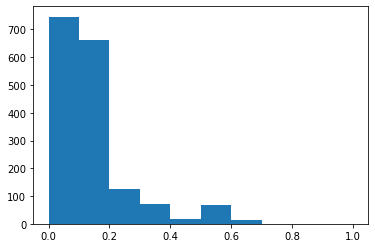

In [71]:
plt.hist(costs.flatten())

In [72]:
slabel_list = ['acceptance']
tlabel_list = ['accepted contribution']
costs, wd = maponto.wd_between_labels(slabel_list, tlabel_list, embs_model)
wd

1.0

In [73]:
costs

array([[1.]], dtype=float32)

(array([746., 663., 126.,  73.,  19.,  69.,  13.,   1.,   0.,   1.]),
 array([0.        , 0.18508396, 0.3701679 , 0.5552519 , 0.7403358 ,
        0.9254198 , 1.1105038 , 1.2955878 , 1.4806716 , 1.6657556 ,
        1.8508396 ], dtype=float32),
 <BarContainer object of 10 artists>)

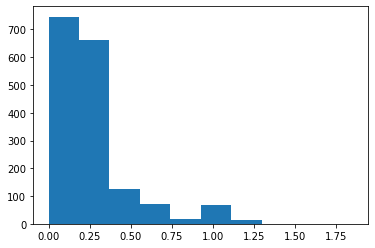

In [74]:
plt.hist(costs_raw.flatten())

In [75]:
costs_raw.shape

(29, 59)

In [82]:
costs_raw.mean()

0.27467924

In [153]:
np.percentile(costs_raw.flatten(), 10)

0.10151010751724243

In [150]:
slabel_list = ['acceptance']
tlabel_list = ['accepted contribution']
costs, wd = maponto.wd_between_labels_raw(slabel_list, tlabel_list, embs_model)
wd

0.0669039785861969

In [79]:
costs

array([[0.1558201]], dtype=float32)

# Computing WD from a Given Source to Associated Target Candidates

In [106]:
ot_align_rest.head()

source source_label  \
0  http://cmt#Acceptance   Acceptance   
1  http://cmt#Acceptance   Acceptance   
2  http://cmt#Acceptance   Acceptance   
3  http://cmt#Acceptance   Acceptance   
4  http://cmt#Acceptance   Acceptance   

                                      target             target_label  
0           http://conference#Conference_www           Conference_www  
1  http://conference#Contribution_1th-author  Contribution_1th-author  
2   http://conference#Contribution_co-author   Contribution_co-author  
3     http://conference#Early_paid_applicant     Early_paid_applicant  
4        http://conference#Extended_abstract        Extended_abstract

In [107]:
ot_align_rest.shape

(160, 4)

In [108]:
source_rest = ot_align_rest.source.unique()
source_rest

array(['http://cmt#Acceptance', 'http://cmt#Administrator',
       'http://cmt#AssociatedChair', 'http://cmt#AuthorNotReviewer',
       'http://cmt#Bid', 'http://cmt#ConferenceChair',
       'http://cmt#ConferenceMember', 'http://cmt#Decision',
       'http://cmt#ExternalReviewer', 'http://cmt#Meta-Review',
       'http://cmt#Meta-Reviewer', 'http://cmt#PaperFullVersion',
       'http://cmt#ProgramCommitteeChair', 'http://cmt#Rejection',
       'http://cmt#SubjectArea', 'http://cmt#User'], dtype=object)

In [81]:
target_rest = ot_align_rest.target.unique()
target_rest

array(['http://conference#Conference_www',
       'http://conference#Contribution_1th-author',
       'http://conference#Contribution_co-author',
       'http://conference#Early_paid_applicant',
       'http://conference#Extended_abstract',
       'http://conference#Important_dates',
       'http://conference#Conference_contributor',
       'http://conference#Written_contribution',
       'http://conference#Submitted_contribution',
       'http://conference#Accepted_contribution',
       'http://conference#Conference_volume',
       'http://conference#Invited_speaker',
       'http://conference#Organization',
       'http://conference#Track-workshop_chair',
       'http://conference#Conference_proceedings',
       'http://conference#Information_for_participants',
       'http://conference#Publisher', 'http://conference#Regular_author',
       'http://conference#Conference_fees', 'http://conference#Chair',
       'http://conference#Conference_participant',
       'http://conference#Acti

In [84]:
target_candids = ot_align_rest[ot_align_rest.source == source_rest[0]].target
target_candids

0             http://conference#Conference_www
1    http://conference#Contribution_1th-author
2     http://conference#Contribution_co-author
3       http://conference#Early_paid_applicant
4          http://conference#Extended_abstract
5            http://conference#Important_dates
6     http://conference#Conference_contributor
7       http://conference#Written_contribution
8     http://conference#Submitted_contribution
9      http://conference#Accepted_contribution
Name: target, dtype: object

In [85]:
maponto.query_related_information(source_rest[0], source_graph)

relation               related      what
0   rdfs:subClassOf   http://cmt#Decision     child
1  owl:disjointWith  http://cmt#Rejection  disjoint

In [86]:
maponto.query_related_information(target_candids[9], target_graph)

relation                                      related      what
0   rdfs:subClassOf      http://conference#Reviewed_contribution     child
1      superClassOf  http://conference#Camera_ready_contribution    parent
2  owl:disjointWith      http://conference#Rejected_contribution  disjoint

In [87]:
target_candids

0             http://conference#Conference_www
1    http://conference#Contribution_1th-author
2     http://conference#Contribution_co-author
3       http://conference#Early_paid_applicant
4          http://conference#Extended_abstract
5            http://conference#Important_dates
6     http://conference#Conference_contributor
7       http://conference#Written_contribution
8     http://conference#Submitted_contribution
9      http://conference#Accepted_contribution
Name: target, dtype: object

In [127]:
sclndLabel = slabel_clnd_uris[slabel_clnd_uris.uri == source_rest[0]].clndLabel.tolist()[0]

In [133]:
ssyn_ls = mapneighbor.get_syn_phrases(sclndLabel)

In [131]:
tclndLabel = tlabel_clnd_uris[tlabel_clnd_uris.uri == target_candids[9]].clndLabel.tolist()[0]

In [134]:
tsyn_ls = mapneighbor.get_syn_phrases(tclndLabel)

In [135]:
costs, wd = maponto.wd_between_labels_raw(ssyn_ls, tsyn_ls, embs_model)
wd

0.20904402304440733

In [54]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [51]:
source_uri = 'http://cmt#Acceptance'
sclndLabel = slabel_clnd_uris[slabel_clnd_uris.uri == source_uri].clndLabel.tolist()[0]

s_t_wds = defaultdict(float)

target_candids = ot_align_rest[ot_align_rest.source == source_uri].target.tolist()
for target in target_candids:
    tclndLabel = tlabel_clnd_uris[tlabel_clnd_uris.uri == target].clndLabel.tolist()[0]
    
    s_t_wds[target] = otmapper.wd_between_names(sclndLabel, tclndLabel, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

[('http://conference#Accepted_contribution', 0.0669039785861969),
 ('http://conference#Submitted_contribution', 0.09254240244626999),
 ('http://conference#Written_contribution', 0.10941967368125916),
 ('http://conference#Conference_contributor', 0.12178383767604828),
 ('http://conference#Extended_abstract', 0.127512589097023),
 ('http://conference#Early_paid_applicant', 0.15728327631950378),
 ('http://conference#Important_dates', 0.19253113865852356),
 ('http://conference#Contribution_co-author', 0.34122514724731445),
 ('http://conference#Conference_www', 0.3554666340351105),
 ('http://conference#Contribution_1th-author', 0.9637170433998108)]

In [53]:
source_uri = 'http://cmt#Acceptance'
srelated = maponto.query_related_information(source_uri, source_graph)

s_t_wds = defaultdict(float)

target_candids = ot_align_rest[ot_align_rest.source == source_uri].target.tolist()
for target in target_candids:
    trelated = maponto.query_related_information(target, target_graph)
    s_t_wds[target] = otmapper.wd_between_superclasses(srelated, trelated, 
                                              slabel_clnd_uris, tlabel_clnd_uris, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

INFO:root:WD_between_superclasses=0.13227401673793793: ['decision'] and ['conference document']
INFO:root:WD_between_superclasses=0.18491524457931519: ['decision'] and ['regular author']
INFO:root:WD_between_superclasses=0.18491524457931519: ['decision'] and ['regular author']
INFO:root:WD_between_superclasses=0.23932407796382904: ['decision'] and ['paid applicant']
INFO:root:WD_between_superclasses=0.14267656207084656: ['decision'] and ['regular contribution']
INFO:root:WD_between_superclasses: ['decision'] or [] is empty
INFO:root:WD_between_superclasses=0.21767620742321014: ['decision'] and ['person']
INFO:root:WD_between_superclasses=0.11760097742080688: ['decision'] and ['conference contribution']
INFO:root:WD_between_superclasses=0.13851407170295715: ['decision'] and ['written contribution']
INFO:root:WD_between_superclasses=0.13088330626487732: ['decision'] and ['reviewed contribution']


[('http://conference#Important_dates', -1),
 ('http://conference#Written_contribution', 0.11760097742080688),
 ('http://conference#Accepted_contribution', 0.13088330626487732),
 ('http://conference#Conference_www', 0.13227401673793793),
 ('http://conference#Submitted_contribution', 0.13851407170295715),
 ('http://conference#Extended_abstract', 0.14267656207084656),
 ('http://conference#Contribution_1th-author', 0.18491524457931519),
 ('http://conference#Contribution_co-author', 0.18491524457931519),
 ('http://conference#Conference_contributor', 0.21767620742321014),
 ('http://conference#Early_paid_applicant', 0.23932407796382904)]

In [21]:
wd_between_superclasses(srelated, trelated, slabel_clnd_uris, tlabel_clnd_uris)

INFO:root:WD_between_superclasses=0.13088330626487732: ['decision'] and ['reviewed contribution']


0.13088330626487732

In [55]:
source_uri = 'http://cmt#Acceptance'
srelated = maponto.query_related_information(source_uri, source_graph)

s_t_wds = defaultdict(float)

target_candids = ot_align_rest[ot_align_rest.source == source_uri].target.tolist()
for target in target_candids:
    trelated = maponto.query_related_information(target, target_graph)
    s_t_wds[target] = otmapper.wd_between_subclasses(srelated, trelated, 
                                              slabel_clnd_uris, tlabel_clnd_uris, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_subclasses: [] or ['abstract'] is empty
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_subclasses: [] or ['regular author', 'active conference participant', 'invited speaker'] is empty
INFO:root:WD_between_subclasses: [] or ['submitted contribution', 'regular contribution'] is empty
INFO:root:WD_between_subclasses: [] or ['reviewed contribution'] is empty
INFO:root:WD_between_subclasses: [] or ['camera ready contribution'] is empty


[('http://conference#Conference_www', -1),
 ('http://conference#Contribution_1th-author', -1),
 ('http://conference#Contribution_co-author', -1),
 ('http://conference#Early_paid_applicant', -1),
 ('http://conference#Extended_abstract', -1),
 ('http://conference#Important_dates', -1),
 ('http://conference#Conference_contributor', -1),
 ('http://conference#Written_contribution', -1),
 ('http://conference#Submitted_contribution', -1),
 ('http://conference#Accepted_contribution', -1)]

In [56]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [57]:
source_uri = 'http://cmt#Acceptance'
srelated = maponto.query_related_information(source_uri, source_graph)

s_t_wds = defaultdict(float)

target_candids = ot_align_rest[ot_align_rest.source == source_uri].target.tolist()
for target in target_candids:
    trelated = maponto.query_related_information(target, target_graph)
    s_t_wds[target] = otmapper.wd_between_disjoint(srelated, trelated, 
                                              slabel_clnd_uris, tlabel_clnd_uris, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_disjoint=0.36496245861053467: ['rejection'] and ['contribution co author']
INFO:root:WD_between_disjoint=1.0060805082321167: ['rejection'] and ['contribution 1 th author']
INFO:root:WD_between_disjoint=0.22382822632789612: ['rejection'] and ['late paid applicant']
INFO:root:WD_between_disjoint=0.38172608613967896: ['rejection'] and ['paper']
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_disjoint=0.07515572756528854: ['rejection'] and ['rejected contribution']


[('http://conference#Conference_www', -1),
 ('http://conference#Important_dates', -1),
 ('http://conference#Conference_contributor', -1),
 ('http://conference#Written_contribution', -1),
 ('http://conference#Submitted_contribution', -1),
 ('http://conference#Accepted_contribution', 0.07515572756528854),
 ('http://conference#Early_paid_applicant', 0.22382822632789612),
 ('http://conference#Contribution_1th-author', 0.36496245861053467),
 ('http://conference#Extended_abstract', 0.38172608613967896),
 ('http://conference#Contribution_co-author', 1.0060805082321167)]

In [61]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [60]:
source_uri = 'http://cmt#Chairman'
srelated = maponto.query_related_information(source_uri, source_graph)
print(srelated)

s_t_wds = defaultdict(float)

target_uri = 'http://conference#Conference_contribution'
trelated = maponto.query_related_information(target_uri, target_graph)
print(trelated)

s_t_wds[target_uri] = otmapper.wd_between_equivalents(srelated, trelated, 
                                              slabel_clnd_uris, tlabel_clnd_uris, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

              relation                           related        what
0      rdfs:subClassOf                 http://cmt#Person       child
1  owl:equivalentClass        http://cmt#AssociatedChair  equivalent
2  owl:equivalentClass        http://cmt#ConferenceChair  equivalent
3  owl:equivalentClass  http://cmt#ProgramCommitteeChair  equivalent


INFO:root:WD_between_equivalent=0.18420547793308892: ['associated chair', 'conference chair', 'program committee chair'] and ['written contribution', 'presentation', 'regular contribution', 'poster', 'invited talk']


                               relation  \
0                       rdfs:subClassOf   
1                          superClassOf   
2                          superClassOf   
3                          superClassOf   
4     http://conference#is_submitted_at   
5   http://conference#has_contributions   
6                   owl:equivalentClass   
7                   owl:equivalentClass   
8                   owl:equivalentClass   
9                   owl:equivalentClass   
10                  owl:equivalentClass   

                                   related        what  
0    http://conference#Conference_document       child  
1   http://conference#Written_contribution      parent  
2                 http://conference#Poster      parent  
3           http://conference#Presentation      parent  
4      http://conference#Conference_volume      domain  
5      http://conference#Conference_volume       range  
6   http://conference#Written_contribution  equivalent  
7           http://conferen

[('http://conference#Conference_contribution', 0.18420547793308892)]

In [50]:
# test append and extend
l1 = [1, 2, 3]
l2 = [4, 5]
l1.append(l2)
print(l1)
l1.extend(l2)
print(l1)

[1, 2, 3, [4, 5]]
[1, 2, 3, [4, 5], 4, 5]


In [62]:
source_uri = 'http://cmt#Meta-Reviewer'
srelated = maponto.query_related_information(source_uri, source_graph)
print(srelated)

s_t_wds = defaultdict(float)

target_uri = 'http://cmt#ProgramCommitteeMember'
trelated = maponto.query_related_information(target_uri, source_graph)
print(trelated)

s_t_wds[target_uri] = otmapper.wd_between_comments(srelated, trelated, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

                         relation  \
0                 rdfs:subClassOf   
1  http://cmt#readByMeta-Reviewer   
3                    rdfs:comment   

                                             related     what  
0                                http://cmt#Reviewer    child  
1                                   http://cmt#Paper    range  
3  A special type of Reviewer.  There can be any ...  comment  


INFO:root:WD_between_comments=0.33798213710642266: ['special', 'type', 'reviewer', 'number', 'reviewers', 'given', 'paper', 'one', 'meta', 'reviewer', 'meta', 'reviewer', 'go', 'reviews', 'submitted', 'paper', 'submit', 'review', 'questions', 'meta', 'reviewer', 'different', 'normal', 'reviewer', 'role', 'ensure', 'reviews', 'good', 'consistent', 'decision', 'use', 'meta', 'reviewers', 'optional', 'must', 'set', 'paper', 'assignment', 'occurs'] and ['program', 'committee', 'consists', 'members', 'conference', 'except', 'authors', 'also', 'reviewers']


                                relation  \
0                        rdfs:subClassOf   
1                        rdfs:subClassOf   
2                           superClassOf   
3    http://cmt#memberOfProgramCommittee   
4                     http://cmt#addedBy   
5                   http://cmt#maxPapers   
6   http://cmt#hasProgramCommitteeMember   
7                http://cmt#setMaxPapers   
8   http://cmt#addProgramCommitteeMember   
9                           rdfs:comment   
10                      owl:disjointWith   

                                              related             what  
0                                   http://cmt#Person            child  
1                         http://cmt#ConferenceMember            child  
2                    http://cmt#ProgramCommitteeChair           parent  
3                         http://cmt#ProgramCommittee           domain  
4                            http://cmt#Administrator           domain  
5                http://www.w3.or

[('http://cmt#ProgramCommitteeMember', 0.33798213710642266)]

In [68]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [64]:
source_uri = 'http://cmt#Person'
srelated = maponto.query_related_information(source_uri, source_graph)
print(srelated)

s_t_wds = defaultdict(float)

target_uri = 'http://conference#Person'
trelated = maponto.query_related_information(target_uri, target_graph)
print(trelated)

s_t_wds[target_uri] = otmapper.wd_between_datatypes(srelated, trelated, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

                            relation                                  related  \
0                       superClassOf        http://cmt#ProgramCommitteeMember   
1                       superClassOf              http://cmt#ConferenceMember   
2                       superClassOf              http://cmt#ExternalReviewer   
3                       superClassOf                      http://cmt#Chairman   
4                       superClassOf                          http://cmt#User   
5   http://cmt#hasConflictOfInterest                      http://cmt#Document   
6                   http://cmt#email  http://www.w3.org/2001/XMLSchema#string   
7                    http://cmt#name  http://www.w3.org/2001/XMLSchema#string   
8                   owl:disjointWith                    http://cmt#Preference   
9                   owl:disjointWith              http://cmt#ProgramCommittee   
10                  owl:disjointWith                           http://cmt#Bid   
11                  owl:disj

INFO:root:WD_between_datatypes=0.12166944642861682: ['email', 'name'] and ['email', 'first name', 'last name']


                                relation  \
0                           superClassOf   
1                           superClassOf   
2                           superClassOf   
3                           superClassOf   
4                           superClassOf   
5                           superClassOf   
6          http://conference#contributes   
7         http://conference#has_an_email   
8   http://conference#has_the_first_name   
9    http://conference#has_the_last_name   
10         http://conference#has_authors   
11         http://conference#has_authors   

                                     related             what  
0   http://conference#Conference_participant           parent  
1     http://conference#Conference_applicant           parent  
2         http://conference#Committee_member           parent  
3   http://conference#Conference_contributor           parent  
4                 http://conference#Reviewer           parent  
5     http://conference#Track-workshop_chai

[('http://conference#Person', 0.12166944642861682)]

In [65]:
source_uri = 'http://cmt#Paper'
srelated = maponto.query_related_information(source_uri, source_graph)
#print(srelated)
otmapper.get_objectproperty_labels(srelated)

['decision',
 'read reviewer',
 'read meta reviewer',
 'co author',
 'bid',
 'assigned reviewer',
 'subject area',
 'author',
 'accepted administrator',
 'rejected administrator',
 'co write paper co author',
 'reject paper administrator',
 'read paper reviewer',
 'assigned reviewer',
 'submit paper author',
 'accept paper administrator',
 'write paper author']

In [66]:
source_uri = 'http://cmt#Person'
srelated = maponto.query_related_information(source_uri, source_graph)
print(srelated)

s_t_wds = defaultdict(float)

target_uri = 'http://conference#Person'
trelated = maponto.query_related_information(target_uri, target_graph)
print(trelated)

s_t_wds[target_uri] = otmapper.wd_between_objectproperties(srelated, trelated, embs_model)
sorted(s_t_wds.items(), key=lambda kv: kv[1])

                            relation                                  related  \
0                       superClassOf        http://cmt#ProgramCommitteeMember   
1                       superClassOf              http://cmt#ConferenceMember   
2                       superClassOf              http://cmt#ExternalReviewer   
3                       superClassOf                      http://cmt#Chairman   
4                       superClassOf                          http://cmt#User   
5   http://cmt#hasConflictOfInterest                      http://cmt#Document   
6                   http://cmt#email  http://www.w3.org/2001/XMLSchema#string   
7                    http://cmt#name  http://www.w3.org/2001/XMLSchema#string   
8                   owl:disjointWith                    http://cmt#Preference   
9                   owl:disjointWith              http://cmt#ProgramCommittee   
10                  owl:disjointWith                           http://cmt#Bid   
11                  owl:disj

INFO:root:WD_between_objectproperties=0.09333815425634384: ['conflict interest document'] and ['contributes conference document', 'authors review']


                                relation  \
0                           superClassOf   
1                           superClassOf   
2                           superClassOf   
3                           superClassOf   
4                           superClassOf   
5                           superClassOf   
6          http://conference#contributes   
7         http://conference#has_an_email   
8   http://conference#has_the_first_name   
9    http://conference#has_the_last_name   
10         http://conference#has_authors   
11         http://conference#has_authors   

                                     related             what  
0   http://conference#Conference_participant           parent  
1     http://conference#Conference_applicant           parent  
2         http://conference#Committee_member           parent  
3   http://conference#Conference_contributor           parent  
4                 http://conference#Reviewer           parent  
5     http://conference#Track-workshop_chai

[('http://conference#Person', 0.09333815425634384)]

In [69]:
otmapper.compute_wds_uri_targets(slabel_clnd_uris, source_graph, tlabel_clnd_uris, target_graph, 
                        ot_align_rest, 'http://cmt#Acceptance', embs_model)

INFO:root:============http://cmt#Acceptance==========
INFO:root:WD_between_superclasses=0.13227401673793793: ['decision'] and ['conference document']
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_equivalent: [] or [] is empty
INFO:root:WD_between_comments: [] or [] is empty
INFO:root:WD_between_datatypes: [] or ['url'] is empty
INFO:root:WD_between_objectproperties: [] or [] is empty
INFO:root:compute_wds_uri_targets(): average wd: 0.2438703253865242
INFO:root:============http://cmt#Acceptance==========
INFO:root:WD_between_superclasses=0.18491524457931519: ['decision'] and ['regular author']
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_disjoint=0.36496245861053467: ['rejection'] and ['contribution co author']
INFO:root:WD_between_equivalent: [] or [] is empty
INFO:root:WD_between_comments: [] or [] is empty
INFO:root:WD_between_datatypes: [] or [] is empty
INFO:root:WD_betw

('http://cmt#Acceptance',
 [('http://conference#Accepted_contribution', 0.09098100413878758),
  ('http://conference#Written_contribution', 0.11351032555103302),
  ('http://conference#Submitted_contribution', 0.11552823707461357),
  ('http://conference#Conference_contributor', 0.1697300225496292),
  ('http://conference#Important_dates', 0.19253113865852356),
  ('http://conference#Early_paid_applicant', 0.20681186020374298),
  ('http://conference#Extended_abstract', 0.21730507910251617),
  ('http://conference#Conference_www', 0.2438703253865242),
  ('http://conference#Contribution_1th-author', 0.5045315821965536),
  ('http://conference#Contribution_co-author', 0.5107403000195821)])

# Computing WD between Each Pair of Source and Target Candidates

In [113]:
ot_align_rest.head()

source source_label  \
0  http://cmt#Acceptance   Acceptance   
1  http://cmt#Acceptance   Acceptance   
2  http://cmt#Acceptance   Acceptance   
3  http://cmt#Acceptance   Acceptance   
4  http://cmt#Acceptance   Acceptance   

                                      target             target_label  
0           http://conference#Conference_www           Conference_www  
1  http://conference#Contribution_1th-author  Contribution_1th-author  
2   http://conference#Contribution_co-author   Contribution_co-author  
3     http://conference#Early_paid_applicant     Early_paid_applicant  
4        http://conference#Extended_abstract        Extended_abstract

In [114]:
ot_align_rest.shape

(160, 4)

In [115]:
source_rest = ot_align_rest.source.unique()
source_rest

array(['http://cmt#Acceptance', 'http://cmt#Administrator',
       'http://cmt#AssociatedChair', 'http://cmt#AuthorNotReviewer',
       'http://cmt#Bid', 'http://cmt#ConferenceChair',
       'http://cmt#ConferenceMember', 'http://cmt#Decision',
       'http://cmt#ExternalReviewer', 'http://cmt#Meta-Review',
       'http://cmt#Meta-Reviewer', 'http://cmt#PaperFullVersion',
       'http://cmt#ProgramCommitteeChair', 'http://cmt#Rejection',
       'http://cmt#SubjectArea', 'http://cmt#User'], dtype=object)

In [116]:
target_candids = ot_align_rest[ot_align_rest.source == source_rest[0]].target
target_candids

0             http://conference#Conference_www
1    http://conference#Contribution_1th-author
2     http://conference#Contribution_co-author
3       http://conference#Early_paid_applicant
4          http://conference#Extended_abstract
5            http://conference#Important_dates
6     http://conference#Conference_contributor
7       http://conference#Written_contribution
8     http://conference#Submitted_contribution
9      http://conference#Accepted_contribution
Name: target, dtype: object

In [74]:
importlib.reload(maponto)
importlib.reload(otmapper)
importlib.reload(mapneighbor)

INFO:root:logging info test


<module 'OTNeighborhood_TDA' from '/home/ubuntu/django/otmaponto/match/ontology_mapping/src/OTNeighborhood_TDA.py'>

In [71]:
otmapper.generate_mapping_threshold(slabel_clnd_uris, tlabel_clnd_uris, 5, embs_model)

0.08389917761087418

In [158]:
slabel_clnd_uris[slabel_clnd_uris.uri == 'http://cmt#Person'].label.values[0]

'Person'

In [75]:
%%time
from_candidates_5percent = otmapper.generate_mappings_from_candidates(slabel_clnd_uris, source_graph, tlabel_clnd_uris, 
                                      target_graph, ot_align_rest, 5, embs_model)

INFO:root:============http://cmt#Acceptance==========
INFO:root:WD_between_superclasses=0.13227401673793793: ['decision'] and ['conference document']
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_equivalent: [] or [] is empty
INFO:root:WD_between_comments: [] or [] is empty
INFO:root:WD_between_datatypes: [] or ['url'] is empty
INFO:root:WD_between_objectproperties: [] or [] is empty
INFO:root:compute_wds_uri_targets(): average wd: 0.2438703253865242
INFO:root:============http://cmt#Acceptance==========
INFO:root:WD_between_superclasses=0.18491524457931519: ['decision'] and ['regular author']
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_disjoint=0.36496245861053467: ['rejection'] and ['contribution co author']
INFO:root:WD_between_equivalent: [] or [] is empty
INFO:root:WD_between_comments: [] or [] is empty
INFO:root:WD_between_datatypes: [] or [] is empty
INFO:root:WD_betw

CPU times: user 1min 58s, sys: 1.42 s, total: 1min 59s
Wall time: 1min 37s


In [76]:
%%time
from_candidates_10percent = otmapper.generate_mappings_from_candidates(slabel_clnd_uris, source_graph, tlabel_clnd_uris, 
                                      target_graph, ot_align_rest, 10, embs_model)

INFO:root:============http://cmt#Acceptance==========
INFO:root:WD_between_superclasses=0.13227401673793793: ['decision'] and ['conference document']
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_disjoint: ['rejection'] or [] is empty
INFO:root:WD_between_equivalent: [] or [] is empty
INFO:root:WD_between_comments: [] or [] is empty
INFO:root:WD_between_datatypes: [] or ['url'] is empty
INFO:root:WD_between_objectproperties: [] or [] is empty
INFO:root:compute_wds_uri_targets(): average wd: 0.2438703253865242
INFO:root:============http://cmt#Acceptance==========
INFO:root:WD_between_superclasses=0.18491524457931519: ['decision'] and ['regular author']
INFO:root:WD_between_subclasses: [] or [] is empty
INFO:root:WD_between_disjoint=0.36496245861053467: ['rejection'] and ['contribution co author']
INFO:root:WD_between_equivalent: [] or [] is empty
INFO:root:WD_between_comments: [] or [] is empty
INFO:root:WD_between_datatypes: [] or [] is empty
INFO:root:WD_betw

CPU times: user 2min, sys: 1.5 s, total: 2min 2s
Wall time: 1min 39s


In [41]:
from_candidates_10percent

source           source_label  \
0             http://cmt#Acceptance             Acceptance   
1          http://cmt#Administrator          Administrator   
2        http://cmt#AssociatedChair        AssociatedChair   
3      http://cmt#AuthorNotReviewer      AuthorNotReviewer   
4        http://cmt#ConferenceChair        ConferenceChair   
5       http://cmt#ConferenceMember       ConferenceMember   
6  http://cmt#ProgramCommitteeChair  ProgramCommitteeChair   
7              http://cmt#Rejection              Rejection   

                                     target            target_label  
0   http://conference#Accepted_contribution   Accepted_contribution  
1            http://conference#Organization            Organization  
2    http://conference#Written_contribution    Written_contribution  
3               http://conference#Publisher               Publisher  
4                   http://conference#Chair                   Chair  
5  http://conference#Conference_contributor  Conference_contributor  
6    http://conference#Written_contribution    Written_contribution  
7   http://conference#Rejected_contribution   Rejected_contribution

# Computing Non-Uniform Distributions for Optimal Transport

In [62]:
# computing a non-uniform distribution for a set of points based on 
# the given shortest distances to another set of points
def non_uniform_dist(costs, mu):
    '''
        input:  costs: a nxm matrix (narray) of distances from a set of n points to a set of 
                     m points
                mu: a smoothing value for eliminating zero distances
        output: a probability distribution for the n points 
    '''
    ds = costs.min(axis=1)
    ds_mu_inv = 1 / (ds + mu)
    p = ds_mu_inv / ds_mu_inv.sum()
    
    return p

In [75]:
non_uniform_dist(costs_raw, 0.001)

array([0.00231711, 0.00241503, 0.00247603, 0.00193484, 0.00372992,
       0.00016881, 0.00141767, 0.00228777, 0.15733197, 0.0028891 ,
       0.00506387, 0.00141446, 0.00421695, 0.00243745, 0.00101241,
       0.00097564, 0.15731321, 0.00210829, 0.00137659, 0.15733665,
       0.0023978 , 0.15734135, 0.00380235, 0.0080735 , 0.00206605,
       0.15733197, 0.15734135, 0.0010368 , 0.00038517], dtype=float32)

In [79]:
non_uniform_dist(costs_raw.T, 0.001)

array([0.00198334, 0.0021798 , 0.00285958, 0.00129305, 0.001157  ,
       0.00127772, 0.00148714, 0.00114905, 0.00370184, 0.00759505,
       0.14800811, 0.00555014, 0.0029339 , 0.00493661, 0.00416569,
       0.00396704, 0.00070824, 0.00173801, 0.0050106 , 0.00542785,
       0.00203145, 0.00057609, 0.00016859, 0.00215219, 0.00111826,
       0.00146326, 0.00094227, 0.00192346, 0.00142679, 0.00069605,
       0.00088151, 0.00235917, 0.00122287, 0.00332918, 0.00083969,
       0.14799047, 0.00219841, 0.14801252, 0.00061245, 0.00202627,
       0.14801693, 0.00150298, 0.00177212, 0.00220361, 0.0016635 ,
       0.00194361, 0.14800811, 0.00204427, 0.0022557 , 0.00158809,
       0.14801693, 0.00249975, 0.00171406, 0.00058755, 0.00054443,
       0.00287878, 0.00075575, 0.00135404, 0.00154898], dtype=float32)

## Test on Conference

In [ ]:
source_url = "../data/conference/conference-v1/cmt-conference/source.rdf"
target_url = "../data/conference/conference-v1/cmt-conference/target.rdf"
output_url = '../data/results/cmt_conference_alignments.rdf'
refs_url = "../data/conference/conference-v1/cmt-conference/reference.rdf"

In [25]:
preds_align = maponto.match_label_embeddings_OT_raw_nonUniform(slabel_clnd_uris, tlabel_clnd_uris, embs_model, \
                        maponto.make_mappings_topn, 10, 0.001, None)

INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (29, 59)
INFO:root:Computing Optimal Transport Plan Non-uniform Distribution...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...
INFO:root:Making Top_n Mappings from the Optimal Transport Plan...


In [22]:
preds_align

source      source_label  \
0        http://cmt#Conference        Conference   
1             http://cmt#Paper             Paper   
2            http://cmt#Person            Person   
3  http://cmt#ProgramCommittee  ProgramCommittee   
4            http://cmt#Review            Review   
5          http://cmt#Reviewer          Reviewer   

                                target       target_label  
0         http://conference#Conference         Conference  
1              http://conference#Paper              Paper  
2             http://conference#Person             Person  
3  http://conference#Program_committee  Program_committee  
4             http://conference#Review             Review  
5           http://conference#Reviewer           Reviewer

In [26]:
maponto.evaluate(preds_align, refs_url)

Total number of references is 15
Total correctly predicted alignments is 9
Total number of predicted is 290
Precision is 0.03103448275862069
Recall is 0.6
F1-Measure is 0.05901639344262296


In [23]:
preds_align = maponto.match_label_embeddings_OT(slabel_clnd_uris, tlabel_clnd_uris, embs_model, \
                        maponto.make_mappings_nn, None, None)
maponto.evaluate(preds_align, refs_url)

INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (29, 59)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from a Pairwise OT Plan Matrix by Mutual NN...


Total number of references is 15
Total correctly predicted alignments is 8
Total number of predicted is 23
Precision is 0.34782608695652173
Recall is 0.5333333333333333
F1-Measure is 0.42105263157894735


In [ ]:
preds_align

source            source_label  \
0               http://cmt#Acceptance              Acceptance   
1            http://cmt#Administrator           Administrator   
2                   http://cmt#Author                  Author   
3                      http://cmt#Bid                     Bid   
4                 http://cmt#Chairman                Chairman   
5                http://cmt#Co-author               Co-author   
6               http://cmt#Conference              Conference   
7         http://cmt#ConferenceMember        ConferenceMember   
8                 http://cmt#Document                Document   
9         http://cmt#ExternalReviewer        ExternalReviewer   
10             http://cmt#Meta-Review             Meta-Review   
11                   http://cmt#Paper                   Paper   
12           http://cmt#PaperAbstract           PaperAbstract   
13                  http://cmt#Person                  Person   
14              http://cmt#Preference              Preference   
15        http://cmt#ProgramCommittee        ProgramCommittee   
16   http://cmt#ProgramCommitteeChair   ProgramCommitteeChair   
17  http://cmt#ProgramCommitteeMember  ProgramCommitteeMember   
18               http://cmt#Rejection               Rejection   
19                  http://cmt#Review                  Review   
20                http://cmt#Reviewer                Reviewer   
21             http://cmt#SubjectArea             SubjectArea   
22                    http://cmt#User                    User   

                                              target  \
0            http://conference#Accepted_contribution   
1                     http://conference#Organization   
2                   http://conference#Regular_author   
3                     http://conference#Invited_talk   
4                        http://conference#Organizer   
5                         http://conference#Co-chair   
6                       http://conference#Conference   
7           http://conference#Conference_participant   
8              http://conference#Conference_document   
9   http://conference#Passive_conference_participant   
10                        http://conference#Tutorial   
11                           http://conference#Paper   
12                        http://conference#Abstract   
13                          http://conference#Person   
14            http://conference#Regular_contribution   
15               http://conference#Program_committee   
16              http://conference#Steering_committee   
17                http://conference#Committee_member   
18           http://conference#Rejected_contribution   
19                          http://conference#Review   
20                        http://conference#Reviewer   
21                           http://conference#Topic   
22                  http://conference#Paid_applicant   

                      target_label  
0            Accepted_contribution  
1                     Organization  
2                   Regular_author  
3                     Invited_talk  
4                        Organizer  
5                         Co-chair  
6                       Conference  
7           Conference_participant  
8              Conference_document  
9   Passive_conference_participant  
10                        Tutorial  
11                           Paper  
12                        Abstract  
13                          Person  
14            Regular_contribution  
15               Program_committee  
16              Steering_committee  
17                Committee_member  
18           Rejected_contribution  
19                          Review  
20                        Reviewer  
21                           Topic  
22                  Paid_applicant